In [1]:
import json
import scipy.sparse as sparse
import numpy as np
from os import listdir
import matplotlib.pyplot as plt

In [2]:
import importlib.util

spec = importlib.util.spec_from_file_location('input_output', '../phase/input_output.py')
input_output = importlib.util.module_from_spec(spec)
spec.loader.exec_module(input_output)

spec = importlib.util.spec_from_file_location('losses', '../phase/losses.py')
losses = importlib.util.module_from_spec(spec)
spec.loader.exec_module(losses)

spec = importlib.util.spec_from_file_location('inheritance_states', '../phase/inheritance_states.py')
inheritance_states = importlib.util.module_from_spec(spec)
spec.loader.exec_module(inheritance_states)

In [3]:
chrom = '10'
start_pos, end_pos = 125500000, 126500000
parent_data_dir = '../phased_mssng_quads_del'
parental_variants_file = '%s/chr.%s.%d.%d.parental_variants.npz' % (parent_data_dir, chrom, start_pos, end_pos)
parental_deletions_file = '%s/chr.%s.%d.%d.parental_deletions.npz' % (parent_data_dir, chrom, start_pos, end_pos)
child_data_dir = '../../DATA/spark/genotypes'
child_param_file = '../params/spark_quads_multiloss_params.json'
child_ped_file = '../../DATA/spark/spark.ped.quads.ped'

In [4]:
gen_files = sorted([f for f in listdir(child_data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f], key=lambda x: int(x.split('.')[2]))
coord_files = sorted([f for f in listdir(child_data_dir) if ('chr.%s.' % chrom) in f and 'gen.coordinates.npy' in f], key=lambda x: int(x.split('.')[2]))
sample_file = '%s/samples.json' % child_data_dir

# pull samples
with open(sample_file, 'r') as f:
    sample_ids = json.load(f)
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

print(len(gen_files), len(coord_files))
assert len(gen_files) == len(coord_files)

# pull coordinates
# use only SNPs, no indels
# use only variants that PASS GATK
gens, snp_positions = [], []
total_pos = 0
for gen_file, coord_file in zip(gen_files, coord_files):
    coords = np.load('%s/%s' % (child_data_dir, coord_file))

    if coords.shape[0]>0:
        poss = coords[:, 1]
        is_snp = coords[:, 2]==1
        is_pass = coords[:, 3]==1

    in_interval = (coords[:, 1]>=start_pos) & (coords[:, 1]<=end_pos)

    if np.sum(is_snp & is_pass & in_interval)>0:
        gen = sparse.load_npz('%s/%s' % (child_data_dir, gen_file))

        gens.append(gen[:, is_snp & is_pass & in_interval].A)
        snp_positions.append(poss[is_snp & is_pass & in_interval])

gens = np.hstack(gens)
snp_positions = np.hstack(snp_positions)
print(gens.shape, snp_positions.shape)


1 1
(13249, 286) (286,)


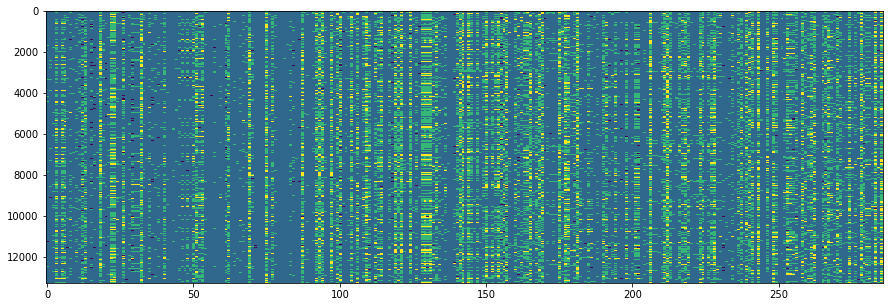

In [5]:
plt.figure(figsize=(15, 5))
plt.imshow(gens, aspect='auto', vmin=-1, vmax=2)
plt.show()

In [6]:
parental_variants = sparse.load_npz(parental_variants_file)[:, snp_positions].A
parental_deletions = sparse.load_npz(parental_deletions_file)[:, snp_positions].A
parental_homref = 1 - parental_variants - parental_deletions
print(parental_variants.shape, parental_deletions.shape, parental_homref.shape)

(3080, 286) (3080, 286) (3080, 286)


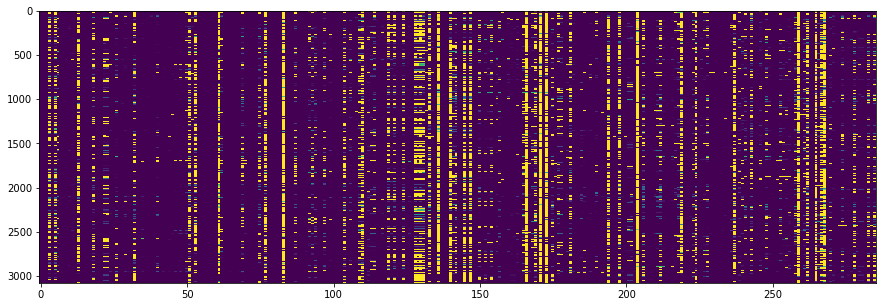

In [7]:
plt.figure(figsize=(15, 5))
plt.imshow(parental_variants, aspect='auto', vmin=0, vmax=1)
plt.show()

In [10]:
emission_params = np.zeros((gen.shape[0], 6, 4))

with open(child_param_file, 'r') as f:
    params = json.load(f)

families = input_output.pull_families(child_ped_file)
for family in families:
    if len([x for x in family.individuals if x in sample_id_to_index]) > 0:
        states = inheritance_states.InheritanceStates(family, True, True, 1)
        loss = losses.LazyLoss(states, family, params, 1, np.array([0, 0.5, 1]))

        for i, individual in enumerate(family.individuals):
            if (individual in sample_id_to_index) and not np.all(np.isinf(loss.emission_params[0, i, :, :])):
                emission_params[sample_id_to_index[individual], :, :] = loss.emission_params[0, i, :, :]
    

families pulled 15055
fixed [('SP0000027', 'mat'), ('SP0000027', 'pat')]
inheritance states (64, 9)
no data []
SP0000051
	0/0	0/1	1/1	./.
0/0	0.0004	3.9181	4.7709	3.0959
0/1	4.5078	0.0013	4.5067	2.5306
1/1	3.3357	3.1947	0.0005	4.0262
-/0	0.0004	3.9181	4.7709	3.0959
-/1	3.3357	3.1947	0.0005	4.0262
-/-	3.1947	4.0533	3.9181	0.0004
SP0000241
	0/0	0/1	1/1	./.
0/0	0.0012	3.9181	5.2906	2.5703
0/1	4.4965	0.0029	3.9276	2.1860
1/1	3.5697	3.1947	0.0022	2.3779
-/0	0.0012	3.9181	5.2906	2.5703
-/1	3.5697	3.1947	0.0022	2.3779
-/-	3.1947	4.4301	3.9181	0.0003
SP0000027
	0/0	0/1	1/1	./.
0/0	0.0015	4.3409	5.3706	2.4760
0/1	3.4478	0.0018	4.0022	2.4216
1/1	3.7867	3.1947	0.0021	2.4072
-/0	0.0015	4.3409	5.3706	2.4760
-/1	3.7867	3.1947	0.0021	2.4072
-/-	3.1947	4.5786	4.3409	0.0003
SP0000034
	0/0	0/1	1/1	./.
0/0	0.0053	3.4954	5.3711	1.9259
0/1	3.8926	0.0044	3.5332	2.0181
1/1	3.7900	3.1947	0.0086	1.7240
-/0	0.0053	3.4954	5.3711	1.9259
-/1	3.7900	3.1947	0.0086	1.7240
-/-	3.1947	4.5806	3.4954	0.0004
[0.  0.5 1. ]

../phase/losses.py:61: RuntimeWarning: divide by zero encountered in log10
  self.ref_costs = np.array([-np.log10(1-(10**-alt_cost)) for alt_cost in self.alt_costs])


inheritance states (64, 9)
no data []
SP0004339
	0/0	0/1	1/1	./.
0/0	0.0010	3.8103	4.8196	2.6814
0/1	3.8749	0.0033	4.4689	2.1280
1/1	3.2383	3.1821	0.0013	2.7686
-/0	0.0010	3.8103	4.8196	2.6814
-/1	3.2383	3.1821	0.0013	2.7686
-/-	3.1821	4.0290	3.8103	0.0004
SP0073688
	0/0	0/1	1/1	./.
0/0	0.0017	3.8103	4.6969	2.4355
0/1	4.4928	0.0021	4.4962	2.3149
1/1	3.3619	3.1821	0.0030	2.2335
-/0	0.0017	3.8103	4.6969	2.4355
-/1	3.3619	3.1821	0.0030	2.2335
-/-	3.1821	4.0294	3.8103	0.0004
SP0000760
	0/0	0/1	1/1	./.
0/0	0.0075	3.2505	5.3658	1.7839
0/1	3.7877	0.0085	4.2555	1.7193
1/1	3.7798	3.1817	0.0092	1.6981
-/0	0.0075	3.2505	5.3658	1.7839
-/1	3.7798	3.1817	0.0092	1.6981
-/-	3.1817	4.5728	3.2505	0.0005
SP0000301
	0/0	0/1	1/1	./.
0/0	0.0015	4.3702	5.3667	2.4687
0/1	3.5019	0.0019	3.7235	2.4089
1/1	3.7870	3.1824	0.0032	2.1927
-/0	0.0015	4.3702	5.3667	2.4687
-/1	3.7870	3.1824	0.0032	2.1927
-/-	3.1824	4.5769	4.3702	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

//anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


inheritance states (64, 9)
no data []
SP0000699
	0/0	0/1	1/1	./.
0/0	0.0011	4.1840	4.7714	2.6105
0/1	4.5082	0.0018	4.5114	2.3789
1/1	3.5055	3.1582	0.0025	2.3148
-/0	0.0011	4.1840	4.7714	2.6105
-/1	3.5055	3.1582	0.0025	2.3148
-/-	3.1582	4.1385	4.1840	0.0004
SP0001169
	0/0	0/1	1/1	./.
0/0	0.0006	4.1840	4.6855	2.8709
0/1	4.5648	0.0015	4.5663	2.4735
1/1	3.1001	3.1582	0.0008	3.5504
-/0	0.0006	4.1840	4.6855	2.8709
-/1	3.1001	3.1582	0.0008	3.5504
-/-	3.1582	3.8928	4.1840	0.0004
SP0000967
	0/0	0/1	1/1	./.
0/0	0.0010	4.2860	5.3649	2.6360
0/1	3.2480	0.0023	3.7597	2.3418
1/1	3.6842	3.1582	0.0018	2.4861
-/0	0.0010	4.2860	5.3649	2.6360
-/1	3.6842	3.1582	0.0018	2.4861
-/-	3.1582	4.5246	4.2860	0.0003
SP0001066
	0/0	0/1	1/1	./.
0/0	0.0023	4.0820	5.3667	2.2797
0/1	4.1435	0.0034	3.8244	2.1147
1/1	3.7904	3.1582	0.0032	2.1827
-/0	0.0023	4.0820	5.3667	2.2797
-/1	3.7904	3.1582	0.0032	2.1827
-/-	3.1582	4.5786	4.0820	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0003652
	0/0	0/1	1/1	./.
0/0	0.0007	3.1207	4.9706	3.1014
0/1	3.0126	0.0021	4.5132	2.4205
1/1	4.0320	3.0331	0.0013	2.7276
-/0	0.0007	3.1207	4.9706	3.1014
-/1	4.0320	3.0331	0.0013	2.7276
-/-	3.0331	4.5013	3.1207	0.0007
SP0001545
	0/0	0/1	1/1	./.
0/0	0.0007	3.1207	5.3504	3.0822
0/1	4.4976	0.0014	3.9274	2.5259
1/1	3.1444	3.0331	0.0008	4.0182
-/0	0.0007	3.1207	5.3504	3.0822
-/1	3.1444	3.0331	0.0008	4.0182
-/-	3.0331	4.2474	3.1207	0.0008
SP0001752
	0/0	0/1	1/1	./.
0/0	0.0098	3.1500	5.2965	1.6642
0/1	3.7524	0.0066	4.5809	1.8257
1/1	3.7836	2.8937	0.0149	1.4915
-/0	0.0098	3.1500	5.2965	1.6642
-/1	3.7836	2.8937	0.0149	1.4915
-/-	2.8937	4.5401	3.1500	0.0009
SP0002136
	0/0	0/1	1/1	./.
0/0	0.0114	3.0913	5.3506	1.6018
0/1	3.5096	0.0085	4.0695	1.7195
1/1	3.7834	3.1726	0.0155	1.4669
-/0	0.0114	3.0913	5.3506	1.6018
-/1	3.7834	3.1726	0.0155	1.4669
-/-	3.1726	4.5670	3.0913	0.0007
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0003156', 'mat'), ('SP0003156', 'pat')]
inheritance states (64, 9)
no data []
SP0002656
	0/0	0/1	1/1	./.
0/0	0.0007	3.8212	4.6335	2.8502
0/1	4.5146	0.0014	4.2836	2.4984
1/1	3.2833	3.1636	0.0016	2.6183
-/0	0.0007	3.8212	4.6335	2.8502
-/1	3.2833	3.1636	0.0016	2.6183
-/-	3.1636	3.9584	3.8212	0.0004
SP0003244
	0/0	0/1	1/1	./.
0/0	0.0006	3.8212	5.3663	2.8954
0/1	4.4926	0.0022	3.7947	2.3093
1/1	3.1591	3.1636	0.0010	3.0452
-/0	0.0006	3.8212	5.3663	2.8954
-/1	3.1591	3.1636	0.0010	3.0452
-/-	3.1636	4.2627	3.8212	0.0004
SP0003156
	0/0	0/1	1/1	./.
0/0	0.0065	3.3700	5.3691	1.8435
0/1	3.2930	0.0062	3.6389	1.8748
1/1	3.7778	3.1636	0.0087	1.7243
-/0	0.0065	3.3700	5.3691	1.8435
-/1	3.7778	3.1636	0.0087	1.7243
-/-	3.1636	4.5735	3.3700	0.0005
SP0003127
	0/0	0/1	1/1	./.
0/0	0.0012	4.2724	5.3696	2.5706
0/1	3.5053	0.0026	3.7919	2.2682
1/1	3.6488	3.1636	0.0022	2.3858
-/0	0.0012	4.2724	5.3696	2.5706
-/1	3.6488	3.1636	0.0022	2.3858
-/-	3.1636	4.509

no data ['SP0003695']
SP0003693
	0/0	0/1	1/1	./.
0/0	0.0011	5.3195	4.2814	2.6211
0/1	4.3268	0.0023	4.3185	2.2925
1/1	3.1876	3.1855	0.0006	4.0109
-/0	0.0011	5.3195	4.2814	2.6211
-/1	3.1876	3.1855	0.0006	4.0109
-/-	3.1855	3.7345	5.3195	0.0004
SP0013719
	0/0	0/1	1/1	./.
0/0	0.0015	5.3195	4.5782	2.4804
0/1	4.3186	0.0034	4.3173	2.1159
1/1	2.8939	3.1855	0.0009	4.0243
-/0	0.0015	5.3195	4.5782	2.4804
-/1	2.8939	3.1855	0.0009	4.0243
-/-	3.1855	3.7361	5.3195	0.0004
SP0003695
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0003691
	0/0	0/1	1/1	./.
0/0	0.0008	5.3195	5.3752	2.7294
0/1	3.7347	0.0020	3.6068	2.3792
1/1	3.7963	3.1855	0.0015	2.5953
-/0	0.0008	5.3195	5.3752	2.7294
-/1	3.7963	3.1855	0.0015	2.5953
-/-	3.1855	4.5857	5.3195	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.3010

-/1	3.7776	3.1440	0.0078	1.7722
-/-	3.1440	4.5720	3.6867	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0004087', 'mat'), ('SP0004087', 'pat')]
inheritance states (64, 9)
no data []
SP0007898
	0/0	0/1	1/1	./.
0/0	0.0033	3.6497	4.8913	2.1401
0/1	4.5236	0.0029	4.5246	2.1866
1/1	3.3083	3.1459	0.0050	1.9943
-/0	0.0033	3.6497	4.8913	2.1401
-/1	3.3083	3.1459	0.0050	1.9943
-/-	3.1459	4.0998	3.6497	0.0004
SP0008064
	0/0	0/1	1/1	./.
0/0	0.0007	3.6497	5.3615	2.8734
0/1	4.5294	0.0019	3.7720	2.3758
1/1	3.2386	3.1459	0.0018	2.5341
-/0	0.0007	3.6497	5.3615	2.8734
-/1	3.2386	3.1459	0.0018	2.5341
-/-	3.1459	4.3001	3.6497	0.0004
SP0004087
	0/0	0/1	1/1	./.
0/0	0.0036	3.8141	5.3640	2.0878
0/1	3.9568	0.0056	3.7809	1.9048
1/1	3.7784	3.1459	0.0057	1.9161
-/0	0.0036	3.8141	5.3640	2.0878
-/1	3.7784	3.1459	0.0057	1.9161
-/-	3.1459	4

inheritance states (64, 9)
no data []
SP0029572
	0/0	0/1	1/1	./.
0/0	0.0005	3.9366	4.9961	2.9724
0/1	4.5065	0.0013	3.9697	2.5553
1/1	3.3137	3.1563	0.0010	2.9836
-/0	0.0005	3.9366	4.9961	2.9724
-/1	3.3137	3.1563	0.0010	2.9836
-/-	3.1563	4.1549	3.9366	0.0004
SP0005082
	0/0	0/1	1/1	./.
0/0	0.0079	3.9366	4.7615	1.7465
0/1	4.5096	0.0040	4.5090	2.0450
1/1	3.1850	3.1563	0.0141	1.5157
-/0	0.0079	3.9366	4.7615	1.7465
-/1	3.1850	3.1563	0.0141	1.5157
-/-	3.1563	3.9733	3.9366	0.0004
SP0004234
	0/0	0/1	1/1	./.
0/0	0.0030	4.0184	5.3606	2.1713
0/1	3.4041	0.0028	3.8920	2.2265
1/1	3.7738	3.1563	0.0046	2.0109
-/0	0.0030	4.0184	5.3606	2.1713
-/1	3.7738	3.1563	0.0046	2.0109
-/-	3.1563	4.5672	4.0184	0.0004
SP0004371
	0/0	0/1	1/1	./.
0/0	0.0038	3.8547	5.3609	2.0701
0/1	4.1151	0.0047	4.0027	1.9743
1/1	3.7715	3.1563	0.0056	1.9205
-/0	0.0038	3.8547	5.3609	2.0701
-/1	3.7715	3.1563	0.0056	1.9205
-/-	3.1563	4.5662	3.8547	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0004790', 'mat'), ('SP0004790', 'pat')]
inheritance states (64, 9)
no data ['SP0004842']
SP0006886
	0/0	0/1	1/1	./.
0/0	0.0019	5.3192	4.4974	2.3709
0/1	4.3188	0.0036	4.3239	2.0913
1/1	3.0206	3.1842	0.0007	4.0158
-/0	0.0019	5.3192	4.4974	2.3709
-/1	3.0206	3.1842	0.0007	4.0158
-/-	3.1842	3.7590	5.3192	0.0004
SP0009980
	0/0	0/1	1/1	./.
0/0	0.0009	5.3192	4.6755	2.6928
0/1	4.3161	0.0018	4.3124	2.3830
1/1	3.3468	3.1842	0.0012	2.7617
-/0	0.0009	5.3192	4.6755	2.6928
-/1	3.3468	3.1842	0.0012	2.7617
-/-	3.1842	4.0111	5.3192	0.0003
SP0004790
	0/0	0/1	1/1	./.
0/0	0.0009	5.3192	5.3748	2.6950
0/1	4.1328	0.0023	3.6189	2.3048
1/1	3.8087	3.1842	0.0021	2.3965
-/0	0.0009	5.3192	5.3748	2.6950
-/1	3.8087	3.1842	0.0021	2.3965
-/-	3.1842	4.5917	5.3192	0.0003
SP0004842
	0/0	0/1	1/1	./.
0/0	0.

inheritance states (64, 9)
no data []
SP0004944
	0/0	0/1	1/1	./.
0/0	0.0039	3.6751	4.8110	2.0548
0/1	4.4716	0.0041	4.4748	2.0353
1/1	3.1297	3.0333	0.0035	2.1982
-/0	0.0039	3.6751	4.8110	2.0548
-/1	3.1297	3.0333	0.0035	2.1982
-/-	3.0333	3.9704	3.6751	0.0005
SP0017429
	0/0	0/1	1/1	./.
0/0	0.0039	3.6751	4.6494	2.0608
0/1	4.5005	0.0049	4.4932	1.9552
1/1	3.2580	3.0333	0.0067	1.8600
-/0	0.0039	3.6751	4.6494	2.0608
-/1	3.2580	3.0333	0.0067	1.8600
-/-	3.0333	3.9537	3.6751	0.0005
SP0005182
	0/0	0/1	1/1	./.
0/0	0.0174	2.6835	5.3520	1.4287
0/1	3.5186	0.0099	3.7032	1.6577
1/1	3.7535	2.8816	0.0213	1.3339
-/0	0.0174	2.6835	5.3520	1.4287
-/1	3.7535	2.8816	0.0213	1.3339
-/-	2.8816	4.5527	2.6835	0.0015
SP0005215
	0/0	0/1	1/1	./.
0/0	0.0004	4.6667	5.3527	3.0064
0/1	3.3114	0.0022	3.7258	2.3564
1/1	3.7878	3.1851	0.0011	2.7493
-/0	0.0004	4.6667	5.3527	3.0064
-/1	3.7878	3.1851	0.0011	2.7493
-/-	3.1851	4.5702	4.6667	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0004810
	0/0	0/1	1/1	./.
0/0	0.0057	4.3691	4.9737	1.8881
0/1	3.8091	0.0042	4.4971	2.0282
1/1	3.7090	3.1572	0.0106	1.6356
-/0	0.0057	4.3691	4.9737	1.8881
-/1	3.7090	3.1572	0.0106	1.6356
-/-	3.1572	4.3414	4.3691	0.0003
SP0006239
	0/0	0/1	1/1	./.
0/0	0.0025	4.3691	4.7369	2.2458
0/1	4.5076	0.0028	4.5091	2.1900
1/1	3.5657	3.1572	0.0049	1.9906
-/0	0.0025	4.3691	4.7369	2.2458
-/1	3.5657	3.1572	0.0049	1.9906
-/-	3.1572	4.1513	4.3691	0.0004
SP0005456
	0/0	0/1	1/1	./.
0/0	0.0003	5.0347	5.3646	3.2155
0/1	3.8436	0.0009	3.7608	2.7289
1/1	3.7744	3.1572	0.0007	3.1164
-/0	0.0003	5.0347	5.3646	3.2155
-/1	3.7744	3.1572	0.0007	3.1164
-/-	3.1572	4.5695	5.0347	0.0003
SP0005392
	0/0	0/1	1/1	./.
0/0	0.0043	3.7035	5.3645	2.0118
0/1	3.6689	0.0035	4.0155	2.1178
1/1	3.7752	3.1572	0.0072	1.8090
-/0	0.0043	3.7035	5.3645	2.0118
-/1	3.7752	3.1572	0.0072	1.8090
-/-	3.1572	4.5698	3.7035	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0007661
	0/0	0/1	1/1	./.
0/0	0.0043	3.9332	4.9084	2.0149
0/1	3.7295	0.0039	4.1173	2.0669
1/1	3.6862	3.1108	0.0064	1.8651
-/0	0.0043	3.9332	4.9084	2.0149
-/1	3.6862	3.1108	0.0064	1.8651
-/-	3.1108	4.2973	3.9332	0.0004
SP0019194
	0/0	0/1	1/1	./.
0/0	0.0025	3.9332	4.8950	2.2496
0/1	4.5061	0.0032	4.5057	2.1427
1/1	3.2386	3.1108	0.0048	2.0162
-/0	0.0025	3.9332	4.8950	2.2496
-/1	3.2386	3.1108	0.0048	2.0162
-/-	3.1108	4.0668	3.9332	0.0004
SP0005828
	0/0	0/1	1/1	./.
0/0	0.0020	4.1565	5.3633	2.3395
0/1	3.4900	0.0026	4.2164	2.2482
1/1	3.7807	3.1903	0.0038	2.1054
-/0	0.0020	4.1565	5.3633	2.3395
-/1	3.7807	3.1903	0.0038	2.1054
-/-	3.1903	4.5720	4.1565	0.0003
SP0005896
	0/0	0/1	1/1	./.
0/0	0.0051	3.7099	5.3622	1.9361
0/1	4.1283	0.0047	3.7032	1.9754
1/1	3.7861	3.0314	0.0098	1.6720
-/0	0.0051	3.7099	5.3622	1.9361
-/1	3.7861	3.0314	0.0098	1.6720
-/-	3.0314	4.5742	3.7099	0.0005
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0005695
	0/0	0/1	1/1	./.
0/0	0.0022	4.6703	5.0971	2.3032
0/1	4.5054	0.0032	3.6410	2.1529
1/1	3.2131	3.1686	0.0020	2.4730
-/0	0.0022	4.6703	5.0971	2.3032
-/1	3.2131	3.1686	0.0020	2.4730
-/-	3.1686	4.1551	4.6703	0.0003
SP0006509
	0/0	0/1	1/1	./.
0/0	0.0039	4.6703	4.9963	2.0475
0/1	4.5164	0.0008	4.5190	2.7252
1/1	3.5845	3.1686	0.0036	2.1377
-/0	0.0039	4.6703	4.9963	2.0475
-/1	3.5845	3.1686	0.0036	2.1377
-/-	3.1686	4.2904	4.6703	0.0003
SP0005968
	0/0	0/1	1/1	./.
0/0	0.0009	4.9784	5.3694	2.6836
0/1	3.4727	0.0024	3.4979	2.3078
1/1	3.7883	3.1686	0.0017	2.5277
-/0	0.0009	4.9784	5.3694	2.6836
-/1	3.7883	3.1686	0.0017	2.5277
-/-	3.1686	4.5788	4.9784	0.0003
SP0006169
	0/0	0/1	1/1	./.
0/0	0.0013	4.3623	5.3699	2.5310
0/1	2.8585	0.0030	3.3158	2.2984
1/1	3.7951	3.1686	0.0023	2.3426
-/0	0.0013	4.3623	5.3699	2.5310
-/1	3.7951	3.1686	0.0023	2.3426
-/-	3.1686	4.5825	4.3623	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0006463', 'mat'), ('SP0006463', 'pat')]
inheritance states (64, 9)
no data []
SP0006160
	0/0	0/1	1/1	./.
0/0	0.0010	3.6704	4.7401	2.7043
0/1	4.5172	0.0016	4.5161	2.4323
1/1	3.3102	3.1667	0.0023	2.3790
-/0	0.0010	3.6704	4.7401	2.7043
-/1	3.3102	3.1667	0.0023	2.3790
-/-	3.1667	4.0251	3.6704	0.0004
SP0013569
	0/0	0/1	1/1	./.
0/0	0.0009	3.6704	4.6620	2.7248
0/1	4.5201	0.0015	4.5196	2.4735
1/1	3.5591	3.1667	0.0014	2.6257
-/0	0.0009	3.6704	4.6620	2.7248
-/1	3.5591	3.1667	0.0014	2.6257
-/-	3.1667	4.1106	3.6704	0.0004
SP0006463
	0/0	0/1	1/1	./.
0/0	0.0043	3.6237	5.3648	2.0171
0/1	3.5735	0.0040	4.0445	2.0554
1/1	3.7810	3.1667	0.0066	1.8479
-/0	0.0043	3.6237	5.3648	2.0171
-/1	3.7810	3.1667	0.0066	1.8479
-/-	3.1667	4.5729	3.6237	0.0004
SP0006290
	0/0	0/1	1/1	./.
0/0	0.0066	3.7170	5.3646	1.8295
0/1	3.6125	0.0050	3.7120	1.9627
1/1	3.7782	3.1667	0.0115	1.5954
-/0	0.0066	3.7170	5.3646	1.8295
-/1	3.7782	3.1667	0.0115	1.5954
-/-	3.1667	4.571

perfect_match_indices (64, 16)
fixed [('SP0006743', 'mat'), ('SP0006743', 'pat')]
inheritance states (64, 9)
no data []
SP0006577
	0/0	0/1	1/1	./.
0/0	0.0032	3.7074	5.0531	2.1480
0/1	4.5063	0.0023	4.5070	2.2826
1/1	3.3380	3.1513	0.0058	1.9159
-/0	0.0032	3.7074	5.0531	2.1480
-/1	3.3380	3.1513	0.0058	1.9159
-/-	3.1513	4.1956	3.7074	0.0004
SP0002811
	0/0	0/1	1/1	./.
0/0	0.0050	3.7074	4.5323	1.9458
0/1	4.4921	0.0035	4.4967	2.0932
1/1	3.2987	3.1513	0.0072	1.8167
-/0	0.0050	3.7074	4.5323	1.9458
-/1	3.2987	3.1513	0.0072	1.8167
-/-	3.1513	3.9155	3.7074	0.0004
SP0006743
	0/0	0/1	1/1	./.
0/0	0.0044	3.8210	5.3579	1.9991
0/1	3.7259	0.0063	3.6127	1.8525
1/1	3.3637	3.1513	0.0075	1.7968
-/0	0.0044	3.8210	5.3579	1.9991
-/1	3.3637	3.1513	0.0075	1.7968
-/-	3.1513	4.3608	3.8210	0.0004
SP0007080
	0/0	0/1	1/1	./.
0/0	0.0050	3.5937	5.3580	1.9515
0/1	3.4378	0.0047	3.6089	1.9912
1/1	3.7702	3.1513	0.0068	1.8338
-/0	0.0050	3.5937	5.3580	1.9515
-/1	3.7702	3.1513	0.0068	1.8338
-/-	3.1513	4.5641	3.5937	0.0004
[0. 

inheritance states (64, 9)
no data []
SP0014057
	0/0	0/1	1/1	./.
0/0	0.0057	4.5319	4.5521	1.8865
0/1	4.4961	0.0045	4.5013	1.9923
1/1	3.2727	3.1914	0.0097	1.6796
-/0	0.0057	4.5319	4.5521	1.8865
-/1	3.2727	3.1914	0.0097	1.6796
-/-	3.1914	3.9124	4.5319	0.0003
SP0007174
	0/0	0/1	1/1	./.
0/0	0.0012	4.5319	4.6899	2.5644
0/1	4.4981	0.0023	4.0784	2.2911
1/1	3.8759	3.1914	0.0029	2.2224
-/0	0.0012	4.5319	4.6899	2.5644
-/1	3.8759	3.1914	0.0029	2.2224
-/-	3.1914	4.2829	4.5319	0.0003
SP0007379
	0/0	0/1	1/1	./.
0/0	0.0015	4.2539	5.3701	2.4646
0/1	3.8286	0.0021	4.1185	2.3447
1/1	3.7936	3.1914	0.0026	2.2948
-/0	0.0015	4.2539	5.3701	2.4646
-/1	3.7936	3.1914	0.0026	2.2948
-/-	3.1914	4.5819	4.2539	0.0003
SP0007307
	0/0	0/1	1/1	./.
0/0	0.0008	4.8100	5.2959	2.7400
0/1	4.1242	0.0018	4.2068	2.3990
1/1	3.7950	3.1914	0.0017	2.5083
-/0	0.0008	4.8100	5.2959	2.7400
-/1	3.7950	3.1914	0.0017	2.5083
-/-	3.1914	4.5455	4.8100	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0007500
	0/0	0/1	1/1	./.
0/0	0.0014	3.3498	4.8165	2.5655
0/1	4.1508	0.0018	4.5102	2.3842
1/1	2.9709	2.9233	0.0027	2.3928
-/0	0.0014	3.3498	4.8165	2.5655
-/1	2.9709	2.9233	0.0027	2.3928
-/-	2.9233	3.8937	3.3498	0.0008
SP0078852
	0/0	0/1	1/1	./.
0/0	0.0014	3.3498	4.8189	2.5601
0/1	2.8829	0.0022	4.4871	2.4420
1/1	3.5983	2.9233	0.0029	2.2915
-/0	0.0014	3.3498	4.8189	2.5601
-/1	3.5983	2.9233	0.0029	2.2915
-/-	2.9233	4.2086	3.3498	0.0007
SP0007834
	0/0	0/1	1/1	./.
0/0	0.0037	3.8964	5.3600	2.0754
0/1	3.5512	0.0036	4.5707	2.1015
1/1	3.7680	3.1662	0.0066	1.8499
-/0	0.0037	3.8964	5.3600	2.0754
-/1	3.7680	3.1662	0.0066	1.8499
-/-	3.1662	4.5640	3.8964	0.0004
SP0007735
	0/0	0/1	1/1	./.
0/0	0.0085	2.8032	5.3613	1.7513
0/1	2.7685	0.0099	3.0501	1.7021
1/1	3.7762	2.6804	0.0126	1.5780
-/0	0.0085	2.8032	5.3613	1.7513
-/1	3.7762	2.6804	0.0126	1.5780
-/-	2.6804	4.5688	2.8032	0.0016
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0007823
	0/0	0/1	1/1	./.
0/0	0.0083	4.5242	4.6752	1.7234
0/1	4.4917	0.0057	4.4899	1.8866
1/1	2.9074	3.1550	0.0145	1.5091
-/0	0.0083	4.5242	4.6752	1.7234
-/1	2.9074	3.1550	0.0145	1.5091
-/-	3.1550	3.7913	4.5242	0.0004
SP0025694
	0/0	0/1	1/1	./.
0/0	0.0019	4.5242	4.7038	2.3604
0/1	4.4917	0.0027	3.8883	2.2217
1/1	3.0919	3.1550	0.0041	2.0977
-/0	0.0019	4.5242	4.7038	2.3604
-/1	3.0919	3.1550	0.0041	2.0977
-/-	3.1550	3.8978	4.5242	0.0004
SP0007903
	0/0	0/1	1/1	./.
0/0	0.0002	4.8009	5.3659	3.2939
0/1	3.6688	0.0011	4.5614	2.6245
1/1	3.7763	3.1550	0.0006	3.3480
-/0	0.0002	4.8009	5.3659	3.2939
-/1	3.7763	3.1550	0.0006	3.3480
-/-	3.1550	4.5711	4.8009	0.0003
SP0008078
	0/0	0/1	1/1	./.
0/0	0.0015	4.2476	5.3662	2.4768
0/1	4.1151	0.0027	3.9746	2.2191
1/1	3.7753	3.1550	0.0028	2.2523
-/0	0.0015	4.2476	5.3662	2.4768
-/1	3.7753	3.1550	0.0028	2.2523
-/-	3.1550	4.5707	4.2476	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

1/1	3.7854	3.1836	0.0044	2.0378
-/0	0.0025	3.7954	5.3701	2.2540
-/1	3.7854	3.1836	0.0044	2.0378
-/-	3.1836	4.5777	3.7954	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0008256', 'mat'), ('SP0008256', 'pat')]
inheritance states (64, 9)
no data []
SP0008255
	0/0	0/1	1/1	./.
0/0	0.0016	4.0832	4.8650	2.4531
0/1	4.5092	0.0015	4.5112	2.4585
1/1	3.2759	3.1705	0.0022	2.4176
-/0	0.0016	4.0832	4.8650	2.4531
-/1	3.2759	3.1705	0.0022	2.4176
-/-	3.1705	4.0704	4.0832	0.0004
SP0008672
	0/0	0/1	1/1	./.
0/0	0.0079	4.0832	4.8411	1.7455
0/1	4.4639	0.0060	4.4669	1.8674
1/1	3.2964	3.1705	0.0121	1.5801
-/0	0.0079	4.0832	4.8411	1.7455
-/1	3.2964	3.1705	0.0121	1.5801
-/-	3.1705	4.0688	4.0832	0.0004
SP0008256
	0/0	0/1	1/1	./.
0/0	0.0009	4.5811	5.3626	2.6798
0/1	3.5218	0.0022	3.8150	2.3434
1/1	3.7911	3.1705	0.0015	2.5966
-/0	0.0009	4

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0008244', 'mat'), ('SP0008244', 'pat')]
inheritance states (64, 9)
no data []
SP0007979
	0/0	0/1	1/1	./.
0/0	0.0008	3.8677	4.8682	2.7465
0/1	4.4749	0.0017	4.4722	2.4277
1/1	3.2018	3.1462	0.0020	2.4949
-/0	0.0008	3.8677	4.8682	2.7465
-/1	3.2018	3.1462	0.0020	2.4949
-/-	3.1462	4.0350	3.8677	0.0004
SP0023431
	0/0	0/1	1/1	./.
0/0	0.0192	3.8677	4.8949	1.3647
0/1	4.0011	0.0084	4.1582	1.7214
1/1	3.9411	3.1462	0.0284	1.2038
-/0	0.0192	3.8677	4.8949	1.3647
-/1	3.9411	3.1462	0.0284	1.2038
-/-	3.1462	4.4180	3.8677	0.0004
SP0008244
	0/0	0/1	1/1	./.
0/0	0.0065	3.3650	5.3490	1.8411
0/1	4.1051	0.0078	3.7866	1.7536
1/1	3.7673	3.1461	0.0090	1.7059
-/0	0.0065	3.3650	5.3490	1.8411
-/1	3.7673	3.1461	0.0090	1.7059
-/-	3.1461	4.5582	3.3650	0.0005
SP0008180
	0/0	0/1	1/1	./.
0/0	0.0012	4.3705	5.3495	2.5838
0/1	3.9623	0.0029	3.8533	2.1949
1/1	3.7570	3.1462	0.0029	2.2463
-/0	0.0012	4.3705	5.3495	2.5838
-/1	3.7570	3.1462	0.0029	2.2463
-/-	3.1462	4.553

no data []
SP0021018
	0/0	0/1	1/1	./.
0/0	0.0042	3.9033	4.8123	2.0260
0/1	4.5057	0.0036	4.5088	2.0810
1/1	3.2792	3.1054	0.0077	1.7895
-/0	0.0042	3.9033	4.8123	2.0260
-/1	3.2792	3.1054	0.0077	1.7895
-/-	3.1054	4.0457	3.9033	0.0004
SP0023980
	0/0	0/1	1/1	./.
0/0	0.0014	3.9033	4.8303	2.4982
0/1	4.5121	0.0023	3.9538	2.2875
1/1	3.3455	3.1054	0.0028	2.2902
-/0	0.0014	3.9033	4.8303	2.4982
-/1	3.3455	3.1054	0.0028	2.2902
-/-	3.1054	4.0879	3.9033	0.0004
SP0008462
	0/0	0/1	1/1	./.
0/0	0.0012	4.3596	5.3653	2.5650
0/1	4.1217	0.0022	3.9248	2.3114
1/1	3.7719	3.1772	0.0026	2.2814
-/0	0.0012	4.3596	5.3653	2.5650
-/1	3.7719	3.1772	0.0026	2.2814
-/-	3.1772	4.5686	4.3596	0.0003
SP0008530
	0/0	0/1	1/1	./.
0/0	0.0058	3.4469	5.3652	1.8886
0/1	3.5002	0.0045	3.8369	2.0032
1/1	3.7773	3.0337	0.0077	1.7856
-/0	0.0058	3.4469	5.3652	1.8886
-/1	3.7773	3.0337	0.0077	1.7856
-/-	3.0337	4.5712	3.4469	0.0006
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0009068', 'mat'), ('SP0009068', 'pat')]
inheritance states (64, 9)
no data []
SP0009067
	0/0	0/1	1/1	./.
0/0	0.0020	3.5818	4.8076	2.3684
0/1	4.5319	0.0023	4.0919	2.2837
1/1	3.2957	3.1821	0.0043	2.0558
-/0	0.0020	3.5818	4.8076	2.3684
-/1	3.2957	3.1821	0.0043	2.0558
-/-	3.1821	4.0516	3.5818	0.0004
SP0010421
	0/0	0/1	1/1	./.
0/0	0.0011	3.5818	4.9007	2.6305
0/1	4.5086	0.0015	4.5057	2.4560
1/1	3.3130	3.1821	0.0019	2.4895
-/0	0.0011	3.5818	4.9007	2.6305
-/1	3.3130	3.1821	0.0019	2.4895
-/-	3.1821	4.1068	3.5818	0.0004
SP0009068
	0/0	0/1	1/1	./.
0/0	0.0026	3.2570	5.3696	2.2662
0/1	3.2095	0.0033	3.2830	2.1843
1/1	3.7951	3.1821	0.0041	2.0710
-/0	0.0026	3.2570	5.3696	2.2662
-/1	3.7951	3.1821	0.0041	2.0710
-/-	3.1821	4.5824	3.2570	0.0005
SP0009009
	0/0	0/1	1/1	./.
0/0	0.0031	3.9065	5.3693	2.1567
0/1	3.7119	0.0029	3.8245	2.2048
1/1	3.7892	3.1821	0.0056	1.9192
-/0	0.0031	3.9065	5.3693	2.1567
-/1

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0009582', 'mat'), ('SP0009582', 'pat')]
inheritance states (64, 9)
no data []
SP0009549
	0/0	0/1	1/1	./.
0/0	0.0036	3.4727	4.8002	2.0980
0/1	4.4984	0.0033	4.4992	2.1284
1/1	3.4892	3.2087	0.0060	1.8909
-/0	0.0036	3.4727	4.8002	2.0980
-/1	3.4892	3.2087	0.0060	1.8909
-/-	3.2087	4.1447	3.4727	0.0004
SP0010923
	0/0	0/1	1/1	./.
0/0	0.0138	3.4727	4.8275	1.5086
0/1	3.6610	0.0093	3.7498	1.6835
1/1	3.0118	3.2087	0.0174	1.4228
-/0	0.0138	3.4727	4.8275	1.5086
-/1	3.0118	3.2087	0.0174	1.4228
-/-	3.2087	3.9197	3.4727	0.0005
SP0009582
	0/0	0/1	1/1	./.
0/0	0.0036	3.4950	5.3438	2.1011
0/1	3.4066	0.0046	3.5413	2.0074
1/1	3.8073	3.2087	0.0055	1.9258
-/0	0.0036	3.4950	5.3438	2.1011
-/1	3.8073	3.2087	0.0055	1.9258
-/-	3.2087	4.5755	3.4950	0.0004
SP0008560
	0/0	0/1	1/1	./.
0/0	0.0051	3.4504	5.3424	1.9420
0/1	3.3022	0.0058	3.5246	1.9034
1/1	3.8068	3.2087	0.0080	1.7575
-/0	0.0051	3.4504	5.3424	1.9420
-/1	3.8068	3.2087	0.0080	1.7575
-/-	3.2087	4.574

inheritance states (64, 9)
no data []
SP0009883
	0/0	0/1	1/1	./.
0/0	0.0004	4.6152	5.1747	3.0010
0/1	4.4859	0.0014	4.3579	2.5182
1/1	3.2332	3.2271	0.0014	2.6983
-/0	0.0004	4.6152	5.1747	3.0010
-/1	3.2332	3.2271	0.0014	2.6983
-/-	3.2271	4.2039	4.6152	0.0003
SP0034156
	0/0	0/1	1/1	./.
0/0	0.0036	4.6152	5.3661	2.0827
0/1	4.4982	0.0035	4.4931	2.0935
1/1	3.3803	3.2271	0.0058	1.9091
-/0	0.0036	4.6152	5.3661	2.0827
-/1	3.3803	3.2271	0.0058	1.9091
-/-	3.2271	4.3732	4.6152	0.0003
SP0010551
	0/0	0/1	1/1	./.
0/0	0.0018	4.2549	5.3729	2.3964
0/1	3.5954	0.0022	3.9482	2.3332
1/1	3.8033	3.2271	0.0032	2.1741
-/0	0.0018	4.2549	5.3729	2.3964
-/1	3.8033	3.2271	0.0032	2.1741
-/-	3.2271	4.5881	4.2549	0.0003
SP0010018
	0/0	0/1	1/1	./.
0/0	0.0005	4.9755	5.3727	2.9857
0/1	3.5977	0.0014	3.8713	2.5614
1/1	3.8042	3.2271	0.0009	2.9061
-/0	0.0005	4.9755	5.3727	2.9857
-/1	3.8042	3.2271	0.0009	2.9061
-/-	3.2271	4.5885	4.9755	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0010151
	0/0	0/1	1/1	./.
0/0	0.0020	4.6820	4.9570	2.3334
0/1	4.5190	0.0033	3.9436	2.1339
1/1	3.0659	3.1734	0.0041	2.1063
-/0	0.0020	4.6820	4.9570	2.3334
-/1	3.0659	3.1734	0.0041	2.1063
-/-	3.1734	4.0114	4.6820	0.0003
SP0022921
	0/0	0/1	1/1	./.
0/0	0.0015	4.6820	4.4681	2.4728
0/1	4.4983	0.0031	4.4928	2.1476
1/1	3.4621	3.1734	0.0019	2.4709
-/0	0.0015	4.6820	4.4681	2.4728
-/1	3.4621	3.1734	0.0019	2.4709
-/-	3.1734	3.9651	4.6820	0.0003
SP0010505
	0/0	0/1	1/1	./.
0/0	0.0015	4.2716	5.3705	2.4639
0/1	3.5411	0.0021	3.9257	2.3461
1/1	3.8048	3.1734	0.0033	2.1650
-/0	0.0015	4.2716	5.3705	2.4639
-/1	3.8048	3.1734	0.0033	2.1650
-/-	3.1734	4.5876	4.2716	0.0003
SP0010338
	0/0	0/1	1/1	./.
0/0	0.0006	5.0924	5.2785	2.8736
0/1	3.7752	0.0021	4.0158	2.3397
1/1	3.7940	3.1734	0.0017	2.5011
-/0	0.0006	5.0924	5.2785	2.8736
-/1	3.7940	3.1734	0.0017	2.5011
-/-	3.1734	4.5363	5.0924	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect_match_indices (64, 16)
fixed [('SP0010587', 'mat'), ('SP0010587', 'pat')]
inheritance states (64, 9)
no data []
SP0010487
	0/0	0/1	1/1	./.
0/0	0.0022	4.8558	4.6706	2.3082
0/1	3.7502	0.0027	4.5144	2.2237
1/1	3.6532	3.1816	0.0040	2.0824
-/0	0.0022	4.8558	4.6706	2.3082
-/1	3.6532	3.1816	0.0040	2.0824
-/-	3.1816	4.1619	4.8558	0.0003
SP0010824
	0/0	0/1	1/1	./.
0/0	0.0037	4.8558	5.3666	2.0720
0/1	4.5181	0.0026	4.5240	2.2208
1/1	3.7743	3.1816	0.0062	1.8745
-/0	0.0037	4.8558	5.3666	2.0720
-/1	3.7743	3.1816	0.0062	1.8745
-/-	3.1816	4.5704	4.8558	0.0003
SP0010587
	0/0	0/1	1/1	./.
0/0	0.0007	4.8168	5.3712	2.7841
0/1	3.4996	0.0016	3.6048	2.5069
1/1	3.4251	3.1816	0.0015	2.6369
-/0	0.0007	4.8168	5.3712	2.7841
-/1	3.4251	3.1816	0.0015	2.6369
-/-	3.1816	4.3981	4.8168	0.0003
SP0010658
	0/0	0/1	1/1	./.
0/0	0.0004	4.8948	5.3715	3.0715
0/1	4.1329	0.0009	4.0268	2.7018
1/1	3.7986	3.1816	0.0006	3.1960
-/0	0.0004	4.8948	5.3715	3.0715
-/1	3.7986	3.1816	0.0006	3.1960
-/-	3.1816	4.5850	4.8948	0.0003
[0. 

no data []
SP0010170
	0/0	0/1	1/1	./.
0/0	0.0012	4.5996	4.7240	2.5816
0/1	4.5250	0.0022	4.4845	2.3007
1/1	3.2150	3.1742	0.0033	2.2049
-/0	0.0012	4.5996	4.7240	2.5816
-/1	3.2150	3.1742	0.0033	2.2049
-/-	3.1742	3.9695	4.5996	0.0003
SP0023856
	0/0	0/1	1/1	./.
0/0	0.0016	4.5996	5.0110	2.4438
0/1	4.4874	0.0019	4.4908	2.3588
1/1	3.4908	3.1742	0.0019	2.4658
-/0	0.0016	4.5996	5.0110	2.4438
-/1	3.4908	3.1742	0.0019	2.4658
-/-	3.1742	4.2509	4.5996	0.0003
SP0010982
	0/0	0/1	1/1	./.
0/0	0.0011	4.4516	5.3746	2.6183
0/1	3.7726	0.0023	3.9496	2.3040
1/1	3.7974	3.1742	0.0015	2.5700
-/0	0.0011	4.4516	5.3746	2.6183
-/1	3.7974	3.1742	0.0015	2.5700
-/-	3.1742	4.5860	4.4516	0.0003
SP0010841
	0/0	0/1	1/1	./.
0/0	0.0007	4.7476	5.3744	2.7744
0/1	3.8370	0.0021	3.8966	2.3525
1/1	3.7886	3.1742	0.0019	2.4571
-/0	0.0007	4.7476	5.3744	2.7744
-/1	3.7886	3.1742	0.0019	2.4571
-/-	3.1742	4.5815	4.7476	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0010864
	0/0	0/1	1/1	./.
0/0	0.0013	4.0425	4.8130	2.5434
0/1	4.4990	0.0016	3.7680	2.4578
1/1	3.3424	3.1998	0.0032	2.2013
-/0	0.0013	4.0425	4.8130	2.5434
-/1	3.3424	3.1998	0.0032	2.2013
-/-	3.1998	4.0777	4.0425	0.0004
SP0010838
	0/0	0/1	1/1	./.
0/0	0.0007	4.0425	4.7563	2.8104
0/1	4.5374	0.0011	4.5382	2.5954
1/1	3.7259	3.1998	0.0012	2.7283
-/0	0.0007	4.0425	4.7563	2.8104
-/1	3.7259	3.1998	0.0012	2.7283
-/-	3.1998	4.2411	4.0425	0.0003
SP0011122
	0/0	0/1	1/1	./.
0/0	0.0031	3.9180	5.3717	2.1565
0/1	3.4668	0.0034	4.0847	2.1355
1/1	3.7961	3.1998	0.0057	1.9125
-/0	0.0031	3.9180	5.3717	2.1565
-/1	3.7961	3.1998	0.0057	1.9125
-/-	3.1998	4.5839	3.9180	0.0003
SP0011088
	0/0	0/1	1/1	./.
0/0	0.0015	4.1670	5.3718	2.4647
0/1	3.8874	0.0020	3.9477	2.3618
1/1	3.7898	3.1998	0.0029	2.2267
-/0	0.0015	4.1670	5.3718	2.4647
-/1	3.7898	3.1998	0.0029	2.2267
-/-	3.1998	4.5808	4.1670	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0011075', 'mat'), ('SP0011075', 'pat')]
inheritance states (64, 9)
no data []
SP0010972
	0/0	0/1	1/1	./.
0/0	0.0024	3.7532	4.6123	2.2688
0/1	4.4860	0.0033	4.1786	2.1315
1/1	3.8393	3.1798	0.0046	2.0086
-/0	0.0024	3.7532	4.6123	2.2688
-/1	3.8393	3.1798	0.0046	2.0086
-/-	3.1798	4.2258	3.7532	0.0004
SP0030416
	0/0	0/1	1/1	./.
0/0	0.0006	3.7532	4.8300	2.9577
0/1	4.5160	0.0011	4.5212	2.6180
1/1	3.1792	3.1798	0.0014	2.6992
-/0	0.0006	3.7532	4.8300	2.9577
-/1	3.1792	3.1798	0.0014	2.6992
-/-	3.1798	4.0046	3.7532	0.0004
SP0011075
	0/0	0/1	1/1	./.
0/0	0.0024	3.4652	5.3707	2.2836
0/1	3.4880	0.0026	3.7653	2.2674
1/1	3.7835	3.1798	0.0038	2.1085
-/0	0.0024	3.4652	5.3707	2.2836
-/1	3.7835	3.1798	0.0038	2.1085
-/-	3.1798	4.5771	3.4652	0.0004
SP0011044
	0/0	0/1	1/1	./.
0/0	0.0027	4.0411	5.3711	2.2183
0/1	3.5406	0.0025	4.0130	2.2664
1/1	3.7806	3.1798	0.0052	1.9561
-/0	0.0027	4.0411	5.3711	2.2183
-/1	3.7806	3.1798	0.0052	1.9561
-/-	3.1798	4.575

inheritance states (64, 9)
no data []
SP0011178
	0/0	0/1	1/1	./.
0/0	0.0016	3.6291	4.7635	2.4664
0/1	4.4835	0.0019	4.4800	2.3591
1/1	3.2093	3.0656	0.0030	2.2608
-/0	0.0016	3.6291	4.7635	2.4664
-/1	3.2093	3.0656	0.0030	2.2608
-/-	3.0656	3.9864	3.6291	0.0005
SP0014936
	0/0	0/1	1/1	./.
0/0	0.0109	3.6291	4.8904	1.6120
0/1	4.4955	0.0084	3.8859	1.7209
1/1	3.3378	3.0656	0.0175	1.4178
-/0	0.0109	3.6291	4.8904	1.6120
-/1	3.3378	3.0656	0.0175	1.4178
-/-	3.0656	4.1141	3.6291	0.0005
SP0011210
	0/0	0/1	1/1	./.
0/0	0.0022	4.2933	5.3479	2.3014
0/1	3.8908	0.0034	3.8396	2.1224
1/1	3.7479	3.1356	0.0037	2.1221
-/0	0.0022	4.2933	5.3479	2.3014
-/1	3.7479	3.1356	0.0037	2.1221
-/-	3.1356	4.5479	4.2933	0.0004
SP0011277
	0/0	0/1	1/1	./.
0/0	0.0137	2.9649	5.3472	1.5247
0/1	4.1006	0.0084	4.0697	1.7203
1/1	3.7571	2.9956	0.0206	1.3458
-/0	0.0137	2.9649	5.3472	1.5247
-/1	3.7571	2.9956	0.0206	1.3458
-/-	2.9956	4.5521	2.9649	0.0009
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0011753', 'mat'), ('SP0011753', 'pat')]
inheritance states (64, 9)
no data []
SP0011389
	0/0	0/1	1/1	./.
0/0	0.0060	4.2882	4.6097	1.8660
0/1	4.5012	0.0047	4.1505	1.9719
1/1	3.7957	3.1713	0.0096	1.6784
-/0	0.0060	4.2882	4.6097	1.8660
-/1	3.7957	3.1713	0.0096	1.6784
-/-	3.1713	4.2027	4.2882	0.0003
SP0012792
	0/0	0/1	1/1	./.
0/0	0.0006	4.2882	4.7784	2.8775
0/1	4.4996	0.0013	4.5008	2.5226
1/1	3.0428	3.1713	0.0016	2.6737
-/0	0.0006	4.2882	4.7784	2.8775
-/1	3.0428	3.1713	0.0016	2.6737
-/-	3.1713	3.9106	4.2882	0.0004
SP0011753
	0/0	0/1	1/1	./.
0/0	0.0041	3.7740	5.3667	2.0387
0/1	3.7813	0.0046	3.8989	1.9858
1/1	3.7829	3.1713	0.0080	1.7616
-/0	0.0041	3.7740	5.3667	2.0387
-/1	3.7829	3.1713	0.0080	1.7616
-/-	3.1713	4.5748	3.7740	0.0004
SP0011651
	0/0	0/1	1/1	./.
0/0	0.0005	4.8023	5.3671	2.9335
0/1	3.5611	0.0016	3.6214	2.4990
1/1	3.7795	3.1713	0.0010	2.8050
-/0	0.0005	4.8023	5.3671	2.9335
-/1	3.7795	3.1713	0.0010	2.8050
-/-	3.1713	4.573

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0012136', 'mat'), ('SP0012136', 'pat')]
inheritance states (64, 9)
no data []
SP0011663
	0/0	0/1	1/1	./.
0/0	0.0008	4.7403	4.6190	2.7722
0/1	4.5065	0.0013	4.5044	2.5274
1/1	3.1250	3.1593	0.0014	2.7539
-/0	0.0008	4.7403	4.6190	2.7722
-/1	3.1250	3.1593	0.0014	2.7539
-/-	3.1593	3.8720	4.7403	0.0004
SP0011194
	0/0	0/1	1/1	./.
0/0	0.0021	4.7403	4.7121	2.3260
0/1	3.7849	0.0024	4.3964	2.2759
1/1	3.4132	3.1593	0.0036	2.1490
-/0	0.0021	4.7403	4.7121	2.3260
-/1	3.4132	3.1593	0.0036	2.1490
-/-	3.1593	4.0627	4.7403	0.0003
SP0012136
	0/0	0/1	1/1	./.
0/0	0.0006	4.8299	5.3740	2.8850
0/1	3.4816	0.0013	4.5755	2.5650
1/1	3.7840	3.1593	0.0012	2.7419
-/0	0.0006	4.8299	5.3740	2.8850
-/1	3.7840	3.1593	0.0012	2.7419
-/-	3.1593	4.5790	4.8299	0.0003
SP0012036
	0/0	0/1	1/1	./.
0/0	0.0008	4.6508	5.3741	2.7330
0/1	3.6497	0.0015	4.1701	2.5156
1/1	3.7860	3.1593	0.0019	2.4611
-/0	0.0008	4.6508	5.3741	2.7330
-/1	3.7860	3.1593	0.0019	2.4611
-/-	3.1593	4.580

no data ['SP0085628']
SP0012003
	0/0	0/1	1/1	./.
0/0	0.0019	3.9307	4.8113	2.3642
0/1	4.2867	0.0043	3.7869	2.0145
1/1	2.5777	3.1659	0.0015	4.0115
-/0	0.0019	3.9307	4.8113	2.3642
-/1	2.5777	3.1659	0.0015	4.0115
-/-	3.1659	3.6945	3.9307	0.0004
SP0016958
	0/0	0/1	1/1	./.
0/0	0.0016	3.9307	4.4912	2.4500
0/1	4.2995	0.0041	4.3118	2.0346
1/1	2.6766	3.1659	0.0013	4.0205
-/0	0.0016	3.9307	4.4912	2.4500
-/1	2.6766	3.1659	0.0013	4.0205
-/-	3.1659	3.5839	3.9307	0.0005
SP0085628
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0012138
	0/0	0/1	1/1	./.
0/0	0.0037	3.9307	5.3705	2.0833
0/1	4.1276	0.0034	4.5666	2.1189
1/1	3.7909	3.1659	0.0054	1.9379
-/0	0.0037	3.9307	5.3705	2.0833
-/1	3.7909	3.1659	0.0054	1.9379
-/-	3.1659	4.5807	3.9307	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.3010

fixed [('SP0012384', 'mat'), ('SP0012384', 'pat')]
inheritance states (64, 9)
no data []
SP0016876
	0/0	0/1	1/1	./.
0/0	0.0004	4.6547	5.2399	3.0678
0/1	4.5263	0.0007	4.5226	2.8258
1/1	3.5084	3.4101	0.0012	2.6714
-/0	0.0004	4.6547	5.2399	3.0678
-/1	3.5084	3.4101	0.0012	2.6714
-/-	3.4101	4.3742	4.6547	0.0002
SP0014830
	0/0	0/1	1/1	./.
0/0	0.0005	4.6547	4.8079	2.9241
0/1	4.5578	0.0009	4.5553	2.6736
1/1	3.6828	3.4101	0.0016	2.5055
-/0	0.0005	4.6547	4.8079	2.9241
-/1	3.6828	3.4101	0.0016	2.5055
-/-	3.4101	4.2454	4.6547	0.0002
SP0012384
	0/0	0/1	1/1	./.
0/0	0.0014	4.4196	5.3698	2.5061
0/1	3.2131	0.0022	3.5357	2.3855
1/1	3.9139	3.4101	0.0021	2.3662
-/0	0.0014	4.4196	5.3698	2.5061
-/1	3.9139	3.4101	0.0021	2.3662
-/-	3.4101	4.6418	4.4196	0.0002
SP0016939
	0/0	0/1	1/1	./.
0/0	0.0006	4.8898	5.3695	2.8824
0/1	3.5096	0.0013	3.6936	2.5891
1/1	3.9185	3.4101	0.0008	2.9112
-/0	0.0006	4.8898	5.3695	2.8824
-/1	3.9185	3.4101	0.0008	2.9112
-/-	3.4101	4.6440	4.8898	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.

no data []
SP0012526
	0/0	0/1	1/1	./.
0/0	0.0007	3.2723	4.7001	3.0156
0/1	3.6446	0.0017	3.8828	2.4457
1/1	3.1551	2.8297	0.0019	2.6413
-/0	0.0007	3.2723	4.7001	3.0156
-/1	3.1551	2.8297	0.0019	2.6413
-/-	2.8297	3.9276	3.2723	0.0009
SP0022108
	0/0	0/1	1/1	./.
0/0	0.0028	3.2723	4.7882	2.2357
0/1	4.4943	0.0047	4.4872	1.9750
1/1	3.2158	2.8297	0.0038	2.1821
-/0	0.0028	3.2723	4.7882	2.2357
-/1	3.2158	2.8297	0.0038	2.1821
-/-	2.8297	4.0020	3.2723	0.0009
SP0021929
	0/0	0/1	1/1	./.
0/0	0.0172	2.7131	5.3528	1.4339
0/1	3.8520	0.0088	3.6152	1.7056
1/1	3.7662	2.5035	0.0232	1.3117
-/0	0.0172	2.7131	5.3528	1.4339
-/1	3.7662	2.5035	0.0232	1.3117
-/-	2.5035	4.5595	2.7131	0.0022
SP0012641
	0/0	0/1	1/1	./.
0/0	0.0029	3.8315	5.3540	2.1900
0/1	3.4610	0.0042	3.8864	2.0439
1/1	3.7712	3.1558	0.0043	2.0477
-/0	0.0029	3.8315	5.3540	2.1900
-/1	3.7712	3.1558	0.0043	2.0477
-/-	3.1558	4.5626	3.8315	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0012827', 'mat'), ('SP0012827', 'pat')]
inheritance states (64, 9)
no data []
SP0012490
	0/0	0/1	1/1	./.
0/0	0.0010	2.8196	5.0483	3.1619
0/1	4.0100	0.0170	4.2904	1.4184
1/1	3.1656	1.8296	0.0068	3.8175
-/0	0.0010	2.8196	5.0483	3.1619
-/1	3.1656	1.8296	0.0068	3.8175
-/-	1.8296	4.1069	2.8196	0.0072
SP0028778
	0/0	0/1	1/1	./.
0/0	0.0009	2.8196	5.0515	3.2884
0/1	3.0889	0.0020	3.8365	2.4306
1/1	2.7564	1.8296	0.0073	3.7114
-/0	0.0009	2.8196	5.0515	3.2884
-/1	2.7564	1.8296	0.0073	3.7114
-/-	1.8296	3.9039	2.8196	0.0072
SP0012827
	0/0	0/1	1/1	./.
0/0	nan	0.6568	2.9916	0.0666
0/1	2.2299	0.2841	1.9426	0.3346
1/1	3.5229	0.7413	0.5909	0.2504
-/0	nan	0.6568	2.9916	0.0666
-/1	3.5229	0.7413	0.5909	0.2504
-/-	0.7413	3.2572	0.6568	0.2236
SP0012693
	0/0	0/1	1/1	./.
0/0	0.0010	4.9824	5.060

../phase/losses.py:43: RuntimeWarning: invalid value encountered in log10
  self.emission_params[k, j, pred_index, home_obs] = -np.log10(1-np.sum(np.power(10, -self.emission_params[k, j, pred_index, :]))+np.power(10, -self.emission_params[k, j, pred_index, home_obs]))
../phase/losses.py:53: RuntimeWarning: invalid value encountered in greater_equal
  assert np.all(np.isnan(self.emission_params[:, ~self.no_data, :, :]) | (self.emission_params[:, ~self.no_data, :, :]>=0))


 []
SP0012989
	0/0	0/1	1/1	./.
0/0	0.0005	4.2218	4.4117	2.9640
0/1	4.5181	0.0015	4.5185	2.4758
1/1	3.2898	3.1721	0.0009	3.0074
-/0	0.0005	4.2218	4.4117	2.9640
-/1	3.2898	3.1721	0.0009	3.0074
-/-	3.1721	3.8508	4.2218	0.0004
SP0023845
	0/0	0/1	1/1	./.
0/0	0.0011	4.2218	5.0434	2.6227
0/1	4.4547	0.0023	4.1778	2.2793
1/1	3.4323	3.1721	0.0026	2.3116
-/0	0.0011	4.2218	5.0434	2.6227
-/1	3.4323	3.1721	0.0026	2.3116
-/-	3.1721	4.2378	4.2218	0.0003
SP0013001
	0/0	0/1	1/1	./.
0/0	0.0004	4.6464	5.3752	3.0398
0/1	3.7079	0.0012	3.7306	2.6064
1/1	3.7879	3.1721	0.0007	3.1316
-/0	0.0004	4.6464	5.3752	3.0398
-/1	3.7879	3.1721	0.0007	3.1316
-/-	3.1721	4.5815	4.6464	0.0003
SP0022247
	0/0	0/1	1/1	./.
0/0	0.0024	3.7972	5.3742	2.2768
0/1	3.4087	0.0030	3.6768	2.2085
1/1	3.7943	3.1721	0.0042	2.0514
-/0	0.0024	3.7972	5.3742	2.2768
-/1	3.7943	3.1721	0.0042	2.0514
-/-	3.1721	4.5843	3.7972	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss c

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0013346', 'mat'), ('SP0013346', 'pat')]
inheritance states (64, 9)
no data []
SP0013962
	0/0	0/1	1/1	./.
0/0	0.0817	4.3640	4.8861	0.7657
0/1	3.1464	0.0541	3.1360	0.9371
1/1	2.8452	3.0164	0.1023	0.6830
-/0	0.0817	4.3640	4.8861	0.7657
-/1	2.8452	3.0164	0.1023	0.6830
-/-	3.0164	3.8657	4.3640	0.0005
SP0013344
	0/0	0/1	1/1	./.
0/0	0.0025	4.3640	4.8911	2.2462
0/1	4.4137	0.0041	4.4229	2.0292
1/1	3.2679	3.0164	0.0034	2.1940
-/0	0.0025	4.3640	4.8911	2.2462
-/1	3.2679	3.0164	0.0034	2.1940
-/-	3.0164	4.0795	4.3640	0.0005
SP0013346
	0/0	0/1	1/1	./.
0/0	0.0006	4.3961	5.3047	2.8851
0/1	3.2140	0.0023	3.4516	2.3633
1/1	3.7420	3.1450	0.0010	2.8342
-/0	0.0006	4.3961	5.3047	2.8851
-/1	3.7420	3.1450	0.0010	2.8342
-/-	3.1450	4.5234	4.3961	0.0003
SP0013343
	0/0	0/1	1/1	./.
0/0	0.0005	4.3319	5.3049	2.9206
0/1	4.0547	0.0023	3.7553	2.2909
1/1	3.2758	2.8879	0.0015	2.8138
-/0	0.0005	4.3319	5.3049	2.9206
-/1	3.2758	2.8879	0.0015	2.8138
-/-	2.8879	4.290

no data []
SP0013641
	0/0	0/1	1/1	./.
0/0	0.0003	4.4762	5.3649	3.1246
0/1	4.5018	0.0013	3.9050	2.5625
1/1	3.2935	3.1763	0.0007	3.3878
-/0	0.0003	4.4762	5.3649	3.1246
-/1	3.2935	3.1763	0.0007	3.3878
-/-	3.1763	4.3292	4.4762	0.0003
SP0016512
	0/0	0/1	1/1	./.
0/0	0.0016	4.4762	4.5439	2.4522
0/1	4.5237	0.0019	4.5254	2.3672
1/1	3.2280	3.1763	0.0034	2.1782
-/0	0.0016	4.4762	4.5439	2.4522
-/1	3.2280	3.1763	0.0034	2.1782
-/-	3.1763	3.8859	4.4762	0.0004
SP0013663
	0/0	0/1	1/1	./.
0/0	0.0005	4.5571	5.3754	2.9716
0/1	4.1293	0.0012	4.0540	2.6003
1/1	3.7994	3.1763	0.0012	2.7275
-/0	0.0005	4.5571	5.3754	2.9716
-/1	3.7994	3.1763	0.0012	2.7275
-/-	3.1763	4.5874	4.5571	0.0003
SP0014088
	0/0	0/1	1/1	./.
0/0	0.0011	4.3952	5.3760	2.6025
0/1	3.7943	0.0018	3.8407	2.4099
1/1	3.7917	3.1763	0.0025	2.3085
-/0	0.0011	4.3952	5.3760	2.6025
-/1	3.7917	3.1763	0.0025	2.3085
-/-	3.1763	4.5839	4.3952	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0013889
	0/0	0/1	1/1	./.
0/0	0.0008	3.6896	4.6639	2.7927
0/1	4.5084	0.0017	4.5062	2.4195
1/1	3.4881	3.2755	0.0014	2.6100
-/0	0.0008	3.6896	4.6639	2.7927
-/1	3.4881	3.2755	0.0014	2.6100
-/-	3.2755	4.0760	3.6896	0.0004
SP0027124
	0/0	0/1	1/1	./.
0/0	0.0006	3.6896	4.6122	2.9674
0/1	4.4831	0.0012	3.9207	2.5726
1/1	3.5132	3.2755	0.0008	2.9883
-/0	0.0006	3.6896	4.6122	2.9674
-/1	3.5132	3.2755	0.0008	2.9883
-/-	3.2755	4.0627	3.6896	0.0004
SP0014166
	0/0	0/1	1/1	./.
0/0	0.0040	3.7362	5.3617	2.0499
0/1	3.8207	0.0035	3.8819	2.1069
1/1	3.8224	3.2755	0.0059	1.8919
-/0	0.0040	3.7362	5.3617	2.0499
-/1	3.8224	3.2755	0.0059	1.8919
-/-	3.2755	4.5920	3.7362	0.0003
SP0014123
	0/0	0/1	1/1	./.
0/0	0.0033	3.6430	5.3624	2.1318
0/1	3.1894	0.0049	3.3632	1.9896
1/1	3.8484	3.2755	0.0049	1.9741
-/0	0.0033	3.6430	5.3624	2.1318
-/1	3.8484	3.2755	0.0049	1.9741
-/-	3.2755	4.6054	3.6430	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0014758', 'mat'), ('SP0014758', 'pat')]
inheritance states (64, 9)
no data []
SP0014659
	0/0	0/1	1/1	./.
0/0	0.0027	4.5221	5.0275	2.2143
0/1	4.4946	0.0036	4.4948	2.0814
1/1	3.3437	3.1604	0.0041	2.0826
-/0	0.0027	4.5221	5.0275	2.2143
-/1	3.3437	3.1604	0.0041	2.0826
-/-	3.1604	4.1856	4.5221	0.0003
SP0013530
	0/0	0/1	1/1	./.
0/0	0.0039	4.5221	4.8100	2.0471
0/1	4.5369	0.0031	4.5382	2.1486
1/1	3.3347	3.1604	0.0076	1.7901
-/0	0.0039	4.5221	4.8100	2.0471
-/1	3.3347	3.1604	0.0076	1.7901
-/-	3.1604	4.0724	4.5221	0.0004
SP0014758
	0/0	0/1	1/1	./.
0/0	0.0005	4.6838	5.3684	2.9744
0/1	3.3892	0.0017	3.7097	2.4709
1/1	3.7908	3.1604	0.0008	2.9959
-/0	0.0005	4.6838	5.3684	2.9744
-/1	3.7908	3.1604	0.0008	2.9959
-/-	3.1604	4.5796	4.6838	0.0003
SP0014690
	0/0	0/1	1/1	./.
0/0	0.0009	4.3604	5.3685	2.6975
0/1	3.4083	0.0017	3.6997	2.4700
1/1	3.7934	3.1604	0.0016	2.5343
-/0	0.0009	4.3604	5.3685	2.6975
-/1	3.7934	3.1604	0.0016	2.5343
-/-	3.1604	4.581

no data []
SP0014886
	0/0	0/1	1/1	./.
0/0	0.0006	4.7910	4.8594	2.8798
0/1	4.5130	0.0010	4.2850	2.6340
1/1	3.2963	3.1917	0.0010	2.9440
-/0	0.0006	4.7910	4.8594	2.8798
-/1	3.2963	3.1917	0.0010	2.9440
-/-	3.1917	4.0778	4.7910	0.0003
SP0015736
	0/0	0/1	1/1	./.
0/0	0.0020	4.7910	4.7773	2.3474
0/1	4.5098	0.0020	4.5094	2.3463
1/1	3.4148	3.1917	0.0033	2.1783
-/0	0.0020	4.7910	4.7773	2.3474
-/1	3.4148	3.1917	0.0033	2.1783
-/-	3.1917	4.0960	4.7910	0.0003
SP0014951
	0/0	0/1	1/1	./.
0/0	0.0004	4.8900	5.3751	3.0505
0/1	3.6727	0.0019	3.6219	2.4138
1/1	3.7952	3.1917	0.0010	2.8541
-/0	0.0004	4.8900	5.3751	3.0505
-/1	3.7952	3.1917	0.0010	2.8541
-/-	3.1917	4.5851	4.8900	0.0003
SP0014983
	0/0	0/1	1/1	./.
0/0	0.0008	4.6919	5.3746	2.7166
0/1	3.8684	0.0018	3.9187	2.4117
1/1	3.7998	3.1917	0.0020	2.4110
-/0	0.0008	4.6919	5.3746	2.7166
-/1	3.7998	3.1917	0.0020	2.4110
-/-	3.1917	4.5872	4.6919	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0015418
	0/0	0/1	1/1	./.
0/0	0.0006	4.0253	5.1705	2.8722
0/1	4.4810	0.0016	4.4883	2.4452
1/1	3.1545	3.3790	0.0008	3.1967
-/0	0.0006	4.0253	5.1705	2.8722
-/1	3.1545	3.3790	0.0008	3.1967
-/-	3.3790	4.1625	4.0253	0.0003
SP0015668
	0/0	0/1	1/1	./.
0/0	0.0008	4.0253	4.8109	2.7802
0/1	4.5020	0.0023	3.8095	2.2852
1/1	3.0620	3.3790	0.0019	2.5151
-/0	0.0008	4.0253	4.8109	2.7802
-/1	3.0620	3.3790	0.0019	2.5151
-/-	3.3790	3.9365	4.0253	0.0003
SP0015466
	0/0	0/1	1/1	./.
0/0	0.0026	4.0136	5.3668	2.2301
0/1	4.0068	0.0041	3.7011	2.0389
1/1	3.5042	3.3790	0.0040	2.0721
-/0	0.0026	4.0136	5.3668	2.2301
-/1	3.5042	3.3790	0.0040	2.0721
-/-	3.3790	4.4355	4.0136	0.0002
SP0015571
	0/0	0/1	1/1	./.
0/0	0.0021	4.0369	5.3669	2.3213
0/1	3.5479	0.0025	3.6534	2.2764
1/1	3.8944	3.3790	0.0039	2.0731
-/0	0.0021	4.0369	5.3669	2.3213
-/1	3.8944	3.3790	0.0039	2.0731
-/-	3.3790	4.6306	4.0369	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

0/1	3.6837	0.0022	4.5738	2.3137
1/1	3.7966	3.1725	0.0028	2.2581
-/0	0.0014	4.3410	5.3731	2.4998
-/1	3.7966	3.1725	0.0028	2.2581
-/-	3.1725	4.5848	4.3410	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0015808', 'mat'), ('SP0015808', 'pat')]
inheritance states (64, 9)
no data []
SP0015742
	0/0	0/1	1/1	./.
0/0	0.0071	4.1264	5.0598	1.7944
0/1	3.5219	0.0060	3.9430	1.8749
1/1	3.6219	3.1543	0.0109	1.6221
-/0	0.0071	4.1264	5.0598	1.7944
-/1	3.6219	3.1543	0.0109	1.6221
-/-	3.1543	4.3408	4.1264	0.0004
SP0015955
	0/0	0/1	1/1	./.
0/0	0.0007	4.1264	4.8791	2.7882
0/1	4.4881	0.0022	4.4883	2.3098
1/1	3.3266	3.1543	0.0015	2.6378
-/0	0.0007	4.1264	4.8791	2.7882
-/1	3.3266	3.1543	0.0015	2.6378
-/-	3.1543	4.1029	4.1264	0.0004
SP0015808
	0/0	0/1	1/1	./.
0/0	0.0119	2.9700	5.3577	1.5840
0/1	3.3350	0.0077	3.9795	1.7680
1/1	3.7684	3

ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0016080', 'mat'), ('SP0016080', 'pat')]
inheritance states (64, 9)
no data []
SP0015886
	0/0	0/1	1/1	./.
0/0	0.0004	4.4632	4.9619	3.0550
0/1	4.5132	0.0021	3.9539	2.3398
1/1	3.3047	3.1907	0.0011	2.8547
-/0	0.0004	4.4632	4.9619	3.0550
-/1	3.3047	3.1907	0.0011	2.8547
-/-	3.1907	4.1333	4.4632	0.0003
SP0023530
	0/0	0/1	1/1	./.
0/0	0.0038	4.4632	4.6669	2.0617
0/1	4.4987	0.0027	4.5007	2.2143
1/1	3.4532	3.1907	0.0071	1.8177
-/0	0.0038	4.4632	4.6669	2.0617
-/1	3.4532	3.1907	0.0071	1.8177
-/-	3.1907	4.0600	4.4632	0.0003
SP0016080
	0/0	0/1	1/1	./.
0/0	0.0005	4.7441	5.3726	2.9339
0/1	3.4743	0.0020	4.1082	2.3684
1/1	3.5739	3.1907	0.0012	2.7396
-/0	0.0005	4.7441	5.3726	2.9339
-/1	3.5739	3.1907	0.0012	2.7396
-/-	3.1907	4.4732	4.7441	0.0003
SP0016017
	0/0	0/1	1/1	./.
0/0	0.0018	4.1822	5.3728	2.4011
0/1	3.7804	0.0027	3.8935	2.2304
1/1	3.7941	

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0016315', 'mat'), ('SP0016315', 'pat')]
inheritance states (64, 9)
no data []
SP0016052
	0/0	0/1	1/1	./.
0/0	0.0012	4.3789	5.0955	2.5576
0/1	4.5153	0.0022	3.9815	2.2994
1/1	3.3100	3.2000	0.0021	2.4331
-/0	0.0012	4.3789	5.0955	2.5576
-/1	3.3100	3.2000	0.0021	2.4331
-/-	3.2000	4.2027	4.3789	0.0003
SP0017899
	0/0	0/1	1/1	./.
0/0	0.0033	4.3789	4.5739	2.1248
0/1	4.4884	0.0038	4.4839	2.0599
1/1	3.0915	3.2000	0.0050	1.9968
-/0	0.0033	4.3789	4.5739	2.1248
-/1	3.0915	3.2000	0.0050	1.9968
-/-	3.2000	3.8327	4.3789	0.0004
SP0016315
	0/0	0/1	1/1	./.
0/0	0.0014	4.3397	5.3709	2.5088
0/1	3.6398	0.0023	3.7481	2.3184
1/1	3.8004	3.2000	0.0026	2.2895
-/0	0.0014	4.3397	5.3709	2.5088
-/1	3.8004	3.2000	0.0026	2.2895
-/-	3.2000	4.5857	4.3397	0.0003
SP0016357
	0/0	0/1	1/1	./.
0/0	0.0013	4.4180	5.3708	2.5193
0/1	4.1238	0.0017	3.9228	2.4308
1/1	3.7952	3.2000	0.0023	2.3401
-/0	0.0013	4.4180	5.3708	2.5193
-/1	3.7952	3.2000	0.0023	2.3401
-/-	3.2000	4.583

no data []
SP0016501
	0/0	0/1	1/1	./.
0/0	0.0135	4.8646	4.5650	1.5160
0/1	4.4905	0.0059	3.7664	1.8789
1/1	3.2721	3.1972	0.0208	1.3411
-/0	0.0135	4.8646	4.5650	1.5160
-/1	3.2721	3.1972	0.0208	1.3411
-/-	3.1972	3.9186	4.8646	0.0003
SP0027009
	0/0	0/1	1/1	./.
0/0	0.0028	4.8646	4.4837	2.1942
0/1	4.1876	0.0026	4.5017	2.2333
1/1	3.3866	3.1972	0.0052	1.9655
-/0	0.0028	4.8646	4.4837	2.1942
-/1	3.3866	3.1972	0.0052	1.9655
-/-	3.1972	3.9351	4.8646	0.0003
SP0016500
	0/0	0/1	1/1	./.
0/0	0.0006	4.4223	5.3621	2.8571
0/1	3.5481	0.0019	4.0435	2.3918
1/1	3.7908	3.1972	0.0008	2.9485
-/0	0.0006	4.4223	5.3621	2.8571
-/1	3.7908	3.1972	0.0008	2.9485
-/-	3.1972	4.5765	4.4223	0.0003
SP0016433
	0/0	0/1	1/1	./.
0/0	0.0003	5.3069	5.3620	3.1729
0/1	4.1140	0.0010	4.0177	2.6514
1/1	3.7902	3.1972	0.0006	3.1561
-/0	0.0003	5.3069	5.3620	3.1729
-/1	3.7902	3.1972	0.0006	3.1561
-/-	3.1972	4.5761	5.3069	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0016571
	0/0	0/1	1/1	./.
0/0	0.0002	4.7634	4.6768	3.3399
0/1	4.5137	0.0008	4.5177	2.7728
1/1	3.0815	3.1889	0.0008	3.4726
-/0	0.0002	4.7634	4.6768	3.3399
-/1	3.0815	3.1889	0.0008	3.4726
-/-	3.1889	3.8791	4.7634	0.0003
SP0103747
	0/0	0/1	1/1	./.
0/0	0.0031	4.7634	4.6333	2.1522
0/1	4.5054	0.0030	4.5042	2.1631
1/1	3.2361	3.1889	0.0052	1.9758
-/0	0.0031	4.7634	4.6333	2.1522
-/1	3.2361	3.1889	0.0052	1.9758
-/-	3.1889	3.9347	4.7634	0.0003
SP0016598
	0/0	0/1	1/1	./.
0/0	0.0005	4.8878	5.3741	2.9433
0/1	3.8823	0.0013	3.8322	2.5552
1/1	3.8010	3.1889	0.0011	2.7589
-/0	0.0005	4.8878	5.3741	2.9433
-/1	3.8010	3.1889	0.0011	2.7589
-/-	3.1889	4.5875	4.8878	0.0003
SP0016643
	0/0	0/1	1/1	./.
0/0	0.0005	4.6389	5.3743	2.9165
0/1	3.9664	0.0013	4.0163	2.5673
1/1	3.7913	3.1889	0.0011	2.7394
-/0	0.0005	4.6389	5.3743	2.9165
-/1	3.7913	3.1889	0.0011	2.7394
-/-	3.1889	4.5828	4.6389	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0016965
	0/0	0/1	1/1	./.
0/0	0.0005	4.2680	4.6726	2.9300
0/1	4.5007	0.0016	4.4975	2.4460
1/1	3.6994	3.1701	0.0010	2.8621
-/0	0.0005	4.2680	4.6726	2.9300
-/1	3.6994	3.1701	0.0010	2.8621
-/-	3.1701	4.1860	4.2680	0.0003
SP0020045
	0/0	0/1	1/1	./.
0/0	0.0006	4.2680	5.1923	2.8669
0/1	4.5069	0.0018	3.6344	2.4020
1/1	3.2196	3.1701	0.0016	2.6314
-/0	0.0006	4.2680	5.1923	2.8669
-/1	3.2196	3.1701	0.0016	2.6314
-/-	3.1701	4.2059	4.2680	0.0003
SP0017070
	0/0	0/1	1/1	./.
0/0	0.0045	3.6509	5.3717	2.0003
0/1	3.3771	0.0045	3.8386	2.0124
1/1	3.7864	3.1701	0.0083	1.7424
-/0	0.0045	3.6509	5.3717	2.0003
-/1	3.7864	3.1701	0.0083	1.7424
-/-	3.1701	4.5791	3.6509	0.0004
SP0016996
	0/0	0/1	1/1	./.
0/0	0.0005	4.8851	5.3724	2.9756
0/1	4.1326	0.0015	3.7788	2.4831
1/1	3.7838	3.1701	0.0010	2.8498
-/0	0.0005	4.8851	5.3724	2.9756
-/1	3.7838	3.1701	0.0010	2.8498
-/-	3.1701	4.5781	4.8851	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0017414', 'mat'), ('SP0017414', 'pat')]
inheritance states (64, 9)
no data []
SP0017313
	0/0	0/1	1/1	./.
0/0	0.0003	3.5824	4.9429	3.2832
0/1	4.4923	0.0007	4.2019	2.7940
1/1	3.2738	2.9658	0.0008	3.6677
-/0	0.0003	3.5824	4.9429	3.2832
-/1	3.2738	2.9658	0.0008	3.6677
-/-	2.9658	4.1083	3.5824	0.0006
SP0017653
	0/0	0/1	1/1	./.
0/0	0.0041	3.5824	4.7479	2.0384
0/1	4.4836	0.0049	3.8362	1.9554
1/1	3.8027	2.9658	0.0059	1.9117
-/0	0.0041	3.5824	4.7479	2.0384
-/1	3.8027	2.9658	0.0059	1.9117
-/-	2.9658	4.2753	3.5824	0.0006
SP0017414
	0/0	0/1	1/1	./.
0/0	0.0014	4.1669	5.3580	2.5087
0/1	4.1270	0.0027	3.9247	2.2274
1/1	3.7718	3.1539	0.0029	2.2314
-/0	0.0014	4.1669	5.3580	2.5087
-/1	3.7718	3.1539	0.0029	2.2314
-/-	3.1539	4.5649	4.1669	0.0003
SP0017349
	0/0	0/1	1/1	./.
0/0	0.0148	2.9979

no data []
SP0017623
	0/0	0/1	1/1	./.
0/0	0.0011	4.4533	4.9883	2.5952
0/1	4.5186	0.0017	4.4964	2.4050
1/1	3.4851	3.1930	0.0022	2.3888
-/0	0.0011	4.4533	4.9883	2.5952
-/1	3.4851	3.1930	0.0022	2.3888
-/-	3.1930	4.2367	4.4533	0.0003
SP0024833
	0/0	0/1	1/1	./.
0/0	0.0021	4.4533	4.5891	2.3295
0/1	4.4932	0.0036	4.4951	2.0877
1/1	3.5603	3.1930	0.0046	2.0127
-/0	0.0021	4.4533	4.5891	2.3295
-/1	3.5603	3.1930	0.0046	2.0127
-/-	3.1930	4.0747	4.4533	0.0003
SP0017816
	0/0	0/1	1/1	./.
0/0	0.0035	3.8106	5.3690	2.0983
0/1	3.6186	0.0035	3.8565	2.1178
1/1	3.7850	3.1930	0.0058	1.9030
-/0	0.0035	3.8106	5.3690	2.0983
-/1	3.7850	3.1930	0.0058	1.9030
-/-	3.1930	4.5770	3.8106	0.0004
SP0017684
	0/0	0/1	1/1	./.
0/0	0.0012	5.0961	5.3691	2.5600
0/1	3.2470	0.0031	3.8471	2.1927
1/1	3.7955	3.1930	0.0021	2.3871
-/0	0.0012	5.0961	5.3691	2.5600
-/1	3.7955	3.1930	0.0021	2.3871
-/-	3.1930	4.5823	5.0961	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0025104
	0/0	0/1	1/1	./.
0/0	0.0016	3.7923	5.0887	2.4434
0/1	4.5073	0.0025	4.5085	2.2477
1/1	3.5098	3.0149	0.0035	2.1671
-/0	0.0016	3.7923	5.0887	2.4434
-/1	3.5098	3.0149	0.0035	2.1671
-/-	3.0149	4.2992	3.7923	0.0005
SP0025166
	0/0	0/1	1/1	./.
0/0	0.0005	3.7923	5.3614	2.9659
0/1	4.5252	0.0014	3.9645	2.5000
1/1	3.7498	3.0149	0.0009	3.0206
-/0	0.0005	3.7923	5.3614	2.9659
-/1	3.7498	3.0149	0.0009	3.0206
-/-	3.0149	4.5556	3.7923	0.0005
SP0025110
	0/0	0/1	1/1	./.
0/0	0.0086	3.1713	5.3651	1.7230
0/1	3.3834	0.0067	3.8023	1.8310
1/1	3.7822	2.8763	0.0158	1.4667
-/0	0.0086	3.1713	5.3651	1.7230
-/1	3.7822	2.8763	0.0158	1.4667
-/-	2.8763	4.5737	3.1713	0.0009
SP0018326
	0/0	0/1	1/1	./.
0/0	0.0009	4.4133	5.3660	2.6754
0/1	3.8955	0.0021	3.9986	2.3304
1/1	3.7820	3.1534	0.0012	2.7205
-/0	0.0009	4.4133	5.3660	2.6754
-/1	3.7820	3.1534	0.0012	2.7205
-/-	3.1534	4.5740	4.4133	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0018648
	0/0	0/1	1/1	./.
0/0	0.0020	3.8755	4.5363	2.3569
0/1	4.4930	0.0024	4.4999	2.2669
1/1	3.5163	3.4017	0.0044	2.0239
-/0	0.0020	3.8755	4.5363	2.3569
-/1	3.5163	3.4017	0.0044	2.0239
-/-	3.4017	4.0263	3.8755	0.0003
SP0018934
	0/0	0/1	1/1	./.
0/0	0.0012	3.8755	4.8870	2.5762
0/1	4.5053	0.0013	4.5097	2.5185
1/1	3.3974	3.4017	0.0028	2.2546
-/0	0.0012	3.8755	4.8870	2.5762
-/1	3.3974	3.4017	0.0028	2.2546
-/-	3.4017	4.1422	3.8755	0.0003
SP0018707
	0/0	0/1	1/1	./.
0/0	0.0039	3.6473	5.3665	2.0559
0/1	3.6432	0.0043	3.6446	2.0250
1/1	3.8063	3.4016	0.0063	1.8618
-/0	0.0039	3.6473	5.3665	2.0559
-/1	3.8063	3.4016	0.0063	1.8618
-/-	3.4016	4.5864	3.6473	0.0003
SP0018682
	0/0	0/1	1/1	./.
0/0	0.0023	4.1037	5.3658	2.2855
0/1	3.2075	0.0031	3.1963	2.2379
1/1	3.3739	3.4018	0.0049	1.9870
-/0	0.0023	4.1037	5.3658	2.2855
-/1	3.3739	3.4018	0.0049	1.9870
-/-	3.4018	4.3699	4.1037	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0019131', 'mat'), ('SP0019131', 'pat')]
inheritance states (64, 9)
no data []
SP0019070
	0/0	0/1	1/1	./.
0/0	0.0018	4.2008	4.9246	2.3855
0/1	4.4849	0.0026	4.4422	2.2214
1/1	3.3030	3.1888	0.0024	2.3508
-/0	0.0018	4.2008	4.9246	2.3855
-/1	3.3030	3.1888	0.0024	2.3508
-/-	3.1888	4.1138	4.2008	0.0003
SP0019841
	0/0	0/1	1/1	./.
0/0	0.0032	4.2008	4.5855	2.1421
0/1	3.0383	0.0060	3.4687	1.9045
1/1	3.6827	3.1888	0.0060	1.8900
-/0	0.0032	4.2008	4.5855	2.1421
-/1	3.6827	3.1888	0.0060	1.8900
-/-	3.1888	4.1341	4.2008	0.0003
SP0019131
	0/0	0/1	1/1	./.
0/0	0.0036	3.6616	5.3687	2.0935
0/1	3.3180	0.0045	3.6455	2.0127
1/1	3.7890	3.1888	0.0061	1.8794
-/0	0.0036	3.6616	5.3687	2.0935
-/1	3.7890	3.1888	0.0061	1.8794
-/-	3.1888	4.5789	3.6616	0.0004
SP0019104
	0/0	0/1	1/1	./.
0/0	0.0008	4.7400	5.3699	2.7623
0/1	3.4575	0.0023	3.8828	2.3180
1/1	3.7919	3.1888	0.0014	2.6049
-/0	0.0008	4.7400	5.3699	2.7623
-/1	3.7919	3.1888	0.0014	2.6049
-/-	3.1888	4.580

inheritance states (64, 9)
no data []
SP0019485
	0/0	0/1	1/1	./.
0/0	0.0019	4.1173	4.6268	2.3815
0/1	4.5374	0.0025	4.5430	2.2511
1/1	3.3581	3.5472	0.0032	2.1737
-/0	0.0019	4.1173	4.6268	2.3815
-/1	3.3581	3.5472	0.0032	2.1737
-/-	3.5472	3.9924	4.1173	0.0002
SP0019123
	0/0	0/1	1/1	./.
0/0	0.0033	4.1173	5.3486	2.1197
0/1	4.5506	0.0025	3.7792	2.2650
1/1	3.2611	3.5472	0.0059	1.8944
-/0	0.0033	4.1173	5.3486	2.1197
-/1	3.2611	3.5472	0.0059	1.8944
-/-	3.5472	4.3048	4.1173	0.0002
SP0019551
	0/0	0/1	1/1	./.
0/0	0.0029	3.7774	5.3512	2.1819
0/1	3.2792	0.0044	3.3791	2.0405
1/1	3.9917	3.5472	0.0043	2.0222
-/0	0.0029	3.7774	5.3512	2.1819
-/1	3.9917	3.5472	0.0043	2.0222
-/-	3.5472	4.6714	3.7774	0.0002
SP0019618
	0/0	0/1	1/1	./.
0/0	0.0009	4.4572	5.3523	2.7160
0/1	3.5409	0.0021	3.5431	2.3741
1/1	4.0076	3.5472	0.0017	2.4533
-/0	0.0009	4.4572	5.3523	2.7160
-/1	4.0076	3.5472	0.0017	2.4533
-/-	3.5472	4.6800	4.4572	0.0001
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0019532
	0/0	0/1	1/1	./.
0/0	0.0070	3.4241	5.1023	1.8041
0/1	2.7926	0.0241	2.8874	1.2921
1/1	3.9373	2.5176	0.0019	2.9489
-/0	0.0070	3.4241	5.1023	1.8041
-/1	3.9373	2.5176	0.0019	2.9489
-/-	2.5176	4.5198	3.4241	0.0015
SP0019792
	0/0	0/1	1/1	./.
0/0	0.0004	3.4241	5.3254	3.2207
0/1	4.4767	0.0008	4.3591	2.7319
1/1	3.2426	2.5176	0.0016	4.0002
-/0	0.0004	3.4241	5.3254	3.2207
-/1	3.2426	2.5176	0.0016	4.0002
-/-	2.5176	4.2840	3.4241	0.0015
SP0019663
	0/0	0/1	1/1	./.
0/0	0.0439	2.0925	5.3276	1.0554
0/1	3.4153	0.0168	3.7508	1.4270
1/1	3.6540	2.2463	0.0397	1.0886
-/0	0.0439	2.0925	5.3276	1.0554
-/1	3.6540	2.2463	0.0397	1.0886
-/-	2.2463	4.4908	2.0925	0.0060
SP0019599
	0/0	0/1	1/1	./.
0/0	0.0006	4.7557	5.3298	2.8633
0/1	3.6695	0.0013	3.8367	2.5893
1/1	3.7528	2.7890	0.0038	2.1639
-/0	0.0006	4.7557	5.3298	2.8633
-/1	3.7528	2.7890	0.0038	2.1639
-/-	2.7890	4.5413	4.7557	0.0007
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0019955
	0/0	0/1	1/1	./.
0/0	0.0010	4.7631	4.3740	2.6456
0/1	4.5193	0.0019	4.5180	2.3671
1/1	3.0326	3.1678	0.0025	2.3910
-/0	0.0010	4.7631	4.3740	2.6456
-/1	3.0326	3.1678	0.0025	2.3910
-/-	3.1678	3.7033	4.7631	0.0004
SP0024903
	0/0	0/1	1/1	./.
0/0	0.0005	4.7631	4.7193	2.9827
0/1	4.5203	0.0013	4.5183	2.5450
1/1	3.4753	3.1678	0.0009	2.9496
-/0	0.0005	4.7631	4.7193	2.9827
-/1	3.4753	3.1678	0.0009	2.9496
-/-	3.1678	4.0973	4.7631	0.0003
SP0020148
	0/0	0/1	1/1	./.
0/0	0.0013	4.6389	5.3730	2.5391
0/1	3.3761	0.0023	3.6823	2.3283
1/1	3.7873	3.1678	0.0028	2.2443
-/0	0.0013	4.6389	5.3730	2.5391
-/1	3.7873	3.1678	0.0028	2.2443
-/-	3.1678	4.5802	4.6389	0.0003
SP0020049
	0/0	0/1	1/1	./.
0/0	0.0007	4.8873	5.3734	2.7863
0/1	3.5150	0.0015	3.6019	2.5227
1/1	3.7908	3.1678	0.0013	2.6513
-/0	0.0007	4.8873	5.3734	2.7863
-/1	3.7908	3.1678	0.0013	2.6513
-/-	3.1678	4.5821	4.8873	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0020462', 'mat'), ('SP0020462', 'pat')]
inheritance states (64, 9)
no data []
SP0020267
	0/0	0/1	1/1	./.
0/0	0.0022	2.8130	4.8297	2.4686
0/1	2.9699	0.0054	4.2180	1.9462
1/1	2.8708	2.6272	0.0024	2.7683
-/0	0.0022	2.8130	4.8297	2.4686
-/1	2.8708	2.6272	0.0024	2.7683
-/-	2.6272	3.8503	2.8130	0.0018
SP0007807
	0/0	0/1	1/1	./.
0/0	0.0013	2.8130	4.9422	2.8368
0/1	3.1305	0.0024	3.8297	2.3344
1/1	3.9445	2.6272	0.0015	2.9929
-/0	0.0013	2.8130	4.9422	2.8368
-/1	3.9445	2.6272	0.0015	2.9929
-/-	2.6272	4.4433	2.8130	0.0017
SP0020462
	0/0	0/1	1/1	./.
0/0	0.0507	2.2218	5.3191	0.9820
0/1	3.2916	0.0197	3.9283	1.3592
1/1	3.7373	2.1233	0.0560	0.9461
-/0	0.0507	2.2218	5.3191	0.9820
-/1	3.7373	2.1233	0.0560	0.9461
-/-	2.1233	4.5282	2.2218	0.0059
SP0020365
	0/0	0/1	1/1	./.
0/0	0.0067	3.4041	5.3201	1.8283
0/1	4.1031	0.0067	4.5339	1.8178
1/1	3.7469	3.1310	0.0109	1.6207
-/0	0.0067	3.4041	5.3201	1.8283
-/1	3.7469	3.1310	0.0109	1.6207
-/-	3.1310	4.533

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0020596', 'mat'), ('SP0020596', 'pat')]
inheritance states (64, 9)
no data []
SP0020548
	0/0	0/1	1/1	./.
0/0	0.0006	4.4112	4.7151	2.8795
0/1	4.4860	0.0013	4.4859	2.5348
1/1	3.1525	3.2046	0.0016	2.6374
-/0	0.0006	4.4112	4.7151	2.8795
-/1	3.1525	3.2046	0.0016	2.6374
-/-	3.2046	3.9338	4.4112	0.0003
SP0021065
	0/0	0/1	1/1	./.
0/0	0.0107	4.4112	4.6468	1.6143
0/1	4.5036	0.0041	4.5061	2.0295
1/1	3.1067	3.2046	0.0160	1.4578
-/0	0.0107	4.4112	4.6468	1.6143
-/1	3.1067	3.2046	0.0160	1.4578
-/-	3.2046	3.8768	4.4112	0.0003
SP0020596
	0/0	0/1	1/1	./.
0/0	0.0007	4.8003	5.3642	2.7696
0/1	4.1319	0.0018	3.7118	2.4189
1/1	3.7870	3.2046	0.0016	2.5229
-/0	0.0007	4.8003	5.3642	2.7696
-/1	3.7870	3.2046	0.0016	2.5229
-/-	3.2046	4.5756	4.8003	0.0003
SP0020698
	0/0	0/1	1/1	./.
0/0	0.0024	4.0222

no data []
SP0021169
	0/0	0/1	1/1	./.
0/0	0.0030	4.3747	5.0735	2.1691
0/1	4.4880	0.0030	4.1985	2.1640
1/1	3.1552	3.1619	0.0058	1.9237
-/0	0.0030	4.3747	5.0735	2.1691
-/1	3.1552	3.1619	0.0058	1.9237
-/-	3.1619	4.1144	4.3747	0.0004
SP0020841
	0/0	0/1	1/1	./.
0/0	0.0188	4.3747	4.7954	1.3729
0/1	3.6580	0.0084	4.5109	1.7249
1/1	3.2752	3.1619	0.0259	1.2471
-/0	0.0188	4.3747	4.7954	1.3729
-/1	3.2752	3.1619	0.0259	1.2471
-/-	3.1619	4.0353	4.3747	0.0004
SP0021189
	0/0	0/1	1/1	./.
0/0	0.0012	4.2298	5.3545	2.5820
0/1	3.6792	0.0032	3.8414	2.1535
1/1	3.7010	3.1619	0.0024	2.3251
-/0	0.0012	4.2298	5.3545	2.5820
-/1	3.7010	3.1619	0.0024	2.3251
-/-	3.1619	4.5277	4.2298	0.0003
SP0021238
	0/0	0/1	1/1	./.
0/0	0.0007	4.5196	5.3551	2.8178
0/1	3.3472	0.0019	3.9080	2.4125
1/1	3.4462	3.1619	0.0019	2.4747
-/0	0.0007	4.5196	5.3551	2.8178
-/1	3.4462	3.1619	0.0019	2.4747
-/-	3.1619	4.4006	4.5196	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

-/1	3.7901	3.1792	0.0026	2.2974
-/-	3.1792	4.5801	4.0910	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0021634', 'mat'), ('SP0021634', 'pat')]
inheritance states (64, 9)
no data ['SP0021634']
SP0021456
	0/0	0/1	1/1	./.
0/0	0.0070	3.6883	4.4971	1.8057
0/1	4.3380	0.0089	4.3491	1.6959
1/1	2.4711	3.1373	0.0018	4.0143
-/0	0.0070	3.6883	4.4971	1.8057
-/1	2.4711	3.1373	0.0018	4.0143
-/-	3.1373	3.4841	3.6883	0.0005
SP0021743
	0/0	0/1	1/1	./.
0/0	0.0017	3.6883	4.3586	2.4500
0/1	4.2946	0.0039	4.3095	2.0559
1/1	2.7521	3.1373	0.0011	4.0150
-/0	0.0017	3.6883	4.3586	2.4500
-/1	2.7521	3.1373	0.0011	4.0150
-/-	3.1373	3.5554	3.6883	0.0005
SP0021634
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0021602
	0/0	0/1	1/1	

no data []
SP0022127
	0/0	0/1	1/1	./.
0/0	0.0018	4.2094	4.7726	2.3994
0/1	4.5159	0.0024	4.1382	2.2623
1/1	3.3937	3.2038	0.0037	2.1328
-/0	0.0018	4.2094	4.7726	2.3994
-/1	3.3937	3.2038	0.0037	2.1328
-/-	3.2038	4.0831	4.2094	0.0003
SP0021818
	0/0	0/1	1/1	./.
0/0	0.0017	4.2094	4.1882	2.4147
0/1	4.4913	0.0020	4.4929	2.3481
1/1	2.9911	3.2038	0.0031	2.2691
-/0	0.0017	4.2094	4.1882	2.4147
-/1	2.9911	3.2038	0.0031	2.2691
-/-	3.2038	3.5897	4.2094	0.0004
SP0021872
	0/0	0/1	1/1	./.
0/0	0.0011	4.6887	5.3714	2.5916
0/1	3.6057	0.0021	3.8877	2.3622
1/1	3.7947	3.2038	0.0026	2.2919
-/0	0.0011	4.6887	5.3714	2.5916
-/1	3.7947	3.2038	0.0026	2.2919
-/-	3.2038	4.5831	4.6887	0.0003
SP0021925
	0/0	0/1	1/1	./.
0/0	0.0029	3.7301	5.3713	2.1948
0/1	3.6663	0.0038	3.7631	2.0826
1/1	3.7975	3.2038	0.0042	2.0583
-/0	0.0029	3.7301	5.3713	2.1948
-/1	3.7975	3.2038	0.0042	2.0583
-/-	3.2038	4.5844	3.7301	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0022170
	0/0	0/1	1/1	./.
0/0	0.0030	3.5506	4.6269	2.1858
0/1	4.5431	0.0034	3.8667	2.1145
1/1	3.9492	2.9026	0.0057	1.9353
-/0	0.0030	3.5506	4.6269	2.1858
-/1	3.9492	2.9026	0.0057	1.9353
-/-	2.9026	4.2881	3.5506	0.0007
SP0022319
	0/0	0/1	1/1	./.
0/0	0.0060	3.5506	4.6286	1.8722
0/1	4.5081	0.0071	4.5071	1.7924
1/1	2.9805	2.9026	0.0088	1.7513
-/0	0.0060	3.5506	4.6286	1.8722
-/1	2.9805	2.9026	0.0088	1.7513
-/-	2.9026	3.8046	3.5506	0.0007
SP0022199
	0/0	0/1	1/1	./.
0/0	0.0156	3.0111	5.3430	1.4653
0/1	3.3637	0.0155	3.6404	1.4636
1/1	3.7521	2.6703	0.0238	1.2916
-/0	0.0156	3.0111	5.3430	1.4653
-/1	3.7521	2.6703	0.0238	1.2916
-/-	2.6703	4.5476	3.0111	0.0014
SP0022171
	0/0	0/1	1/1	./.
0/0	0.0018	4.0901	5.3442	2.3921
0/1	3.4348	0.0037	3.6825	2.0991
1/1	3.5103	3.1348	0.0046	2.0264
-/0	0.0018	4.0901	5.3442	2.3921
-/1	3.5103	3.1348	0.0046	2.0264
-/-	3.1348	4.4273	4.0901	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0022351
	0/0	0/1	1/1	./.
0/0	0.0165	4.1929	5.2225	1.4303
0/1	3.9662	0.0124	4.5152	1.5521
1/1	3.4884	3.1656	0.0223	1.3101
-/0	0.0165	4.1929	5.2225	1.4303
-/1	3.4884	3.1656	0.0223	1.3101
-/-	3.1656	4.3554	4.1929	0.0003
SP0022401
	0/0	0/1	1/1	./.
0/0	0.0009	4.1929	4.8336	2.7128
0/1	4.4755	0.0016	4.4716	2.4323
1/1	3.4185	3.1656	0.0013	2.6920
-/0	0.0009	4.1929	4.8336	2.7128
-/1	3.4185	3.1656	0.0013	2.6920
-/-	3.1656	4.1261	4.1929	0.0004
SP0022391
	0/0	0/1	1/1	./.
0/0	0.0026	3.9807	5.3565	2.2372
0/1	3.2815	0.0040	3.8712	2.0753
1/1	3.7753	3.1659	0.0045	2.0274
-/0	0.0026	3.9807	5.3565	2.2372
-/1	3.7753	3.1659	0.0045	2.0274
-/-	3.1659	4.5659	3.9807	0.0004
SP0022426
	0/0	0/1	1/1	./.
0/0	0.0012	4.4050	5.3565	2.5785
0/1	3.5016	0.0026	3.9029	2.2641
1/1	3.7765	3.1652	0.0018	2.4935
-/0	0.0012	4.4050	5.3565	2.5785
-/1	3.7765	3.1652	0.0018	2.4935
-/-	3.1652	4.5665	4.4050	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0023098', 'mat'), ('SP0023098', 'pat')]
inheritance states (64, 9)
no data []
SP0022978
	0/0	0/1	1/1	./.
0/0	0.0003	3.9603	4.9387	3.1995
0/1	4.5038	0.0011	4.1218	2.6038
1/1	3.3108	3.1582	0.0006	4.0654
-/0	0.0003	3.9603	4.9387	3.1995
-/1	3.3108	3.1582	0.0006	4.0654
-/-	3.1582	4.1248	3.9603	0.0004
SP0025798
	0/0	0/1	1/1	./.
0/0	0.0168	3.9603	4.4634	1.4215
0/1	4.4778	0.0096	3.5168	1.6673
1/1	3.2116	3.1582	0.0240	1.2796
-/0	0.0168	3.9603	4.4634	1.4215
-/1	3.2116	3.1582	0.0240	1.2796
-/-	3.1582	3.8375	3.9603	0.0004
SP0023098
	0/0	0/1	1/1	./.
0/0	0.0016	4.0587	5.3533	2.4436
0/1	3.7400	0.0030	3.8950	2.1787
1/1	3.7769	3.1582	0.0034	2.1580
-/0	0.0016	4.0587	5.3533	2.4436
-/1	3.7769	3.1582	0.0034	2.1580
-/-	3.1582	4.5651	4.0587	0.0004
SP0023047
	0/0	0/1	1/1	./.
0/0	0.0032	3.8618

inheritance states (64, 9)
no data []
SP0023360
	0/0	0/1	1/1	./.
0/0	0.0007	4.2811	4.5796	2.8162
0/1	4.5289	0.0012	4.5301	2.5643
1/1	3.3662	3.1924	0.0019	2.4929
-/0	0.0007	4.2811	4.5796	2.8162
-/1	3.3662	3.1924	0.0019	2.4929
-/-	3.1924	3.9729	4.2811	0.0003
SP0024201
	0/0	0/1	1/1	./.
0/0	0.0019	4.2811	4.8301	2.3701
0/1	4.5127	0.0029	4.5151	2.1760
1/1	3.1995	3.1924	0.0043	2.0674
-/0	0.0019	4.2811	4.8301	2.3701
-/1	3.1995	3.1924	0.0043	2.0674
-/-	3.1924	4.0148	4.2811	0.0003
SP0023377
	0/0	0/1	1/1	./.
0/0	0.0016	4.0804	5.3724	2.4436
0/1	3.3323	0.0025	3.8053	2.2955
1/1	3.7953	3.1924	0.0032	2.1783
-/0	0.0016	4.0804	5.3724	2.4436
-/1	3.7953	3.1924	0.0032	2.1783
-/-	3.1924	4.5839	4.0804	0.0003
SP0023394
	0/0	0/1	1/1	./.
0/0	0.0002	4.4819	5.3731	3.2753
0/1	3.5391	0.0010	3.6269	2.7337
1/1	3.7935	3.1924	0.0006	3.2196
-/0	0.0002	4.4819	5.3731	3.2753
-/1	3.7935	3.1924	0.0006	3.2196
-/-	3.1924	4.5833	4.4819	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0023752
	0/0	0/1	1/1	./.
0/0	0.0020	4.6401	4.8372	2.3311
0/1	4.5132	0.0034	4.5117	2.1052
1/1	3.0863	3.1953	0.0036	2.1720
-/0	0.0020	4.6401	4.8372	2.3311
-/1	3.0863	3.1953	0.0036	2.1720
-/-	3.1953	3.9618	4.6401	0.0003
SP0038701
	0/0	0/1	1/1	./.
0/0	0.0005	4.6401	5.3661	2.9371
0/1	4.5319	0.0016	3.9595	2.4580
1/1	3.6542	3.1953	0.0009	2.8784
-/0	0.0005	4.6401	5.3661	2.9371
-/1	3.6542	3.1953	0.0009	2.8784
-/-	3.1953	4.5101	4.6401	0.0003
SP0023780
	0/0	0/1	1/1	./.
0/0	0.0005	4.6879	5.3720	2.9259
0/1	3.3168	0.0018	3.5055	2.4887
1/1	3.7988	3.1953	0.0010	2.8163
-/0	0.0005	4.6879	5.3720	2.9259
-/1	3.7988	3.1953	0.0010	2.8163
-/-	3.1953	4.5854	4.6879	0.0003
SP0023799
	0/0	0/1	1/1	./.
0/0	0.0005	4.5923	5.3722	2.9718
0/1	3.4620	0.0019	3.4868	2.4243
1/1	3.8019	3.1953	0.0008	3.0103
-/0	0.0005	4.5923	5.3722	2.9718
-/1	3.8019	3.1953	0.0008	3.0103
-/-	3.1953	4.5870	4.5923	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0023886
	0/0	0/1	1/1	./.
0/0	0.0010	4.3275	4.6987	2.6538
0/1	4.5143	0.0013	4.5136	2.5485
1/1	3.4226	3.1845	0.0030	2.2406
-/0	0.0010	4.3275	4.6987	2.6538
-/1	3.4226	3.1845	0.0030	2.2406
-/-	3.1845	4.0606	4.3275	0.0003
SP0023892
	0/0	0/1	1/1	./.
0/0	0.0017	4.3275	4.7697	2.4159
0/1	4.5044	0.0032	4.2760	2.1414
1/1	3.5531	3.1845	0.0033	2.1731
-/0	0.0017	4.3275	4.7697	2.4159
-/1	3.5531	3.1845	0.0033	2.1731
-/-	3.1845	4.1614	4.3275	0.0003
SP0023871
	0/0	0/1	1/1	./.
0/0	0.0021	4.2355	5.3718	2.3155
0/1	3.5493	0.0028	3.8590	2.2189
1/1	3.7944	3.1844	0.0034	2.1541
-/0	0.0021	4.2355	5.3718	2.3155
-/1	3.7944	3.1844	0.0034	2.1541
-/-	3.1844	4.5831	4.2355	0.0003
SP0023888
	0/0	0/1	1/1	./.
0/0	0.0013	4.4195	5.3718	2.5325
0/1	4.1354	0.0017	3.7370	2.4280
1/1	3.7965	3.1845	0.0027	2.2649
-/0	0.0013	4.4195	5.3718	2.5325
-/1	3.7965	3.1845	0.0027	2.2649
-/-	3.1845	4.5842	4.4195	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0024162', 'mat'), ('SP0024162', 'pat')]
inheritance states (64, 9)
no data []
SP0024161
	0/0	0/1	1/1	./.
0/0	0.0077	4.0326	4.7205	1.7592
0/1	4.5085	0.0051	4.5101	1.9387
1/1	3.3754	3.2539	0.0118	1.5882
-/0	0.0077	4.0326	4.7205	1.7592
-/1	3.3754	3.2539	0.0118	1.5882
-/-	3.2539	4.0480	4.0326	0.0003
SP0024165
	0/0	0/1	1/1	./.
0/0	0.0058	4.0326	4.3967	1.8824
0/1	3.4305	0.0086	4.4743	1.7180
1/1	3.3226	3.2539	0.0100	1.6628
-/0	0.0058	4.0326	4.3967	1.8824
-/1	3.3226	3.2539	0.0100	1.6628
-/-	3.2539	3.8597	4.0326	0.0003
SP0024162
	0/0	0/1	1/1	./.
0/0	0.0027	3.7352	5.3516	2.2177
0/1	3.5561	0.0034	3.8383	2.1265
1/1	3.8285	3.2539	0.0051	1.9604
-/0	0.0027	3.7352	5.3516	2.2177
-/1	3.8285	3.2539	0.0051	1.9604
-/-	3.2539	4.5901	3.7352	0.0003
SP0024178
	0/0	0/1	1/1	./.
0/0	0.0011	4.3301	5.3520	2.6017
0/1	3.6071	0.0018	3.8847	2.4148
1/1	3.8288	3.2539	0.0021	2.3889
-/0	0.0011	4.3301	5.3520	2.6017
-/1	3.8288	3.2539	0.0021	2.3889
-/-	3.2539	4.590

inheritance states (64, 9)
no data []
SP0024494
	0/0	0/1	1/1	./.
0/0	0.0009	4.4192	5.0908	2.7091
0/1	4.5135	0.0018	4.5198	2.3968
1/1	3.2006	3.1897	0.0023	2.3875
-/0	0.0009	4.4192	5.0908	2.7091
-/1	3.2006	3.1897	0.0023	2.3875
-/-	3.1897	4.1457	4.4192	0.0003
SP0022129
	0/0	0/1	1/1	./.
0/0	0.0006	4.4192	4.7771	2.9025
0/1	4.5143	0.0013	4.5161	2.5432
1/1	3.1735	3.1897	0.0020	2.4900
-/0	0.0006	4.4192	4.7771	2.9025
-/1	3.1735	3.1897	0.0020	2.4900
-/-	3.1897	3.9753	4.4192	0.0003
SP0024517
	0/0	0/1	1/1	./.
0/0	0.0012	4.3204	5.3752	2.5803
0/1	3.7808	0.0018	4.1395	2.4068
1/1	3.7903	3.1897	0.0027	2.2738
-/0	0.0012	4.3204	5.3752	2.5803
-/1	3.7903	3.1897	0.0027	2.2738
-/-	3.1897	4.5828	4.3204	0.0003
SP0024533
	0/0	0/1	1/1	./.
0/0	0.0008	4.5180	5.3751	2.7363
0/1	3.6958	0.0018	4.4327	2.4222
1/1	3.7927	3.1897	0.0018	2.4820
-/0	0.0008	4.5180	5.3751	2.7363
-/1	3.7927	3.1897	0.0018	2.4820
-/-	3.1897	4.5839	4.5180	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0024792', 'mat'), ('SP0024792', 'pat')]
inheritance states (64, 9)
no data []
SP0024768
	0/0	0/1	1/1	./.
0/0	0.0018	3.9433	4.7140	2.4060
0/1	4.5145	0.0018	4.5141	2.3833
1/1	3.0393	3.1992	0.0036	2.1688
-/0	0.0018	3.9433	4.7140	2.4060
-/1	3.0393	3.1992	0.0036	2.1688
-/-	3.1992	3.8767	3.9433	0.0004
SP0011558
	0/0	0/1	1/1	./.
0/0	0.0006	3.9433	5.2190	2.8800
0/1	4.5070	0.0011	4.4932	2.5887
1/1	3.3777	3.1992	0.0015	2.6286
-/0	0.0006	3.9433	5.2190	2.8800
-/1	3.3777	3.1992	0.0015	2.6286
-/-	3.1992	4.2983	3.9433	0.0003
SP0024792
	0/0	0/1	1/1	./.
0/0	0.0033	3.9627	5.3684	2.1269
0/1	3.5661	0.0034	3.9203	2.1270
1/1	3.7869	3.1992	0.0054	1.9364
-/0	0.0033	3.9627	5.3684	2.1269
-/1	3.7869	3.1992	0.0054	1.9364
-/-	3.1992	4.5776	3.9627	0.0003
SP0024802
	0/0	0/1	1/1	./.
0/0	0.0040	3.9239	5.3692	2.0432
0/1	3.4432	0.0043	3.6967	2.0371
1/1	3.7886	3.1992	0.0072	1.8073
-/0	0.0040	3.9239	5.3692	2.0432
-/1	3.7886	3.1992	0.0072	1.8073
-/-	3.1992	4.578

alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0025153', 'mat'), ('SP0025153', 'pat')]
inheritance states (64, 9)
no data []
SP0025399
	0/0	0/1	1/1	./.
0/0	0.0041	4.5996	4.6904	2.0244
0/1	4.5036	0.0031	3.9453	2.1549
1/1	3.4463	3.1635	0.0066	1.8557
-/0	0.0041	4.5996	4.6904	2.0244
-/1	3.4463	3.1635	0.0066	1.8557
-/-	3.1635	4.0684	4.5996	0.0003
SP0025406
	0/0	0/1	1/1	./.
0/0	0.0010	4.5996	4.8523	2.6502
0/1	4.4998	0.0020	4.5037	2.3528
1/1	3.3250	3.1635	0.0021	2.4386
-/0	0.0010	4.5996	4.8523	2.6502
-/1	3.3250	3.1635	0.0021	2.4386
-/-	3.1635	4.0887	4.5996	0.0003
SP0025153
	0/0	0/1	1/1	./.
0/0	0.0008	4.3903	5.3730	2.7234
0/1	3.8489	0.0021	3.6848	2.3421
1/1	3.7827	3.1635	0.0013	2.6854
-/0	0.0008	4.3903	5.3730	2.7234
-/1	3.7827	3.1635	0.0013	2.6854
-/-	3.1635	4.5779	4.3903	0.0003
SP0025145
	0/0	0/1	1/1	./.
0/0	0.0002	4.8089	5.3720	3.2689

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0025466', 'mat'), ('SP0025466', 'pat')]
inheritance states (64, 9)
no data []
SP0025656
	0/0	0/1	1/1	./.
0/0	0.0017	4.1214	4.7758	2.4296
0/1	4.4993	0.0027	3.8851	2.2146
1/1	3.4238	3.1850	0.0031	2.2092
-/0	0.0017	4.1214	4.7758	2.4296
-/1	3.4238	3.1850	0.0031	2.2092
-/-	3.1850	4.0998	4.1214	0.0004
SP0025416
	0/0	0/1	1/1	./.
0/0	0.0033	4.1214	4.8884	2.1236
0/1	4.4879	0.0035	4.4902	2.1048
1/1	3.0962	3.1850	0.0049	2.0148
-/0	0.0033	4.1214	4.8884	2.1236
-/1	3.0962	3.1850	0.0049	2.0148
-/-	3.1850	3.9923	4.1214	0.0004
SP0025466
	0/0	0/1	1/1	./.
0/0	0.0050	3.5103	5.3636	1.9540
0/1	3.9389	0.0048	3.9521	1.9644
1/1	3.7875	3.1850	0.0059	1.8979
-/0	0.0050	3.5103	5.3636	1.9540
-/1	3.7875	3.1850	0.0059	1.8979
-/-	3.1850	4.5755	3.5103	0.0004
SP0025619
	0/0	0/1	1/1	./.
0/0	0.0006	4.7324

inheritance states (64, 9)
no data []
SP0025559
	0/0	0/1	1/1	./.
0/0	0.0030	3.4487	4.7613	2.1931
0/1	4.4884	0.0046	4.2097	1.9833
1/1	3.1609	2.9095	0.0034	2.2241
-/0	0.0030	3.4487	4.7613	2.1931
-/1	3.1609	2.9095	0.0034	2.2241
-/-	2.9095	3.9611	3.4487	0.0007
SP0025797
	0/0	0/1	1/1	./.
0/0	0.0014	3.4487	4.6416	2.5368
0/1	4.4775	0.0015	4.4789	2.4565
1/1	3.3579	2.9095	0.0016	2.6883
-/0	0.0014	3.4487	4.6416	2.5368
-/1	3.3579	2.9095	0.0016	2.6883
-/-	2.9095	3.9998	3.4487	0.0007
SP0025581
	0/0	0/1	1/1	./.
0/0	0.0249	2.5038	5.3468	1.2784
0/1	3.2695	0.0141	3.3841	1.5096
1/1	3.7554	2.6695	0.0312	1.1740
-/0	0.0249	2.5038	5.3468	1.2784
-/1	3.7554	2.6695	0.0312	1.1740
-/-	2.6695	4.5511	2.5038	0.0023
SP0025647
	0/0	0/1	1/1	./.
0/0	0.0010	4.3935	5.3486	2.6533
0/1	3.3200	0.0033	3.6760	2.1654
1/1	3.7614	3.1494	0.0020	2.4337
-/0	0.0010	4.3935	5.3486	2.6533
-/1	3.7614	3.1494	0.0020	2.4337
-/-	3.1494	4.5550	4.3935	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0028137
	0/0	0/1	1/1	./.
0/0	0.0048	4.0579	5.3587	1.9659
0/1	4.5231	0.0038	4.2380	2.0680
1/1	3.4011	3.1886	0.0072	1.8154
-/0	0.0048	4.0579	5.3587	1.9659
-/1	3.4011	3.1886	0.0072	1.8154
-/-	3.1886	4.3799	4.0579	0.0003
SP0026032
	0/0	0/1	1/1	./.
0/0	0.0027	4.0579	5.0248	2.2137
0/1	4.4884	0.0020	4.4909	2.3472
1/1	3.2494	3.1886	0.0051	1.9781
-/0	0.0027	4.0579	5.0248	2.2137
-/1	3.2494	3.1886	0.0051	1.9781
-/-	3.1886	4.1371	4.0579	0.0004
SP0026090
	0/0	0/1	1/1	./.
0/0	0.0021	4.1145	5.3662	2.3174
0/1	3.6050	0.0027	4.0859	2.2237
1/1	3.7695	3.1886	0.0043	2.0423
-/0	0.0021	4.1145	5.3662	2.3174
-/1	3.7695	3.1886	0.0043	2.0423
-/-	3.1886	4.5679	4.1145	0.0003
SP0026064
	0/0	0/1	1/1	./.
0/0	0.0019	4.0013	5.3657	2.3806
0/1	4.1273	0.0034	3.8640	2.1148
1/1	3.7916	3.1886	0.0036	2.1293
-/0	0.0019	4.0013	5.3657	2.3806
-/1	3.7916	3.1886	0.0036	2.1293
-/-	3.1886	4.5787	4.0013	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0026256', 'mat'), ('SP0026256', 'pat')]
inheritance states (64, 9)
no data []
SP0026231
	0/0	0/1	1/1	./.
0/0	0.0006	3.6917	4.6635	2.9336
0/1	4.4844	0.0019	4.1625	2.3627
1/1	3.3461	3.1706	0.0008	3.1704
-/0	0.0006	3.6917	4.6635	2.9336
-/1	3.3461	3.1706	0.0008	3.1704
-/-	3.1706	4.0048	3.6917	0.0004
SP0025617
	0/0	0/1	1/1	./.
0/0	0.0009	3.6917	4.9148	2.7242
0/1	4.4785	0.0024	4.4728	2.2656
1/1	3.8128	3.1706	0.0021	2.4036
-/0	0.0009	3.6917	4.9148	2.7242
-/1	3.8128	3.1706	0.0021	2.4036
-/-	3.1706	4.3638	3.6917	0.0004
SP0026256
	0/0	0/1	1/1	./.
0/0	0.0047	3.6809	5.3680	1.9790
0/1	3.5436	0.0044	3.7845	2.0148
1/1	3.7829	3.1706	0.0078	1.7700
-/0	0.0047	3.6809	5.3680	1.9790
-/1	3.7829	3.1706	0.0078	1.7700
-/-	3.1706	4.5755	3.6809	0.0004
SP0026307
	0/0	0/1	1/1	./.
0/0	0.0031	3.7026	5.3680	2.1611
0/1	3.7447	0.0043	3.8954	2.0184
1/1	3.7844	3.1706	0.0041	2.0672
-/0	0.0031	3.7026	5.3680	2.1611
-/1	3.7844	3.1706	0.0041	2.0672
-/-	3.1706	4.576

no data []
SP0026414
	0/0	0/1	1/1	./.
0/0	0.0017	3.9860	5.0159	2.4162
0/1	4.5321	0.0029	4.5350	2.1852
1/1	3.2538	3.4709	0.0016	2.5441
-/0	0.0017	3.9860	5.0159	2.4162
-/1	3.2538	3.4709	0.0016	2.5441
-/-	3.4709	4.1348	3.9860	0.0002
SP0084878
	0/0	0/1	1/1	./.
0/0	0.0007	3.9860	4.6760	2.8298
0/1	4.4907	0.0014	3.7310	2.5181
1/1	3.1588	3.4709	0.0015	2.6031
-/0	0.0007	3.9860	4.6760	2.8298
-/1	3.1588	3.4709	0.0015	2.6031
-/-	3.4709	3.9174	3.9860	0.0002
SP0084320
	0/0	0/1	1/1	./.
0/0	0.0019	4.3398	5.3521	2.3598
0/1	3.4251	0.0031	3.5747	2.1882
1/1	3.9826	3.4709	0.0039	2.0670
-/0	0.0019	4.3398	5.3521	2.3598
-/1	3.9826	3.4709	0.0039	2.0670
-/-	3.4709	4.6673	4.3398	0.0002
SP0026428
	0/0	0/1	1/1	./.
0/0	0.0038	3.6323	5.3520	2.0711
0/1	3.3618	0.0055	3.4299	1.9304
1/1	3.9829	3.4709	0.0056	1.9072
-/0	0.0038	3.6323	5.3520	2.0711
-/1	3.9829	3.4709	0.0056	1.9072
-/-	3.4709	4.6675	3.6323	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0026677
	0/0	0/1	1/1	./.
0/0	0.0037	4.0456	5.1638	2.0762
0/1	4.4965	0.0046	4.4972	1.9767
1/1	3.4556	3.1585	0.0070	1.8284
-/0	0.0037	4.0456	5.1638	2.0762
-/1	3.4556	3.1585	0.0070	1.8284
-/-	3.1585	4.3097	4.0456	0.0004
SP0026816
	0/0	0/1	1/1	./.
0/0	0.0118	4.0456	5.3520	1.5749
0/1	4.5218	0.0132	4.5272	1.5242
1/1	3.2246	3.1585	0.0159	1.4608
-/0	0.0118	4.0456	5.3520	1.5749
-/1	3.2246	3.1585	0.0159	1.4608
-/-	3.1585	4.2883	4.0456	0.0004
SP0026729
	0/0	0/1	1/1	./.
0/0	0.0028	3.8690	5.3567	2.2076
0/1	3.7666	0.0048	3.8257	1.9680
1/1	3.7713	3.1585	0.0047	2.0009
-/0	0.0028	3.8690	5.3567	2.2076
-/1	3.7713	3.1585	0.0047	2.0009
-/-	3.1585	4.5640	3.8690	0.0004
SP0026799
	0/0	0/1	1/1	./.
0/0	0.0012	4.2223	5.3569	2.5646
0/1	3.5652	0.0025	3.9533	2.2640
1/1	3.7662	3.1585	0.0026	2.2970
-/0	0.0012	4.2223	5.3569	2.5646
-/1	3.7662	3.1585	0.0026	2.2970
-/-	3.1585	4.5616	4.2223	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0027407
	0/0	0/1	1/1	./.
0/0	0.0024	3.7982	4.7501	2.2823
0/1	4.5095	0.0024	4.5105	2.2724
1/1	3.2715	3.1793	0.0043	2.0673
-/0	0.0024	3.7982	4.7501	2.2823
-/1	3.2715	3.1793	0.0043	2.0673
-/-	3.1793	4.0108	3.7982	0.0004
SP0027441
	0/0	0/1	1/1	./.
0/0	0.0015	3.7982	4.8735	2.4934
0/1	4.5016	0.0024	4.1361	2.2663
1/1	3.7305	3.1793	0.0026	2.2988
-/0	0.0015	3.7982	4.8735	2.4934
-/1	3.7305	3.1793	0.0026	2.2988
-/-	3.1793	4.3020	3.7982	0.0004
SP0027209
	0/0	0/1	1/1	./.
0/0	0.0031	3.8875	5.3673	2.1509
0/1	3.8453	0.0033	3.7126	2.1425
1/1	3.7778	3.1793	0.0051	1.9614
-/0	0.0031	3.8875	5.3673	2.1509
-/1	3.7778	3.1793	0.0051	1.9614
-/-	3.1793	4.5726	3.8875	0.0004
SP0027184
	0/0	0/1	1/1	./.
0/0	0.0034	3.7090	5.3674	2.1217
0/1	3.4090	0.0043	3.9264	2.0272
1/1	3.7793	3.1793	0.0052	1.9536
-/0	0.0034	3.7090	5.3674	2.1217
-/1	3.7793	3.1793	0.0052	1.9536
-/-	3.1793	4.5733	3.7090	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0015181
	0/0	0/1	1/1	./.
0/0	0.0007	3.5671	5.3608	2.8577
0/1	4.4926	0.0015	4.4931	2.4575
1/1	3.1069	3.0644	0.0018	2.6035
-/0	0.0007	3.5671	5.3608	2.8577
-/1	3.1069	3.0644	0.0018	2.6035
-/-	3.0644	4.2338	3.5671	0.0005
SP0027413
	0/0	0/1	1/1	./.
0/0	0.0018	3.5671	4.7560	2.4253
0/1	4.4952	0.0064	4.4906	1.8385
1/1	3.0569	3.0644	0.0008	4.0140
-/0	0.0018	3.5671	4.7560	2.4253
-/1	3.0569	3.0644	0.0008	4.0140
-/-	3.0644	3.9065	3.5671	0.0005
SP0027552
	0/0	0/1	1/1	./.
0/0	0.0010	4.3120	5.3657	2.6511
0/1	3.5095	0.0016	3.9923	2.4723
1/1	3.6232	3.1512	0.0019	2.4688
-/0	0.0010	4.3120	5.3657	2.6511
-/1	3.6232	3.1512	0.0019	2.4688
-/-	3.1512	4.4945	4.3120	0.0003
SP0027535
	0/0	0/1	1/1	./.
0/0	0.0082	2.8223	5.3664	1.7655
0/1	3.0647	0.0091	3.2862	1.7152
1/1	3.7707	2.9775	0.0112	1.6156
-/0	0.0082	2.8223	5.3664	1.7655
-/1	3.7707	2.9775	0.0112	1.6156
-/-	2.9775	4.5685	2.8223	0.0011
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0027728', 'mat'), ('SP0027728', 'pat')]
inheritance states (64, 9)
no data []
SP0027711
	0/0	0/1	1/1	./.
0/0	0.0028	4.2724	5.0086	2.2012
0/1	4.5341	0.0023	4.2253	2.2847
1/1	3.2430	3.1855	0.0058	1.9187
-/0	0.0028	4.2724	5.0086	2.2012
-/1	3.2430	3.1855	0.0058	1.9187
-/-	3.1855	4.1258	4.2724	0.0003
SP0027982
	0/0	0/1	1/1	./.
0/0	0.0016	4.2724	4.8648	2.4468
0/1	4.5140	0.0018	4.5105	2.3953
1/1	3.5888	3.1855	0.0037	2.1245
-/0	0.0016	4.2724	4.8648	2.4468
-/1	3.5888	3.1855	0.0037	2.1245
-/-	3.1855	4.2268	4.2724	0.0003
SP0027728
	0/0	0/1	1/1	./.
0/0	0.0016	4.6798	5.3642	2.4357
0/1	4.0875	0.0017	4.0537	2.4392
1/1	3.7973	3.1855	0.0041	2.0652
-/0	0.0016	4.6798	5.3642	2.4357
-/1	3.7973	3.1855	0.0041	2.0652
-/-	3.1855	4.5808	4.6798	0.0003
SP0027757
	0/0	0/1	1/1	./.
0/0	0.0039	3.8651	5.3639	2.0592
0/1	4.1113	0.0028	4.3084	2.1958
1/1	3.7922	3.1855	0.0076	1.7808
-/0	0.0039	3.8651	5.3639	2.0592
-/1

inheritance states (64, 9)
no data []
SP0028041
	0/0	0/1	1/1	./.
0/0	0.0008	4.6691	5.2244	2.7392
0/1	4.5195	0.0015	4.5239	2.4836
1/1	3.6031	3.3414	0.0015	2.5719
-/0	0.0008	4.6691	5.2244	2.7392
-/1	3.6031	3.3414	0.0015	2.5719
-/-	3.3414	4.4138	4.6691	0.0002
SP0028015
	0/0	0/1	1/1	./.
0/0	0.0004	4.6691	4.9024	3.0426
0/1	3.2785	0.0015	4.5322	2.5298
1/1	3.0328	3.3414	0.0012	2.8481
-/0	0.0004	4.6691	4.9024	3.0426
-/1	3.0328	3.3414	0.0012	2.8481
-/-	3.3414	3.9676	4.6691	0.0003
SP0028072
	0/0	0/1	1/1	./.
0/0	0.0013	5.0438	5.3690	2.5409
0/1	3.5055	0.0048	3.3704	1.9901
1/1	3.8746	3.3414	0.0017	2.4843
-/0	0.0013	5.0438	5.3690	2.5409
-/1	3.8746	3.3414	0.0017	2.4843
-/-	3.3414	4.6218	5.0438	0.0002
SP0028059
	0/0	0/1	1/1	./.
0/0	0.0015	4.2943	5.3678	2.4592
0/1	3.4360	0.0035	4.2333	2.1137
1/1	3.8719	3.3415	0.0025	2.2823
-/0	0.0015	4.2943	5.3678	2.4592
-/1	3.8719	3.3415	0.0025	2.2823
-/-	3.3415	4.6198	4.2943	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0028355', 'mat'), ('SP0028355', 'pat')]
inheritance states (64, 9)
no data []
SP0028298
	0/0	0/1	1/1	./.
0/0	0.0005	4.7770	4.4616	2.9843
0/1	4.3253	0.0014	4.3194	2.5030
1/1	2.9875	3.1902	0.0008	4.0265
-/0	0.0005	4.7770	4.4616	2.9843
-/1	2.9875	3.1902	0.0008	4.0265
-/-	3.1902	3.7246	4.7770	0.0004
SP0028403
	0/0	0/1	1/1	./.
0/0	0.0013	4.7770	4.4274	2.5256
0/1	4.3086	0.0028	4.3174	2.1962
1/1	2.9407	3.1902	0.0014	2.8148
-/0	0.0013	4.7770	4.4274	2.5256
-/1	2.9407	3.1902	0.0014	2.8148
-/-	3.1902	3.6840	4.7770	0.0004
SP0028355
	0/0	0/1	1/1	./.
0/0	0.0012	4.6494	5.3756	2.5617
0/1	4.1207	0.0010	4.5734	2.6399
1/1	3.7901	3.1902	0.0022	2.3773
-/0	0.0012	4.6494	5.3756	2.5617
-/1	3.7901	3.1902	0.0022	2.3773
-/-	3.1902	4.5828	4.6494	0.0003
SP0028381
	0/0	0/1	1/1	./.
0/0	0.0005	4.9047

no data []
SP0028431
	0/0	0/1	1/1	./.
0/0	0.0041	4.1607	4.9432	2.0289
0/1	4.4884	0.0027	4.4946	2.2050
1/1	3.1957	3.2432	0.0071	1.8230
-/0	0.0041	4.1607	4.9432	2.0289
-/1	3.1957	3.2432	0.0071	1.8230
-/-	3.2432	4.0695	4.1607	0.0003
SP0029071
	0/0	0/1	1/1	./.
0/0	0.0040	4.1607	5.3538	2.0416
0/1	4.4849	0.0034	3.7244	2.1149
1/1	3.7120	3.2432	0.0072	1.8018
-/0	0.0040	4.1607	5.3538	2.0416
-/1	3.7120	3.2432	0.0072	1.8018
-/-	3.2432	4.5329	4.1607	0.0003
SP0028453
	0/0	0/1	1/1	./.
0/0	0.0003	4.9627	5.3614	3.1061
0/1	3.8002	0.0010	3.7687	2.7130
1/1	3.8223	3.2432	0.0007	3.0187
-/0	0.0003	4.9627	5.3614	3.1061
-/1	3.8223	3.2432	0.0007	3.0187
-/-	3.2432	4.5919	4.9627	0.0003
SP0028494
	0/0	0/1	1/1	./.
0/0	0.0070	3.3587	5.3615	1.8057
0/1	3.9543	0.0049	4.0117	1.9586
1/1	3.8177	3.2431	0.0098	1.6674
-/0	0.0070	3.3587	5.3615	1.8057
-/1	3.8177	3.2431	0.0098	1.6674
-/-	3.2431	4.5896	3.3587	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0028807', 'mat'), ('SP0028807', 'pat')]
inheritance states (64, 9)
no data []
SP0028776
	0/0	0/1	1/1	./.
0/0	0.0009	3.9019	4.6929	2.7013
0/1	4.4850	0.0023	4.4902	2.2877
1/1	3.2533	3.1721	0.0020	2.4878
-/0	0.0009	3.9019	4.6929	2.7013
-/1	3.2533	3.1721	0.0020	2.4878
-/-	3.1721	3.9731	3.9019	0.0004
SP0028871
	0/0	0/1	1/1	./.
0/0	0.0069	3.9019	4.5800	1.8066
0/1	4.5025	0.0057	4.1412	1.8865
1/1	3.3170	3.1721	0.0115	1.6017
-/0	0.0069	3.9019	4.5800	1.8066
-/1	3.3170	3.1721	0.0115	1.6017
-/-	3.1721	3.9485	3.9019	0.0004
SP0028807
	0/0	0/1	1/1	./.
0/0	0.0045	3.4948	5.3637	2.0051
0/1	3.3041	0.0046	3.6242	2.0061
1/1	3.7729	3.1721	0.0078	1.7678
-/0	0.0045	3.4948	5.3637	2.0051
-/1	3.7729	3.1721	0.0078	1.7678
-/-	3.1721	4.5683	3.4948	0.0004
SP0028791
	0/0	0/1	1/1	./.
0/0	0.0014	4.3090

inheritance states (64, 9)
no data []
SP0028963
	0/0	0/1	1/1	./.
0/0	0.0011	4.1145	4.4853	2.6254
0/1	4.5250	0.0020	4.5219	2.3512
1/1	3.4319	3.1746	0.0024	2.3583
-/0	0.0011	4.1145	4.4853	2.6254
-/1	3.4319	3.1746	0.0024	2.3583
-/-	3.1746	3.9586	4.1145	0.0004
SP0029551
	0/0	0/1	1/1	./.
0/0	0.0006	4.1145	4.9590	2.9041
0/1	4.5405	0.0017	4.0336	2.4256
1/1	3.2093	3.1746	0.0017	2.5712
-/0	0.0006	4.1145	4.9590	2.9041
-/1	3.2093	3.1746	0.0017	2.5712
-/-	3.1746	4.0842	4.1145	0.0004
SP0028946
	0/0	0/1	1/1	./.
0/0	0.0060	3.4203	5.3680	1.8738
0/1	3.2576	0.0046	3.5137	2.0116
1/1	3.7841	3.1745	0.0095	1.6797
-/0	0.0060	3.4203	5.3680	1.8738
-/1	3.7841	3.1745	0.0095	1.6797
-/-	3.1745	4.5761	3.4203	0.0005
SP0028964
	0/0	0/1	1/1	./.
0/0	0.0003	4.8087	5.3675	3.1868
0/1	3.6906	0.0015	3.4287	2.5327
1/1	3.7760	3.1747	0.0006	3.2595
-/0	0.0003	4.8087	5.3675	3.1868
-/1	3.7760	3.1747	0.0006	3.2595
-/-	3.1747	4.5717	4.8087	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

1/1	3.7166	3.0532	0.0020	2.4426
-/0	0.0009	4.8842	5.2811	2.6649
-/1	3.7166	3.0532	0.0020	2.4426
-/-	3.0532	4.4989	4.8842	0.0004
SP0029245
	0/0	0/1	1/1	./.
0/0	0.1241	1.6186	4.3349	0.6489
0/1	2.8024	0.0659	2.9119	0.8602
1/1	3.6810	1.5062	0.1460	0.5949
-/0	0.1241	1.6186	4.3349	0.6489
-/1	3.6810	1.5062	0.1460	0.5949
-/-	1.5062	4.0079	1.6186	0.0247
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0029233', 'mat'), ('SP0029233', 'pat')]
inheritance states (64, 9)
no data []
SP0029231
	0/0	0/1	1/1	./.
0/0	0.0056	2.9999	5.2971	1.9246
0/1	4.4836	0.0054	3.9484	1.9118
1/1	2.9059	2.6085	0.0080	1.8358
-/0	0.0056	2.9999	5.2971	1.9246
-/1	2.9059	2.6085	0.0080	1.8358
-/-	2.6085	4.1015	2.9999	0.0015
SP0029273
	0/0	0/1	1/1	./.
0/0	0.0007	2.9999	5.1892	3.1611
0/1	4.4849	0.0010	3.2972	2.7818
1/1	3.3190	2.6085	0.0019	2.8356
-/0	0.0007	2

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0029421', 'mat'), ('SP0029421', 'pat')]
inheritance states (64, 9)
no data []
SP0029348
	0/0	0/1	1/1	./.
0/0	0.0009	4.7465	5.3656	2.7115
0/1	4.5099	0.0018	4.1602	2.4015
1/1	3.2147	3.3652	0.0022	2.4076
-/0	0.0009	4.7465	5.3656	2.7115
-/1	3.2147	3.3652	0.0022	2.4076
-/-	3.3652	4.2901	4.7465	0.0002
SP0015264
	0/0	0/1	1/1	./.
0/0	0.0013	4.7465	4.5647	2.5371
0/1	4.4964	0.0022	4.4979	2.3077
1/1	3.4402	3.3652	0.0022	2.3823
-/0	0.0013	4.7465	4.5647	2.5371
-/1	3.4402	3.3652	0.0022	2.3823
-/-	3.3652	4.0024	4.7465	0.0002
SP0029421
	0/0	0/1	1/1	./.
0/0	0.0005	4.8062	5.3724	2.9277
0/1	4.1391	0.0016	3.8016	2.4541
1/1	3.8889	3.3652	0.0012	2.6638
-/0	0.0005	4.8062	5.3724	2.9277
-/1	3.8889	3.3652	0.0012	2.6638
-/-	3.3652	4.6306	4.8062	0.0002
SP0029390
	0/0	0/1	1/1	./.
0/0	0.0004	4.6867	5.3716	3.0281
0/1	3.4584	0.0012	3.9698	2.6587
1/1	3.8839	3.3652	0.0006	3.0483
-/0	0.0004	4.6867	5.3716	3.0281
-/1	3.8839	3.3652	0.0006	3.0483
-/-	3.3652	4.627

no data []
SP0029705
	0/0	0/1	1/1	./.
0/0	0.0022	3.6018	5.3618	2.3141
0/1	4.5140	0.0023	3.9503	2.2976
1/1	3.2164	2.9463	0.0039	2.1424
-/0	0.0022	3.6018	5.3618	2.3141
-/1	3.2164	2.9463	0.0039	2.1424
-/-	2.9463	4.2891	3.6018	0.0006
SP0030258
	0/0	0/1	1/1	./.
0/0	0.0007	3.6018	4.9692	2.8913
0/1	4.5084	0.0024	4.5068	2.2594
1/1	3.0391	2.9463	0.0022	2.5106
-/0	0.0007	3.6018	4.9692	2.8913
-/1	3.0391	2.9463	0.0022	2.5106
-/-	2.9463	4.0041	3.6018	0.0006
SP0029756
	0/0	0/1	1/1	./.
0/0	0.0006	4.6835	5.3673	2.8500
0/1	3.2093	0.0017	3.5490	2.5323
1/1	3.7903	3.1816	0.0014	2.6136
-/0	0.0006	4.6835	5.3673	2.8500
-/1	3.7903	3.1816	0.0014	2.6136
-/-	3.1816	4.5788	4.6835	0.0003
SP0029731
	0/0	0/1	1/1	./.
0/0	0.0074	2.5200	5.3667	1.8571
0/1	2.8499	0.0099	2.9991	1.6976
1/1	3.7865	2.7111	0.0111	1.6373
-/0	0.0074	2.5200	5.3667	1.8571
-/1	3.7865	2.7111	0.0111	1.6373
-/-	2.7111	4.5766	2.5200	0.0022
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0030527', 'mat'), ('SP0030527', 'pat')]
inheritance states (64, 9)
no data []
SP0030528
	0/0	0/1	1/1	./.
0/0	0.0016	3.5079	4.7700	2.4652
0/1	4.4876	0.0021	4.3739	2.3179
1/1	3.0324	3.1948	0.0026	2.3530
-/0	0.0016	3.5079	4.7700	2.4652
-/1	3.0324	3.1948	0.0026	2.3530
-/-	3.1948	3.9012	3.5079	0.0005
SP0030524
	0/0	0/1	1/1	./.
0/0	0.0026	3.5079	5.0551	2.2537
0/1	4.4240	0.0029	3.6738	2.1962
1/1	3.1677	3.1948	0.0043	2.0718
-/0	0.0026	3.5079	5.0551	2.2537
-/1	3.1677	3.1948	0.0043	2.0718
-/-	3.1948	4.1114	3.5079	0.0004
SP0030527
	0/0	0/1	1/1	./.
0/0	0.0051	3.6009	5.3597	1.9447
0/1	3.6383	0.0056	3.8327	1.9038
1/1	3.7859	3.1948	0.0075	1.7887
-/0	0.0051	3.6009	5.3597	1.9447
-/1	3.7859	3.1948	0.0075	1.7887
-/-	3.1948	4.5728	3.6009	0.0004
SP0030526
	0/0	0/1	1/1	./.
0/0	0.0075	3.4148	5.3595	1.7794
0/1	3.5728	0.0072	3.9767	1.7940
1/1	3.7884	3.1948	0.0117	1.5876
-/0	0.0075	3.4148	5.3595	1.7794
-/1	3.7884	3.1948	0.0117	1.5876
-/-	3.1948	4.574

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0030741', 'mat'), ('SP0030741', 'pat')]
inheritance states (64, 9)
no data []
SP0030740
	0/0	0/1	1/1	./.
0/0	0.0040	4.2146	4.5580	2.0446
0/1	3.8276	0.0041	4.0538	2.0355
1/1	3.7485	3.1572	0.0064	1.8584
-/0	0.0040	4.2146	4.5580	2.0446
-/1	3.7485	3.1572	0.0064	1.8584
-/-	3.1572	4.1533	4.2146	0.0004
SP0030745
	0/0	0/1	1/1	./.
0/0	0.0267	4.2146	4.8526	1.2250
0/1	4.3428	0.0229	4.5006	1.2899
1/1	3.9527	3.1572	0.0197	1.3602
-/0	0.0267	4.2146	4.8526	1.2250
-/1	3.9527	3.1572	0.0197	1.3602
-/-	3.1572	4.4026	4.2146	0.0003
SP0030741
	0/0	0/1	1/1	./.
0/0	0.0007	4.5558	5.3398	2.8170
0/1	3.1150	0.0026	3.3704	2.3223
1/1	3.7583	3.1572	0.0009	2.9114
-/0	0.0007	4.5558	5.3398	2.8170
-/1	3.7583	3.1572	0.0009	2.9114
-/-	3.1572	4.5490	4.5558	0.0003
SP0030743
	0/0	0/1	1/1	./.
0/0	0.0053	3.8733

no data []
SP0030903
	0/0	0/1	1/1	./.
0/0	0.0021	4.5312	4.6854	2.3220
0/1	4.4959	0.0023	4.4959	2.2795
1/1	3.7103	3.1797	0.0046	2.0118
-/0	0.0021	4.5312	4.6854	2.3220
-/1	3.7103	3.1797	0.0046	2.0118
-/-	3.1797	4.1979	4.5312	0.0003
SP0031143
	0/0	0/1	1/1	./.
0/0	0.0006	4.5312	4.4446	2.9070
0/1	4.5027	0.0014	4.5004	2.5157
1/1	3.2568	3.1797	0.0012	2.7969
-/0	0.0006	4.5312	4.4446	2.9070
-/1	3.2568	3.1797	0.0012	2.7969
-/-	3.1797	3.8507	4.5312	0.0004
SP0031136
	0/0	0/1	1/1	./.
0/0	0.0006	4.6405	5.3749	2.8772
0/1	3.7448	0.0014	3.7404	2.5589
1/1	3.7959	3.1797	0.0013	2.6420
-/0	0.0006	4.6405	5.3749	2.8772
-/1	3.7959	3.1797	0.0013	2.6420
-/-	3.1797	4.5854	4.6405	0.0003
SP0031139
	0/0	0/1	1/1	./.
0/0	0.0009	4.4220	5.3750	2.6792
0/1	3.8547	0.0022	3.7665	2.3270
1/1	3.7926	3.1798	0.0015	2.5798
-/0	0.0009	4.4220	5.3750	2.6792
-/1	3.7926	3.1798	0.0015	2.5798
-/-	3.1798	4.5838	4.4220	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0031336', 'mat'), ('SP0031336', 'pat')]
inheritance states (64, 9)
no data []
SP0031332
	0/0	0/1	1/1	./.
0/0	0.0049	4.3194	5.0984	1.9554
0/1	4.5507	0.0036	3.8300	2.0973
1/1	3.6230	3.2375	0.0085	1.7301
-/0	0.0049	4.3194	5.0984	1.9554
-/1	3.6230	3.2375	0.0085	1.7301
-/-	3.2375	4.3607	4.3194	0.0003
SP0031338
	0/0	0/1	1/1	./.
0/0	0.0024	4.3194	4.8423	2.2704
0/1	4.5613	0.0031	4.2236	2.1481
1/1	3.5908	3.2375	0.0044	2.0344
-/0	0.0024	4.3194	4.8423	2.2704
-/1	3.5908	3.2375	0.0044	2.0344
-/-	3.2375	4.2166	4.3194	0.0003
SP0031336
	0/0	0/1	1/1	./.
0/0	0.0014	4.2364	5.3586	2.4906
0/1	3.5625	0.0027	3.5410	2.2563
1/1	3.7264	3.2375	0.0025	2.2944
-/0	0.0014	4.2364	5.3586	2.4906
-/1	3.7264	3.2375	0.0025	2.2944
-/-	3.2375	4.5425	4.2364	0.0003
SP0031334
	0/0	0/1	1/1	./.
0/0	0.0014	4.4023	5.3576	2.4889
0/1	3.2495	0.0022	3.6006	2.3701
1/1	3.8316	3.2375	0.0026	2.2892
-/0	0.0014	4.4023	5.3576	2.4889
-/1	3.8316	3.2375	0.0026	2.2892
-/-	3.2375	4.594

no data []
SP0024288
	0/0	0/1	1/1	./.
0/0	0.0008	4.1159	4.7100	2.7635
0/1	4.5094	0.0023	4.5075	2.2793
1/1	3.1292	3.1541	0.0016	2.6394
-/0	0.0008	4.1159	4.7100	2.7635
-/1	3.1292	3.1541	0.0016	2.6394
-/-	3.1541	3.9196	4.1159	0.0004
SP0031597
	0/0	0/1	1/1	./.
0/0	0.0017	4.1159	4.6288	2.4094
0/1	4.5028	0.0030	4.4984	2.1656
1/1	3.2006	3.1541	0.0020	2.4842
-/0	0.0017	4.1159	4.6288	2.4094
-/1	3.2006	3.1541	0.0020	2.4842
-/-	3.1541	3.9147	4.1159	0.0004
SP0031594
	0/0	0/1	1/1	./.
0/0	0.0016	4.2151	5.3703	2.4470
0/1	3.7309	0.0044	3.5933	2.0198
1/1	3.3511	3.1544	0.0026	2.3223
-/0	0.0016	4.2151	5.3703	2.4470
-/1	3.3511	3.1544	0.0026	2.3223
-/-	3.1544	4.3607	4.2151	0.0003
SP0031595
	0/0	0/1	1/1	./.
0/0	0.0028	4.0166	5.3705	2.1986
0/1	3.2298	0.0056	3.6939	1.9228
1/1	3.7846	3.1537	0.0047	2.0030
-/0	0.0028	4.0166	5.3705	2.1986
-/1	3.7846	3.1537	0.0047	2.0030
-/-	3.1537	4.5775	4.0166	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0031971
	0/0	0/1	1/1	./.
0/0	0.0007	4.2289	4.6430	2.8006
0/1	4.5181	0.0015	4.4028	2.4822
1/1	3.5105	3.4807	0.0010	2.7840
-/0	0.0007	4.2289	4.6430	2.8006
-/1	3.5105	3.4807	0.0010	2.7840
-/-	3.4807	4.0768	4.2289	0.0002
SP0031973
	0/0	0/1	1/1	./.
0/0	0.0086	4.2289	4.8607	1.7085
0/1	4.5053	0.0056	3.6813	1.9015
1/1	3.3839	3.4807	0.0120	1.5768
-/0	0.0086	4.2289	4.8607	1.7085
-/1	3.3839	3.4807	0.0120	1.5768
-/-	3.4807	4.1223	4.2289	0.0002
SP0031982
	0/0	0/1	1/1	./.
0/0	0.0025	4.1219	5.3479	2.2444
0/1	3.1737	0.0032	3.4624	2.1985
1/1	3.9805	3.4807	0.0034	2.1391
-/0	0.0025	4.1219	5.3479	2.2444
-/1	3.9805	3.4807	0.0034	2.1391
-/-	3.4807	4.6642	4.1219	0.0002
SP0031983
	0/0	0/1	1/1	./.
0/0	0.0011	4.3359	5.3476	2.6033
0/1	3.4737	0.0020	3.6505	2.3825
1/1	3.9821	3.4807	0.0019	2.4144
-/0	0.0011	4.3359	5.3476	2.6033
-/1	3.9821	3.4807	0.0019	2.4144
-/-	3.4807	4.6648	4.3359	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0032264
	0/0	0/1	1/1	./.
0/0	0.0004	4.1453	4.8238	3.1091
0/1	4.5244	0.0010	4.5253	2.6564
1/1	3.1356	3.1835	0.0014	2.7310
-/0	0.0004	4.1453	4.8238	3.1091
-/1	3.1356	3.1835	0.0014	2.7310
-/-	3.1835	3.9797	4.1453	0.0004
SP0032269
	0/0	0/1	1/1	./.
0/0	0.0006	4.1453	4.9561	2.8724
0/1	4.4847	0.0012	4.0693	2.5669
1/1	3.2822	3.1835	0.0009	3.0049
-/0	0.0006	4.1453	4.9561	2.8724
-/1	3.2822	3.1835	0.0009	3.0049
-/-	3.1835	4.1192	4.1453	0.0003
SP0032266
	0/0	0/1	1/1	./.
0/0	0.0049	3.4819	5.3722	1.9667
0/1	3.3772	0.0060	3.9159	1.8834
1/1	3.7926	3.1835	0.0084	1.7341
-/0	0.0049	3.4819	5.3722	1.9667
-/1	3.7926	3.1835	0.0084	1.7341
-/-	3.1835	4.5824	3.4819	0.0004
SP0032265
	0/0	0/1	1/1	./.
0/0	0.0006	4.8087	5.3717	2.8450
0/1	3.5654	0.0016	3.9872	2.4712
1/1	3.3720	3.1835	0.0011	2.8094
-/0	0.0006	4.8087	5.3717	2.8450
-/1	3.3720	3.1835	0.0011	2.8094
-/-	3.1835	4.3718	4.8087	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0028585
	0/0	0/1	1/1	./.
0/0	0.0008	4.7559	4.6327	2.7525
0/1	4.5364	0.0014	4.5389	2.5090
1/1	3.6274	3.2080	0.0015	2.5997
-/0	0.0008	4.7559	4.6327	2.7525
-/1	3.6274	3.2080	0.0015	2.5997
-/-	3.2080	4.1301	4.7559	0.0003
SP0032443
	0/0	0/1	1/1	./.
0/0	0.0008	4.7559	5.0152	2.7610
0/1	4.5322	0.0017	4.0587	2.4250
1/1	3.6361	3.2080	0.0017	2.4989
-/0	0.0008	4.7559	5.0152	2.7610
-/1	3.6361	3.2080	0.0017	2.4989
-/-	3.2080	4.3257	4.7559	0.0003
SP0032439
	0/0	0/1	1/1	./.
0/0	0.0006	4.7566	5.3758	2.8613
0/1	3.5498	0.0014	4.2594	2.5264
1/1	3.7908	3.2080	0.0017	2.5012
-/0	0.0006	4.7566	5.3758	2.8613
-/1	3.7908	3.2080	0.0017	2.5012
-/-	3.2080	4.5833	4.7566	0.0003
SP0032437
	0/0	0/1	1/1	./.
0/0	0.0007	4.7552	5.3765	2.7840
0/1	3.4438	0.0017	3.7245	2.4618
1/1	3.8053	3.2080	0.0011	2.7293
-/0	0.0007	4.7552	5.3765	2.7840
-/1	3.8053	3.2080	0.0011	2.7293
-/-	3.2080	4.5909	4.7552	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data ['SP0032480']
SP0032475
	0/0	0/1	1/1	./.
0/0	0.0010	5.3185	4.2776	2.6466
0/1	4.3167	0.0024	4.3129	2.2709
1/1	2.9621	3.1714	0.0008	4.0249
-/0	0.0010	5.3185	4.2776	2.6466
-/1	2.9621	3.1714	0.0008	4.0249
-/-	3.1714	3.6199	5.3185	0.0004
SP0032483
	0/0	0/1	1/1	./.
0/0	0.0027	5.3185	4.2693	2.2115
0/1	4.3220	0.0058	4.3226	1.8833
1/1	3.0320	3.1714	0.0007	4.0191
-/0	0.0027	5.3185	4.2693	2.2115
-/1	3.0320	3.1714	0.0007	4.0191
-/-	3.1714	3.6506	5.3185	0.0004
SP0032480
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0032479
	0/0	0/1	1/1	./.
0/0	0.0005	5.3185	5.3737	2.9372
0/1	4.1329	0.0016	3.6261	2.4859
1/1	3.7814	3.1714	0.0009	2.9228
-/0	0.0005	5.3185	5.3737	2.9372
-/1	3.7814	3.1714	0.0009	2.9228
-/-	3.1714	4.5775	5.3185	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.3

SP0032578
	0/0	0/1	1/1	./.
0/0	0.0006	4.4574	4.5585	2.8858
0/1	4.4883	0.0013	4.4896	2.5387
1/1	3.2982	3.1878	0.0011	2.8280
-/0	0.0006	4.4574	4.5585	2.8858
-/1	3.2982	3.1878	0.0011	2.8280
-/-	3.1878	3.9284	4.4574	0.0003
SP0032577
	0/0	0/1	1/1	./.
0/0	0.0019	4.3198	5.3742	2.3548
0/1	3.6705	0.0030	3.7898	2.1904
1/1	3.7974	3.1878	0.0036	2.1291
-/0	0.0019	4.3198	5.3742	2.3548
-/1	3.7974	3.1878	0.0036	2.1291
-/-	3.1878	4.5858	4.3198	0.0003
SP0032576
	0/0	0/1	1/1	./.
0/0	0.0010	4.5949	5.3742	2.6316
0/1	4.1316	0.0022	3.7491	2.3246
1/1	3.7967	3.1878	0.0023	2.3478
-/0	0.0010	4.5949	5.3742	2.6316
-/1	3.7967	3.1878	0.0023	2.3478
-/-	3.1878	4.5855	4.5949	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0032592', 'mat'), ('SP0032592', 'pat')]
inheritance states (64, 9)
no data []
SP0032589
	0/0	0/1	1/1	./.
0/0	0.0002	4.9194

-/0	0.0061	3.7257	5.3519	1.8588
-/1	3.7584	3.1371	0.0120	1.5805
-/-	3.1371	4.5552	3.7257	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0033004', 'mat'), ('SP0033004', 'pat')]
inheritance states (64, 9)
no data []
SP0033003
	0/0	0/1	1/1	./.
0/0	0.0127	3.8078	4.6791	1.5415
0/1	4.5087	0.0069	4.5146	1.8020
1/1	2.9779	3.4207	0.0184	1.3976
-/0	0.0127	3.8078	4.6791	1.5415
-/1	2.9779	3.4207	0.0184	1.3976
-/-	3.4207	3.8285	3.8078	0.0003
SP0033023
	0/0	0/1	1/1	./.
0/0	0.0011	3.8078	4.8588	2.6130
0/1	4.1405	0.0018	3.9127	2.3964
1/1	3.8610	3.4207	0.0022	2.3426
-/0	0.0011	3.8078	4.8588	2.6130
-/1	3.8610	3.4207	0.0022	2.3426
-/-	3.4207	4.3599	3.8078	0.0003
SP0033004
	0/0	0/1	1/1	./.
0/0	0.0063	3.6142	5.3471	1.8521
0/1	3.5514	0.0041	3.5177	2.0589
1/1	3.9148	3.4207	0.0091	1.6943
-/0	0.0063	3.6142	5.3471	1.8521
-/1	3.9148	3

-/1	3.7743	3.1561	0.0129	1.5476
-/-	3.1561	4.5660	3.1812	0.0006
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0033480', 'mat'), ('SP0033480', 'pat')]
inheritance states (64, 9)
no data []
SP0033479
	0/0	0/1	1/1	./.
0/0	0.0014	3.9073	4.5974	2.5218
0/1	4.4949	0.0019	4.4962	2.3619
1/1	3.4338	3.1865	0.0027	2.2891
-/0	0.0014	3.9073	4.5974	2.5218
-/1	3.4338	3.1865	0.0027	2.2891
-/-	3.1865	4.0156	3.9073	0.0004
SP0033482
	0/0	0/1	1/1	./.
0/0	0.0082	3.9073	4.6748	1.7315
0/1	4.5146	0.0052	4.4580	1.9287
1/1	3.2380	3.1865	0.0144	1.5041
-/0	0.0082	3.9073	4.6748	1.7315
-/1	3.2380	3.1865	0.0144	1.5041
-/-	3.1865	3.9564	3.9073	0.0004
SP0033480
	0/0	0/1	1/1	./.
0/0	0.0021	4.3229	5.3547	2.3204
0/1	3.4574	0.0034	3.8072	2.1328
1/1	3.5864	3.1868	0.0040	2.0828
-/0	0.0021	4.3229	5.3547	2.3204
-/1	3.5864	3.1868	0.0040	2.0828
-/-	3.1868	4

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0033783', 'mat'), ('SP0033783', 'pat')]
inheritance states (64, 9)
no data ['SP0033783']
SP0033782
	0/0	0/1	1/1	./.
0/0	0.0019	5.3177	4.6811	2.3538
0/1	4.3194	0.0034	4.3168	2.1161
1/1	3.2815	3.1737	0.0020	2.4717
-/0	0.0019	5.3177	4.6811	2.3538
-/1	3.2815	3.1737	0.0020	2.4717
-/-	3.1737	3.9813	5.3177	0.0003
SP0033790
	0/0	0/1	1/1	./.
0/0	0.0006	5.3177	4.3704	2.8540
0/1	4.3199	0.0016	4.3159	2.4535
1/1	2.5385	3.1737	0.0016	4.0257
-/0	0.0006	5.3177	4.3704	2.8540
-/1	2.5385	3.1737	0.0016	4.0257
-/-	3.1737	3.4544	5.3177	0.0004
SP0033783
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0033785
	0/0	0/1	1/1	./.
0/0	0.0020	5.3177	5.3732	2.3383
0/1	3.2020	0.0027	4.1465	2.2

inheritance states (64, 9)
no data []
SP0033978
	0/0	0/1	1/1	./.
0/0	0.0050	3.7599	4.9776	1.9483
0/1	4.5035	0.0048	4.2643	1.9612
1/1	3.5759	3.0184	0.0083	1.7545
-/0	0.0050	3.7599	4.9776	1.9483
-/1	3.5759	3.0184	0.0083	1.7545
-/-	3.0184	4.2768	3.7599	0.0005
SP0033993
	0/0	0/1	1/1	./.
0/0	0.0031	3.7599	4.5922	2.1616
0/1	3.8835	0.0039	3.9204	2.0574
1/1	3.2348	3.0184	0.0054	1.9646
-/0	0.0031	3.7599	4.5922	2.1616
-/1	3.2348	3.0184	0.0054	1.9646
-/-	3.0184	3.9135	3.7599	0.0005
SP0033991
	0/0	0/1	1/1	./.
0/0	0.0080	3.2287	5.3583	1.7551
0/1	4.0156	0.0058	3.7956	1.8835
1/1	3.7754	2.8821	0.0121	1.5859
-/0	0.0080	3.2287	5.3583	1.7551
-/1	3.7754	2.8821	0.0121	1.5859
-/-	2.8821	4.5668	3.2287	0.0008
SP0033990
	0/0	0/1	1/1	./.
0/0	0.0019	4.2911	5.3582	2.3762
0/1	4.1202	0.0031	3.8392	2.1687
1/1	3.7810	3.1547	0.0039	2.0970
-/0	0.0019	4.2911	5.3582	2.3762
-/1	3.7810	3.1547	0.0039	2.0970
-/-	3.1547	4.5696	4.2911	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0034201
	0/0	0/1	1/1	./.
0/0	0.0015	3.9510	4.7162	2.4751
0/1	4.4223	0.0022	4.5243	2.3098
1/1	3.9383	3.1750	0.0030	2.2119
-/0	0.0015	3.9510	4.7162	2.4751
-/1	3.9383	3.1750	0.0030	2.2119
-/-	3.1750	4.3272	3.9510	0.0004
SP0034207
	0/0	0/1	1/1	./.
0/0	0.0015	3.9510	5.2494	2.4784
0/1	4.5315	0.0020	4.1067	2.3417
1/1	3.1920	3.1750	0.0034	2.1868
-/0	0.0015	3.9510	5.2494	2.4784
-/1	3.1920	3.1750	0.0034	2.1868
-/-	3.1750	4.2207	3.9510	0.0004
SP0034202
	0/0	0/1	1/1	./.
0/0	0.0029	3.8348	5.3701	2.1803
0/1	3.3919	0.0040	3.6998	2.0648
1/1	3.7895	3.1750	0.0051	1.9604
-/0	0.0029	3.8348	5.3701	2.1803
-/1	3.7895	3.1750	0.0051	1.9604
-/-	3.1750	4.5798	3.8348	0.0004
SP0034203
	0/0	0/1	1/1	./.
0/0	0.0023	4.0672	5.3694	2.2899
0/1	4.1213	0.0026	3.7391	2.2427
1/1	3.7888	3.1750	0.0038	2.1067
-/0	0.0023	4.0672	5.3694	2.2899
-/1	3.7888	3.1750	0.0038	2.1067
-/-	3.1750	4.5791	4.0672	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0034480', 'mat'), ('SP0034480', 'pat')]
inheritance states (64, 9)
no data []
SP0034479
	0/0	0/1	1/1	./.
0/0	0.0013	4.6515	4.7860	2.5394
0/1	4.5057	0.0021	4.5119	2.3284
1/1	3.3540	3.1586	0.0031	2.2256
-/0	0.0013	4.6515	4.7860	2.5394
-/1	3.3540	3.1586	0.0031	2.2256
-/-	3.1586	4.0700	4.6515	0.0003
SP0034484
	0/0	0/1	1/1	./.
0/0	0.0008	4.6515	4.8515	2.7581
0/1	4.5055	0.0012	4.5163	2.5695
1/1	3.3622	3.1586	0.0020	2.4640
-/0	0.0008	4.6515	4.8515	2.7581
-/1	3.3622	3.1586	0.0020	2.4640
-/-	3.1586	4.1069	4.6515	0.0003
SP0034480
	0/0	0/1	1/1	./.
0/0	0.0024	3.9860	5.3734	2.2729
0/1	3.3136	0.0022	3.7505	2.3495
1/1	3.7754	3.1586	0.0046	2.0193
-/0	0.0024	3.9860	5.3734	2.2729
-/1	3.7754	3.1586	0.0046	2.0193
-/-	3.1586	4.5744	3.9860	0.0004
SP0034481
	0/0	0/1	1/1	./.
0/0	0.0004	5.3170	5.3734	3.0805

miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0034655', 'mat'), ('SP0034655', 'pat')]
inheritance states (64, 9)
no data []
SP0034659
	0/0	0/1	1/1	./.
0/0	0.0012	3.7660	5.1024	2.5807
0/1	4.5088	0.0014	4.5138	2.4883
1/1	3.3376	3.1666	0.0030	2.2351
-/0	0.0012	3.7660	5.1024	2.5807
-/1	3.3376	3.1666	0.0030	2.2351
-/-	3.1666	4.2200	3.7660	0.0004
SP0034654
	0/0	0/1	1/1	./.
0/0	0.0006	3.7660	4.8777	2.9514
0/1	4.5209	0.0011	4.0307	2.6223
1/1	3.5812	3.1666	0.0011	2.7871
-/0	0.0006	3.7660	4.8777	2.9514
-/1	3.5812	3.1666	0.0011	2.7871
-/-	3.1666	4.2294	3.7660	0.0004
SP0034655
	0/0	0/1	1/1	./.
0/0	0.0041	3.5373	5.3696	2.0453
0/1	3.4995	0.0046	3.3768	2.0093
1/1	3.7749	3.1665	0.0071	1.8162
-/0	0.0041	3.5373	5.3696	2.0453
-/1	3.7749	3.1665	0.0071	1.8162
-/-	3.1665	4.5723	3.5373	0.0004
SP0034656
	0/0	0/1	1/1	./.
0/0	0.0026	3.9948	5.3704	2.2288
0/1	4.0906	0.0031	3.8949	2.1667
1/1	3.7599	3.1667	0.0044	2.0353
-/0	0.0026	3.9948	5.3704	2.2288
-/1

no data []
SP0034825
	0/0	0/1	1/1	./.
0/0	0.0012	3.1860	4.4720	2.6666
0/1	3.7250	0.0023	4.4751	2.2914
1/1	3.2725	2.8322	0.0017	2.7253
-/0	0.0012	3.1860	4.4720	2.6666
-/1	3.2725	2.8322	0.0017	2.7253
-/-	2.8322	3.8723	3.1860	0.0010
SP0034833
	0/0	0/1	1/1	./.
0/0	0.0041	3.1860	5.0576	2.0590
0/1	3.7665	0.0069	4.4905	1.8102
1/1	3.0921	2.8322	0.0053	2.0037
-/0	0.0041	3.1860	5.0576	2.0590
-/1	3.0921	2.8322	0.0053	2.0037
-/-	2.8322	4.0748	3.1860	0.0010
SP0034829
	0/0	0/1	1/1	./.
0/0	0.0172	2.6943	5.3493	1.4337
0/1	3.3821	0.0166	3.9813	1.4323
1/1	3.7590	2.5259	0.0217	1.3421
-/0	0.0172	2.6943	5.3493	1.4337
-/1	3.7590	2.5259	0.0217	1.3421
-/-	2.5259	4.5541	2.6943	0.0022
SP0034827
	0/0	0/1	1/1	./.
0/0	0.0037	3.6777	5.3501	2.0782
0/1	3.4630	0.0038	3.9069	2.0891
1/1	3.7522	3.1386	0.0058	1.9054
-/0	0.0037	3.6777	5.3501	2.0782
-/1	3.7522	3.1386	0.0058	1.9054
-/-	3.1386	4.5512	3.6777	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0034977', 'mat'), ('SP0034977', 'pat')]
inheritance states (64, 9)
no data []
SP0034974
	0/0	0/1	1/1	./.
0/0	0.0007	4.4842	4.7569	2.8017
0/1	4.5079	0.0011	4.5069	2.6045
1/1	3.2419	3.1946	0.0017	2.5855
-/0	0.0007	4.4842	4.7569	2.8017
-/1	3.2419	3.1946	0.0017	2.5855
-/-	3.1946	3.9994	4.4842	0.0003
SP0034978
	0/0	0/1	1/1	./.
0/0	0.0076	4.4842	4.7117	1.7610
0/1	4.5197	0.0041	4.5191	2.0297
1/1	3.1391	3.1946	0.0123	1.5768
-/0	0.0076	4.4842	4.7117	1.7610
-/1	3.1391	3.1946	0.0123	1.5768
-/-	3.1946	3.9254	4.4842	0.0003
SP0034977
	0/0	0/1	1/1	./.
0/0	0.0003	4.6326	5.3669	3.2413
0/1	3.2577	0.0015	3.7203	2.5561
1/1	3.7854	3.1946	0.0005	3.5417
-/0	0.0003	4.6326	5.3669	3.2413
-/1	3.7854	3.1946	0.0005	3.5417
-/-	3.1946	4.5761	4.6326	0.0003
SP0034976
	0/0	0/1	1/1	./.
0/0	0.0028	4.3358

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0035134', 'mat'), ('SP0035134', 'pat')]
inheritance states (64, 9)
no data []
SP0035135
	0/0	0/1	1/1	./.
0/0	0.0010	4.2623	4.5510	2.6424
0/1	4.0331	0.0020	4.3394	2.3516
1/1	3.9793	3.1930	0.0016	2.5185
-/0	0.0010	4.2623	4.5510	2.6424
-/1	3.9793	3.1930	0.0016	2.5185
-/-	3.1930	4.2652	4.2623	0.0003
SP0035132
	0/0	0/1	1/1	./.
0/0	0.0007	4.2623	4.6628	2.8026
0/1	4.5234	0.0017	4.1989	2.4109
1/1	3.5117	3.1930	0.0019	2.4659
-/0	0.0007	4.2623	4.6628	2.8026
-/1	3.5117	3.1930	0.0019	2.4659
-/-	3.1930	4.0873	4.2623	0.0003
SP0035134
	0/0	0/1	1/1	./.
0/0	0.0012	4.4452	5.3733	2.5549
0/1	4.1236	0.0024	3.8001	2.2709
1/1	3.7843	3.1930	0.0019	2.4402
-/0	0.0012	4.4452	5.3733	2.5549
-/1	3.7843	3.1930	0.0019	2.4402
-/-	3.1930	4.5788	4.4452	0.0003
SP0035133
	0/0	0/1	1/1	./.
0/0	0.0024	4.0795	5.3723	2.2707
0/1	3.4745	0.0036	4.0770	2.1003
1/1	3.7918	3.1930	0.0042	2.0566
-/0	0.0024	4.0795	5.3723	2.2707
-/1	3.7918	3.1930	0.0042	2.0566
-/-	3.1930	4.582

no data []
SP0035277
	0/0	0/1	1/1	./.
0/0	0.0003	3.8218	4.8320	3.2975
0/1	4.5032	0.0011	4.4047	2.6237
1/1	3.5558	2.9863	0.0006	4.0381
-/0	0.0003	3.8218	4.8320	3.2975
-/1	3.5558	2.9863	0.0006	4.0381
-/-	2.9863	4.1939	3.8218	0.0005
SP0035280
	0/0	0/1	1/1	./.
0/0	0.0007	3.8218	4.8837	2.8705
0/1	4.5159	0.0018	4.5111	2.4015
1/1	3.2399	2.9863	0.0020	2.5409
-/0	0.0007	3.8218	4.8837	2.8705
-/1	3.2399	2.9863	0.0020	2.5409
-/-	2.9863	4.0618	3.8218	0.0006
SP0035278
	0/0	0/1	1/1	./.
0/0	0.0004	4.6347	5.3672	2.9978
0/1	3.6318	0.0015	3.8523	2.5054
1/1	3.7889	3.1872	0.0007	3.1252
-/0	0.0004	4.6347	5.3672	2.9978
-/1	3.7889	3.1872	0.0007	3.1252
-/-	3.1872	4.5781	4.6347	0.0003
SP0035279
	0/0	0/1	1/1	./.
0/0	0.0099	3.0089	5.3672	1.6643
0/1	3.5160	0.0073	3.7256	1.7894
1/1	3.4354	2.7855	0.0152	1.4901
-/0	0.0099	3.0089	5.3672	1.6643
-/1	3.4354	2.7855	0.0152	1.4901
-/-	2.7855	4.4013	3.0089	0.0012
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0035634
	0/0	0/1	1/1	./.
0/0	0.0015	4.4158	4.5464	2.4745
0/1	4.5126	0.0018	4.5137	2.4023
1/1	3.3717	3.1610	0.0030	2.2435
-/0	0.0015	4.4158	4.5464	2.4745
-/1	3.3717	3.1610	0.0030	2.2435
-/-	3.1610	3.9591	4.4158	0.0004
SP0035637
	0/0	0/1	1/1	./.
0/0	0.0011	4.4158	4.7730	2.6006
0/1	4.5179	0.0020	4.5155	2.3374
1/1	3.4015	3.1610	0.0027	2.2955
-/0	0.0011	4.4158	4.7730	2.6006
-/1	3.4015	3.1610	0.0027	2.2955
-/-	3.1610	4.0872	4.4158	0.0004
SP0035636
	0/0	0/1	1/1	./.
0/0	0.0005	4.8118	5.3731	2.9707
0/1	3.4382	0.0013	3.8634	2.5964
1/1	3.7875	3.1610	0.0014	2.6088
-/0	0.0005	4.8118	5.3731	2.9707
-/1	3.7875	3.1610	0.0014	2.6088
-/-	3.1610	4.5803	4.8118	0.0003
SP0035635
	0/0	0/1	1/1	./.
0/0	0.0024	4.0197	5.3733	2.2736
0/1	3.8193	0.0028	3.8964	2.2077
1/1	3.7873	3.1610	0.0044	2.0321
-/0	0.0024	4.0197	5.3733	2.2736
-/1	3.7873	3.1610	0.0044	2.0321
-/-	3.1610	4.5803	4.0197	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0035834', 'mat'), ('SP0035834', 'pat')]
inheritance states (64, 9)
no data []
SP0035838
	0/0	0/1	1/1	./.
0/0	0.0003	4.3580	4.6612	3.2074
0/1	4.5014	0.0024	4.5022	2.2729
1/1	3.4333	3.2043	0.0006	3.3886
-/0	0.0003	4.3580	4.6612	3.2074
-/1	3.4333	3.2043	0.0006	3.3886
-/-	3.2043	4.0473	4.3580	0.0003
SP0035832
	0/0	0/1	1/1	./.
0/0	0.0004	4.3580	4.7826	3.0880
0/1	4.5012	0.0012	4.1491	2.5881
1/1	3.2591	3.2043	0.0012	2.7785
-/0	0.0004	4.3580	4.7826	3.0880
-/1	3.2591	3.2043	0.0012	2.7785
-/-	3.2043	4.0208	4.3580	0.0003
SP0035834
	0/0	0/1	1/1	./.
0/0	0.0005	4.7478	5.3741	2.9451
0/1	3.8821	0.0015	4.0445	2.5012
1/1	3.7956	3.2043	0.0012	2.7299
-/0	0.0005	4.7478	5.3741	2.9451
-/1	3.7956	3.2043	0.0012	2.7299
-/-	3.2043	4.5849	4.7478	0.0003
SP0035833
	0/0	0/1	1/1	./.
0/0	0.0025	3.9683	5.3742	2.2576
0/1	4.1303	0.0031	4.1197	2.1573
1/1	3.7914	3.2043	0.0040	2.0752
-/0	0.0025	3.9683	5.3742	2.2576
-/1	3.7914	3.2043	0.0040	2.0752
-/-	3.2043	4.582

inheritance states (64, 9)
no data []
SP0036019
	0/0	0/1	1/1	./.
0/0	0.0013	5.1288	4.9490	2.5215
0/1	4.5060	0.0017	4.5114	2.4214
1/1	3.7812	3.2067	0.0020	2.4314
-/0	0.0013	5.1288	4.9490	2.5215
-/1	3.7812	3.2067	0.0020	2.4314
-/-	3.2067	4.3651	5.1288	0.0003
SP0036023
	0/0	0/1	1/1	./.
0/0	0.0049	5.1288	5.3586	1.9474
0/1	3.0864	0.0060	3.2540	1.9055
1/1	3.1529	3.2067	0.0085	1.7424
-/0	0.0049	5.1288	5.3586	1.9474
-/1	3.1529	3.2067	0.0085	1.7424
-/-	3.2067	4.2557	5.1288	0.0003
SP0036020
	0/0	0/1	1/1	./.
0/0	0.0009	4.9501	5.3663	2.7097
0/1	3.5586	0.0019	3.7754	2.4041
1/1	3.8070	3.2067	0.0016	2.5457
-/0	0.0009	4.9501	5.3663	2.7097
-/1	3.8070	3.2067	0.0016	2.5457
-/-	3.2067	4.5867	4.9501	0.0003
SP0036021
	0/0	0/1	1/1	./.
0/0	0.0005	5.3074	5.3661	2.9299
0/1	3.4724	0.0014	3.8573	2.5625
1/1	3.8070	3.2067	0.0011	2.7665
-/0	0.0005	5.3074	5.3661	2.9299
-/1	3.8070	3.2067	0.0011	2.7665
-/-	3.2067	4.5865	5.3074	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0036529', 'mat'), ('SP0036529', 'pat')]
inheritance states (64, 9)
no data []
SP0036528
	0/0	0/1	1/1	./.
0/0	0.0038	4.2201	5.3604	2.0589
0/1	4.5267	0.0039	3.6370	2.0599
1/1	3.1227	3.1550	0.0063	1.8870
-/0	0.0038	4.2201	5.3604	2.0589
-/1	3.1227	3.1550	0.0063	1.8870
-/-	3.1550	4.2415	4.2201	0.0004
SP0036533
	0/0	0/1	1/1	./.
0/0	0.0010	4.2201	5.0676	2.6465
0/1	4.4970	0.0022	4.4962	2.3034
1/1	3.4765	3.1550	0.0022	2.3933
-/0	0.0010	4.2201	5.0676	2.6465
-/1	3.4765	3.1550	0.0022	2.3933
-/-	3.1550	4.2720	4.2201	0.0004
SP0036529
	0/0	0/1	1/1	./.
0/0	0.0027	3.8531	5.3678	2.2243
0/1	3.7201	0.0027	3.7864	2.2351
1/1	3.7886	3.1550	0.0047	2.0002
-/0	0.0027	3.8531	5.3678	2.2243
-/1	3.7886	3.1550	0.0047	2.0002
-/-	3.1550	4.5782	3.8531	0.0004
SP0036531
	0/0	0/1	1/1	./.
0/0	0.0006	4.5871	5.3682	2.8431
0/1	4.1272	0.0017	4.0591	2.4228
1/1	3.7909	3.1550	0.0012	2.7158
-/0	0.0006	4.5871	5.3682	2.8431
-/1	3.7909	3.1550	0.0012	2.7158
-/-	3.1550	4.579

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0036750', 'mat'), ('SP0036750', 'pat')]
inheritance states (64, 9)
no data []
SP0036751
	0/0	0/1	1/1	./.
0/0	0.0035	4.2050	4.8572	2.1005
0/1	3.4207	0.0039	3.5034	2.0852
1/1	4.0213	3.3872	0.0051	1.9508
-/0	0.0035	4.2050	4.8572	2.1005
-/1	4.0213	3.3872	0.0051	1.9508
-/-	3.3872	4.4393	4.2050	0.0002
SP0036748
	0/0	0/1	1/1	./.
0/0	0.0004	4.2050	4.9569	3.0965
0/1	4.5044	0.0009	4.5038	2.6735
1/1	3.2257	3.3872	0.0008	3.0820
-/0	0.0004	4.2050	4.9569	3.0965
-/1	3.2257	3.3872	0.0008	3.0820
-/-	3.3872	4.0913	4.2050	0.0002
SP0036750
	0/0	0/1	1/1	./.
0/0	0.0033	3.8953	5.3629	2.1254
0/1	3.3540	0.0030	3.8523	2.1997
1/1	3.8968	3.3872	0.0054	1.9248
-/0	0.0033	3.8953	5.3629	2.1254
-/1	3.8968	3.3872	0.0054	1.9248
-/-	3.3872	4.6298	3.8953	0.0002
SP0036749
	0/0	0/1	1/1	./.
0/0	0.0007	4.5148

perfect_match_indices (64, 16)
fixed [('SP0036987', 'mat'), ('SP0036987', 'pat')]
inheritance states (64, 9)
no data []
SP0036986
	0/0	0/1	1/1	./.
0/0	0.0004	4.5533	4.5834	3.1047
0/1	4.5045	0.0011	4.4931	2.6228
1/1	3.4730	3.1787	0.0011	2.8093
-/0	0.0004	4.5533	4.5834	3.1047
-/1	3.4730	3.1787	0.0011	2.8093
-/-	3.1787	4.0282	4.5533	0.0003
SP0036990
	0/0	0/1	1/1	./.
0/0	0.0021	4.5533	4.6657	2.3165
0/1	4.5171	0.0027	4.5151	2.2071
1/1	3.0132	3.1787	0.0038	2.1436
-/0	0.0021	4.5533	4.6657	2.3165
-/1	3.0132	3.1787	0.0038	2.1436
-/-	3.1787	3.8395	4.5533	0.0004
SP0036987
	0/0	0/1	1/1	./.
0/0	0.0003	5.1074	5.3735	3.1981
0/1	3.8542	0.0011	3.8644	2.6645
1/1	3.8016	3.1787	0.0006	3.2258
-/0	0.0003	5.1074	5.3735	3.1981
-/1	3.8016	3.1787	0.0006	3.2258
-/-	3.1787	4.5876	5.1074	0.0003
SP0036989
	0/0	0/1	1/1	./.
0/0	0.0018	3.9992	5.3744	2.3857
0/1	3.2993	0.0041	3.5075	2.0696
1/1	3.7591	3.1787	0.0028	2.2454
-/0	0.0018	3.9992	5.3744	2.3857
-/1	3.7591	3.1787	0.0028	2.2454
-/-	3.1787	4.5667	3.9992	0.0003
[0. 

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0037273', 'mat'), ('SP0037273', 'pat')]
inheritance states (64, 9)
no data []
SP0058073
	0/0	0/1	1/1	./.
0/0	0.0009	4.1255	4.4550	2.7279
0/1	4.5303	0.0024	4.5329	2.2617
1/1	3.1959	3.5110	0.0019	2.4733
-/0	0.0009	4.1255	4.4550	2.7279
-/1	3.1959	3.5110	0.0019	2.4733
-/-	3.5110	3.8255	4.1255	0.0002
SP0037271
	0/0	0/1	1/1	./.
0/0	0.0004	4.1255	4.5819	3.1410
0/1	4.5075	0.0010	4.0397	2.6717
1/1	3.5637	3.5110	0.0011	2.7303
-/0	0.0004	4.1255	4.5819	3.1410
-/1	3.5637	3.5110	0.0011	2.7303
-/-	3.5110	4.0728	4.1255	0.0002
SP0037273
	0/0	0/1	1/1	./.
0/0	0.0003	4.7860	5.3556	3.1272
0/1	3.4709	0.0012	3.6454	2.6501
1/1	3.6459	3.5110	0.0005	3.2274
-/0	0.0003	4.7860	5.3556	3.1272
-/1	3.6459	3.5110	0.0005	3.2274
-/-	3.5110	4.5008	4.7860	0.0002
SP0037272
	0/0	0/1	1/1	./.
0/0	0.0068	3.4651

inheritance states (64, 9)
no data []
SP0037274
	0/0	0/1	1/1	./.
0/0	0.0008	4.1944	5.0902	2.7642
0/1	4.5015	0.0017	4.5007	2.4282
1/1	3.5696	3.2027	0.0014	2.6311
-/0	0.0008	4.1944	5.0902	2.7642
-/1	3.5696	3.2027	0.0014	2.6311
-/-	3.2027	4.3299	4.1944	0.0003
SP0037528
	0/0	0/1	1/1	./.
0/0	0.0033	4.1944	4.5664	2.1265
0/1	4.4809	0.0030	4.1613	2.1711
1/1	3.1573	3.2027	0.0058	1.9266
-/0	0.0033	4.1944	4.5664	2.1265
-/1	3.1573	3.2027	0.0058	1.9266
-/-	3.2027	3.8619	4.1944	0.0004
SP0037522
	0/0	0/1	1/1	./.
0/0	0.0037	3.7008	5.3701	2.0798
0/1	4.0921	0.0044	3.6438	2.0056
1/1	3.8039	3.2027	0.0060	1.8882
-/0	0.0037	3.7008	5.3701	2.0798
-/1	3.8039	3.2027	0.0060	1.8882
-/-	3.2027	4.5870	3.7008	0.0004
SP0037519
	0/0	0/1	1/1	./.
0/0	0.0006	4.6879	5.3697	2.8899
0/1	3.3888	0.0016	3.9369	2.5056
1/1	3.7841	3.2028	0.0011	2.7488
-/0	0.0006	4.6879	5.3697	2.8899
-/1	3.7841	3.2028	0.0011	2.7488
-/-	3.2028	4.5769	4.6879	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0037688', 'mat'), ('SP0037688', 'pat')]
inheritance states (64, 9)
no data ['SP0037689']
SP0037686
	0/0	0/1	1/1	./.
0/0	0.0030	5.3133	4.6385	2.1581
0/1	4.3037	0.0050	4.2999	1.9478
1/1	3.4518	3.1759	0.0019	2.4814
-/0	0.0030	5.3133	4.6385	2.1581
-/1	3.4518	3.1759	0.0019	2.4814
-/-	3.1759	4.0451	5.3133	0.0003
SP0037770
	0/0	0/1	1/1	./.
0/0	0.0054	5.3133	4.7953	1.9119
0/1	4.3240	0.0079	4.3180	1.7450
1/1	2.8956	3.1759	0.0009	3.9884
-/0	0.0054	5.3133	4.7953	1.9119
-/1	2.8956	3.1759	0.0009	3.9884
-/-	3.1759	3.8455	5.3133	0.0004
SP0037688
	0/0	0/1	1/1	./.
0/0	0.0006	5.3133	5.3689	2.8460
0/1	4.1143	0.0014	3.5172	2.5306
1/1	3.7871	3.1759	0.0016	2.5405
-/0	0.0006	5.3133	5.3689	2.8460
-/1	3.7871	3.1759	0.0016	2.5405
-/-	3.1759	4.5780	5.3133	0.0003
SP0037689
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
[0.  0.5 1. ]
alt costs [0.

inheritance states (64, 9)
no data []
SP0037762
	0/0	0/1	1/1	./.
0/0	0.0007	3.4012	4.4261	2.9725
0/1	4.4983	0.0014	3.9012	2.5086
1/1	3.0669	2.6731	0.0016	3.1226
-/0	0.0007	3.4012	4.4261	2.9725
-/1	3.0669	2.6731	0.0016	3.1226
-/-	2.6731	3.7465	3.4012	0.0012
SP0037847
	0/0	0/1	1/1	./.
0/0	0.0021	3.4012	4.9648	2.3586
0/1	4.4987	0.0035	4.4984	2.0976
1/1	3.4951	2.6731	0.0032	2.3136
-/0	0.0021	3.4012	4.9648	2.3586
-/1	3.4951	2.6731	0.0032	2.3136
-/-	2.6731	4.2299	3.4012	0.0011
SP0037846
	0/0	0/1	1/1	./.
0/0	0.0314	2.4088	5.3448	1.1809
0/1	3.9369	0.0132	3.7051	1.5293
1/1	3.7694	2.1914	0.0364	1.1315
-/0	0.0314	2.4088	5.3448	1.1809
-/1	3.7694	2.1914	0.0364	1.1315
-/-	2.1914	4.5571	2.4088	0.0045
SP0037844
	0/0	0/1	1/1	./.
0/0	0.0011	4.3936	5.3455	2.6124
0/1	3.8399	0.0023	4.1353	2.2880
1/1	3.7633	3.1549	0.0019	2.4469
-/0	0.0011	4.3936	5.3455	2.6124
-/1	3.7633	3.1549	0.0019	2.4469
-/-	3.1549	4.5544	4.3936	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0038211
	0/0	0/1	1/1	./.
0/0	0.0037	3.5182	4.7468	2.0942
0/1	4.4946	0.0042	4.4927	2.0176
1/1	3.2113	3.1622	0.0063	1.8863
-/0	0.0037	3.5182	4.7468	2.0942
-/1	3.2113	3.1622	0.0063	1.8863
-/-	3.1622	3.9791	3.5182	0.0005
SP0038214
	0/0	0/1	1/1	./.
0/0	0.0015	3.5182	4.6516	2.4957
0/1	4.4624	0.0037	4.4614	2.0757
1/1	3.1889	3.1622	0.0029	2.2782
-/0	0.0015	3.5182	4.6516	2.4957
-/1	3.1889	3.1622	0.0029	2.2782
-/-	3.1622	3.9203	3.5182	0.0005
SP0038213
	0/0	0/1	1/1	./.
0/0	0.0087	3.2587	5.3557	1.7154
0/1	3.5349	0.0054	3.6653	1.9258
1/1	3.7565	3.1621	0.0135	1.5253
-/0	0.0087	3.2587	5.3557	1.7154
-/1	3.7565	3.1621	0.0135	1.5253
-/-	3.1621	4.5561	3.2587	0.0006
SP0038212
	0/0	0/1	1/1	./.
0/0	0.0061	3.7778	5.3561	1.8641
0/1	3.7155	0.0075	3.7895	1.7731
1/1	3.7625	3.1624	0.0112	1.6073
-/0	0.0061	3.7778	5.3561	1.8641
-/1	3.7625	3.1624	0.0112	1.6073
-/-	3.1624	4.5593	3.7778	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0038496', 'mat'), ('SP0038496', 'pat')]
inheritance states (64, 9)
no data []
SP0038493
	0/0	0/1	1/1	./.
0/0	0.0015	3.6608	4.7066	2.4998
0/1	4.4966	0.0019	4.4934	2.3587
1/1	3.3443	3.1739	0.0022	2.3953
-/0	0.0015	3.6608	4.7066	2.4998
-/1	3.3443	3.1739	0.0022	2.3953
-/-	3.1739	4.0255	3.6608	0.0004
SP0038499
	0/0	0/1	1/1	./.
0/0	0.0012	3.6608	4.9725	2.6107
0/1	3.2482	0.0028	4.2976	2.2384
1/1	3.4460	3.1739	0.0016	2.5908
-/0	0.0012	3.6608	4.9725	2.6107
-/1	3.4460	3.1739	0.0016	2.5908
-/-	3.1739	4.2093	3.6608	0.0004
SP0038496
	0/0	0/1	1/1	./.
0/0	0.0047	3.6686	5.3648	1.9766
0/1	3.6329	0.0054	3.9071	1.9226
1/1	3.7837	3.1739	0.0076	1.7815
-/0	0.0047	3.6686	5.3648	1.9766
-/1	3.7837	3.1739	0.0076	1.7815
-/-	3.1739	4.5742	3.6686	0.0004
SP0038495
	0/0	0/1	1/1	./.
0/0	0.0052	3.6530	5.3648	1.9289
0/1	3.3147	0.0047	4.2055	1.9862
1/1	3.7926	3.1739	0.0101	1.6536
-/0	0.0052	3.6530	5.3648	1.9289
-/1	3.7926	3.1739	0.0101	1.6536
-/-	3.1739	4.578

inheritance states (64, 9)
no data []
SP0038725
	0/0	0/1	1/1	./.
0/0	0.0016	4.7287	5.3340	2.4303
0/1	3.7314	0.0017	3.7938	2.4589
1/1	3.4931	3.1682	0.0032	2.1988
-/0	0.0016	4.7287	5.3340	2.4303
-/1	3.4931	3.1682	0.0032	2.1988
-/-	3.1682	4.4136	4.7287	0.0003
SP0038721
	0/0	0/1	1/1	./.
0/0	0.0028	4.7287	4.6723	2.1909
0/1	4.5075	0.0031	4.5081	2.1449
1/1	3.5401	3.1682	0.0052	1.9630
-/0	0.0028	4.7287	4.6723	2.1909
-/1	3.5401	3.1682	0.0052	1.9630
-/-	3.1682	4.1062	4.7287	0.0003
SP0038723
	0/0	0/1	1/1	./.
0/0	0.0003	5.3155	5.3708	3.1107
0/1	3.6919	0.0012	3.6376	2.6173
1/1	3.6148	3.1683	0.0008	3.0018
-/0	0.0003	5.3155	5.3708	3.1107
-/1	3.6148	3.1683	0.0008	3.0018
-/-	3.1683	4.4928	5.3155	0.0003
SP0038724
	0/0	0/1	1/1	./.
0/0	0.0029	4.1419	5.3707	2.1824
0/1	3.9176	0.0031	3.8004	2.1633
1/1	3.7925	3.1682	0.0054	1.9374
-/0	0.0029	4.1419	5.3707	2.1824
-/1	3.7925	3.1682	0.0054	1.9374
-/-	3.1682	4.5816	4.1419	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0039090
	0/0	0/1	1/1	./.
0/0	0.0015	3.8738	5.0490	2.4678
0/1	4.4711	0.0030	4.4742	2.1640
1/1	3.8078	3.2830	0.0020	2.4193
-/0	0.0015	3.8738	5.0490	2.4678
-/1	3.8078	3.2830	0.0020	2.4193
-/-	3.2830	4.4284	3.8738	0.0003
SP0039087
	0/0	0/1	1/1	./.
0/0	0.0010	3.8738	5.3540	2.6872
0/1	4.4796	0.0028	4.4786	2.1943
1/1	3.6826	3.2830	0.0011	2.7233
-/0	0.0010	3.8738	5.3540	2.6872
-/1	3.6826	3.2830	0.0011	2.7233
-/-	3.2830	4.5183	3.8738	0.0003
SP0039088
	0/0	0/1	1/1	./.
0/0	0.0138	2.7803	5.3561	1.5286
0/1	3.1531	0.0087	3.2651	1.7289
1/1	4.0735	2.8399	0.0178	1.4136
-/0	0.0138	2.7803	5.3561	1.5286
-/1	4.0735	2.8399	0.0178	1.4136
-/-	2.8399	4.7148	2.7803	0.0014
SP0039089
	0/0	0/1	1/1	./.
0/0	0.0005	4.9673	5.3564	2.9524
0/1	3.3657	0.0018	3.7120	2.4564
1/1	4.0758	3.7261	0.0008	2.7802
-/0	0.0005	4.9673	5.3564	2.9524
-/1	4.0758	3.7261	0.0008	2.7802
-/-	3.7261	4.7161	4.9673	0.0001
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0039557', 'mat'), ('SP0039557', 'pat')]
inheritance states (64, 9)
no data []
SP0039556
	0/0	0/1	1/1	./.
0/0	0.2397	4.0455	5.1689	0.3725
0/1	2.6380	0.1811	2.3429	0.4760
1/1	2.6733	2.7590	0.1641	0.5076
-/0	0.2397	4.0455	5.1689	0.3725
-/1	2.6733	2.7590	0.1641	0.5076
-/-	2.7590	3.9211	4.0455	0.0008
SP0039561
	0/0	0/1	1/1	./.
0/0	0.0065	4.0455	5.1993	1.8343
0/1	3.2988	0.0162	4.3751	1.4430
1/1	3.1143	2.7590	0.0034	2.2828
-/0	0.0065	4.0455	5.1993	1.8343
-/1	3.1143	2.7590	0.0034	2.2828
-/-	2.7590	4.1568	4.0455	0.0008
SP0039557
	0/0	0/1	1/1	./.
0/0	0.0011	4.1381	5.2053	2.6169
0/1	2.8980	0.0065	3.4501	1.8810
1/1	3.6493	3.0257	0.0008	3.2483
-/0	0.0011	4.1381	5.2053	2.6169
-/1	3.6493	3.0257	0.0008	3.2483
-/-	3.0257	4.4273	4.1381	0.0005
SP0039558
	0/0	0/1	1/1	./.
0/0	0.0014	3.9530	5.2050	2.5191
0/1	3.0799	0.0037	4.3930	2.1176
1/1	3.6074	2.4923	0.0023	2.7412
-/0	0.0014	3.9530	5.2050	2.5191
-/1	3.6074	2.4923	0.0023	2.7412
-/-	2.4923	4.406

no data []
SP0039813
	0/0	0/1	1/1	./.
0/0	0.0002	4.9590	4.8407	3.2931
0/1	4.5116	0.0008	4.5093	2.7520
1/1	3.1301	3.1808	0.0010	3.0251
-/0	0.0002	4.9590	4.8407	3.2931
-/1	3.1301	3.1808	0.0010	3.0251
-/-	3.1808	3.9854	4.9590	0.0003
SP0039822
	0/0	0/1	1/1	./.
0/0	0.0002	4.9590	4.7912	3.3331
0/1	4.5089	0.0008	4.5131	2.7568
1/1	3.6856	3.1808	0.0006	3.3711
-/0	0.0002	4.9590	4.7912	3.3331
-/1	3.6856	3.1808	0.0006	3.3711
-/-	3.1808	4.2384	4.9590	0.0003
SP0039814
	0/0	0/1	1/1	./.
0/0	0.0005	4.8137	5.3773	2.9189
0/1	3.2515	0.0018	3.9326	2.4579
1/1	3.7911	3.1808	0.0013	2.6579
-/0	0.0005	4.8137	5.3773	2.9189
-/1	3.7911	3.1808	0.0013	2.6579
-/-	3.1808	4.5842	4.8137	0.0003
SP0039815
	0/0	0/1	1/1	./.
0/0	0.0007	5.1042	5.3768	2.7970
0/1	3.7783	0.0019	3.7723	2.4047
1/1	3.7815	3.1808	0.0015	2.5672
-/0	0.0007	5.1042	5.3768	2.7970
-/1	3.7815	3.1808	0.0015	2.5672
-/-	3.1808	4.5791	5.1042	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0040277', 'mat'), ('SP0040277', 'pat')]
inheritance states (64, 9)
no data []
SP0040274
	0/0	0/1	1/1	./.
0/0	0.0006	4.1272	5.2522	2.8519
0/1	4.4729	0.0014	3.5757	2.5182
1/1	3.6214	3.7585	0.0012	2.6475
-/0	0.0006	4.1272	5.2522	2.8519
-/1	3.6214	3.7585	0.0012	2.6475
-/-	3.7585	4.4368	4.1272	0.0001
SP0040278
	0/0	0/1	1/1	./.
0/0	0.0007	4.1272	4.8306	2.7966
0/1	4.4882	0.0033	4.4879	2.1306
1/1	3.7222	3.7585	0.0023	2.3072
-/0	0.0007	4.1272	4.8306	2.7966
-/1	3.7222	3.7585	0.0023	2.3072
-/-	3.7585	4.2764	4.1272	0.0001
SP0040277
	0/0	0/1	1/1	./.
0/0	0.0031	3.8823	5.3683	2.1604
0/1	3.6738	0.0041	3.8829	2.0461
1/1	4.1012	3.7585	0.0045	1.9946
-/0	0.0031	3.8823	5.3683	2.1604
-/1	4.1012	3.7585	0.0045	1.9946
-/-	3.7585	4.7347	3.8823	0.0001
SP0040276
	0/0	0/1	1/1	./.
0/0	0.0010	4.3722

inheritance states (64, 9)
no data []
SP0040755
	0/0	0/1	1/1	./.
0/0	0.0025	4.0790	4.5921	2.2424
0/1	4.5022	0.0025	4.3301	2.2534
1/1	2.9487	3.1724	0.0042	2.1121
-/0	0.0025	4.0790	4.5921	2.2424
-/1	2.9487	3.1724	0.0042	2.1121
-/-	3.1724	3.7704	4.0790	0.0004
SP0041396
	0/0	0/1	1/1	./.
0/0	0.0004	4.0790	4.9190	3.0531
0/1	4.4902	0.0017	4.4942	2.4153
1/1	3.3212	3.1724	0.0008	3.2200
-/0	0.0004	4.0790	4.9190	3.0531
-/1	3.3212	3.1724	0.0008	3.2200
-/-	3.1724	4.1201	4.0790	0.0004
SP0040759
	0/0	0/1	1/1	./.
0/0	0.0063	3.6123	5.3672	1.8499
0/1	3.4446	0.0054	4.3646	1.9194
1/1	3.7104	3.1724	0.0108	1.6252
-/0	0.0063	3.6123	5.3672	1.8499
-/1	3.7104	3.1724	0.0108	1.6252
-/-	3.1724	4.5388	3.6123	0.0004
SP0040757
	0/0	0/1	1/1	./.
0/0	0.0009	4.5458	5.3680	2.6990
0/1	3.6697	0.0036	3.8548	2.1038
1/1	3.7836	3.1724	0.0012	2.7002
-/0	0.0009	4.5458	5.3680	2.6990
-/1	3.7836	3.1724	0.0012	2.7002
-/-	3.1724	4.5758	4.5458	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

-/-	3.1670	4.5811	4.5464	0.0003
SP0041151
	0/0	0/1	1/1	./.
0/0	0.0012	4.5469	5.3678	2.5491
0/1	3.9621	0.0019	3.9822	2.3728
1/1	3.7904	3.1670	0.0021	2.3940
-/0	0.0012	4.5469	5.3678	2.5491
-/1	3.7904	3.1670	0.0021	2.3940
-/-	3.1670	4.5791	4.5469	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0041225', 'mat'), ('SP0041225', 'pat')]
inheritance states (64, 9)
no data []
SP0041222
	0/0	0/1	1/1	./.
0/0	0.0012	4.5287	5.0869	2.5821
0/1	4.5140	0.0020	4.1161	2.3547
1/1	3.2108	3.1533	0.0022	2.4166
-/0	0.0012	4.5287	5.0869	2.5821
-/1	3.2108	3.1533	0.0022	2.4166
-/-	3.1533	4.1489	4.5287	0.0003
SP0041226
	0/0	0/1	1/1	./.
0/0	0.0026	4.5287	4.4564	2.2296
0/1	4.4923	0.0027	4.5005	2.2105
1/1	3.2148	3.1533	0.0034	2.1842
-/0	0.0026	4.5287	4.4564	2.2296
-/1	3.2148	3.1533	0.0034	2.1842
-/-	3.1533	3.8356	4.5287	0.0004
SP0041225
	0

miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0041533', 'mat'), ('SP0041533', 'pat')]
inheritance states (64, 9)
no data []
SP0041532
	0/0	0/1	1/1	./.
0/0	0.0022	4.2648	4.7146	2.3004
0/1	4.4884	0.0026	3.9599	2.2286
1/1	2.9962	3.1996	0.0038	2.1554
-/0	0.0022	4.2648	4.7146	2.3004
-/1	2.9962	3.1996	0.0038	2.1554
-/-	3.1996	3.8554	4.2648	0.0004
SP0100477
	0/0	0/1	1/1	./.
0/0	0.0004	4.2648	4.8322	3.0662
0/1	4.5116	0.0009	4.5084	2.6939
1/1	3.1521	3.1996	0.0009	3.1050
-/0	0.0004	4.2648	4.8322	3.0662
-/1	3.1521	3.1996	0.0009	3.1050
-/-	3.1996	3.9922	4.2648	0.0003
SP0041533
	0/0	0/1	1/1	./.
0/0	0.0005	4.5927	5.3721	2.9838
0/1	3.5577	0.0015	3.9804	2.5298
1/1	3.7915	3.1996	0.0014	2.6308
-/0	0.0005	4.5927	5.3721	2.9838
-/1	3.7915	3.1996	0.0014	2.6308
-/-	3.1996	4.5818	4.5927	0.0003
SP0041534
	0/0	0/1	1/1	./.
0/0	0.0027	3.9369	5.3726	2.2133
0/1	3.5480	0.0033	3.8581	2.1421
1/1	3.6840	3.1996	0.0044	2.0352
-/0	0.0027	3.9369	5.3726	2.2133
-/1

SP0041842
	0/0	0/1	1/1	./.
0/0	0.0029	3.8635	5.3577	2.1789
0/1	3.2572	0.0048	3.8374	1.9867
1/1	3.7766	3.1611	0.0047	2.0060
-/0	0.0029	3.8635	5.3577	2.1789
-/1	3.7766	3.1611	0.0047	2.0060
-/-	3.1611	4.5671	3.8635	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0041862', 'mat'), ('SP0041862', 'pat')]
inheritance states (64, 9)
no data []
SP0041860
	0/0	0/1	1/1	./.
0/0	0.0020	3.2980	5.0908	2.3967
0/1	3.8279	0.0034	4.4979	2.1240
1/1	3.2075	3.1565	0.0024	2.3718
-/0	0.0020	3.2980	5.0908	2.3967
-/1	3.2075	3.1565	0.0024	2.3718
-/-	3.1565	4.1491	3.2980	0.0006
SP0041865
	0/0	0/1	1/1	./.
0/0	0.0006	3.2980	4.8447	3.1119
0/1	4.4995	0.0015	4.1195	2.4624
1/1	3.3642	3.1565	0.0005	4.0156
-/0	0.0006	3.2980	4.8447	3.1119
-/1	3.3642	3.1565	0.0005	4.0156
-/-	3.1565	4.1044	3.2980	0.0006
SP0041862
	0/0	0/1	1/1	./.
0/0	0.0058	3.3671

1/1	3.7868	3.1742	0.0016	2.5428
-/0	0.0010	4.5955	5.3736	2.6229
-/1	3.7868	3.1742	0.0016	2.5428
-/-	3.1742	4.5802	4.5955	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0042222', 'mat'), ('SP0042222', 'pat')]
inheritance states (64, 9)
no data []
SP0042227
	0/0	0/1	1/1	./.
0/0	0.0005	3.7709	5.3634	3.0369
0/1	4.5003	0.0018	3.9082	2.3932
1/1	3.2036	2.9703	0.0009	3.4603
-/0	0.0005	3.7709	5.3634	3.0369
-/1	3.2036	2.9703	0.0009	3.4603
-/-	2.9703	4.2835	3.7709	0.0006
SP0042204
	0/0	0/1	1/1	./.
0/0	0.0019	3.7709	4.6954	2.3683
0/1	4.5132	0.0034	4.5074	2.1108
1/1	3.2263	2.9703	0.0044	2.0756
-/0	0.0019	3.7709	4.6954	2.3683
-/1	3.2263	2.9703	0.0044	2.0756
-/-	2.9703	3.9608	3.7709	0.0006
SP0042222
	0/0	0/1	1/1	./.
0/0	0.0014	4.5115	5.3679	2.4851
0/1	3.3157	0.0026	3.8803	2.2729
1/1	3.7750	3.1625	0.0032	2.1954
-/0	0.0014	4

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0042413', 'mat'), ('SP0042413', 'pat')]
inheritance states (64, 9)
no data []
SP0042381
	0/0	0/1	1/1	./.
0/0	0.0005	4.9196	4.8979	2.9788
0/1	4.5104	0.0012	4.5099	2.5764
1/1	3.2155	3.1847	0.0010	2.9484
-/0	0.0005	4.9196	4.8979	2.9788
-/1	3.2155	3.1847	0.0010	2.9484
-/-	3.1847	4.0567	4.9196	0.0003
SP0042429
	0/0	0/1	1/1	./.
0/0	0.0006	4.9196	4.7171	2.8387
0/1	4.4977	0.0013	4.4983	2.5317
1/1	3.2850	3.1847	0.0015	2.6285
-/0	0.0006	4.9196	4.7171	2.8387
-/1	3.2850	3.1847	0.0015	2.6285
-/-	3.1847	4.0010	4.9196	0.0003
SP0042413
	0/0	0/1	1/1	./.
0/0	0.0004	5.3210	5.3764	3.0726
0/1	3.6188	0.0011	3.9830	2.6634
1/1	3.7986	3.1847	0.0010	2.8461
-/0	0.0004	5.3210	5.3764	3.0726
-/1	3.7986	3.1847	0.0010	2.8461
-/-	3.1847	4.5875	5.3210	0.0003
SP0042412
	0/0	0/1	1/1	./.
0/0	0.0006	4.5181

alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0042703', 'mat'), ('SP0042703', 'pat')]
inheritance states (64, 9)
no data []
SP0042700
	0/0	0/1	1/1	./.
0/0	0.0006	4.1438	4.6300	2.8844
0/1	4.4999	0.0011	4.4972	2.6147
1/1	3.2182	3.1960	0.0014	2.6958
-/0	0.0006	4.1438	4.6300	2.8844
-/1	3.2182	3.1960	0.0014	2.6958
-/-	3.1960	3.9241	4.1438	0.0004
SP0042708
	0/0	0/1	1/1	./.
0/0	0.0004	4.1438	4.5824	3.0515
0/1	3.3451	0.0013	4.5057	2.5871
1/1	3.2428	3.1960	0.0012	2.7924
-/0	0.0004	4.1438	4.5824	3.0515
-/1	3.2428	3.1960	0.0012	2.7924
-/-	3.1960	3.9126	4.1438	0.0004
SP0042703
	0/0	0/1	1/1	./.
0/0	0.0006	5.3116	5.3664	2.8814
0/1	3.2743	0.0018	3.7260	2.4783
1/1	3.7889	3.1961	0.0013	2.6433
-/0	0.0006	5.3116	5.3664	2.8814
-/1	3.7889	3.1961	0.0013	2.6433
-/-	3.1961	4.5777	5.3116	0.0003
SP0042702
	0/0	0/1	1/1	./.
0/0	0.0112	2.9759	5.3664	1.6146

alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0042937', 'mat'), ('SP0042937', 'pat')]
inheritance states (64, 9)
no data []
SP0042927
	0/0	0/1	1/1	./.
0/0	0.0003	4.5921	4.8061	3.2058
0/1	4.5130	0.0013	3.9220	2.5608
1/1	3.4238	3.1988	0.0009	2.9962
-/0	0.0003	4.5921	4.8061	3.2058
-/1	3.4238	3.1988	0.0009	2.9962
-/-	3.1988	4.1150	4.5921	0.0003
SP0047436
	0/0	0/1	1/1	./.
0/0	0.0003	4.5921	5.0091	3.1799
0/1	4.5343	0.0013	4.5306	2.5253
1/1	3.2249	3.1988	0.0007	3.5541
-/0	0.0003	4.5921	5.0091	3.1799
-/1	3.2249	3.1988	0.0007	3.5541
-/-	3.1988	4.1170	4.5921	0.0003
SP0042937
	0/0	0/1	1/1	./.
0/0	0.0005	4.6961	5.3775	2.9570
0/1	3.8878	0.0017	3.9780	2.4328
1/1	3.8012	3.1988	0.0007	3.0918
-/0	0.0005	4.6961	5.3775	2.9570
-/1	3.8012	3.1988	0.0007	3.0918
-/-	3.1988	4.5894	4.6961	0.0003
SP0042928
	0/0	0/1	1/1	./.
0/0	0.0004	4.4881	5.3773	3.0015

inheritance states (64, 9)
no data []
SP0043199
	0/0	0/1	1/1	./.
0/0	0.0005	4.1361	4.9009	2.9837
0/1	3.8735	0.0023	4.5083	2.2853
1/1	3.3097	3.1636	0.0008	3.2046
-/0	0.0005	4.1361	4.9009	2.9837
-/1	3.3097	3.1636	0.0008	3.2046
-/-	3.1636	4.1053	4.1361	0.0004
SP0043195
	0/0	0/1	1/1	./.
0/0	0.0040	4.1361	4.4407	2.0467
0/1	4.4983	0.0032	3.4983	2.1557
1/1	2.8873	3.1636	0.0057	1.9593
-/0	0.0040	4.1361	4.4407	2.0467
-/1	2.8873	3.1636	0.0057	1.9593
-/-	3.1636	3.6640	4.1361	0.0004
SP0043197
	0/0	0/1	1/1	./.
0/0	0.0017	4.0835	5.3713	2.4168
0/1	3.6245	0.0026	4.5630	2.2369
1/1	3.7777	3.1636	0.0042	2.0610
-/0	0.0017	4.0835	5.3713	2.4168
-/1	3.7777	3.1636	0.0042	2.0610
-/-	3.1636	4.5745	4.0835	0.0003
SP0043196
	0/0	0/1	1/1	./.
0/0	0.0011	4.1887	5.3711	2.5898
0/1	4.1229	0.0021	3.8265	2.3391
1/1	3.7805	3.1636	0.0023	2.3535
-/0	0.0011	4.1887	5.3711	2.5898
-/1	3.7805	3.1636	0.0023	2.3535
-/-	3.1636	4.5758	4.1887	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0043296
	0/0	0/1	1/1	./.
0/0	0.0025	3.6698	4.6659	2.2626
0/1	4.5122	0.0026	4.5151	2.2342
1/1	3.1678	3.1428	0.0049	2.0033
-/0	0.0025	3.6698	4.6659	2.2626
-/1	3.1678	3.1428	0.0049	2.0033
-/-	3.1428	3.9169	3.6698	0.0005
SP0058907
	0/0	0/1	1/1	./.
0/0	0.0030	3.6698	5.0749	2.1745
0/1	3.4072	0.0031	4.2896	2.1817
1/1	3.9548	3.1428	0.0042	2.0513
-/0	0.0030	3.6698	5.0749	2.1745
-/1	3.9548	3.1428	0.0042	2.0513
-/-	3.1428	4.5148	3.6698	0.0004
SP0043297
	0/0	0/1	1/1	./.
0/0	0.0058	3.6267	5.3620	1.8823
0/1	3.6062	0.0047	3.7398	1.9825
1/1	3.7622	3.1428	0.0098	1.6701
-/0	0.0058	3.6267	5.3620	1.8823
-/1	3.7622	3.1428	0.0098	1.6701
-/-	3.1428	4.5621	3.6267	0.0004
SP0043298
	0/0	0/1	1/1	./.
0/0	0.0030	3.7129	5.3634	2.1713
0/1	3.5743	0.0045	3.9582	2.0001
1/1	3.7562	3.1428	0.0040	2.0806
-/0	0.0030	3.7129	5.3634	2.1713
-/1	3.7562	3.1428	0.0040	2.0806
-/-	3.1428	4.5598	3.7129	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0043474
	0/0	0/1	1/1	./.
0/0	0.0011	4.2707	4.4561	2.6007
0/1	4.4707	0.0021	4.4652	2.3179
1/1	3.3698	3.2586	0.0022	2.3933
-/0	0.0011	4.2707	4.4561	2.6007
-/1	3.3698	3.2586	0.0022	2.3933
-/-	3.2586	3.9130	4.2707	0.0003
SP0090748
	0/0	0/1	1/1	./.
0/0	0.0012	4.2707	4.7634	2.5760
0/1	4.5336	0.0024	4.5339	2.2614
1/1	3.3943	3.2586	0.0019	2.4704
-/0	0.0012	4.2707	4.7634	2.5760
-/1	3.3943	3.2586	0.0019	2.4704
-/-	3.2586	4.0789	4.2707	0.0003
SP0043475
	0/0	0/1	1/1	./.
0/0	0.0005	5.0898	5.3635	2.9509
0/1	3.6261	0.0017	3.8391	2.4484
1/1	3.8348	3.2586	0.0008	2.9635
-/0	0.0005	5.0898	5.3635	2.9509
-/1	3.8348	3.2586	0.0008	2.9635
-/-	3.2586	4.5992	5.0898	0.0003
SP0043477
	0/0	0/1	1/1	./.
0/0	0.0047	3.4517	5.3629	1.9873
0/1	3.6509	0.0043	3.8017	2.0260
1/1	3.4379	3.2585	0.0082	1.7514
-/0	0.0047	3.4517	5.3629	1.9873
-/1	3.4379	3.2585	0.0082	1.7514
-/-	3.2585	4.4004	3.4517	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0043870
	0/0	0/1	1/1	./.
0/0	0.0009	4.0334	4.9661	2.6824
0/1	4.5467	0.0017	4.5487	2.4276
1/1	3.0205	3.1387	0.0024	2.4245
-/0	0.0009	4.0334	4.9661	2.6824
-/1	3.0205	3.1387	0.0024	2.4245
-/-	3.1387	3.9933	4.0334	0.0004
SP0043873
	0/0	0/1	1/1	./.
0/0	0.0017	4.0334	4.7664	2.4111
0/1	4.5183	0.0028	4.5203	2.1893
1/1	3.9402	3.1387	0.0029	2.2275
-/0	0.0017	4.0334	4.7664	2.4111
-/1	3.9402	3.1387	0.0029	2.2275
-/-	3.1387	4.3533	4.0334	0.0004
SP0043871
	0/0	0/1	1/1	./.
0/0	0.0026	3.9971	5.3654	2.2387
0/1	3.5237	0.0042	3.6391	2.0428
1/1	3.4095	3.1387	0.0053	1.9591
-/0	0.0026	3.9971	5.3654	2.2387
-/1	3.4095	3.1387	0.0053	1.9591
-/-	3.1387	4.3875	3.9971	0.0004
SP0043872
	0/0	0/1	1/1	./.
0/0	0.0027	4.0697	5.3646	2.2208
0/1	3.4573	0.0032	3.5768	2.1776
1/1	3.7755	3.1387	0.0045	2.0279
-/0	0.0027	4.0697	5.3646	2.2208
-/1	3.7755	3.1387	0.0045	2.0279
-/-	3.1387	4.5700	4.0697	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0044045
	0/0	0/1	1/1	./.
0/0	0.0011	3.9969	4.8311	2.6215
0/1	4.5198	0.0018	4.5223	2.3859
1/1	3.4511	3.1761	0.0020	2.4574
-/0	0.0011	3.9969	4.8311	2.6215
-/1	3.4511	3.1761	0.0020	2.4574
-/-	3.1761	4.1411	3.9969	0.0004
SP0044236
	0/0	0/1	1/1	./.
0/0	0.0009	3.9969	4.5886	2.6930
0/1	4.5083	0.0018	4.0943	2.3844
1/1	3.9887	3.1761	0.0016	2.5280
-/0	0.0009	3.9969	4.5886	2.6930
-/1	3.9887	3.1761	0.0016	2.5280
-/-	3.1761	4.2887	3.9969	0.0004
SP0044046
	0/0	0/1	1/1	./.
0/0	0.0016	4.2346	5.3707	2.4390
0/1	3.6401	0.0027	3.7062	2.2336
1/1	3.7888	3.1762	0.0035	2.1489
-/0	0.0016	4.2346	5.3707	2.4390
-/1	3.7888	3.1762	0.0035	2.1489
-/-	3.1762	4.5798	4.2346	0.0003
SP0044047
	0/0	0/1	1/1	./.
0/0	0.0033	3.7592	5.3706	2.1284
0/1	4.0569	0.0042	3.7236	2.0312
1/1	3.7993	3.1761	0.0059	1.8987
-/0	0.0033	3.7592	5.3706	2.1284
-/1	3.7993	3.1761	0.0059	1.8987
-/-	3.1761	4.5849	3.7592	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0044427
	0/0	0/1	1/1	./.
0/0	0.0009	4.1934	4.9046	2.6804
0/1	4.5099	0.0019	3.6349	2.3987
1/1	3.4959	3.2013	0.0023	2.3667
-/0	0.0009	4.1934	4.9046	2.6804
-/1	3.4959	3.2013	0.0023	2.3667
-/-	3.2013	4.2003	4.1934	0.0003
SP0044430
	0/0	0/1	1/1	./.
0/0	0.0068	4.1934	4.8210	1.8110
0/1	4.4921	0.0039	4.4973	2.0558
1/1	3.7639	3.2013	0.0098	1.6674
-/0	0.0068	4.1934	4.8210	1.8110
-/1	3.7639	3.2013	0.0098	1.6674
-/-	3.2013	4.2924	4.1934	0.0003
SP0044428
	0/0	0/1	1/1	./.
0/0	0.0015	4.1761	5.3665	2.4855
0/1	4.1178	0.0033	3.7203	2.1315
1/1	3.7938	3.2013	0.0030	2.2186
-/0	0.0015	4.1761	5.3665	2.4855
-/1	3.7938	3.2013	0.0030	2.2186
-/-	3.2013	4.5802	4.1761	0.0003
SP0044429
	0/0	0/1	1/1	./.
0/0	0.0021	4.2106	5.3665	2.3195
0/1	3.7634	0.0024	4.0307	2.2819
1/1	3.7907	3.2013	0.0033	2.1624
-/0	0.0021	4.2106	5.3665	2.3195
-/1	3.7907	3.2013	0.0033	2.1624
-/-	3.2013	4.5786	4.2106	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

1/1	3.7749	3.1482	0.0088	1.7151
-/0	0.0060	3.4287	5.3547	1.8762
-/1	3.7749	3.1482	0.0088	1.7151
-/-	3.1482	4.5648	3.4287	0.0005
SP0044663
	0/0	0/1	1/1	./.
0/0	0.0025	3.8726	5.3551	2.2495
0/1	3.5580	0.0044	3.6904	2.0172
1/1	3.7719	3.1482	0.0046	2.0142
-/0	0.0025	3.8726	5.3551	2.2495
-/1	3.7719	3.1482	0.0046	2.0142
-/-	3.1482	4.5635	3.8726	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0044668', 'mat'), ('SP0044668', 'pat')]
inheritance states (64, 9)
no data []
SP0044669
	0/0	0/1	1/1	./.
0/0	0.0004	4.5993	5.3088	3.0085
0/1	4.5081	0.0010	4.1734	2.6724
1/1	3.6532	3.4567	0.0011	2.6909
-/0	0.0004	4.5993	5.3088	3.0085
-/1	3.6532	3.4567	0.0011	2.6909
-/-	3.4567	4.4810	4.5993	0.0002
SP0044666
	0/0	0/1	1/1	./.
0/0	0.0012	4.5993	4.6240	2.5801
0/1	4.4798	0.0019	4.4784	2.3568
1/1	3.7370	3.4567	0.0021	2.3592
-/0	0.0012	4

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0044860', 'mat'), ('SP0044860', 'pat')]
inheritance states (64, 9)
no data []
SP0044858
	0/0	0/1	1/1	./.
0/0	0.0043	4.1558	4.6350	2.0062
0/1	4.3209	0.0044	4.4979	2.0008
1/1	3.0971	3.1635	0.0076	1.7979
-/0	0.0043	4.1558	4.6350	2.0062
-/1	3.0971	3.1635	0.0076	1.7979
-/-	3.1635	3.8660	4.1558	0.0004
SP0044861
	0/0	0/1	1/1	./.
0/0	0.0050	4.1558	4.7649	1.9463
0/1	4.5081	0.0043	4.5097	2.0106
1/1	3.2269	3.1635	0.0121	1.5832
-/0	0.0050	4.1558	4.7649	1.9463
-/1	3.2269	3.1635	0.0121	1.5832
-/-	3.1635	3.9959	4.1558	0.0004
SP0044860
	0/0	0/1	1/1	./.
0/0	0.0020	3.8625	5.3656	2.3624
0/1	3.1994	0.0038	3.6949	2.1072
1/1	3.7780	3.1635	0.0031	2.2104
-/0	0.0020	3.8625	5.3656	2.3624
-/1	3.7780	3.1635	0.0031	2.2104
-/-	3.1635	4.5718	3.8625	0.0004
SP0044859
	0/0	0/1	1/1	./.
0/0	0.0005	4.4491	5.3660	2.9160
0/1	3.4235	0.0018	3.7157	2.4420
1/1	3.5152	3.1635	0.0015	2.6220
-/0	0.0005	4.4491	5.3660	2.9160
-/1	3.5152	3.1635	0.0015	2.6220
-/-	3.1635	4.440

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0045094', 'mat'), ('SP0045094', 'pat')]
inheritance states (64, 9)
no data []
SP0045093
	0/0	0/1	1/1	./.
0/0	0.0006	4.6738	4.8884	2.8377
0/1	4.5176	0.0014	4.5167	2.4946
1/1	3.2542	3.2166	0.0011	2.8618
-/0	0.0006	4.6738	4.8884	2.8377
-/1	3.2542	3.2166	0.0011	2.8618
-/-	3.2166	4.0713	4.6738	0.0003
SP0045096
	0/0	0/1	1/1	./.
0/0	0.0004	4.6738	4.7743	3.0549
0/1	4.5285	0.0015	4.5259	2.4568
1/1	3.6435	3.2166	0.0004	4.0333
-/0	0.0004	4.6738	4.7743	3.0549
-/1	3.6435	3.2166	0.0004	4.0333
-/-	3.2166	4.2089	4.6738	0.0003
SP0045094
	0/0	0/1	1/1	./.
0/0	0.0009	4.4541	5.3758	2.7061
0/1	3.4283	0.0025	3.7592	2.2824
1/1	3.8021	3.2166	0.0016	2.5234
-/0	0.0009	4.4541	5.3758	2.7061
-/1	3.8021	3.2166	0.0016	2.5234
-/-	3.2166	4.5889	4.4541	0.0003
SP0045095
	0/0	0/1	1/1	./.
0/0	0.0002	4.8934	5.3757	3.4064
0/1	3.5385	0.0009	3.8976	2.7674
1/1	3.7983	3.2166	0.0006	3.2919
-/0	0.0002	4.8934	5.3757	3.4064
-/1	3.7983	3.2166	0.0006	3.2919
-/-	3.2166	4.587

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0045440', 'mat'), ('SP0045440', 'pat')]
inheritance states (64, 9)
no data []
SP0045442
	0/0	0/1	1/1	./.
0/0	0.0016	4.4699	5.0933	2.4401
0/1	4.5113	0.0014	4.5149	2.4953
1/1	3.3413	3.1916	0.0042	2.0659
-/0	0.0016	4.4699	5.0933	2.4401
-/1	3.3413	3.1916	0.0042	2.0659
-/-	3.1916	4.2173	4.4699	0.0003
SP0045438
	0/0	0/1	1/1	./.
0/0	0.0006	4.4699	4.9174	2.9053
0/1	4.5099	0.0015	4.3385	2.4679
1/1	3.3757	3.1916	0.0011	2.8359
-/0	0.0006	4.4699	4.9174	2.9053
-/1	3.3757	3.1916	0.0011	2.8359
-/-	3.1916	4.1466	4.4699	0.0003
SP0045440
	0/0	0/1	1/1	./.
0/0	0.0003	4.6416	5.3742	3.2133
0/1	4.1336	0.0015	3.8545	2.4969
1/1	3.7901	3.1916	0.0007	3.0776
-/0	0.0003	4.6416	5.3742	3.2133
-/1	3.7901	3.1916	0.0007	3.0776
-/-	3.1916	4.5822	4.6416	0.0003
SP0045439
	0/0	0/1	1/1	./.
0/0	0.0014	4.2983

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0045813', 'mat'), ('SP0045813', 'pat')]
inheritance states (64, 9)
no data []
SP0045811
	0/0	0/1	1/1	./.
0/0	0.0033	3.1649	5.2420	2.1614
0/1	4.2408	0.0076	4.2312	1.7659
1/1	3.2959	2.8379	0.0009	4.0242
-/0	0.0033	3.1649	5.2420	2.1614
-/1	3.2959	2.8379	0.0009	4.0242
-/-	2.8379	4.2690	3.1649	0.0010
SP0045815
	0/0	0/1	1/1	./.
0/0	0.0045	3.1649	5.3167	2.0126
0/1	4.4735	0.0075	4.4707	1.7664
1/1	3.6415	2.8379	0.0008	4.0978
-/0	0.0045	3.1649	5.3167	2.0126
-/1	3.6415	2.8379	0.0008	4.0978
-/-	2.8379	4.4791	3.1649	0.0009
SP0045813
	0/0	0/1	1/1	./.
0/0	0.0355	2.3506	5.3206	1.1304
0/1	3.5337	0.0295	3.4111	1.1874
1/1	3.8277	2.4096	0.0272	1.2463
-/0	0.0355	2.3506	5.3206	1.1304
-/1	3.8277	2.4096	0.0272	1.2463
-/-	2.4096	4.5741	2.3506	0.0037
SP0045814
	0/0	0/1	1/1	./.
0/0	0.0019	3.9791	5.3207	2.3624
0/1	3.5266	0.0034	3.4817	2.1470
1/1	3.7906	3.2662	0.0036	2.1262
-/0	0.0019	3.9791	5.3207	2.3624
-/1	3.7906	3.2662	0.0036	2.1262
-/-	3.2662	4.555

inheritance states (64, 9)
no data []
SP0046127
	0/0	0/1	1/1	./.
0/0	0.0082	4.2337	4.5318	1.7311
0/1	4.4923	0.0043	4.4948	2.0061
1/1	3.4877	3.1698	0.0127	1.5550
-/0	0.0082	4.2337	4.5318	1.7311
-/1	3.4877	3.1698	0.0127	1.5550
-/-	3.1698	4.0098	4.2337	0.0004
SP0046139
	0/0	0/1	1/1	./.
0/0	0.0050	4.2337	5.3538	1.9462
0/1	3.5358	0.0045	3.7925	2.0041
1/1	3.3091	3.1698	0.0087	1.7297
-/0	0.0050	4.2337	5.3538	1.9462
-/1	3.3091	3.1698	0.0087	1.7297
-/-	3.1698	4.3314	4.2337	0.0003
SP0046137
	0/0	0/1	1/1	./.
0/0	0.0002	4.7640	5.3596	3.2786
0/1	3.5527	0.0011	3.6973	2.6785
1/1	3.7811	3.1698	0.0006	3.2916
-/0	0.0002	4.7640	5.3596	3.2786
-/1	3.7811	3.1698	0.0006	3.2916
-/-	3.1698	4.5703	4.7640	0.0003
SP0046136
	0/0	0/1	1/1	./.
0/0	0.0038	3.7033	5.3594	2.0660
0/1	4.1085	0.0037	3.6667	2.0860
1/1	3.7840	3.1698	0.0076	1.7798
-/0	0.0038	3.7033	5.3594	2.0660
-/1	3.7840	3.1698	0.0076	1.7798
-/-	3.1698	4.5717	3.7033	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0046483', 'mat'), ('SP0046483', 'pat')]
inheritance states (64, 9)
no data []
SP0046482
	0/0	0/1	1/1	./.
0/0	0.0012	4.3365	4.5414	2.5805
0/1	4.5234	0.0017	4.4340	2.4258
1/1	3.3642	3.1704	0.0024	2.3475
-/0	0.0012	4.3365	4.5414	2.5805
-/1	3.3642	3.1704	0.0024	2.3475
-/-	3.1704	3.9528	4.3365	0.0004
SP0046491
	0/0	0/1	1/1	./.
0/0	0.0017	4.3365	4.7158	2.4191
0/1	4.5464	0.0019	4.4100	2.3595
1/1	3.4287	3.1704	0.0041	2.0741
-/0	0.0017	4.3365	4.7158	2.4191
-/1	3.4287	3.1704	0.0041	2.0741
-/-	3.1704	4.0722	4.3365	0.0004
SP0046483
	0/0	0/1	1/1	./.
0/0	0.0021	4.1613	5.3690	2.3300
0/1	3.7626	0.0027	3.8380	2.2299
1/1	3.7954	3.1704	0.0039	2.0882
-/0	0.0021	4.1613	5.3690	2.3300
-/1	3.7954	3.1704	0.0039	2.0882
-/-	3.1704	4.5822	4.1613	0.0003
SP0046484
	0/0	0/1	1/1	./.
0/0	0.0013	4.5118

inheritance states (64, 9)
no data ['SP0046553']
SP0046547
	0/0	0/1	1/1	./.
0/0	0.0031	3.8006	4.4286	2.1610
0/1	3.7994	0.0065	4.3065	1.8348
1/1	2.7051	3.1887	0.0012	4.0063
-/0	0.0031	3.8006	4.4286	2.1610
-/1	2.7051	3.1887	0.0012	4.0063
-/-	3.1887	3.5668	3.8006	0.0005
SP0056600
	0/0	0/1	1/1	./.
0/0	0.0037	3.8006	4.5747	2.0793
0/1	4.2724	0.0059	4.3039	1.8751
1/1	2.4229	3.1887	0.0020	4.0072
-/0	0.0037	3.8006	4.5747	2.0793
-/1	2.4229	3.1887	0.0020	4.0072
-/-	3.1887	3.4988	3.8006	0.0005
SP0046553
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0046551
	0/0	0/1	1/1	./.
0/0	0.0043	3.8006	5.3658	2.0157
0/1	3.5704	0.0042	4.5481	2.0264
1/1	3.7970	3.1887	0.0068	1.8330
-/0	0.0043	3.8006	5.3658	2.0157
-/1	3.7970	3.1887	0.0068	1.8330
-/-	3.1887	4.5814	3.8006	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.3

inheritance states (64, 9)
no data []
SP0046706
	0/0	0/1	1/1	./.
0/0	0.0006	3.9917	5.3310	2.8646
0/1	2.7872	0.0022	3.4921	2.5151
1/1	2.0241	3.0163	0.0055	2.6569
-/0	0.0006	3.9917	5.3310	2.8646
-/1	2.0241	3.0163	0.0055	2.6569
-/-	3.0163	3.6775	3.9917	0.0006
SP0048222
	0/0	0/1	1/1	./.
0/0	0.0159	3.9917	5.3375	1.4457
0/1	2.6674	0.0116	3.5604	1.6211
1/1	2.2999	3.0163	0.0224	1.3530
-/0	0.0159	3.9917	5.3375	1.4457
-/1	2.2999	3.0163	0.0224	1.3530
-/-	3.0163	3.8187	3.9917	0.0005
SP0046708
	0/0	0/1	1/1	./.
0/0	0.0116	2.6957	5.3438	1.6144
0/1	3.1346	0.0146	3.2865	1.4981
1/1	3.7573	2.8734	0.0168	1.4393
-/0	0.0116	2.6957	5.3438	1.6144
-/1	3.7573	2.8734	0.0168	1.4393
-/-	2.8734	4.5505	2.6957	0.0015
SP0046707
	0/0	0/1	1/1	./.
0/0	0.0025	5.2878	5.3438	2.2473
0/1	4.0902	0.0059	4.5369	1.8754
1/1	3.6894	3.1592	0.0047	2.0101
-/0	0.0025	5.2878	5.3438	2.2473
-/1	3.6894	3.1592	0.0047	2.0101
-/-	3.1592	4.5166	5.2878	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0047064', 'mat'), ('SP0047064', 'pat')]
inheritance states (64, 9)
no data []
SP0047088
	0/0	0/1	1/1	./.
0/0	0.0037	4.1741	4.7838	2.0723
0/1	3.6851	0.0046	3.6323	1.9950
1/1	3.2940	3.1655	0.0059	1.9069
-/0	0.0037	4.1741	4.7838	2.0723
-/1	3.2940	3.1655	0.0059	1.9069
-/-	3.1655	4.0389	4.1741	0.0004
SP0047058
	0/0	0/1	1/1	./.
0/0	0.0101	4.1741	4.9278	1.6385
0/1	4.5162	0.0065	4.5203	1.8280
1/1	3.2213	3.1655	0.0173	1.4232
-/0	0.0101	4.1741	4.9278	1.6385
-/1	3.2213	3.1655	0.0173	1.4232
-/-	3.1655	4.0745	4.1741	0.0004
SP0047064
	0/0	0/1	1/1	./.
0/0	0.0018	4.3072	5.3584	2.3794
0/1	3.3249	0.0025	3.8632	2.2814
1/1	3.7721	3.1655	0.0041	2.0663
-/0	0.0018	4.3072	5.3584	2.3794
-/1	3.7721	3.1655	0.0041	2.0663
-/-	3.1655	4.5653	4.3072	0.0003
SP0047060
	0/0	0/1	1/1	./.
0/0	0.0033	4.0410	5.3584	2.1315
0/1	3.9616	0.0036	4.0256	2.0908
1/1	3.7700	3.1655	0.0074	1.7965
-/0	0.0033	4.0410	5.3584	2.1315
-/1	3.7700	3.1655	0.0074	1.7965
-/-	3.1655	4.564

inheritance states (64, 9)
no data []
SP0047430
	0/0	0/1	1/1	./.
0/0	0.0003	4.7770	4.7477	3.1883
0/1	4.5104	0.0013	3.8997	2.5390
1/1	3.2178	3.1536	0.0007	3.5520
-/0	0.0003	4.7770	4.7477	3.1883
-/1	3.2178	3.1536	0.0007	3.5520
-/-	3.1536	3.9828	4.7770	0.0004
SP0052155
	0/0	0/1	1/1	./.
0/0	0.0149	4.7770	4.6376	1.4720
0/1	4.5053	0.0061	4.5101	1.8599
1/1	3.7162	3.1536	0.0200	1.3552
-/0	0.0149	4.7770	4.6376	1.4720
-/1	3.7162	3.1536	0.0200	1.3552
-/-	3.1536	4.1769	4.7770	0.0003
SP0047431
	0/0	0/1	1/1	./.
0/0	0.0003	4.9720	5.3625	3.1868
0/1	3.5261	0.0015	3.7626	2.5256
1/1	3.7778	3.1536	0.0006	3.2861
-/0	0.0003	4.9720	5.3625	3.1868
-/1	3.7778	3.1536	0.0006	3.2861
-/-	3.1536	4.5702	4.9720	0.0003
SP0047432
	0/0	0/1	1/1	./.
0/0	0.0006	4.5821	5.3633	2.8586
0/1	3.8077	0.0015	3.9904	2.5058
1/1	3.7818	3.1536	0.0017	2.5018
-/0	0.0006	4.5821	5.3633	2.8586
-/1	3.7818	3.1536	0.0017	2.5018
-/-	3.1536	4.5726	4.5821	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0047881', 'mat'), ('SP0047881', 'pat')]
inheritance states (64, 9)
no data []
SP0047880
	0/0	0/1	1/1	./.
0/0	0.0014	3.6735	4.9843	2.5223
0/1	4.4928	0.0020	4.4946	2.3361
1/1	3.5343	3.0211	0.0020	2.4769
-/0	0.0014	3.6735	4.9843	2.5223
-/1	3.5343	3.0211	0.0020	2.4769
-/-	3.0211	4.2593	3.6735	0.0005
SP0047883
	0/0	0/1	1/1	./.
0/0	0.0022	3.6735	4.6066	2.3087
0/1	4.5219	0.0020	4.5135	2.3367
1/1	3.7140	3.0211	0.0036	2.1415
-/0	0.0022	3.6735	4.6066	2.3087
-/1	3.7140	3.0211	0.0036	2.1415
-/-	3.0211	4.1603	3.6735	0.0005
SP0047881
	0/0	0/1	1/1	./.
0/0	0.0024	3.9920	5.3691	2.2680
0/1	3.9264	0.0035	3.7904	2.1124
1/1	3.7813	3.1731	0.0037	2.1159
-/0	0.0024	3.9920	5.3691	2.2680
-/1	3.7813	3.1731	0.0037	2.1159
-/-	3.1731	4.5752	3.9920	0.0003
SP0047882
	0/0	0/1	1/1	./.
0/0	0.0029	3.3550	5.3686	2.1993

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0048182', 'mat'), ('SP0048182', 'pat')]
inheritance states (64, 9)
no data []
SP0048180
	0/0	0/1	1/1	./.
0/0	0.0028	3.8083	4.6215	2.2016
0/1	4.5149	0.0036	4.5083	2.0806
1/1	3.3435	3.1725	0.0046	2.0245
-/0	0.0028	3.8083	4.6215	2.2016
-/1	3.3435	3.1725	0.0046	2.0245
-/-	3.1725	3.9825	3.8083	0.0004
SP0048184
	0/0	0/1	1/1	./.
0/0	0.0004	3.8083	4.9921	3.1194
0/1	4.5225	0.0009	4.1963	2.6878
1/1	3.4636	3.1725	0.0011	2.8347
-/0	0.0004	3.8083	4.9921	3.1194
-/1	3.4636	3.1725	0.0011	2.8347
-/-	3.1725	4.2279	3.8083	0.0004
SP0048182
	0/0	0/1	1/1	./.
0/0	0.0063	3.5559	5.3639	1.8488
0/1	3.7785	0.0058	3.6953	1.8921
1/1	3.4876	3.1725	0.0092	1.7017
-/0	0.0063	3.5559	5.3639	1.8488
-/1	3.4876	3.1725	0.0092	1.7017
-/-	3.1725	4.4257	3.5559	0.0004
SP0048181
	0/0	0/1	1/1	./.
0/0	0.0032	4.0608	5.3643	2.1333
0/1	3.4368	0.0036	4.2065	2.1003
1/1	3.7805	3.1725	0.0056	1.9207
-/0	0.0032	4.0608	5.3643	2.1333
-/1	3.7805	3.1725	0.0056	1.9207
-/-	3.1725	4.572

no data ['SP0058791']
SP0048307
	0/0	0/1	1/1	./.
0/0	0.0025	3.6874	4.4917	2.2598
0/1	4.2862	0.0052	4.3091	1.9282
1/1	2.7719	3.1859	0.0011	4.0287
-/0	0.0025	3.6874	4.4917	2.2598
-/1	2.7719	3.1859	0.0011	4.0287
-/-	3.1859	3.6318	3.6874	0.0005
SP0048310
	0/0	0/1	1/1	./.
0/0	0.0012	3.6874	4.5106	2.5995
0/1	3.9745	0.0029	4.3103	2.1916
1/1	2.8520	3.1859	0.0009	4.0180
-/0	0.0012	3.6874	4.5106	2.5995
-/1	2.8520	3.1859	0.0009	4.0180
-/-	3.1859	3.6813	3.6874	0.0005
SP0048309
	0/0	0/1	1/1	./.
0/0	0.0049	3.6874	5.3686	1.9538
0/1	4.1336	0.0049	4.5620	1.9511
1/1	3.6993	3.1859	0.0078	1.7710
-/0	0.0049	3.6874	5.3686	1.9538
-/1	3.6993	3.1859	0.0078	1.7710
-/-	3.1859	4.5339	3.6874	0.0004
SP0058791
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.3010

no data []
SP0053056
	0/0	0/1	1/1	./.
0/0	0.0017	3.6368	4.9515	2.4242
0/1	4.4888	0.0025	4.4917	2.2466
1/1	3.1450	3.1067	0.0026	2.3440
-/0	0.0017	3.6368	4.9515	2.4242
-/1	3.1450	3.1067	0.0026	2.3440
-/-	3.1067	4.0483	3.6368	0.0005
SP0048550
	0/0	0/1	1/1	./.
0/0	0.0051	3.6368	5.3590	1.9439
0/1	4.5267	0.0035	3.7108	2.1113
1/1	3.2226	3.1067	0.0083	1.7585
-/0	0.0051	3.6368	5.3590	1.9439
-/1	3.2226	3.1067	0.0083	1.7585
-/-	3.1067	4.2908	3.6368	0.0005
SP0048554
	0/0	0/1	1/1	./.
0/0	0.0024	3.2495	5.3655	2.2979
0/1	3.1298	0.0045	3.0522	2.0591
1/1	3.2256	3.0561	0.0037	2.1562
-/0	0.0024	3.2495	5.3655	2.2979
-/1	3.2256	3.0561	0.0037	2.1562
-/-	3.0561	4.2956	3.2495	0.0006
SP0048552
	0/0	0/1	1/1	./.
0/0	0.0030	4.0241	5.3663	2.1616
0/1	3.6658	0.0045	3.8680	2.0045
1/1	3.7824	3.1572	0.0058	1.9061
-/0	0.0030	4.0241	5.3663	2.1616
-/1	3.7824	3.1572	0.0058	1.9061
-/-	3.1572	4.5743	4.0241	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0048974', 'mat'), ('SP0048974', 'pat')]
inheritance states (64, 9)
no data []
SP0048972
	0/0	0/1	1/1	./.
0/0	0.0022	4.3420	4.7891	2.3038
0/1	4.4901	0.0026	4.4879	2.2248
1/1	3.4245	3.1684	0.0038	2.1110
-/0	0.0022	4.3420	4.7891	2.3038
-/1	3.4245	3.1684	0.0038	2.1110
-/-	3.1684	4.1068	4.3420	0.0003
SP0048977
	0/0	0/1	1/1	./.
0/0	0.0012	4.3420	4.7171	2.5788
0/1	4.5047	0.0018	4.5042	2.3785
1/1	3.2873	3.1684	0.0024	2.3607
-/0	0.0012	4.3420	4.7171	2.5788
-/1	3.2873	3.1684	0.0024	2.3607
-/-	3.1684	4.0022	4.3420	0.0004
SP0048974
	0/0	0/1	1/1	./.
0/0	0.0017	4.2356	5.3715	2.4145
0/1	3.7451	0.0025	3.8635	2.2724
1/1	3.7791	3.1684	0.0027	2.2627
-/0	0.0017	4.2356	5.3715	2.4145
-/1	3.7791	3.1684	0.0027	2.2627
-/-	3.1684	4.5753	4.2356	0.0003
SP0048975
	0/0	0/1	1/1	./.
0/0	0.0016	4.4484	5.3719	2.4337
0/1	3.6214	0.0025	4.2744	2.2712
1/1	3.7799	3.1684	0.0044	2.0297
-/0	0.0016	4.4484	5.3719	2.4337
-/1

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0049167', 'mat'), ('SP0049167', 'pat')]
inheritance states (64, 9)
no data []
SP0049161
	0/0	0/1	1/1	./.
0/0	0.0031	4.5035	4.8283	2.1507
0/1	4.5078	0.0027	4.2084	2.2214
1/1	3.9088	3.4846	0.0045	2.0060
-/0	0.0031	4.5035	4.8283	2.1507
-/1	3.9088	3.4846	0.0045	2.0060
-/-	3.4846	4.3685	4.5035	0.0002
SP0053766
	0/0	0/1	1/1	./.
0/0	0.0002	4.5035	4.9838	3.2917
0/1	4.4772	0.0011	4.4802	2.6220
1/1	3.6187	3.4846	0.0006	3.0704
-/0	0.0002	4.5035	4.9838	3.2917
-/1	3.6187	3.4846	0.0006	3.0704
-/-	3.4846	4.3012	4.5035	0.0002
SP0049167
	0/0	0/1	1/1	./.
0/0	0.0008	4.4174	5.3676	2.7313
0/1	3.6093	0.0031	3.8024	2.1801
1/1	3.9483	3.4846	0.0023	2.3225
-/0	0.0008	4.4174	5.3676	2.7313
-/1	3.9483	3.4846	0.0023	2.3225
-/-	3.4846	4.6579	4.4174	0.0002
SP0049165
	0/0	0/1	1/1	./.
0/0	0.0019	4.5895	5.3681	2.3585
0/1	3.4980	0.0043	3.6258	2.0306
1/1	3.9552	3.4846	0.0037	2.0959
-/0	0.0019	4.5895	5.3681	2.3585
-/1	3.9552	3.4846	0.0037	2.0959
-/-	3.4846	4.661

SP0049435
	0/0	0/1	1/1	./.
0/0	0.0022	4.0841	5.3650	2.3034
0/1	3.4998	0.0027	3.4881	2.2616
1/1	3.8388	3.2494	0.0037	2.1067
-/0	0.0022	4.0841	5.3650	2.3034
-/1	3.8388	3.2494	0.0037	2.1067
-/-	3.2494	4.6019	4.0841	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0049518', 'mat'), ('SP0049518', 'pat')]
inheritance states (64, 9)
no data []
SP0049516
	0/0	0/1	1/1	./.
0/0	0.0019	4.6607	4.5843	2.3725
0/1	4.5026	0.0028	4.4517	2.1909
1/1	2.9289	3.1696	0.0032	2.2531
-/0	0.0019	4.6607	4.5843	2.3725
-/1	2.9289	3.1696	0.0032	2.2531
-/-	3.1696	3.7566	4.6607	0.0004
SP0049522
	0/0	0/1	1/1	./.
0/0	0.0055	4.6607	4.8809	1.9038
0/1	4.5098	0.0035	4.5085	2.0982
1/1	3.1426	3.1696	0.0094	1.6993
-/0	0.0055	4.6607	4.8809	1.9038
-/1	3.1426	3.1696	0.0094	1.6993
-/-	3.1696	4.0118	4.6607	0.0003
SP0049518
	0/0	0/1	1/1	./.
0/0	0.0008	4.6857

inheritance states (64, 9)
no data []
SP0049926
	0/0	0/1	1/1	./.
0/0	0.0004	4.3797	4.8491	3.1200
0/1	4.0919	0.0012	4.5048	2.5690
1/1	3.2058	3.1649	0.0012	2.8200
-/0	0.0004	4.3797	4.8491	3.1200
-/1	3.2058	3.1649	0.0012	2.8200
-/-	3.1649	4.0275	4.3797	0.0004
SP0049930
	0/0	0/1	1/1	./.
0/0	0.0014	4.3797	4.7126	2.4862
0/1	4.4873	0.0036	4.4870	2.0845
1/1	3.3765	3.1649	0.0026	2.3106
-/0	0.0014	4.3797	4.7126	2.4862
-/1	3.3765	3.1649	0.0026	2.3106
-/-	3.1649	4.0445	4.3797	0.0004
SP0049928
	0/0	0/1	1/1	./.
0/0	0.0004	4.6703	5.3735	3.0198
0/1	3.5155	0.0014	3.8351	2.5716
1/1	3.7753	3.1649	0.0010	2.8693
-/0	0.0004	4.6703	5.3735	3.0198
-/1	3.7753	3.1649	0.0010	2.8693
-/-	3.1649	4.5744	4.6703	0.0003
SP0049927
	0/0	0/1	1/1	./.
0/0	0.0020	4.0890	5.3742	2.3435
0/1	4.1313	0.0023	4.3023	2.2860
1/1	3.7919	3.1649	0.0041	2.0681
-/0	0.0020	4.0890	5.3742	2.3435
-/1	3.7919	3.1649	0.0041	2.0681
-/-	3.1649	4.5830	4.0890	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0050009
	0/0	0/1	1/1	./.
0/0	0.0003	4.7170	4.8978	3.1741
0/1	4.5253	0.0012	4.5255	2.5518
1/1	3.1533	3.1701	0.0008	3.2635
-/0	0.0003	4.7170	4.8978	3.1741
-/1	3.1533	3.1701	0.0008	3.2635
-/-	3.1701	4.0255	4.7170	0.0003
SP0067067
	0/0	0/1	1/1	./.
0/0	0.0027	4.7170	5.2990	2.2080
0/1	3.8446	0.0030	4.2535	2.1791
1/1	3.4031	3.1701	0.0046	2.0213
-/0	0.0027	4.7170	5.2990	2.2080
-/1	3.4031	3.1701	0.0046	2.0213
-/-	3.1701	4.3510	4.7170	0.0003
SP0050010
	0/0	0/1	1/1	./.
0/0	0.0005	4.8547	5.3750	2.9708
0/1	3.1720	0.0023	4.0771	2.3522
1/1	3.7930	3.1701	0.0009	2.9283
-/0	0.0005	4.8547	5.3750	2.9708
-/1	3.7930	3.1701	0.0009	2.9283
-/-	3.1701	4.5840	4.8547	0.0003
SP0050011
	0/0	0/1	1/1	./.
0/0	0.0009	4.5793	5.3745	2.6810
0/1	3.9376	0.0020	4.0767	2.3629
1/1	3.8020	3.1701	0.0019	2.4474
-/0	0.0009	4.5793	5.3745	2.6810
-/1	3.8020	3.1701	0.0019	2.4474
-/-	3.1701	4.5883	4.5793	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0050308
	0/0	0/1	1/1	./.
0/0	0.0005	4.4283	4.6775	2.9212
0/1	4.5220	0.0010	4.2841	2.6556
1/1	3.8714	3.1848	0.0012	2.6970
-/0	0.0005	4.4283	4.6775	2.9212
-/1	3.8714	3.1848	0.0012	2.6970
-/-	3.1848	4.2744	4.4283	0.0003
SP0050312
	0/0	0/1	1/1	./.
0/0	0.0019	4.4283	4.8100	2.3562
0/1	4.5069	0.0032	4.5055	2.1349
1/1	3.1485	3.1848	0.0038	2.1389
-/0	0.0019	4.4283	4.8100	2.3562
-/1	3.1485	3.1848	0.0038	2.1389
-/-	3.1848	3.9792	4.4283	0.0003
SP0050309
	0/0	0/1	1/1	./.
0/0	0.0008	4.6385	5.3729	2.7270
0/1	3.3418	0.0022	4.0169	2.3532
1/1	3.4576	3.1848	0.0014	2.6522
-/0	0.0008	4.6385	5.3729	2.7270
-/1	3.4576	3.1848	0.0014	2.6522
-/-	3.1848	4.4153	4.6385	0.0003
SP0050311
	0/0	0/1	1/1	./.
0/0	0.0019	4.2181	5.3725	2.3777
0/1	3.5765	0.0029	3.9251	2.2082
1/1	3.6877	3.1848	0.0028	2.2551
-/0	0.0019	4.2181	5.3725	2.3777
-/1	3.6877	3.1848	0.0028	2.2551
-/-	3.1848	4.5301	4.2181	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0050636
	0/0	0/1	1/1	./.
0/0	0.0067	4.4521	4.7566	1.8180
0/1	4.5099	0.0041	4.5028	2.0298
1/1	3.3679	3.1889	0.0105	1.6423
-/0	0.0067	4.4521	4.7566	1.8180
-/1	3.3679	3.1889	0.0105	1.6423
-/-	3.1889	4.0623	4.4521	0.0003
SP0050643
	0/0	0/1	1/1	./.
0/0	0.0006	4.4521	4.6667	2.8844
0/1	4.5034	0.0023	4.5026	2.2759
1/1	3.1684	3.1889	0.0009	3.1980
-/0	0.0006	4.4521	4.6667	2.8844
-/1	3.1684	3.1889	0.0009	3.1980
-/-	3.1889	3.9175	4.4521	0.0003
SP0050638
	0/0	0/1	1/1	./.
0/0	0.0019	4.2707	5.3684	2.3721
0/1	3.4993	0.0029	3.8460	2.2136
1/1	3.7916	3.1889	0.0035	2.1363
-/0	0.0019	4.2707	5.3684	2.3721
-/1	3.7916	3.1889	0.0035	2.1363
-/-	3.1889	4.5800	4.2707	0.0003
SP0050637
	0/0	0/1	1/1	./.
0/0	0.0011	4.6334	5.3687	2.6001
0/1	3.7852	0.0024	3.6098	2.2987
1/1	3.7867	3.1889	0.0019	2.4398
-/0	0.0011	4.6334	5.3687	2.6001
-/1	3.7867	3.1889	0.0019	2.4398
-/-	3.1889	4.5777	4.6334	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0050911
	0/0	0/1	1/1	./.
0/0	0.0003	4.7409	4.9810	3.1404
0/1	4.5149	0.0012	4.5139	2.5776
1/1	3.4891	3.2527	0.0009	2.9197
-/0	0.0003	4.7409	4.9810	3.1404
-/1	3.4891	3.2527	0.0009	2.9197
-/-	3.2527	4.2351	4.7409	0.0003
SP0069056
	0/0	0/1	1/1	./.
0/0	0.0017	4.7409	4.9002	2.4104
0/1	4.0234	0.0020	4.5203	2.3403
1/1	3.2603	3.2527	0.0036	2.1494
-/0	0.0017	4.7409	4.9002	2.4104
-/1	3.2603	3.2527	0.0036	2.1494
-/-	3.2527	4.0803	4.7409	0.0003
SP0050912
	0/0	0/1	1/1	./.
0/0	0.0020	4.1652	5.3718	2.3378
0/1	3.6373	0.0031	3.9391	2.1711
1/1	3.8289	3.2527	0.0032	2.1719
-/0	0.0020	4.1652	5.3718	2.3378
-/1	3.8289	3.2527	0.0032	2.1719
-/-	3.2527	4.6003	4.1652	0.0003
SP0050913
	0/0	0/1	1/1	./.
0/0	0.0003	5.3167	5.3715	3.2006
0/1	3.0938	0.0014	3.1701	2.7335
1/1	3.8308	3.2527	0.0006	3.1328
-/0	0.0003	5.3167	5.3715	3.2006
-/1	3.8308	3.2527	0.0006	3.1328
-/-	3.2527	4.6012	5.3167	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0051283
	0/0	0/1	1/1	./.
0/0	0.0050	4.3422	4.8613	1.9467
0/1	4.5008	0.0030	4.5066	2.1718
1/1	3.6563	3.7191	0.0088	1.7089
-/0	0.0050	4.3422	4.8613	1.9467
-/1	3.6563	3.7191	0.0088	1.7089
-/-	3.7191	4.2588	4.3422	0.0001
SP0051291
	0/0	0/1	1/1	./.
0/0	0.0007	4.3422	4.8027	2.7996
0/1	4.4766	0.0019	4.4807	2.3664
1/1	3.5531	3.7191	0.0008	2.8550
-/0	0.0007	4.3422	4.8027	2.7996
-/1	3.5531	3.7191	0.0008	2.8550
-/-	3.7191	4.1779	4.3422	0.0001
SP0051288
	0/0	0/1	1/1	./.
0/0	0.0014	4.4483	5.3645	2.4878
0/1	3.1181	0.0030	3.4618	2.2404
1/1	4.0753	3.7191	0.0025	2.2610
-/0	0.0014	4.4483	5.3645	2.4878
-/1	4.0753	3.7191	0.0025	2.2610
-/-	3.7191	4.7199	4.4483	0.0001
SP0051287
	0/0	0/1	1/1	./.
0/0	0.0014	4.2360	5.3636	2.5120
0/1	3.3871	0.0024	3.6314	2.3090
1/1	3.8019	3.7191	0.0019	2.3989
-/0	0.0014	4.2360	5.3636	2.5120
-/1	3.8019	3.7191	0.0019	2.3989
-/-	3.7191	4.5828	4.2360	0.0001
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0051532
	0/0	0/1	1/1	./.
0/0	0.0010	4.2191	4.6780	2.6450
0/1	3.6328	0.0027	4.2402	2.2211
1/1	2.9267	3.1896	0.0031	2.2776
-/0	0.0010	4.2191	4.6780	2.6450
-/1	2.9267	3.1896	0.0031	2.2776
-/-	3.1896	3.8023	4.2191	0.0004
SP0051535
	0/0	0/1	1/1	./.
0/0	0.0021	4.2191	4.5337	2.3336
0/1	4.4999	0.0050	3.4717	1.9556
1/1	3.1012	3.1896	0.0031	2.2538
-/0	0.0021	4.2191	4.5337	2.3336
-/1	3.1012	3.1896	0.0031	2.2538
-/-	3.1896	3.8175	4.2191	0.0004
SP0051534
	0/0	0/1	1/1	./.
0/0	0.0011	4.5834	5.3697	2.6118
0/1	3.2751	0.0035	3.9292	2.1317
1/1	3.7853	3.1896	0.0016	2.5380
-/0	0.0011	4.5834	5.3697	2.6118
-/1	3.7853	3.1896	0.0016	2.5380
-/-	3.1896	4.5775	4.5834	0.0003
SP0051533
	0/0	0/1	1/1	./.
0/0	0.0032	3.8547	5.3694	2.1419
0/1	3.2876	0.0030	3.5615	2.2190
1/1	3.4212	3.1896	0.0056	1.9314
-/0	0.0032	3.8547	5.3694	2.1419
-/1	3.4212	3.1896	0.0056	1.9314
-/-	3.1896	4.3953	3.8547	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0051777', 'mat'), ('SP0051777', 'pat')]
inheritance states (64, 9)
no data []
SP0051776
	0/0	0/1	1/1	./.
0/0	0.0045	3.6645	4.7985	1.9982
0/1	4.4783	0.0040	3.5560	2.0484
1/1	3.2470	3.1521	0.0085	1.7430
-/0	0.0045	3.6645	4.7985	1.9982
-/1	3.2470	3.1521	0.0085	1.7430
-/-	3.1521	4.0227	3.6645	0.0004
SP0058314
	0/0	0/1	1/1	./.
0/0	0.0033	3.6645	4.6868	2.1313
0/1	4.4924	0.0034	4.4942	2.1173
1/1	3.1514	3.1521	0.0059	1.9161
-/0	0.0033	3.6645	4.6868	2.1313
-/1	3.1514	3.1521	0.0059	1.9161
-/-	3.1521	3.9191	3.6645	0.0005
SP0051777
	0/0	0/1	1/1	./.
0/0	0.0060	3.3657	5.3598	1.8739
0/1	4.1198	0.0060	3.7617	1.8726
1/1	3.7716	3.1521	0.0081	1.7518
-/0	0.0060	3.3657	5.3598	1.8739
-/1	3.7716	3.1521	0.0081	1.7518
-/-	3.1521	4.5657	3.3657	0.0005
SP0051778
	0/0	0/1	1/1	./.
0/0	0.0023	3.9634	5.3601	2.2946
0/1	4.1214	0.0037	4.4022	2.0749
1/1	3.7683	3.1522	0.0057	1.9138
-/0	0.0023	3.9634	5.3601	2.2946
-/1	3.7683	3.1522	0.0057	1.9138
-/-	3.1522	4.564

inheritance states (64, 9)
no data []
SP0051989
	0/0	0/1	1/1	./.
0/0	0.0008	4.4061	4.8331	2.7355
0/1	4.4924	0.0015	4.4968	2.4592
1/1	3.2785	3.1864	0.0021	2.4493
-/0	0.0008	4.4061	4.8331	2.7355
-/1	3.2785	3.1864	0.0021	2.4493
-/-	3.1864	4.0558	4.4061	0.0003
SP0051995
	0/0	0/1	1/1	./.
0/0	0.0005	4.4061	4.7740	2.9237
0/1	4.5115	0.0014	4.5140	2.5102
1/1	3.4767	3.1864	0.0020	2.4411
-/0	0.0005	4.4061	4.7740	2.9237
-/1	3.4767	3.1864	0.0020	2.4411
-/-	3.1864	4.1253	4.4061	0.0003
SP0051992
	0/0	0/1	1/1	./.
0/0	0.0019	4.1233	5.3748	2.3696
0/1	3.7343	0.0026	4.2045	2.2396
1/1	3.7889	3.1864	0.0037	2.1099
-/0	0.0019	4.1233	5.3748	2.3696
-/1	3.7889	3.1864	0.0037	2.1099
-/-	3.1864	4.5819	4.1233	0.0003
SP0051990
	0/0	0/1	1/1	./.
0/0	0.0007	4.6889	5.3754	2.8190
0/1	4.1318	0.0014	3.9622	2.5240
1/1	3.7896	3.1864	0.0019	2.4631
-/0	0.0007	4.6889	5.3754	2.8190
-/1	3.7896	3.1864	0.0019	2.4631
-/-	3.1864	4.5825	4.6889	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0052335
	0/0	0/1	1/1	./.
0/0	0.0026	4.6012	4.8230	2.2238
0/1	4.5265	0.0041	4.5246	2.0319
1/1	3.0533	3.1501	0.0054	1.9713
-/0	0.0026	4.6012	4.8230	2.2238
-/1	3.0533	3.1501	0.0054	1.9713
-/-	3.1501	3.9381	4.6012	0.0004
SP0057063
	0/0	0/1	1/1	./.
0/0	0.0005	4.6012	4.8476	2.9136
0/1	4.4984	0.0011	4.4994	2.5967
1/1	3.4305	3.1501	0.0018	2.5261
-/0	0.0005	4.6012	4.8476	2.9136
-/1	3.4305	3.1501	0.0018	2.5261
-/-	3.1501	4.1391	4.6012	0.0003
SP0052337
	0/0	0/1	1/1	./.
0/0	0.0005	4.6878	5.3731	2.9721
0/1	3.4340	0.0015	4.3287	2.5193
1/1	3.7839	3.1501	0.0007	3.0972
-/0	0.0005	4.6878	5.3731	2.9721
-/1	3.7839	3.1501	0.0007	3.0972
-/-	3.1501	4.5785	4.6878	0.0003
SP0052336
	0/0	0/1	1/1	./.
0/0	0.0009	4.5147	5.3732	2.6863
0/1	3.5039	0.0024	3.7082	2.2916
1/1	3.7820	3.1501	0.0018	2.4889
-/0	0.0009	4.5147	5.3732	2.6863
-/1	3.7820	3.1501	0.0018	2.4889
-/-	3.1501	4.5776	4.5147	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0055837
	0/0	0/1	1/1	./.
0/0	0.0009	3.7682	4.7311	2.7211
0/1	4.4974	0.0023	3.8748	2.2834
1/1	3.2845	3.1904	0.0011	2.8604
-/0	0.0009	3.7682	4.7311	2.7211
-/1	3.2845	3.1904	0.0011	2.8604
-/-	3.1904	4.0078	3.7682	0.0004
SP0052615
	0/0	0/1	1/1	./.
0/0	0.0032	3.7682	5.3613	2.1379
0/1	4.5294	0.0030	3.9086	2.1714
1/1	3.1170	3.1904	0.0050	1.9939
-/0	0.0032	3.7682	5.3613	2.1379
-/1	3.1170	3.1904	0.0050	1.9939
-/-	3.1904	4.2392	3.7682	0.0004
SP0052617
	0/0	0/1	1/1	./.
0/0	0.0014	4.2315	5.3666	2.5153
0/1	3.3348	0.0022	3.7049	2.3499
1/1	3.7845	3.1904	0.0022	2.3772
-/0	0.0014	4.2315	5.3666	2.5153
-/1	3.7845	3.1904	0.0022	2.3772
-/-	3.1904	4.5755	4.2315	0.0003
SP0052616
	0/0	0/1	1/1	./.
0/0	0.0068	3.3049	5.3653	1.8233
0/1	3.9662	0.0047	4.0248	1.9770
1/1	3.7739	3.1903	0.0100	1.6574
-/0	0.0068	3.3049	5.3653	1.8233
-/1	3.7739	3.1903	0.0100	1.6574
-/-	3.1903	4.5696	3.3049	0.0005
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0052879
	0/0	0/1	1/1	./.
0/0	0.0131	4.0868	5.3476	1.5295
0/1	4.1309	0.0064	3.8379	1.8422
1/1	3.2593	3.1342	0.0195	1.3706
-/0	0.0131	4.0868	5.3476	1.5295
-/1	3.2593	3.1342	0.0195	1.3706
-/-	3.1342	4.3034	4.0868	0.0004
SP0052882
	0/0	0/1	1/1	./.
0/0	0.0006	4.0868	4.7634	2.8917
0/1	4.5020	0.0018	4.5023	2.4001
1/1	3.3888	3.1342	0.0009	3.0647
-/0	0.0006	4.0868	4.7634	2.8917
-/1	3.3888	3.1342	0.0009	3.0647
-/-	3.1342	4.0761	4.0868	0.0004
SP0052881
	0/0	0/1	1/1	./.
0/0	0.0109	3.1291	5.3519	1.6208
0/1	3.5311	0.0072	3.7362	1.7945
1/1	3.7603	3.1341	0.0162	1.4485
-/0	0.0109	3.1291	5.3519	1.6208
-/1	3.7603	3.1341	0.0162	1.4485
-/-	3.1341	4.5561	3.1291	0.0007
SP0052880
	0/0	0/1	1/1	./.
0/0	0.0003	5.0444	5.3527	3.1157
0/1	4.1081	0.0013	3.7896	2.5659
1/1	3.7685	3.1343	0.0011	2.7763
-/0	0.0003	5.0444	5.3527	3.1157
-/1	3.7685	3.1343	0.0011	2.7763
-/-	3.1343	4.5606	5.0444	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0053155
	0/0	0/1	1/1	./.
0/0	0.0034	4.2232	4.8241	2.1128
0/1	4.4943	0.0027	4.4996	2.2195
1/1	3.3027	3.2597	0.0066	1.8545
-/0	0.0034	4.2232	4.8241	2.1128
-/1	3.3027	3.2597	0.0066	1.8545
-/-	3.2597	4.0634	4.2232	0.0003
SP0055560
	0/0	0/1	1/1	./.
0/0	0.0017	4.2232	4.9125	2.4242
0/1	4.4885	0.0022	4.4897	2.2990
1/1	3.3584	3.2597	0.0034	2.1667
-/0	0.0017	4.2232	4.9125	2.4242
-/1	3.3584	3.2597	0.0034	2.1667
-/-	3.2597	4.1355	4.2232	0.0003
SP0053158
	0/0	0/1	1/1	./.
0/0	0.0015	4.1063	5.3717	2.4720
0/1	3.4049	0.0025	3.7349	2.2960
1/1	3.8238	3.2597	0.0025	2.3061
-/0	0.0015	4.1063	5.3717	2.4720
-/1	3.8238	3.2597	0.0025	2.3061
-/-	3.2597	4.5977	4.1063	0.0003
SP0053157
	0/0	0/1	1/1	./.
0/0	0.0013	4.3402	5.3720	2.5391
0/1	3.6274	0.0021	3.7671	2.3564
1/1	3.8226	3.2597	0.0027	2.2598
-/0	0.0013	4.3402	5.3720	2.5391
-/1	3.8226	3.2597	0.0027	2.2598
-/-	3.2597	4.5973	4.3402	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0053466
	0/0	0/1	1/1	./.
0/0	0.0019	4.0738	5.2203	2.3626
0/1	4.5127	0.0021	4.5146	2.3242
1/1	3.1960	3.1762	0.0034	2.1872
-/0	0.0019	4.0738	5.2203	2.3626
-/1	3.1960	3.1762	0.0034	2.1872
-/-	3.1762	4.2081	4.0738	0.0004
SP0053474
	0/0	0/1	1/1	./.
0/0	0.0022	4.0738	4.8336	2.3003
0/1	4.5032	0.0022	4.5012	2.3102
1/1	3.4432	3.1762	0.0041	2.0793
-/0	0.0022	4.0738	4.8336	2.3003
-/1	3.4432	3.1762	0.0041	2.0793
-/-	3.1762	4.1384	4.0738	0.0004
SP0053468
	0/0	0/1	1/1	./.
0/0	0.0014	4.3150	5.3683	2.4919
0/1	3.4627	0.0024	3.8750	2.2941
1/1	3.7890	3.1762	0.0024	2.3397
-/0	0.0014	4.3150	5.3683	2.4919
-/1	3.7890	3.1762	0.0024	2.3397
-/-	3.1762	4.5787	4.3150	0.0003
SP0053467
	0/0	0/1	1/1	./.
0/0	0.0039	3.8325	5.3685	2.0532
0/1	3.8388	0.0041	3.8827	2.0390
1/1	3.7894	3.1762	0.0068	1.8324
-/0	0.0039	3.8325	5.3685	2.0532
-/1	3.7894	3.1762	0.0068	1.8324
-/-	3.1762	4.5789	3.8325	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0053834
	0/0	0/1	1/1	./.
0/0	0.0080	4.1657	4.7624	1.7416
0/1	4.4986	0.0052	4.4956	1.9290
1/1	3.0942	3.1715	0.0113	1.6144
-/0	0.0080	4.1657	4.7624	1.7416
-/1	3.0942	3.1715	0.0113	1.6144
-/-	3.1715	3.9283	4.1657	0.0004
SP0060682
	0/0	0/1	1/1	./.
0/0	0.0026	4.1657	4.9124	2.2235
0/1	4.4769	0.0033	4.2161	2.1278
1/1	3.5445	3.1715	0.0045	2.0292
-/0	0.0026	4.1657	4.9124	2.2235
-/1	3.5445	3.1715	0.0045	2.0292
-/-	3.1715	4.2284	4.1657	0.0003
SP0053835
	0/0	0/1	1/1	./.
0/0	0.0005	4.5414	5.3624	2.9904
0/1	3.9208	0.0016	3.8761	2.4743
1/1	3.7814	3.1715	0.0007	3.1107
-/0	0.0005	4.5414	5.3624	2.9904
-/1	3.7814	3.1715	0.0007	3.1107
-/-	3.1715	4.5719	4.5414	0.0003
SP0053836
	0/0	0/1	1/1	./.
0/0	0.0039	3.7901	5.3626	2.0565
0/1	3.4906	0.0039	3.6113	2.0799
1/1	3.7776	3.1715	0.0060	1.8876
-/0	0.0039	3.7901	5.3626	2.0565
-/1	3.7776	3.1715	0.0060	1.8876
-/-	3.1715	4.5701	3.7901	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0054282
	0/0	0/1	1/1	./.
0/0	0.0014	3.3706	5.3361	2.5456
0/1	3.2999	0.0030	3.4923	2.2164
1/1	3.4651	3.1909	0.0031	2.2144
-/0	0.0014	3.3706	5.3361	2.5456
-/1	3.4651	3.1909	0.0031	2.2144
-/-	3.1909	4.4006	3.3706	0.0005
SP0055986
	0/0	0/1	1/1	./.
0/0	0.0024	3.3706	4.8302	2.2890
0/1	4.4768	0.0054	4.1945	1.9114
1/1	3.3558	3.1909	0.0031	2.2164
-/0	0.0024	3.3706	4.8302	2.2890
-/1	3.3558	3.1909	0.0031	2.2164
-/-	3.1909	4.0930	3.3706	0.0005
SP0054285
	0/0	0/1	1/1	./.
0/0	0.0040	3.7794	5.3470	2.0415
0/1	3.5262	0.0041	3.4649	2.0583
1/1	3.8066	3.2128	0.0061	1.8824
-/0	0.0040	3.7794	5.3470	2.0415
-/1	3.8066	3.2128	0.0061	1.8824
-/-	3.2128	4.5768	3.7794	0.0003
SP0054284
	0/0	0/1	1/1	./.
0/0	0.0128	2.9617	5.3457	1.5536
0/1	3.6677	0.0078	4.1077	1.7581
1/1	3.8070	3.1689	0.0196	1.3641
-/0	0.0128	2.9617	5.3457	1.5536
-/1	3.8070	3.1689	0.0196	1.3641
-/-	3.1689	4.5764	2.9617	0.0008
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0054425', 'mat'), ('SP0054425', 'pat')]
inheritance states (64, 9)
no data []
SP0046692
	0/0	0/1	1/1	./.
0/0	0.0007	4.2603	4.9768	2.8003
0/1	4.4968	0.0015	4.4951	2.4606
1/1	3.6103	3.2607	0.0018	2.4633
-/0	0.0007	4.2603	4.9768	2.8003
-/1	3.6103	3.2607	0.0018	2.4633
-/-	3.2607	4.2936	4.2603	0.0003
SP0055934
	0/0	0/1	1/1	./.
0/0	0.0067	4.2603	4.8147	1.8168
0/1	4.5137	0.0034	4.1796	2.1121
1/1	3.0511	3.2607	0.0102	1.6625
-/0	0.0067	4.2603	4.8147	1.8168
-/1	3.0511	3.2607	0.0102	1.6625
-/-	3.2607	3.9329	4.2603	0.0003
SP0054425
	0/0	0/1	1/1	./.
0/0	0.0030	4.0186	5.3617	2.1635
0/1	3.5684	0.0042	3.5374	2.0385
1/1	3.8365	3.2607	0.0056	1.9172
-/0	0.0030	4.0186	5.3617	2.1635
-/1	3.8365	3.2607	0.0056	1.9172
-/-	3.2607	4.5991	4.0186	0.0003
SP0054424
	0/0	0/1	1/1	./.
0/0	0.0005	4.5020	5.3631	2.9259
0/1	3.3430	0.0015	3.7511	2.5621
1/1	3.8382	3.2607	0.0007	3.0680
-/0	0.0005	4.5020	5.3631	2.9259
-/1	3.8382	3.2607	0.0007	3.0680
-/-	3.2607	4.600

inheritance states (64, 9)
no data []
SP0054916
	0/0	0/1	1/1	./.
0/0	0.0015	3.8409	4.3291	2.4876
0/1	4.5032	0.0027	4.4964	2.2147
1/1	3.1996	3.1767	0.0029	2.2751
-/0	0.0015	3.8409	4.3291	2.4876
-/1	3.1996	3.1767	0.0029	2.2751
-/-	3.1767	3.7644	3.8409	0.0004
SP0054974
	0/0	0/1	1/1	./.
0/0	0.0007	3.8409	4.6876	2.8680
0/1	4.5033	0.0014	3.7148	2.5338
1/1	3.2941	3.1767	0.0019	2.4986
-/0	0.0007	3.8409	4.6876	2.8680
-/1	3.2941	3.1767	0.0019	2.4986
-/-	3.1767	3.9909	3.8409	0.0004
SP0054917
	0/0	0/1	1/1	./.
0/0	0.0091	3.1352	5.3660	1.6968
0/1	3.7134	0.0075	3.7952	1.7744
1/1	3.7906	3.1767	0.0130	1.5415
-/0	0.0091	3.1352	5.3660	1.6968
-/1	3.7906	3.1767	0.0130	1.5415
-/-	3.1767	4.5783	3.1352	0.0006
SP0054918
	0/0	0/1	1/1	./.
0/0	0.0006	4.5466	5.3667	2.8772
0/1	4.1251	0.0016	4.0091	2.4605
1/1	3.7983	3.1768	0.0015	2.5846
-/0	0.0006	4.5466	5.3667	2.8772
-/1	3.7983	3.1768	0.0015	2.5846
-/-	3.1768	4.5825	4.5466	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0055771
	0/0	0/1	1/1	./.
0/0	0.0006	3.2854	5.1037	3.1235
0/1	4.5205	0.0013	3.5879	2.5639
1/1	3.9210	3.0669	0.0006	3.3160
-/0	0.0006	3.2854	5.1037	3.1235
-/1	3.9210	3.0669	0.0006	3.3160
-/-	3.0669	4.5124	3.2854	0.0006
SP0055237
	0/0	0/1	1/1	./.
0/0	0.0008	3.2854	5.3607	2.8900
0/1	4.4630	0.0024	3.8544	2.2804
1/1	3.6313	3.0669	0.0013	2.7336
-/0	0.0008	3.2854	5.3607	2.8900
-/1	3.6313	3.0669	0.0013	2.7336
-/-	3.0669	4.4960	3.2854	0.0006
SP0055241
	0/0	0/1	1/1	./.
0/0	0.0034	3.8086	5.3635	2.1218
0/1	4.1899	0.0027	3.8887	2.2144
1/1	3.9350	3.2847	0.0054	1.9333
-/0	0.0034	3.8086	5.3635	2.1218
-/1	3.9350	3.2847	0.0054	1.9333
-/-	3.2847	4.6492	3.8086	0.0003
SP0055239
	0/0	0/1	1/1	./.
0/0	0.0078	2.7621	5.3623	1.7964
0/1	2.9927	0.0094	3.0985	1.7080
1/1	3.9233	2.8490	0.0117	1.5996
-/0	0.0078	2.7621	5.3623	1.7964
-/1	3.9233	2.8490	0.0117	1.5996
-/-	2.8490	4.6428	2.7621	0.0014
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0055757
	0/0	0/1	1/1	./.
0/0	0.0016	3.9247	4.8880	2.4370
0/1	4.4870	0.0031	4.4878	2.1581
1/1	3.1535	3.1911	0.0028	2.2979
-/0	0.0016	3.9247	4.8880	2.4370
-/1	3.1535	3.1911	0.0028	2.2979
-/-	3.1911	4.0207	3.9247	0.0004
SP0055966
	0/0	0/1	1/1	./.
0/0	0.0034	3.9247	4.8840	2.1137
0/1	4.4837	0.0033	3.9594	2.1266
1/1	3.2557	3.1911	0.0061	1.8945
-/0	0.0034	3.9247	4.8840	2.1137
-/1	3.2557	3.1911	0.0061	1.8945
-/-	3.1911	4.0699	3.9247	0.0004
SP0055758
	0/0	0/1	1/1	./.
0/0	0.0009	4.3341	5.3675	2.7005
0/1	3.0769	0.0020	3.1161	2.5378
1/1	3.7926	3.1911	0.0019	2.4439
-/0	0.0009	4.3341	5.3675	2.7005
-/1	3.7926	3.1911	0.0019	2.4439
-/-	3.1911	4.5801	4.3341	0.0003
SP0055759
	0/0	0/1	1/1	./.
0/0	0.0048	3.5152	5.3669	1.9704
0/1	3.5176	0.0047	4.1733	1.9864
1/1	3.7527	3.1911	0.0084	1.7384
-/0	0.0048	3.5152	5.3669	1.9704
-/1	3.7527	3.1911	0.0084	1.7384
-/-	3.1911	4.5598	3.5152	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0055996', 'mat'), ('SP0055996', 'pat')]
inheritance states (64, 9)
no data []
SP0055995
	0/0	0/1	1/1	./.
0/0	0.0003	4.1421	4.5707	3.1851
0/1	4.4781	0.0012	4.4864	2.5676
1/1	3.3630	3.1719	0.0011	2.8175
-/0	0.0003	4.1421	4.5707	3.1851
-/1	3.3630	3.1719	0.0011	2.8175
-/-	3.1719	3.9669	4.1421	0.0004
SP0081327
	0/0	0/1	1/1	./.
0/0	0.0020	4.1421	4.7858	2.3482
0/1	4.5095	0.0030	4.1513	2.1690
1/1	3.4002	3.1719	0.0030	2.2331
-/0	0.0020	4.1421	4.7858	2.3482
-/1	3.4002	3.1719	0.0030	2.2331
-/-	3.1719	4.0930	4.1421	0.0004
SP0055996
	0/0	0/1	1/1	./.
0/0	0.0051	3.6483	5.2908	1.9403
0/1	4.0709	0.0044	3.7582	2.0100
1/1	3.7902	3.1719	0.0083	1.7410
-/0	0.0051	3.6483	5.2908	1.9403
-/1	3.7902	3.1719	0.0083	1.7410
-/-	3.1719	4.5405	3.6483	0.0004
SP0055997
	0/0	0/1	1/1	./.
0/0	0.0009	4.6359	5.3707	2.6744
0/1	3.3143	0.0018	3.9756	2.4443
1/1	3.7922	3.1719	0.0018	2.4736
-/0	0.0009	4.6359	5.3707	2.6744
-/1	3.7922	3.1719	0.0018	2.4736
-/-	3.1719	4.581

inheritance states (64, 9)
no data []
SP0056422
	0/0	0/1	1/1	./.
0/0	0.0007	3.9495	4.6803	2.8197
0/1	4.5069	0.0014	3.7151	2.5100
1/1	3.0172	3.1799	0.0014	2.7892
-/0	0.0007	3.9495	4.6803	2.8197
-/1	3.0172	3.1799	0.0014	2.7892
-/-	3.1799	3.8488	3.9495	0.0004
SP0065806
	0/0	0/1	1/1	./.
0/0	0.0006	3.9495	4.7791	2.9078
0/1	4.4926	0.0014	4.4892	2.5108
1/1	3.2876	3.1799	0.0017	2.5463
-/0	0.0006	3.9495	4.7791	2.9078
-/1	3.2876	3.1799	0.0017	2.5463
-/-	3.1799	4.0333	3.9495	0.0004
SP0056430
	0/0	0/1	1/1	./.
0/0	0.0024	3.8678	5.3728	2.2621
0/1	4.0683	0.0033	3.9119	2.1343
1/1	3.7993	3.1799	0.0033	2.1753
-/0	0.0024	3.8678	5.3728	2.2621
-/1	3.7993	3.1799	0.0033	2.1753
-/-	3.1799	4.5861	3.8678	0.0004
SP0056427
	0/0	0/1	1/1	./.
0/0	0.0021	4.0312	5.3730	2.3308
0/1	4.0283	0.0033	4.3291	2.1337
1/1	3.8024	3.1799	0.0032	2.1921
-/0	0.0021	4.0312	5.3730	2.3308
-/1	3.8024	3.1799	0.0032	2.1921
-/-	3.1799	4.5877	4.0312	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0056648
	0/0	0/1	1/1	./.
0/0	0.0019	5.1295	4.8472	2.3612
0/1	4.5090	0.0037	4.5091	2.0795
1/1	3.2574	3.2012	0.0039	2.1166
-/0	0.0019	5.1295	4.8472	2.3612
-/1	3.2574	3.2012	0.0039	2.1166
-/-	3.2012	4.0523	5.1295	0.0003
SP0070725
	0/0	0/1	1/1	./.
0/0	0.0007	5.1295	4.7186	2.7753
0/1	4.5177	0.0011	4.4357	2.6075
1/1	3.2377	3.2012	0.0014	2.6861
-/0	0.0007	5.1295	4.7186	2.7753
-/1	3.2377	3.2012	0.0014	2.6861
-/-	3.2012	3.9781	5.1295	0.0003
SP0056652
	0/0	0/1	1/1	./.
0/0	0.0004	4.9856	5.3754	3.0242
0/1	3.2786	0.0016	3.6799	2.5359
1/1	3.7984	3.2012	0.0012	2.7237
-/0	0.0004	4.9856	5.3754	3.0242
-/1	3.7984	3.2012	0.0012	2.7237
-/-	3.2012	4.5869	4.9856	0.0003
SP0056653
	0/0	0/1	1/1	./.
0/0	0.0004	5.2734	5.3750	3.0486
0/1	3.2638	0.0010	3.9230	2.8057
1/1	3.7926	3.2012	0.0004	3.8218
-/0	0.0004	5.2734	5.3750	3.0486
-/1	3.7926	3.2012	0.0004	3.8218
-/-	3.2012	4.5838	5.2734	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0056911
	0/0	0/1	1/1	./.
0/0	0.0008	4.4105	4.5715	2.7267
0/1	4.5125	0.0016	3.9281	2.4646
1/1	3.2772	3.1831	0.0019	2.4966
-/0	0.0008	4.4105	4.5715	2.7267
-/1	3.2772	3.1831	0.0019	2.4966
-/-	3.1831	3.9243	4.4105	0.0004
SP0059449
	0/0	0/1	1/1	./.
0/0	0.0030	4.4105	4.4416	2.1641
0/1	4.4994	0.0026	3.8239	2.2336
1/1	3.2934	3.1831	0.0047	2.0208
-/0	0.0030	4.4105	4.4416	2.1641
-/1	3.2934	3.1831	0.0047	2.0208
-/-	3.1831	3.8675	4.4105	0.0004
SP0056921
	0/0	0/1	1/1	./.
0/0	0.0014	4.3409	5.3715	2.4985
0/1	4.1308	0.0024	4.5004	2.2763
1/1	3.7761	3.1831	0.0026	2.2874
-/0	0.0014	4.3409	5.3715	2.4985
-/1	3.7761	3.1831	0.0026	2.2874
-/-	3.1831	4.5738	4.3409	0.0003
SP0056918
	0/0	0/1	1/1	./.
0/0	0.0013	4.4801	5.3720	2.5456
0/1	4.1024	0.0022	3.8591	2.3152
1/1	3.7781	3.1831	0.0026	2.2841
-/0	0.0013	4.4801	5.3720	2.5456
-/1	3.7781	3.1831	0.0026	2.2841
-/-	3.1831	4.5750	4.4801	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

1/1	3.7353	3.1610	0.0048	1.9920
-/0	0.0029	3.8646	5.3669	2.1827
-/1	3.7353	3.1610	0.0048	1.9920
-/-	3.1610	4.5511	3.8646	0.0004
SP0057072
	0/0	0/1	1/1	./.
0/0	0.0014	4.3695	5.3699	2.5070
0/1	3.8074	0.0026	3.3771	2.2595
1/1	3.7920	3.1610	0.0029	2.2372
-/0	0.0014	4.3695	5.3699	2.5070
-/1	3.7920	3.1610	0.0029	2.2372
-/-	3.1610	4.5810	4.3695	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0057074', 'mat'), ('SP0057074', 'pat')]
inheritance states (64, 9)
no data []
SP0057070
	0/0	0/1	1/1	./.
0/0	0.0016	3.9514	5.1281	2.4534
0/1	4.4910	0.0032	3.8809	2.1501
1/1	3.3035	3.1611	0.0026	2.3107
-/0	0.0016	3.9514	5.1281	2.4534
-/1	3.3035	3.1611	0.0026	2.3107
-/-	3.1611	4.2158	3.9514	0.0004
SP0057198
	0/0	0/1	1/1	./.
0/0	0.0032	3.9514	4.9576	2.1375
0/1	4.4992	0.0034	4.4996	2.1156
1/1	3.0631	3.1611	0.0058	1.9319
-/0	0.0032	3

no data []
SP0057346
	0/0	0/1	1/1	./.
0/0	0.0013	3.7242	4.9618	2.5515
0/1	4.5007	0.0018	4.5001	2.3949
1/1	3.0109	3.1624	0.0029	2.3090
-/0	0.0013	3.7242	4.9618	2.5515
-/1	3.0109	3.1624	0.0029	2.3090
-/-	3.1624	3.9863	3.7242	0.0004
SP0058897
	0/0	0/1	1/1	./.
0/0	0.0032	3.7242	4.8950	2.1515
0/1	4.4841	0.0065	4.4865	1.8275
1/1	3.2165	3.1624	0.0057	1.9337
-/0	0.0032	3.7242	4.8950	2.1515
-/1	3.2165	3.1624	0.0057	1.9337
-/-	3.1624	4.0558	3.7242	0.0004
SP0057355
	0/0	0/1	1/1	./.
0/0	0.0056	3.4693	5.3652	1.9069
0/1	3.4206	0.0038	3.9217	2.0881
1/1	3.7842	3.1624	0.0084	1.7390
-/0	0.0056	3.4693	5.3652	1.9069
-/1	3.7842	3.1624	0.0084	1.7390
-/-	3.1624	4.5747	3.4693	0.0005
SP0057353
	0/0	0/1	1/1	./.
0/0	0.0026	3.9791	5.3648	2.2285
0/1	3.7247	0.0038	4.0564	2.0720
1/1	3.7828	3.1624	0.0057	1.9150
-/0	0.0026	3.9791	5.3648	2.2285
-/1	3.7828	3.1624	0.0057	1.9150
-/-	3.1624	4.5738	3.9791	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0057775', 'mat'), ('SP0057775', 'pat')]
inheritance states (64, 9)
no data []
SP0057771
	0/0	0/1	1/1	./.
0/0	0.0004	4.8549	4.6679	3.0499
0/1	4.5104	0.0009	4.5127	2.6898
1/1	3.2802	3.2060	0.0008	3.1422
-/0	0.0004	4.8549	4.6679	3.0499
-/1	3.2802	3.2060	0.0008	3.1422
-/-	3.2060	3.9740	4.8549	0.0003
SP0062888
	0/0	0/1	1/1	./.
0/0	0.0005	4.8549	4.8216	2.9550
0/1	4.5248	0.0011	4.4724	2.6205
1/1	3.7428	3.2060	0.0010	2.7935
-/0	0.0005	4.8549	4.8216	2.9550
-/1	3.7428	3.2060	0.0010	2.7935
-/-	3.2060	4.2822	4.8549	0.0003
SP0057775
	0/0	0/1	1/1	./.
0/0	0.0005	4.5995	5.3774	2.9670
0/1	3.5180	0.0016	3.8000	2.5076
1/1	3.7967	3.2060	0.0010	2.8330
-/0	0.0005	4.5995	5.3774	2.9670
-/1	3.7967	3.2060	0.0010	2.8330
-/-	3.2060	4.5871	4.5995	0.0003
SP0057776
	0/0	0/1	1/1	./.
0/0	0.0004	5.1104	5.3769	3.0033
0/1	3.2928	0.0016	3.8391	2.5192
1/1	3.7907	3.2060	0.0010	2.8377
-/0	0.0004	5.1104	5.3769	3.0033
-/1	3.7907	3.2060	0.0010	2.8377
-/-	3.2060	4.583

no data []
SP0057916
	0/0	0/1	1/1	./.
0/0	0.0080	3.6219	5.3405	1.7456
0/1	4.4994	0.0053	3.8972	1.9249
1/1	2.9742	3.1303	0.0123	1.5825
-/0	0.0080	3.6219	5.3405	1.7456
-/1	2.9742	3.1303	0.0123	1.5825
-/-	3.1303	4.1573	3.6219	0.0005
SP0057941
	0/0	0/1	1/1	./.
0/0	0.0063	3.6219	4.8292	1.8484
0/1	4.5120	0.0048	3.9673	1.9623
1/1	3.6589	3.1303	0.0109	1.6222
-/0	0.0063	3.6219	4.8292	1.8484
-/1	3.6589	3.1303	0.0109	1.6222
-/-	3.1303	4.2440	3.6219	0.0005
SP0057935
	0/0	0/1	1/1	./.
0/0	0.0055	3.6583	5.3461	1.9086
0/1	4.1055	0.0056	3.9843	1.8961
1/1	3.7628	3.1303	0.0103	1.6458
-/0	0.0055	3.6583	5.3461	1.9086
-/1	3.7628	3.1303	0.0103	1.6458
-/-	3.1303	4.5545	3.6583	0.0004
SP0057936
	0/0	0/1	1/1	./.
0/0	0.0066	3.5855	5.3459	1.8317
0/1	4.1098	0.0059	3.8099	1.8778
1/1	3.7587	3.1303	0.0108	1.6246
-/0	0.0066	3.5855	5.3459	1.8317
-/1	3.7587	3.1303	0.0108	1.6246
-/-	3.1303	4.5523	3.5855	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0058283
	0/0	0/1	1/1	./.
0/0	0.0025	4.1660	4.9678	2.2384
0/1	4.5013	0.0028	4.5037	2.1977
1/1	3.2538	3.2695	0.0040	2.0915
-/0	0.0025	4.1660	4.9678	2.2384
-/1	3.2538	3.2695	0.0040	2.0915
-/-	3.2695	4.1108	4.1660	0.0003
SP0073594
	0/0	0/1	1/1	./.
0/0	0.0077	4.1660	4.9337	1.7570
0/1	3.6442	0.0050	3.6966	1.9560
1/1	3.3888	3.2695	0.0086	1.7310
-/0	0.0077	4.1660	4.9337	1.7570
-/1	3.3888	3.2695	0.0086	1.7310
-/-	3.2695	4.1612	4.1660	0.0003
SP0058285
	0/0	0/1	1/1	./.
0/0	0.0027	4.0841	5.3562	2.2070
0/1	3.6131	0.0031	3.6907	2.1723
1/1	3.8397	3.2695	0.0049	1.9763
-/0	0.0027	4.0841	5.3562	2.2070
-/1	3.8397	3.2695	0.0049	1.9763
-/-	3.2695	4.5979	4.0841	0.0003
SP0058284
	0/0	0/1	1/1	./.
0/0	0.0012	4.2479	5.3568	2.5827
0/1	3.4838	0.0029	3.8520	2.2133
1/1	3.8432	3.2695	0.0025	2.3048
-/0	0.0012	4.2479	5.3568	2.5827
-/1	3.8432	3.2695	0.0025	2.3048
-/-	3.2695	4.6000	4.2479	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0058567
	0/0	0/1	1/1	./.
0/0	0.0015	4.1725	4.7916	2.4655
0/1	4.5184	0.0019	4.1558	2.3789
1/1	3.9182	3.1592	0.0032	2.1921
-/0	0.0015	4.1725	4.7916	2.4655
-/1	3.9182	3.1592	0.0032	2.1921
-/-	3.1592	4.3549	4.1725	0.0003
SP0064227
	0/0	0/1	1/1	./.
0/0	0.0007	4.1725	5.0928	2.8470
0/1	4.5383	0.0019	4.5388	2.3676
1/1	3.3918	3.1592	0.0015	2.6389
-/0	0.0007	4.1725	5.0928	2.8470
-/1	3.3918	3.1592	0.0015	2.6389
-/-	3.1592	4.2423	4.1725	0.0004
SP0058569
	0/0	0/1	1/1	./.
0/0	0.0010	4.2371	5.3726	2.6341
0/1	3.5174	0.0018	3.8504	2.4317
1/1	3.7870	3.1593	0.0021	2.3893
-/0	0.0010	4.2371	5.3726	2.6341
-/1	3.7870	3.1593	0.0021	2.3893
-/-	3.1593	4.5798	4.2371	0.0003
SP0058568
	0/0	0/1	1/1	./.
0/0	0.0017	4.1079	5.3725	2.4282
0/1	3.8399	0.0023	3.9051	2.3066
1/1	3.7889	3.1592	0.0028	2.2558
-/0	0.0017	4.1079	5.3725	2.4282
-/1	3.7889	3.1592	0.0028	2.2558
-/-	3.1592	4.5807	4.1079	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data ['SP0058777']
SP0058783
	0/0	0/1	1/1	./.
0/0	0.0013	5.2235	4.6728	2.5226
0/1	4.3011	0.0034	4.3167	2.1094
1/1	2.7771	3.1814	0.0011	4.0085
-/0	0.0013	5.2235	4.6728	2.5226
-/1	2.7771	3.1814	0.0011	4.0085
-/-	3.1814	3.7250	5.2235	0.0004
SP0058775
	0/0	0/1	1/1	./.
0/0	0.0005	5.2235	4.7802	2.9191
0/1	4.2985	0.0019	4.3001	2.3655
1/1	2.8586	3.1814	0.0010	3.5496
-/0	0.0005	5.2235	4.7802	2.9191
-/1	2.8586	3.1814	0.0010	3.5496
-/-	3.1814	3.8194	5.2235	0.0004
SP0058779
	0/0	0/1	1/1	./.
0/0	0.0018	5.2235	5.3734	2.3887
0/1	3.2984	0.0033	4.5678	2.1487
1/1	3.4986	3.1814	0.0036	2.1365
-/0	0.0018	5.2235	5.3734	2.3887
-/1	3.4986	3.1814	0.0036	2.1365
-/-	3.1814	4.4360	5.2235	0.0003
SP0058777
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.3010

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0059072', 'mat'), ('SP0059072', 'pat')]
inheritance states (64, 9)
no data []
SP0057460
	0/0	0/1	1/1	./.
0/0	0.0004	4.6469	4.7132	3.0256
0/1	3.9475	0.0014	4.5153	2.5174
1/1	2.9961	3.1972	0.0008	3.6820
-/0	0.0004	4.6469	4.7132	3.0256
-/1	2.9961	3.1972	0.0008	3.6820
-/-	3.1972	3.8547	4.6469	0.0003
SP0068694
	0/0	0/1	1/1	./.
0/0	0.0096	4.6469	4.8617	1.6613
0/1	4.5087	0.0061	3.6593	1.8659
1/1	3.9067	3.1972	0.0153	1.4706
-/0	0.0096	4.6469	4.8617	1.6613
-/1	3.9067	3.1972	0.0153	1.4706
-/-	3.1972	4.3842	4.6469	0.0003
SP0059072
	0/0	0/1	1/1	./.
0/0	0.0004	4.5989	5.3683	3.0220
0/1	3.8067	0.0012	4.4793	2.6052
1/1	3.7975	3.1972	0.0009	2.8875
-/0	0.0004	4.5989	5.3683	3.0220
-/1	3.7975	3.1972	0.0009	2.8875
-/-	3.1972	4.5829	4.5989	0.0003
SP0059071
	0/0	0/1	1/1	./.
0/0	0.0005	4.6949	5.3683	2.9444
0/1	3.6841	0.0018	3.7608	2.4239
1/1	3.7997	3.1972	0.0007	3.0508
-/0	0.0005	4.6949	5.3683	2.9444
-/1	3.7997	3.1972	0.0007	3.0508
-/-	3.1972	4.584

inheritance states (64, 9)
no data []
SP0059551
	0/0	0/1	1/1	./.
0/0	0.0008	3.6408	4.8403	2.7738
0/1	4.5225	0.0015	4.3912	2.4671
1/1	3.1752	3.1679	0.0019	2.5145
-/0	0.0008	3.6408	4.8403	2.7738
-/1	3.1752	3.1679	0.0019	2.5145
-/-	3.1679	4.0078	3.6408	0.0004
SP0065153
	0/0	0/1	1/1	./.
0/0	0.0052	3.6408	4.8728	1.9341
0/1	4.5068	0.0049	4.5068	1.9546
1/1	3.2622	3.1679	0.0070	1.8283
-/0	0.0052	3.6408	4.8728	1.9341
-/1	3.2622	3.1679	0.0070	1.8283
-/-	3.1679	4.0675	3.6408	0.0004
SP0059552
	0/0	0/1	1/1	./.
0/0	0.0020	3.4581	5.3671	2.3622
0/1	3.3598	0.0021	3.6983	2.3690
1/1	3.7694	3.1679	0.0028	2.2617
-/0	0.0020	3.4581	5.3671	2.3622
-/1	3.7694	3.1679	0.0028	2.2617
-/-	3.1679	4.5682	3.4581	0.0005
SP0059553
	0/0	0/1	1/1	./.
0/0	0.0033	3.8235	5.3669	2.1306
0/1	4.1267	0.0036	3.8932	2.0907
1/1	3.7735	3.1680	0.0060	1.8914
-/0	0.0033	3.8235	5.3669	2.1306
-/1	3.7735	3.1680	0.0060	1.8914
-/-	3.1680	4.5702	3.8235	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0059905
	0/0	0/1	1/1	./.
0/0	0.0006	4.5123	4.8233	2.8786
0/1	4.5240	0.0016	4.5218	2.4512
1/1	3.5482	3.1811	0.0013	2.6844
-/0	0.0006	4.5123	4.8233	2.8786
-/1	3.5482	3.1811	0.0013	2.6844
-/-	3.1811	4.1857	4.5123	0.0003
SP0060773
	0/0	0/1	1/1	./.
0/0	0.0005	4.5123	5.3166	2.9754
0/1	4.4866	0.0014	3.8956	2.5236
1/1	3.1927	3.1811	0.0012	2.8549
-/0	0.0005	4.5123	5.3166	2.9754
-/1	3.1927	3.1811	0.0012	2.8549
-/-	3.1811	4.2546	4.5123	0.0003
SP0059906
	0/0	0/1	1/1	./.
0/0	0.0005	4.9806	5.3740	2.9586
0/1	3.3154	0.0016	3.9025	2.5017
1/1	3.7976	3.1811	0.0012	2.7024
-/0	0.0005	4.9806	5.3740	2.9586
-/1	3.7976	3.1811	0.0012	2.7024
-/-	3.1811	4.5858	4.9806	0.0003
SP0059907
	0/0	0/1	1/1	./.
0/0	0.0028	4.0439	5.3740	2.2002
0/1	3.5371	0.0033	3.8784	2.1479
1/1	3.5221	3.1811	0.0052	1.9645
-/0	0.0028	4.0439	5.3740	2.2002
-/1	3.5221	3.1811	0.0052	1.9645
-/-	3.1811	4.4480	4.0439	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data ['SP0060056']
SP0060050
	0/0	0/1	1/1	./.
0/0	0.0002	5.3189	4.4903	3.2916
0/1	4.3160	0.0008	4.3195	2.7575
1/1	3.2284	3.1935	0.0016	2.6132
-/0	0.0002	5.3189	4.4903	3.2916
-/1	3.2284	3.1935	0.0016	2.6132
-/-	3.1935	3.8594	5.3189	0.0003
SP0060071
	0/0	0/1	1/1	./.
0/0	0.0004	5.3189	4.7261	3.0634
0/1	4.3138	0.0005	4.3156	2.9530
1/1	2.7189	3.1935	0.0025	2.5102
-/0	0.0004	5.3189	4.7261	3.0634
-/1	2.7189	3.1935	0.0025	2.5102
-/-	3.1935	3.7225	5.3189	0.0004
SP0060057
	0/0	0/1	1/1	./.
0/0	0.0013	5.3189	5.3763	2.5137
0/1	4.1395	0.0018	3.9805	2.4095
1/1	3.6721	3.1935	0.0029	2.2435
-/0	0.0013	5.3189	5.3763	2.5137
-/1	3.6721	3.1935	0.0029	2.2435
-/-	3.1935	4.5242	5.3189	0.0003
SP0060056
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.3

no data []
SP0060354
	0/0	0/1	1/1	./.
0/0	0.0003	3.6404	5.3559	3.4364
0/1	4.5019	0.0011	3.4017	2.6623
1/1	3.4067	3.1602	0.0007	3.3438
-/0	0.0003	3.6404	5.3559	3.4364
-/1	3.4067	3.1602	0.0007	3.3438
-/-	3.1602	4.3813	3.6404	0.0004
SP0060417
	0/0	0/1	1/1	./.
0/0	0.0083	3.6404	4.5788	1.7313
0/1	4.4862	0.0053	4.4889	1.9198
1/1	3.1142	3.1602	0.0140	1.5175
-/0	0.0083	3.6404	4.5788	1.7313
-/1	3.1142	3.1602	0.0140	1.5175
-/-	3.1602	3.8465	3.6404	0.0005
SP0060356
	0/0	0/1	1/1	./.
0/0	0.0049	3.5246	5.3612	1.9600
0/1	4.0031	0.0052	3.5942	1.9343
1/1	3.7720	3.1602	0.0072	1.8063
-/0	0.0049	3.5246	5.3612	1.9600
-/1	3.7720	3.1602	0.0072	1.8063
-/-	3.1602	4.5666	3.5246	0.0004
SP0060355
	0/0	0/1	1/1	./.
0/0	0.0033	3.7562	5.3610	2.1364
0/1	3.5433	0.0039	3.5800	2.0815
1/1	3.7222	3.1602	0.0056	1.9275
-/0	0.0033	3.7562	5.3610	2.1364
-/1	3.7222	3.1602	0.0056	1.9275
-/-	3.1602	4.5416	3.7562	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0060688
	0/0	0/1	1/1	./.
0/0	0.0024	3.6752	4.6164	2.2758
0/1	4.4909	0.0041	4.4845	2.0257
1/1	2.9211	3.0961	0.0029	2.3250
-/0	0.0024	3.6752	4.6164	2.2758
-/1	2.9211	3.0961	0.0029	2.3250
-/-	3.0961	3.7688	3.6752	0.0005
SP0065820
	0/0	0/1	1/1	./.
0/0	0.0004	3.6752	5.0598	3.1168
0/1	4.4829	0.0011	3.7270	2.6543
1/1	3.2937	3.0961	0.0007	3.5131
-/0	0.0004	3.6752	5.0598	3.1168
-/1	3.2937	3.0961	0.0007	3.5131
-/-	3.0961	4.1768	3.6752	0.0005
SP0060689
	0/0	0/1	1/1	./.
0/0	0.0060	3.4103	5.3671	1.8731
0/1	4.1228	0.0053	3.7362	1.9283
1/1	3.6004	3.0310	0.0096	1.6840
-/0	0.0060	3.4103	5.3671	1.8731
-/1	3.6004	3.0310	0.0096	1.6840
-/-	3.0310	4.4838	3.4103	0.0006
SP0060691
	0/0	0/1	1/1	./.
0/0	0.0023	3.9401	5.3674	2.2932
0/1	3.4699	0.0030	3.7665	2.1974
1/1	3.7833	3.1613	0.0031	2.2021
-/0	0.0023	3.9401	5.3674	2.2932
-/1	3.7833	3.1613	0.0031	2.2021
-/-	3.1613	4.5753	3.9401	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0061034
	0/0	0/1	1/1	./.
0/0	0.0009	3.5618	4.6983	2.7511
0/1	4.4932	0.0026	4.4960	2.2292
1/1	2.9689	3.1552	0.0021	2.5277
-/0	0.0009	3.5618	4.6983	2.7511
-/1	2.9689	3.1552	0.0021	2.5277
-/-	3.1552	3.8336	3.5618	0.0005
SP0067377
	0/0	0/1	1/1	./.
0/0	0.0023	3.5618	4.8328	2.3038
0/1	4.4752	0.0048	4.4773	1.9603
1/1	3.7019	3.1552	0.0026	2.2893
-/0	0.0023	3.5618	4.8328	2.3038
-/1	3.7019	3.1552	0.0026	2.2893
-/-	3.1552	4.2674	3.5618	0.0004
SP0061037
	0/0	0/1	1/1	./.
0/0	0.0088	3.2340	5.3619	1.7126
0/1	3.5363	0.0068	3.9238	1.8234
1/1	3.7684	3.1552	0.0141	1.5086
-/0	0.0088	3.2340	5.3619	1.7126
-/1	3.7684	3.1552	0.0141	1.5086
-/-	3.1552	4.5652	3.2340	0.0006
SP0061036
	0/0	0/1	1/1	./.
0/0	0.0030	3.8896	5.3623	2.1711
0/1	3.6062	0.0055	3.8706	1.9143
1/1	3.7695	3.1552	0.0039	2.0893
-/0	0.0030	3.8896	5.3623	2.1711
-/1	3.7695	3.1552	0.0039	2.0893
-/-	3.1552	4.5659	3.8896	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0061386', 'mat'), ('SP0061386', 'pat')]
inheritance states (64, 9)
no data []
SP0061384
	0/0	0/1	1/1	./.
0/0	0.0007	3.7601	4.7507	2.8655
0/1	4.5142	0.0020	4.5122	2.3515
1/1	3.1878	3.1766	0.0013	2.7585
-/0	0.0007	3.7601	4.7507	2.8655
-/1	3.1878	3.1766	0.0013	2.7585
-/-	3.1766	3.9693	3.7601	0.0004
SP0069975
	0/0	0/1	1/1	./.
0/0	0.0005	3.7601	4.7425	2.9955
0/1	4.5168	0.0012	4.5120	2.5746
1/1	3.2850	3.1766	0.0014	2.6759
-/0	0.0005	3.7601	4.7425	2.9955
-/1	3.2850	3.1766	0.0014	2.6759
-/-	3.1766	4.0137	3.7601	0.0004
SP0061386
	0/0	0/1	1/1	./.
0/0	0.0042	3.2864	5.3703	2.0361
0/1	3.4420	0.0034	3.7738	2.1449
1/1	3.7973	3.1766	0.0065	1.8544
-/0	0.0042	3.2864	5.3703	2.0361
-/1	3.7973	3.1766	0.0065	1.8544
-/-	3.1766	4.5838	3.2864	0.0005
SP0061388
	0/0	0/1	1/1	./.
0/0	0.0019	4.2337

inheritance states (64, 9)
no data []
SP0061593
	0/0	0/1	1/1	./.
0/0	0.0004	5.3078	4.7765	3.0541
0/1	4.5214	0.0010	4.5223	2.6533
1/1	3.6649	3.1978	0.0009	2.9122
-/0	0.0004	5.3078	4.7765	3.0541
-/1	3.6649	3.1978	0.0009	2.9122
-/-	3.1978	4.2207	5.3078	0.0003
SP0062821
	0/0	0/1	1/1	./.
0/0	0.0003	5.3078	5.1406	3.2232
0/1	3.6957	0.0013	3.7117	2.6024
1/1	3.7846	3.1978	0.0008	2.9393
-/0	0.0003	5.3078	5.1406	3.2232
-/1	3.7846	3.1978	0.0008	2.9393
-/-	3.1978	4.4626	5.3078	0.0003
SP0061594
	0/0	0/1	1/1	./.
0/0	0.0008	5.3081	5.3692	2.7382
0/1	3.5013	0.0017	3.8302	2.4715
1/1	3.8125	3.1978	0.0017	2.4976
-/0	0.0008	5.3081	5.3692	2.7382
-/1	3.8125	3.1978	0.0017	2.4976
-/-	3.1978	4.5908	5.3081	0.0003
SP0061595
	0/0	0/1	1/1	./.
0/0	0.0004	5.3074	5.3703	3.0114
0/1	3.6032	0.0013	3.8331	2.5994
1/1	3.8128	3.1978	0.0007	3.0593
-/0	0.0004	5.3074	5.3703	3.0114
-/1	3.8128	3.1978	0.0007	3.0593
-/-	3.1978	4.5915	5.3074	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0062006', 'mat'), ('SP0062006', 'pat')]
inheritance states (64, 9)
no data []
SP0062004
	0/0	0/1	1/1	./.
0/0	0.0011	4.4373	5.3665	2.6210
0/1	4.5225	0.0013	4.2282	2.5429
1/1	3.5101	3.2054	0.0026	2.2916
-/0	0.0011	4.4373	5.3665	2.6210
-/1	3.5101	3.2054	0.0026	2.2916
-/-	3.2054	4.4383	4.4373	0.0003
SP0099279
	0/0	0/1	1/1	./.
0/0	0.0009	4.4373	4.9097	2.6824
0/1	4.5061	0.0020	4.1252	2.3478
1/1	3.2104	3.2054	0.0021	2.4322
-/0	0.0009	4.4373	4.9097	2.6824
-/1	3.2104	3.2054	0.0021	2.4322
-/-	3.2054	4.0601	4.4373	0.0003
SP0062006
	0/0	0/1	1/1	./.
0/0	0.0008	4.5550	5.3735	2.7643
0/1	3.7574	0.0013	3.7267	2.5751
1/1	3.8011	3.2054	0.0018	2.4821
-/0	0.0008	4.5550	5.3735	2.7643
-/1	3.8011	3.2054	0.0018	2.4821
-/-	3.2054	4.5873	4.5550	0.0003
SP0062005
	0/0	0/1	1/1	./.
0/0	0.0015	4.3196

inheritance states (64, 9)
no data []
SP0062252
	0/0	0/1	1/1	./.
0/0	0.0046	4.9316	4.9768	1.9790
0/1	4.5219	0.0036	4.5235	2.0807
1/1	3.6762	3.1624	0.0064	1.8634
-/0	0.0046	4.9316	4.9768	1.9790
-/1	3.6762	3.1624	0.0064	1.8634
-/-	3.1624	4.3265	4.9316	0.0003
SP0064465
	0/0	0/1	1/1	./.
0/0	0.0021	4.9316	4.6076	2.3139
0/1	4.4976	0.0024	4.0222	2.2633
1/1	3.1195	3.1624	0.0048	2.0174
-/0	0.0021	4.9316	4.6076	2.3139
-/1	3.1195	3.1624	0.0048	2.0174
-/-	3.1624	3.8635	4.9316	0.0004
SP0062255
	0/0	0/1	1/1	./.
0/0	0.0005	4.8847	5.3702	2.9244
0/1	3.8645	0.0020	3.5891	2.3874
1/1	3.7764	3.1624	0.0009	2.9047
-/0	0.0005	4.8847	5.3702	2.9244
-/1	3.7764	3.1624	0.0009	2.9047
-/-	3.1624	4.5733	4.8847	0.0003
SP0062253
	0/0	0/1	1/1	./.
0/0	0.0008	4.9785	5.3700	2.7361
0/1	3.4795	0.0026	3.7005	2.2675
1/1	3.7807	3.1624	0.0024	2.3367
-/0	0.0008	4.9785	5.3700	2.7361
-/1	3.7807	3.1624	0.0024	2.3367
-/-	3.1624	4.5754	4.9785	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

0/0	0.0003	5.2392	5.3540	3.1892
0/1	3.1894	0.0018	3.8557	2.4759
1/1	3.6328	3.1757	0.0010	2.8645
-/0	0.0003	5.2392	5.3540	3.1892
-/1	3.6328	3.1757	0.0010	2.8645
-/-	3.1757	4.4934	5.2392	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0062484', 'mat'), ('SP0062484', 'pat')]
inheritance states (64, 9)
no data []
SP0062482
	0/0	0/1	1/1	./.
0/0	0.0044	3.7386	5.3163	2.0010
0/1	4.4900	0.0040	4.4902	2.0363
1/1	3.3967	3.1800	0.0074	1.8022
-/0	0.0044	3.7386	5.3163	2.0010
-/1	3.3967	3.1800	0.0074	1.8022
-/-	3.1800	4.3565	3.7386	0.0004
SP0066568
	0/0	0/1	1/1	./.
0/0	0.0012	3.7386	4.7220	2.5869
0/1	4.4781	0.0018	4.4811	2.3815
1/1	3.2706	3.1800	0.0020	2.4685
-/0	0.0012	3.7386	4.7220	2.5869
-/1	3.2706	3.1800	0.0020	2.4685
-/-	3.1800	3.9963	3.7386	0.0004
SP0062484
	0/0	0/1	1/1	./.
0/0	0.0029	3.9446	5.3621	2.1893
0/1	4.1242	0

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0062910', 'mat'), ('SP0062910', 'pat')]
inheritance states (64, 9)
no data []
SP0062877
	0/0	0/1	1/1	./.
0/0	0.0004	4.8199	4.8966	3.0760
0/1	4.5077	0.0010	4.5100	2.6619
1/1	3.4498	3.1933	0.0012	2.7718
-/0	0.0004	4.8199	4.8966	3.0760
-/1	3.4498	3.1933	0.0012	2.7718
-/-	3.1933	4.1732	4.8199	0.0003
SP0067882
	0/0	0/1	1/1	./.
0/0	0.0030	4.8199	4.7214	2.1652
0/1	4.5091	0.0025	4.5122	2.2444
1/1	3.4440	3.1933	0.0057	1.9188
-/0	0.0030	4.8199	4.7214	2.1652
-/1	3.4440	3.1933	0.0057	1.9188
-/-	3.1933	4.0827	4.8199	0.0003
SP0062910
	0/0	0/1	1/1	./.
0/0	0.0005	4.7485	5.3747	2.9686
0/1	4.1368	0.0016	3.6631	2.4575
1/1	3.8043	3.1933	0.0012	2.7148
-/0	0.0005	4.7485	5.3747	2.9686
-/1	3.8043	3.1933	0.0012	2.7148
-/-	3.1933	4.5895	4.7485	0.0003
SP0062878
	0/0	0/1	1/1	./.
0/0	0.0003	4.8914	5.3745	3.2161
0/1	3.8505	0.0011	3.8935	2.6481
1/1	3.7971	3.1933	0.0008	2.9625
-/0	0.0003	4.8914	5.3745	3.2161
-/1	3.7971	3.1933	0.0008	2.9625
-/-	3.1933	4.585

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0063189', 'mat'), ('SP0063189', 'pat')]
inheritance states (64, 9)
no data []
SP0063185
	0/0	0/1	1/1	./.
0/0	0.0005	5.0667	4.9337	2.9176
0/1	3.2573	0.0026	4.0551	2.2776
1/1	2.4557	3.1784	0.0027	2.6810
-/0	0.0005	5.0667	4.9337	2.9176
-/1	2.4557	3.1784	0.0027	2.6810
-/-	3.1784	3.6947	5.0667	0.0004
SP0065560
	0/0	0/1	1/1	./.
0/0	0.0060	5.0667	4.5946	1.8663
0/1	2.9694	0.0048	4.4787	2.0027
1/1	3.1700	3.1784	0.0097	1.6836
-/0	0.0060	5.0667	4.5946	1.8663
-/1	3.1700	3.1784	0.0097	1.6836
-/-	3.1784	3.8823	5.0667	0.0003
SP0063189
	0/0	0/1	1/1	./.
0/0	0.0022	4.8225	5.3661	2.3015
0/1	3.7050	0.0026	4.5631	2.2341
1/1	3.7355	3.1784	0.0044	2.0313
-/0	0.0022	4.8225	5.3661	2.3015
-/1	3.7355	3.1784	0.0044	2.0313
-/-	3.1784	4.5508	4.8225	0.0003
SP0063187
	0/0	0/1	1/1	./.
0/0	0.0016	5.3109	5.3663	2.4237
0/1	3.5978	0.0027	4.5213	2.2278
1/1	3.7887	3.1784	0.0034	2.1604
-/0	0.0016	5.3109	5.3663	2.4237
-/1	3.7887	3.1784	0.0034	2.1604
-/-	3.1784	4.577

no data ['SP0063475']
SP0063473
	0/0	0/1	1/1	./.
0/0	0.0030	5.3173	4.2332	2.1716
0/1	4.3184	0.0062	4.3164	1.8544
1/1	2.8108	3.1813	0.0010	4.0132
-/0	0.0030	5.3173	4.2332	2.1716
-/1	2.8108	3.1813	0.0010	4.0132
-/-	3.1813	3.5220	5.3173	0.0004
SP0068671
	0/0	0/1	1/1	./.
0/0	0.0003	5.3173	4.9490	3.2234
0/1	4.3143	0.0009	4.3242	2.7069
1/1	2.7568	3.1813	0.0014	3.1160
-/0	0.0003	5.3173	4.9490	3.2234
-/1	2.7568	3.1813	0.0014	3.1160
-/-	3.1813	3.8529	5.3173	0.0003
SP0063476
	0/0	0/1	1/1	./.
0/0	0.0019	5.3173	5.3733	2.3634
0/1	4.1261	0.0026	4.3058	2.2323
1/1	3.7875	3.1813	0.0031	2.2068
-/0	0.0019	5.3173	5.3733	2.3634
-/1	3.7875	3.1813	0.0031	2.2068
-/-	3.1813	4.5804	5.3173	0.0003
SP0063475
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.3010

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0063666', 'mat'), ('SP0063666', 'pat')]
inheritance states (64, 9)
no data []
SP0063659
	0/0	0/1	1/1	./.
0/0	0.0037	4.2133	4.8177	2.0768
0/1	4.5024	0.0028	4.5065	2.1969
1/1	3.1519	3.1845	0.0072	1.8188
-/0	0.0037	4.2133	4.8177	2.0768
-/1	3.1519	3.1845	0.0072	1.8188
-/-	3.1845	3.9848	4.2133	0.0004
SP0070946
	0/0	0/1	1/1	./.
0/0	0.0012	4.2133	4.6859	2.5909
0/1	4.4792	0.0031	4.4785	2.1581
1/1	3.1323	3.1845	0.0020	2.4967
-/0	0.0012	4.2133	4.6859	2.5909
-/1	3.1323	3.1845	0.0020	2.4967
-/-	3.1845	3.9091	4.2133	0.0004
SP0063666
	0/0	0/1	1/1	./.
0/0	0.0037	3.8789	5.3689	2.0790
0/1	3.5042	0.0043	3.9102	2.0312
1/1	3.7943	3.1845	0.0058	1.9024
-/0	0.0037	3.8789	5.3689	2.0790
-/1	3.7943	3.1845	0.0058	1.9024
-/-	3.1845	4.5816	3.8789	0.0004
SP0063667
	0/0	0/1	1/1	./.
0/0	0.0010	4.5477	5.3678	2.6643
0/1	3.7864	0.0018	3.6687	2.4187
1/1	3.7833	3.1845	0.0018	2.4869
-/0	0.0010	4.5477	5.3678	2.6643
-/1	3.7833	3.1845	0.0018	2.4869
-/-	3.1845	4.575

no data []
SP0064091
	0/0	0/1	1/1	./.
0/0	0.0028	4.2580	4.6480	2.1949
0/1	4.4914	0.0023	4.4883	2.2843
1/1	3.1508	3.1762	0.0051	1.9902
-/0	0.0028	4.2580	4.6480	2.1949
-/1	3.1508	3.1762	0.0051	1.9902
-/-	3.1762	3.8994	4.2580	0.0004
SP0069096
	0/0	0/1	1/1	./.
0/0	0.0004	4.2580	4.7298	3.1333
0/1	4.4777	0.0019	4.4777	2.3593
1/1	3.8359	3.1762	0.0009	2.8964
-/0	0.0004	4.2580	4.7298	3.1333
-/1	3.8359	3.1762	0.0009	2.8964
-/-	3.1762	4.2828	4.2580	0.0003
SP0064093
	0/0	0/1	1/1	./.
0/0	0.0004	4.5894	5.3727	3.0817
0/1	3.3848	0.0014	3.8599	2.5858
1/1	3.7964	3.1762	0.0006	3.2636
-/0	0.0004	4.5894	5.3727	3.0817
-/1	3.7964	3.1762	0.0006	3.2636
-/-	3.1762	4.5845	4.5894	0.0003
SP0064096
	0/0	0/1	1/1	./.
0/0	0.0025	3.9266	5.3727	2.2448
0/1	3.5762	0.0029	3.9190	2.2054
1/1	3.8013	3.1762	0.0043	2.0443
-/0	0.0025	3.9266	5.3727	2.2448
-/1	3.8013	3.1762	0.0043	2.0443
-/-	3.1762	4.5870	3.9266	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0064284
	0/0	0/1	1/1	./.
0/0	0.0010	4.7799	4.9632	2.6300
0/1	4.5217	0.0018	4.5179	2.3998
1/1	3.3420	3.1820	0.0026	2.3131
-/0	0.0010	4.7799	4.9632	2.6300
-/1	3.3420	3.1820	0.0026	2.3131
-/-	3.1820	4.1526	4.7799	0.0003
SP0064322
	0/0	0/1	1/1	./.
0/0	0.0018	4.7799	4.5912	2.3782
0/1	4.4933	0.0024	4.4956	2.2711
1/1	3.7474	3.1820	0.0032	2.1835
-/0	0.0018	4.7799	4.5912	2.3782
-/1	3.7474	3.1820	0.0032	2.1835
-/-	3.1820	4.1693	4.7799	0.0003
SP0064289
	0/0	0/1	1/1	./.
0/0	0.0004	4.7474	5.3749	3.0766
0/1	3.4675	0.0012	3.9324	2.6453
1/1	3.7793	3.1820	0.0006	3.3466
-/0	0.0004	4.7474	5.3749	3.0766
-/1	3.7793	3.1820	0.0006	3.3466
-/-	3.1820	4.5771	4.7474	0.0003
SP0064286
	0/0	0/1	1/1	./.
0/0	0.0006	4.8123	5.3750	2.8337
0/1	3.0371	0.0017	3.5915	2.5619
1/1	3.7810	3.1820	0.0013	2.6461
-/0	0.0006	4.8123	5.3750	2.8337
-/1	3.7810	3.1820	0.0013	2.6461
-/-	3.1820	4.5780	4.8123	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0064500
	0/0	0/1	1/1	./.
0/0	0.0006	4.1690	4.5332	2.8661
0/1	4.5191	0.0015	4.5171	2.4647
1/1	3.3460	3.1669	0.0015	2.6254
-/0	0.0006	4.1690	4.5332	2.8661
-/1	3.3460	3.1669	0.0015	2.6254
-/-	3.1669	3.9396	4.1690	0.0004
SP0064508
	0/0	0/1	1/1	./.
0/0	0.0007	4.1690	5.1103	2.7980
0/1	4.5022	0.0014	4.5037	2.4854
1/1	3.6636	3.1669	0.0011	2.8101
-/0	0.0007	4.1690	5.1103	2.7980
-/1	3.6636	3.1669	0.0011	2.8101
-/-	3.1669	4.3870	4.1690	0.0003
SP0064502
	0/0	0/1	1/1	./.
0/0	0.0032	3.9742	5.3716	2.1387
0/1	3.3348	0.0033	3.9503	2.1532
1/1	3.7863	3.1668	0.0081	1.7534
-/0	0.0032	3.9742	5.3716	2.1387
-/1	3.7863	3.1668	0.0081	1.7534
-/-	3.1668	4.5789	3.9742	0.0004
SP0064501
	0/0	0/1	1/1	./.
0/0	0.0011	4.3639	5.3721	2.6109
0/1	3.8491	0.0022	3.9844	2.3225
1/1	3.7878	3.1669	0.0020	2.4357
-/0	0.0011	4.3639	5.3721	2.6109
-/1	3.7878	3.1669	0.0020	2.4357
-/-	3.1669	4.5800	4.3639	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

-/-	3.1892	4.5770	4.2492	0.0003
SP0064688
	0/0	0/1	1/1	./.
0/0	0.0013	4.2487	5.3675	2.5217
0/1	4.1205	0.0020	4.0734	2.3519
1/1	3.7928	3.1892	0.0030	2.2238
-/0	0.0013	4.2487	5.3675	2.5217
-/1	3.7928	3.1892	0.0030	2.2238
-/-	3.1892	4.5801	4.2487	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0064695', 'mat'), ('SP0064695', 'pat')]
inheritance states (64, 9)
no data ['SP0064696']
SP0064694
	0/0	0/1	1/1	./.
0/0	0.0014	5.3183	4.4573	2.4931
0/1	4.3224	0.0027	4.3209	2.2185
1/1	2.7978	3.2093	0.0025	2.4514
-/0	0.0014	5.3183	4.4573	2.4931
-/1	2.7978	3.2093	0.0025	2.4514
-/-	3.2093	3.6276	5.3183	0.0004
SP0064735
	0/0	0/1	1/1	./.
0/0	0.0008	5.3183	4.6298	2.7597
0/1	4.3210	0.0020	4.3288	2.3521
1/1	3.0285	3.2093	0.0007	4.0187
-/0	0.0008	5.3183	4.6298	2.7597
-/1	3.0285	3.2093	0.0007	4.0187
-/-	3.2093	3.8291	5.3183	0.0003
S

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0064867', 'mat'), ('SP0064867', 'pat')]
inheritance states (64, 9)
no data []
SP0064865
	0/0	0/1	1/1	./.
0/0	0.0023	3.9280	4.7271	2.2877
0/1	4.4973	0.0041	4.4947	2.0286
1/1	3.3229	3.1692	0.0041	2.0899
-/0	0.0023	3.9280	4.7271	2.2877
-/1	3.3229	3.1692	0.0041	2.0899
-/-	3.1692	4.0250	3.9280	0.0004
SP0065376
	0/0	0/1	1/1	./.
0/0	0.0010	3.9280	5.1774	2.6747
0/1	4.5049	0.0021	4.0291	2.3349
1/1	3.3391	3.1692	0.0012	2.7821
-/0	0.0010	3.9280	5.1774	2.6747
-/1	3.3391	3.1692	0.0012	2.7821
-/-	3.1692	4.2582	3.9280	0.0004
SP0064867
	0/0	0/1	1/1	./.
0/0	0.0062	3.2673	5.3666	1.8641
0/1	3.6071	0.0079	3.7386	1.7556
1/1	3.3703	3.0943	0.0098	1.6763
-/0	0.0062	3.2673	5.3666	1.8641
-/1	3.3703	3.0943	0.0098	1.6763
-/-	3.0943	4.3684	3.2673	0.0006
SP0064869
	0/0	0/1	1/1	./.
0/0	0.0011	4.5887

miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0065132', 'mat'), ('SP0065132', 'pat')]
inheritance states (64, 9)
no data []
SP0065131
	0/0	0/1	1/1	./.
0/0	0.0042	3.8581	5.1153	2.0207
0/1	4.5127	0.0035	4.2195	2.1056
1/1	3.2769	3.1733	0.0081	1.7614
-/0	0.0042	3.8581	5.1153	2.0207
-/1	3.2769	3.1733	0.0081	1.7614
-/-	3.1733	4.1961	3.8581	0.0004
SP0065403
	0/0	0/1	1/1	./.
0/0	0.0040	3.8581	4.9313	2.0416
0/1	4.2827	0.0049	3.2965	1.9726
1/1	3.3306	3.1733	0.0077	1.7839
-/0	0.0040	3.8581	4.9313	2.0416
-/1	3.3306	3.1733	0.0077	1.7839
-/-	3.1733	4.1309	3.8581	0.0004
SP0065132
	0/0	0/1	1/1	./.
0/0	0.0050	3.8095	5.3586	1.9489
0/1	3.6690	0.0057	3.8099	1.8958
1/1	3.7769	3.1734	0.0093	1.6905
-/0	0.0050	3.8095	5.3586	1.9489
-/1	3.7769	3.1734	0.0093	1.6905
-/-	3.1734	4.5678	3.8095	0.0004
SP0065133
	0/0	0/1	1/1	./.
0/0	0.0037	3.9067	5.3586	2.0798
0/1	4.0218	0.0033	3.7401	2.1307
1/1	3.7807	3.1732	0.0063	1.8686
-/0	0.0037	3.9067	5.3586	2.0798
-/1

no data []
SP0072017
	0/0	0/1	1/1	./.
0/0	0.0012	4.3508	5.2207	2.5731
0/1	4.5113	0.0015	3.9542	2.4770
1/1	3.2712	3.1820	0.0022	2.4261
-/0	0.0012	4.3508	5.2207	2.5731
-/1	3.2712	3.1820	0.0022	2.4261
-/-	3.1820	4.2459	4.3508	0.0003
SP0065538
	0/0	0/1	1/1	./.
0/0	0.0004	4.3508	4.9036	3.1214
0/1	4.5155	0.0012	4.5215	2.5855
1/1	3.3573	3.1820	0.0010	2.9467
-/0	0.0004	4.3508	4.9036	3.1214
-/1	3.3573	3.1820	0.0010	2.9467
-/-	3.1820	4.1304	4.3508	0.0003
SP0065539
	0/0	0/1	1/1	./.
0/0	0.0016	4.4828	5.3728	2.4491
0/1	3.8145	0.0034	3.8723	2.1200
1/1	3.7917	3.1820	0.0032	2.1788
-/0	0.0016	4.4828	5.3728	2.4491
-/1	3.7917	3.1820	0.0032	2.1788
-/-	3.1820	4.5822	4.4828	0.0003
SP0065540
	0/0	0/1	1/1	./.
0/0	0.0020	4.2187	5.3729	2.3526
0/1	3.4320	0.0073	3.4130	1.7975
1/1	3.7847	3.1820	0.0039	2.0849
-/0	0.0020	4.2187	5.3729	2.3526
-/1	3.7847	3.1820	0.0039	2.0849
-/-	3.1820	4.5788	4.2187	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0065619', 'mat'), ('SP0065619', 'pat')]
inheritance states (64, 9)
no data []
SP0065615
	0/0	0/1	1/1	./.
0/0	0.0013	4.4172	4.8320	2.5466
0/1	4.5369	0.0012	4.5379	2.5581
1/1	3.5274	3.1731	0.0030	2.2214
-/0	0.0013	4.4172	4.8320	2.5466
-/1	3.5274	3.1731	0.0030	2.2214
-/-	3.1731	4.1797	4.4172	0.0003
SP0066264
	0/0	0/1	1/1	./.
0/0	0.0004	4.4172	4.7023	3.0445
0/1	4.5134	0.0012	4.5160	2.5807
1/1	3.3426	3.1731	0.0006	3.6044
-/0	0.0004	4.4172	4.7023	3.0445
-/1	3.3426	3.1731	0.0006	3.6044
-/-	3.1731	4.0224	4.4172	0.0003
SP0065619
	0/0	0/1	1/1	./.
0/0	0.0007	4.7512	5.3752	2.7879
0/1	3.6343	0.0013	3.7787	2.5791
1/1	3.7917	3.1731	0.0015	2.5987
-/0	0.0007	4.7512	5.3752	2.7879
-/1	3.7917	3.1731	0.0015	2.5987
-/-	3.1731	4.5835	4.7512	0.0003
SP0065618
	0/0	0/1	1/1	./.
0/0	0.0012	4.0831	5.3756	2.5631
0/1	3.4556	0.0013	3.8539	2.6126
1/1	3.7893	3.1731	0.0016	2.5363
-/0	0.0012	4.0831	5.3756	2.5631
-/1	3.7893	3.1731	0.0016	2.5363
-/-	3.1731	4.582

fixed [('SP0065979', 'mat'), ('SP0065979', 'pat')]
inheritance states (64, 9)
no data []
SP0065977
	0/0	0/1	1/1	./.
0/0	0.0014	3.9213	5.0945	2.4965
0/1	4.5145	0.0023	4.5118	2.2790
1/1	3.4341	3.1636	0.0026	2.3182
-/0	0.0014	3.9213	5.0945	2.4965
-/1	3.4341	3.1636	0.0026	2.3182
-/-	3.1636	4.2643	3.9213	0.0004
SP0065981
	0/0	0/1	1/1	./.
0/0	0.0009	3.9213	4.5394	2.7126
0/1	3.9001	0.0016	4.5169	2.4561
1/1	3.1717	3.1636	0.0018	2.5577
-/0	0.0009	3.9213	4.5394	2.7126
-/1	3.1717	3.1636	0.0018	2.5577
-/-	3.1636	3.8556	3.9213	0.0004
SP0065979
	0/0	0/1	1/1	./.
0/0	0.0075	3.3155	5.3670	1.7793
0/1	3.4848	0.0065	3.9623	1.8432
1/1	3.7872	3.1636	0.0114	1.6002
-/0	0.0075	3.3155	5.3670	1.7793
-/1	3.7872	3.1636	0.0114	1.6002
-/-	3.1636	4.5771	3.3155	0.0005
SP0065978
	0/0	0/1	1/1	./.
0/0	0.0010	4.5270	5.3668	2.6547
0/1	3.4924	0.0021	4.0660	2.3633
1/1	3.4334	3.1636	0.0022	2.3986
-/0	0.0010	4.5270	5.3668	2.6547
-/1	3.4334	3.1636	0.0022	2.3986
-/-	3.1636	4.4001	4.5270	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0066295', 'mat'), ('SP0066295', 'pat')]
inheritance states (64, 9)
no data []
SP0066293
	0/0	0/1	1/1	./.
0/0	0.0003	4.6948	4.7133	3.1244
0/1	4.5142	0.0009	4.5127	2.6983
1/1	3.2885	3.1980	0.0009	3.0089
-/0	0.0003	4.6948	4.7133	3.1244
-/1	3.2885	3.1980	0.0009	3.0089
-/-	3.1980	4.0009	4.6948	0.0003
SP0080978
	0/0	0/1	1/1	./.
0/0	0.0016	4.6948	4.6160	2.4466
0/1	4.5113	0.0022	4.5133	2.2934
1/1	3.1275	3.1980	0.0040	2.1118
-/0	0.0016	4.6948	4.6160	2.4466
-/1	3.1275	3.1980	0.0040	2.1118
-/-	3.1980	3.8717	4.6948	0.0003
SP0066295
	0/0	0/1	1/1	./.
0/0	0.0009	4.7487	5.3749	2.6824
0/1	3.7303	0.0017	3.8602	2.4566
1/1	3.5293	3.1980	0.0016	2.5536
-/0	0.0009	4.7487	5.3749	2.6824
-/1	3.5293	3.1980	0.0016	2.5536
-/-	3.1980	4.4521	4.7487	0.0003
SP0066294
	0/0	0/1	1/1	./.
0/0	0.0008	4.6408	5.3755	2.7606
0/1	3.7833	0.0011	3.9375	2.6567
1/1	3.7982	3.1980	0.0014	2.6352
-/0	0.0008	4.6408	5.3755	2.7606
-/1	3.7982	3.1980	0.0014	2.6352
-/-	3.1980	4.586

inheritance states (64, 9)
no data []
SP0066544
	0/0	0/1	1/1	./.
0/0	0.0008	4.2576	5.0723	2.7726
0/1	4.5138	0.0012	4.5160	2.5798
1/1	3.9679	3.1767	0.0016	2.5206
-/0	0.0008	4.2576	5.0723	2.7726
-/1	3.9679	3.1767	0.0016	2.5206
-/-	3.1767	4.5201	4.2576	0.0003
SP0073942
	0/0	0/1	1/1	./.
0/0	0.0017	4.2576	4.5917	2.4098
0/1	4.5226	0.0018	3.8508	2.4138
1/1	2.9500	3.1767	0.0034	2.2243
-/0	0.0017	4.2576	4.5917	2.4098
-/1	2.9500	3.1767	0.0034	2.2243
-/-	3.1767	3.7708	4.2576	0.0004
SP0066545
	0/0	0/1	1/1	./.
0/0	0.0015	4.1220	5.3725	2.4818
0/1	3.7623	0.0020	3.6326	2.3695
1/1	3.7964	3.1767	0.0025	2.3001
-/0	0.0015	4.1220	5.3725	2.4818
-/1	3.7964	3.1767	0.0025	2.3001
-/-	3.1767	4.5845	4.1220	0.0003
SP0066546
	0/0	0/1	1/1	./.
0/0	0.0007	4.3931	5.3726	2.8363
0/1	3.3397	0.0017	3.6272	2.4872
1/1	3.4398	3.1767	0.0010	2.8732
-/0	0.0007	4.3931	5.3726	2.8363
-/1	3.4398	3.1767	0.0010	2.8732
-/-	3.1767	4.4062	4.3931	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0066991
	0/0	0/1	1/1	./.
0/0	0.0007	3.7144	4.8146	2.8506
0/1	4.5056	0.0013	4.1910	2.5419
1/1	3.6012	3.3403	0.0013	2.6536
-/0	0.0007	3.7144	4.8146	2.8506
-/1	3.6012	3.3403	0.0013	2.6536
-/-	3.3403	4.2079	3.7144	0.0003
SP0067013
	0/0	0/1	1/1	./.
0/0	0.0007	3.7144	4.7331	2.8700
0/1	4.5014	0.0009	4.5030	2.6920
1/1	3.5948	3.3403	0.0009	2.8618
-/0	0.0007	3.7144	4.7331	2.8700
-/1	3.5948	3.3403	0.0009	2.8618
-/-	3.3403	4.1639	3.7144	0.0003
SP0066994
	0/0	0/1	1/1	./.
0/0	0.0053	3.0631	5.3671	1.9462
0/1	3.0484	0.0069	3.0946	1.8525
1/1	3.9444	3.1954	0.0085	1.7283
-/0	0.0053	3.0631	5.3671	1.9462
-/1	3.9444	3.1954	0.0085	1.7283
-/-	3.1954	4.6557	3.0631	0.0007
SP0066996
	0/0	0/1	1/1	./.
0/0	0.0013	4.3657	5.2876	2.5412
0/1	3.3896	0.0026	4.2138	2.2613
1/1	3.9347	3.4852	0.0021	2.3498
-/0	0.0013	4.3657	5.2876	2.5412
-/1	3.9347	3.4852	0.0021	2.3498
-/-	3.4852	4.6112	4.3657	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data ['SP0067022']
SP0067017
	0/0	0/1	1/1	./.
0/0	0.0018	5.3191	5.2844	2.3933
0/1	4.3156	0.0029	4.3206	2.1880
1/1	3.7669	3.1968	0.0017	2.5011
-/0	0.0018	5.3191	5.2844	2.3933
-/1	3.7669	3.1968	0.0017	2.5011
-/-	3.1968	4.5256	5.3191	0.0003
SP0067031
	0/0	0/1	1/1	./.
0/0	0.0004	5.3191	4.7255	3.1011
0/1	4.3077	0.0010	4.3085	2.6735
1/1	2.8751	3.1968	0.0009	3.9750
-/0	0.0004	5.3191	4.7255	3.1011
-/1	2.8751	3.1968	0.0009	3.9750
-/-	3.1968	3.8003	5.3191	0.0003
SP0067022
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0067020
	0/0	0/1	1/1	./.
0/0	0.0003	5.3191	5.3753	3.2152
0/1	3.2126	0.0032	3.4573	2.2019
1/1	3.7967	3.1968	0.0004	4.0197
-/0	0.0003	5.3191	5.3753	3.2152
-/1	3.7967	3.1968	0.0004	4.0197
-/-	3.1968	4.5860	5.3191	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.3

inheritance states (64, 9)
no data []
SP0067347
	0/0	0/1	1/1	./.
0/0	0.0010	4.1391	4.9565	2.6691
0/1	4.5657	0.0016	3.7502	2.4498
1/1	3.8566	3.5575	0.0018	2.4249
-/0	0.0010	4.1391	4.9565	2.6691
-/1	3.8566	3.5575	0.0018	2.4249
-/-	3.5575	4.4065	4.1391	0.0002
SP0072025
	0/0	0/1	1/1	./.
0/0	0.0005	4.1391	4.6930	2.9567
0/1	4.5134	0.0018	4.5122	2.3930
1/1	3.5502	3.5575	0.0009	2.8188
-/0	0.0005	4.1391	4.6930	2.9567
-/1	3.5502	3.5575	0.0009	2.8188
-/-	3.5575	4.1216	4.1391	0.0002
SP0067349
	0/0	0/1	1/1	./.
0/0	0.0011	4.4963	5.3557	2.5887
0/1	3.3294	0.0023	3.5404	2.3398
1/1	4.0312	3.5575	0.0018	2.4308
-/0	0.0011	4.4963	5.3557	2.5887
-/1	4.0312	3.5575	0.0018	2.4308
-/-	3.5575	4.6934	4.4963	0.0001
SP0067350
	0/0	0/1	1/1	./.
0/0	0.0032	3.7818	5.3560	2.1513
0/1	3.6019	0.0030	3.5944	2.1880
1/1	4.0180	3.5575	0.0058	1.8891
-/0	0.0032	3.7818	5.3560	2.1513
-/1	4.0180	3.5575	0.0058	1.8891
-/-	3.5575	4.6870	3.7818	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0067865
	0/0	0/1	1/1	./.
0/0	0.0018	4.5510	4.7113	2.3981
0/1	4.4023	0.0024	4.5187	2.2622
1/1	3.3724	3.1944	0.0034	2.1761
-/0	0.0018	4.5510	4.7113	2.3981
-/1	3.3724	3.1944	0.0034	2.1761
-/-	3.1944	4.0419	4.5510	0.0003
SP0067839
	0/0	0/1	1/1	./.
0/0	0.0003	4.5510	4.8410	3.1573
0/1	4.5046	0.0008	4.5021	2.7398
1/1	3.4872	3.1944	0.0012	2.7655
-/0	0.0003	4.5510	4.8410	3.1573
-/1	3.4872	3.1944	0.0012	2.7655
-/-	3.1944	4.1641	4.5510	0.0003
SP0067841
	0/0	0/1	1/1	./.
0/0	0.0007	4.6472	5.3740	2.8294
0/1	3.3993	0.0021	3.8767	2.3710
1/1	3.7925	3.1944	0.0007	3.0552
-/0	0.0007	4.6472	5.3740	2.8294
-/1	3.7925	3.1944	0.0007	3.0552
-/-	3.1944	4.5832	4.6472	0.0003
SP0067840
	0/0	0/1	1/1	./.
0/0	0.0007	4.4547	5.3750	2.8265
0/1	3.5475	0.0018	4.0590	2.4181
1/1	3.8129	3.1945	0.0015	2.5757
-/0	0.0007	4.4547	5.3750	2.8265
-/1	3.8129	3.1945	0.0015	2.5757
-/-	3.1945	4.5940	4.4547	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0068433', 'mat'), ('SP0068433', 'pat')]
inheritance states (64, 9)
no data []
SP0068432
	0/0	0/1	1/1	./.
0/0	0.0002	4.6944	4.7614	3.2766
0/1	4.5039	0.0008	4.5048	2.7353
1/1	3.4026	3.1835	0.0009	2.9726
-/0	0.0002	4.6944	4.7614	3.2766
-/1	3.4026	3.1835	0.0009	2.9726
-/-	3.1835	4.0820	4.6944	0.0003
SP0068664
	0/0	0/1	1/1	./.
0/0	0.0023	4.6944	5.2831	2.2772
0/1	4.4926	0.0024	4.3987	2.2616
1/1	3.2240	3.1835	0.0047	2.0241
-/0	0.0023	4.6944	5.2831	2.2772
-/1	3.2240	3.1835	0.0047	2.0241
-/-	3.1835	4.2535	4.6944	0.0003
SP0068433
	0/0	0/1	1/1	./.
0/0	0.0013	4.2969	5.3734	2.5480
0/1	4.1346	0.0022	4.0829	2.3137
1/1	3.7878	3.1835	0.0027	2.2772
-/0	0.0013	4.2969	5.3734	2.5480
-/1	3.7878	3.1835	0.0027	2.2772
-/-	3.1835	4.5806	4.2969	0.0003
SP0068434
	0/0	0/1	1/1	./.
0/0	0.0004	5.0918	5.3739	3.0155
0/1	3.7016	0.0013	3.7742	2.5980
1/1	3.7880	3.1835	0.0007	3.0642
-/0	0.0004	5.0918	5.3739	3.0155
-/1	3.7880	3.1835	0.0007	3.0642
-/-	3.1835	4.581

no data []
SP0068927
	0/0	0/1	1/1	./.
0/0	0.0005	4.5144	4.8451	2.9377
0/1	4.4998	0.0012	4.0204	2.5872
1/1	3.2499	3.1914	0.0017	2.5525
-/0	0.0005	4.5144	4.8451	2.9377
-/1	3.2499	3.1914	0.0017	2.5525
-/-	3.1914	4.0475	4.5144	0.0003
SP0070673
	0/0	0/1	1/1	./.
0/0	0.0007	4.5144	4.9976	2.7919
0/1	4.5040	0.0011	4.3661	2.6004
1/1	3.1323	3.1914	0.0022	2.4328
-/0	0.0007	4.5144	4.9976	2.7919
-/1	3.1323	3.1914	0.0022	2.4328
-/-	3.1914	4.0649	4.5144	0.0003
SP0068931
	0/0	0/1	1/1	./.
0/0	0.0009	4.6367	5.3738	2.6856
0/1	4.1370	0.0012	3.9262	2.5901
1/1	3.7933	3.1914	0.0016	2.5345
-/0	0.0009	4.6367	5.3738	2.6856
-/1	3.7933	3.1914	0.0016	2.5345
-/-	3.1914	4.5835	4.6367	0.0003
SP0068929
	0/0	0/1	1/1	./.
0/0	0.0020	4.3920	5.3733	2.3346
0/1	3.6322	0.0019	4.0484	2.4049
1/1	3.7927	3.1914	0.0039	2.0957
-/0	0.0020	4.3920	5.3733	2.3346
-/1	3.7927	3.1914	0.0039	2.0957
-/-	3.1914	4.5830	4.3920	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0069240
	0/0	0/1	1/1	./.
0/0	0.0007	3.9891	4.5788	2.7982
0/1	4.5058	0.0019	4.5065	2.3736
1/1	3.4976	3.1719	0.0014	2.6578
-/0	0.0007	3.9891	4.5788	2.7982
-/1	3.4976	3.1719	0.0014	2.6578
-/-	3.1719	4.0382	3.9891	0.0004
SP0069262
	0/0	0/1	1/1	./.
0/0	0.0014	3.9891	4.6588	2.4991
0/1	4.5132	0.0017	4.5165	2.4209
1/1	3.4468	3.1719	0.0025	2.3327
-/0	0.0014	3.9891	4.6588	2.4991
-/1	3.4468	3.1719	0.0025	2.3327
-/-	3.1719	4.0528	3.9891	0.0004
SP0069241
	0/0	0/1	1/1	./.
0/0	0.0038	3.7607	5.3714	2.0743
0/1	3.6063	0.0041	3.7960	2.0434
1/1	3.7856	3.1719	0.0066	1.8484
-/0	0.0038	3.7607	5.3714	2.0743
-/1	3.7856	3.1719	0.0066	1.8484
-/-	3.1719	4.5785	3.7607	0.0004
SP0069242
	0/0	0/1	1/1	./.
0/0	0.0014	4.2175	5.3722	2.4960
0/1	3.7122	0.0021	4.0038	2.3452
1/1	3.7935	3.1719	0.0027	2.2631
-/0	0.0014	4.2175	5.3722	2.4960
-/1	3.7935	3.1719	0.0027	2.2631
-/-	3.1719	4.5829	4.2175	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0069654
	0/0	0/1	1/1	./.
0/0	0.0017	4.2263	4.5957	2.4110
0/1	4.5037	0.0024	4.5036	2.2661
1/1	3.1993	3.1790	0.0028	2.2894
-/0	0.0017	4.2263	4.5957	2.4110
-/1	3.1993	3.1790	0.0028	2.2894
-/-	3.1790	3.8975	4.2263	0.0004
SP0069665
	0/0	0/1	1/1	./.
0/0	0.0005	4.2263	4.7462	2.9478
0/1	4.5055	0.0012	4.5036	2.5626
1/1	3.0266	3.1790	0.0016	2.7071
-/0	0.0005	4.2263	4.7462	2.9478
-/1	3.0266	3.1790	0.0016	2.7071
-/-	3.1790	3.8864	4.2263	0.0004
SP0069659
	0/0	0/1	1/1	./.
0/0	0.0014	4.4207	5.3734	2.5101
0/1	3.4681	0.0022	3.7369	2.3398
1/1	3.7935	3.1790	0.0024	2.3346
-/0	0.0014	4.4207	5.3734	2.5101
-/1	3.7935	3.1790	0.0024	2.3346
-/-	3.1790	4.5834	4.4207	0.0003
SP0069658
	0/0	0/1	1/1	./.
0/0	0.0020	4.0319	5.3728	2.3408
0/1	3.3249	0.0035	3.4914	2.1469
1/1	3.7822	3.1790	0.0037	2.1172
-/0	0.0020	4.0319	5.3728	2.3408
-/1	3.7822	3.1790	0.0037	2.1172
-/-	3.1790	4.5775	4.0319	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0070009', 'mat'), ('SP0070009', 'pat')]
inheritance states (64, 9)
no data []
SP0070008
	0/0	0/1	1/1	./.
0/0	0.0008	4.2073	4.5654	2.7409
0/1	4.4913	0.0027	4.4977	2.2077
1/1	3.1078	3.2651	0.0019	2.5274
-/0	0.0008	4.2073	4.5654	2.7409
-/1	3.1078	3.2651	0.0019	2.5274
-/-	3.2651	3.8366	4.2073	0.0003
SP0088975
	0/0	0/1	1/1	./.
0/0	0.0006	4.2073	4.7091	2.8574
0/1	4.5108	0.0016	4.2783	2.4494
1/1	3.3092	3.2651	0.0011	2.8422
-/0	0.0006	4.2073	4.7091	2.8574
-/1	3.3092	3.2651	0.0011	2.8422
-/-	3.2651	4.0091	4.2073	0.0003
SP0070009
	0/0	0/1	1/1	./.
0/0	0.0017	4.1453	5.2894	2.4272
0/1	3.3521	0.0023	3.5936	2.3291
1/1	3.8487	3.2651	0.0024	2.3114
-/0	0.0017	4.1453	5.2894	2.4272
-/1	3.8487	3.2651	0.0024	2.3114
-/-	3.2651	4.5690	4.1453	0.0003
SP0070010
	0/0	0/1	1/1	./.
0/0	0.0014	4.2693	5.3693	2.5125
0/1	3.4502	0.0022	3.6233	2.3577
1/1	3.8310	3.2651	0.0024	2.3211
-/0	0.0014	4.2693	5.3693	2.5125
-/1	3.8310	3.2651	0.0024	2.3211
-/-	3.2651	4.600

no data []
SP0070464
	0/0	0/1	1/1	./.
0/0	0.0013	4.6121	4.7616	2.5387
0/1	4.3900	0.0014	4.5267	2.4951
1/1	3.3326	3.1929	0.0024	2.3451
-/0	0.0013	4.6121	4.7616	2.5387
-/1	3.3326	3.1929	0.0024	2.3451
-/-	3.1929	4.0471	4.6121	0.0003
SP0085205
	0/0	0/1	1/1	./.
0/0	0.0014	4.6121	4.7119	2.5036
0/1	4.4994	0.0015	4.5039	2.4560
1/1	3.9887	3.1929	0.0028	2.2539
-/0	0.0014	4.6121	4.7119	2.5036
-/1	3.9887	3.1929	0.0028	2.2539
-/-	3.1929	4.3503	4.6121	0.0003
SP0070465
	0/0	0/1	1/1	./.
0/0	0.0007	4.6999	5.3741	2.7697
0/1	3.7134	0.0016	4.2192	2.4722
1/1	3.7998	3.1929	0.0013	2.6579
-/0	0.0007	4.6999	5.3741	2.7697
-/1	3.7998	3.1929	0.0013	2.6579
-/-	3.1929	4.5869	4.6999	0.0003
SP0070466
	0/0	0/1	1/1	./.
0/0	0.0013	4.5243	5.3736	2.5223
0/1	3.5163	0.0024	3.9025	2.2981
1/1	3.7960	3.1929	0.0032	2.1880
-/0	0.0013	4.5243	5.3736	2.5223
-/1	3.7960	3.1929	0.0032	2.1880
-/-	3.1929	4.5848	4.5243	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

-/0	0.0092	2.4875	5.3465	1.7515
-/1	3.7549	2.5395	0.0133	1.5680
-/-	2.5395	4.5507	2.4875	0.0027
SP0070865
	0/0	0/1	1/1	./.
0/0	0.0080	3.2268	5.3462	1.7541
0/1	3.4366	0.0083	3.7339	1.7362
1/1	3.7572	3.1466	0.0129	1.5477
-/0	0.0080	3.2268	5.3462	1.7541
-/1	3.7572	3.1466	0.0129	1.5477
-/-	3.1466	4.5517	3.2268	0.0006
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0070890', 'mat'), ('SP0070890', 'pat')]
inheritance states (64, 9)
no data []
SP0070885
	0/0	0/1	1/1	./.
0/0	0.0015	3.5182	4.7282	2.4936
0/1	4.4469	0.0034	4.4512	2.1171
1/1	3.3154	2.4107	0.0026	2.7735
-/0	0.0015	3.5182	4.7282	2.4936
-/1	3.3154	2.4107	0.0026	2.7735
-/-	2.4107	4.0218	3.5182	0.0019
SP0071445
	0/0	0/1	1/1	./.
0/0	0.0009	3.5182	4.5941	2.7319
0/1	4.4695	0.0027	4.4688	2.2060
1/1	3.3876	2.4107	0.0028	2.6493
-/0	0.0009	3.5182	4.5941	2.7319
-/1	3.3876	2

inheritance states (64, 9)
no data []
SP0071239
	0/0	0/1	1/1	./.
0/0	0.0013	3.9074	5.0174	2.5553
0/1	4.4951	0.0030	3.7309	2.1739
1/1	3.7468	2.9867	0.0027	2.2978
-/0	0.0013	3.9074	5.0174	2.5553
-/1	3.7468	2.9867	0.0027	2.2978
-/-	2.9867	4.3821	3.9074	0.0005
SP0071250
	0/0	0/1	1/1	./.
0/0	0.0009	3.9074	4.7610	2.7139
0/1	4.2456	0.0024	4.0213	2.2695
1/1	3.7889	2.9867	0.0012	2.7852
-/0	0.0009	3.9074	4.7610	2.7139
-/1	3.7889	2.9867	0.0012	2.7852
-/-	2.9867	4.2749	3.9074	0.0005
SP0071241
	0/0	0/1	1/1	./.
0/0	0.0093	3.1712	5.3653	1.6870
0/1	3.9192	0.0087	4.0020	1.7093
1/1	3.7794	2.8065	0.0150	1.4928
-/0	0.0093	3.1712	5.3653	1.6870
-/1	3.7794	2.8065	0.0150	1.4928
-/-	2.8065	4.5724	3.1712	0.0010
SP0071240
	0/0	0/1	1/1	./.
0/0	0.0008	4.6436	5.3661	2.7681
0/1	3.8132	0.0023	3.8197	2.3024
1/1	3.7793	3.1669	0.0015	2.5733
-/0	0.0008	4.6436	5.3661	2.7681
-/1	3.7793	3.1669	0.0015	2.5733
-/-	3.1669	4.5727	4.6436	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0071507', 'mat'), ('SP0071507', 'pat')]
inheritance states (64, 9)
no data []
SP0071504
	0/0	0/1	1/1	./.
0/0	0.0047	4.1238	4.8253	1.9751
0/1	4.5334	0.0029	4.5301	2.1779
1/1	3.2210	3.1686	0.0079	1.7761
-/0	0.0047	4.1238	4.8253	1.9751
-/1	3.2210	3.1686	0.0079	1.7761
-/-	3.1686	4.0231	4.1238	0.0004
SP0071509
	0/0	0/1	1/1	./.
0/0	0.0028	4.1238	5.0860	2.2009
0/1	4.5226	0.0028	4.5227	2.1893
1/1	3.5117	3.1686	0.0051	1.9670
-/0	0.0028	4.1238	5.0860	2.2009
-/1	3.5117	3.1686	0.0051	1.9670
-/-	3.1686	4.2988	4.1238	0.0003
SP0071507
	0/0	0/1	1/1	./.
0/0	0.0016	4.3571	5.3639	2.4533
0/1	3.7251	0.0018	3.7158	2.4240
1/1	3.7880	3.1686	0.0030	2.2258
-/0	0.0016	4.3571	5.3639	2.4533
-/1	3.7880	3.1686	0.0030	2.2258
-/-	3.1686	4.5759	4.3571	0.0003
SP0071505
	0/0	0/1	1/1	./.
0/0	0.0034	3.8905	5.3630	2.1179

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0071526', 'mat'), ('SP0071526', 'pat')]
inheritance states (64, 9)
no data []
SP0071522
	0/0	0/1	1/1	./.
0/0	0.0008	4.1124	4.6139	2.7375
0/1	4.5096	0.0017	4.5118	2.4128
1/1	3.3292	3.1979	0.0018	2.5168
-/0	0.0008	4.1124	4.6139	2.7375
-/1	3.3292	3.1979	0.0018	2.5168
-/-	3.1979	3.9715	4.1124	0.0004
SP0071969
	0/0	0/1	1/1	./.
0/0	0.0011	4.1124	4.8176	2.6127
0/1	4.5170	0.0017	4.5174	2.4063
1/1	3.5333	3.1979	0.0024	2.3399
-/0	0.0011	4.1124	4.8176	2.6127
-/1	3.5333	3.1979	0.0024	2.3399
-/-	3.1979	4.1754	4.1124	0.0003
SP0071526
	0/0	0/1	1/1	./.
0/0	0.0047	3.5350	5.3712	1.9790
0/1	3.3440	0.0045	3.4401	2.0226
1/1	3.5775	3.1979	0.0076	1.7847
-/0	0.0047	3.5350	5.3712	1.9790
-/1	3.5775	3.1979	0.0076	1.7847
-/-	3.1979	4.4743	3.5350	0.0004
SP0071524
	0/0	0/1	1/1	./.
0/0	0.0006	4.6898	5.3714	2.8428
0/1	3.4443	0.0015	3.6817	2.5573
1/1	3.5778	3.1979	0.0011	2.7767
-/0	0.0006	4.6898	5.3714	2.8428
-/1	3.5778	3.1979	0.0011	2.7767
-/-	3.1979	4.474

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0071524', 'mat'), ('SP0071524', 'pat')]
inheritance states (64, 9)
no data []
SP0071522
	0/0	0/1	1/1	./.
0/0	0.0009	4.3020	4.8241	2.7212
0/1	4.5251	0.0017	4.5236	2.4247
1/1	3.3486	3.2014	0.0019	2.4951
-/0	0.0009	4.3020	4.8241	2.7212
-/1	3.3486	3.2014	0.0019	2.4951
-/-	3.2014	4.0864	4.3020	0.0003
SP0071969
	0/0	0/1	1/1	./.
0/0	0.0011	4.3020	4.6878	2.6079
0/1	4.5215	0.0017	4.5200	2.4190
1/1	3.4240	3.2014	0.0025	2.3184
-/0	0.0011	4.3020	4.6878	2.6079
-/1	3.4240	3.2014	0.0025	2.3184
-/-	3.2014	4.0559	4.3020	0.0003
SP0071524
	0/0	0/1	1/1	./.
0/0	0.0006	4.8164	5.3727	2.8419
0/1	3.3748	0.0016	3.6955	2.5252
1/1	3.5975	3.2014	0.0010	2.8270
-/0	0.0006	4.8164	5.3727	2.8419
-/1	3.5975	3.2014	0.0010	2.8270
-/-	3.2014	4.4851	4.8164	0.0003
SP0071529
	0/0	0/1	1/1	./.
0/0	0.0034	3.7877	5.3725	2.1196
0/1	3.5601	0.0035	3.8189	2.1173
1/1	3.8005	3.2013	0.0058	1.9010
-/0	0.0034	3.7877	5.3725	2.1196
-/1	3.8005	3.2013	0.0058	1.9010
-/-	3.2013	4.586

inheritance states (64, 9)
no data []
SP0071774
	0/0	0/1	1/1	./.
0/0	0.0013	4.7527	4.8888	2.5210
0/1	3.7144	0.0023	3.7786	2.3076
1/1	3.2120	3.1905	0.0026	2.3219
-/0	0.0013	4.7527	4.8888	2.5210
-/1	3.2120	3.1905	0.0026	2.3219
-/-	3.1905	4.0504	4.7527	0.0003
SP0073987
	0/0	0/1	1/1	./.
0/0	0.0016	4.7527	5.0877	2.4416
0/1	4.5470	0.0024	4.5476	2.2597
1/1	3.6208	3.1905	0.0034	2.1637
-/0	0.0016	4.7527	5.0877	2.4416
-/1	3.6208	3.1905	0.0034	2.1637
-/-	3.1905	4.3542	4.7527	0.0003
SP0071775
	0/0	0/1	1/1	./.
0/0	0.0006	4.4675	5.3744	2.8845
0/1	3.2938	0.0019	4.1581	2.4287
1/1	3.7924	3.1905	0.0008	2.9497
-/0	0.0006	4.4675	5.3744	2.8845
-/1	3.7924	3.1905	0.0008	2.9497
-/-	3.1905	4.5834	4.4675	0.0003
SP0071776
	0/0	0/1	1/1	./.
0/0	0.0004	5.0378	5.3747	3.0250
0/1	3.9470	0.0012	3.7439	2.6031
1/1	3.7624	3.1905	0.0013	2.6411
-/0	0.0004	5.0378	5.3747	3.0250
-/1	3.7624	3.1905	0.0013	2.6411
-/-	3.1905	4.5685	5.0378	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

-/0	0.0026	4.0031	5.3680	2.2298
-/1	3.7840	3.1734	0.0044	2.0365
-/-	3.1734	4.5760	4.0031	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0072304', 'mat'), ('SP0072304', 'pat')]
inheritance states (64, 9)
no data []
SP0072302
	0/0	0/1	1/1	./.
0/0	0.0007	4.4527	4.8290	2.7991
0/1	4.5089	0.0013	4.5101	2.5217
1/1	3.4984	3.1741	0.0018	2.4898
-/0	0.0007	4.4527	4.8290	2.7991
-/1	3.4984	3.1741	0.0018	2.4898
-/-	3.1741	4.1637	4.4527	0.0003
SP0077650
	0/0	0/1	1/1	./.
0/0	0.0071	4.4527	4.6775	1.7900
0/1	4.5032	0.0051	4.5037	1.9375
1/1	3.4901	3.1741	0.0107	1.6317
-/0	0.0071	4.4527	4.6775	1.7900
-/1	3.4901	3.1741	0.0107	1.6317
-/-	3.1741	4.0838	4.4527	0.0003
SP0072304
	0/0	0/1	1/1	./.
0/0	0.0015	4.3145	5.3692	2.4797
0/1	3.5797	0.0021	3.8615	2.3506
1/1	3.7850	3.1741	0.0031	2.1989
-/0	0.0015	4.3145	5.3692	2.4797
-/1	3.7850	3

inheritance states (64, 9)
no data []
SP0072653
	0/0	0/1	1/1	./.
0/0	0.0014	4.2955	5.3724	2.4991
0/1	4.5087	0.0019	4.5149	2.3676
1/1	3.3777	3.1981	0.0023	2.3735
-/0	0.0014	4.2955	5.3724	2.4991
-/1	3.3777	3.1981	0.0023	2.3735
-/-	3.1981	4.3750	4.2955	0.0003
SP0077801
	0/0	0/1	1/1	./.
0/0	0.0004	4.2955	4.9437	3.0376
0/1	4.5390	0.0014	4.0358	2.5247
1/1	3.4750	3.1981	0.0012	2.7359
-/0	0.0004	4.2955	4.9437	3.0376
-/1	3.4750	3.1981	0.0012	2.7359
-/-	3.1981	4.2093	4.2955	0.0003
SP0072655
	0/0	0/1	1/1	./.
0/0	0.0020	4.1381	5.3736	2.3374
0/1	3.9847	0.0024	3.6352	2.2883
1/1	3.7871	3.1981	0.0033	2.1678
-/0	0.0020	4.1381	5.3736	2.3374
-/1	3.7871	3.1981	0.0033	2.1678
-/-	3.1981	4.5804	4.1381	0.0003
SP0072654
	0/0	0/1	1/1	./.
0/0	0.0010	4.4528	5.3737	2.6539
0/1	3.9928	0.0017	3.9222	2.4360
1/1	3.7961	3.1981	0.0020	2.4097
-/0	0.0010	4.4528	5.3737	2.6539
-/1	3.7961	3.1981	0.0020	2.4097
-/-	3.1981	4.5849	4.4528	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0073006', 'mat'), ('SP0073006', 'pat')]
inheritance states (64, 9)
no data []
SP0073004
	0/0	0/1	1/1	./.
0/0	0.0006	4.3831	4.7051	2.8592
0/1	4.5305	0.0023	4.5266	2.2748
1/1	3.4597	3.2665	0.0015	2.6106
-/0	0.0006	4.3831	4.7051	2.8592
-/1	3.4597	3.2665	0.0015	2.6106
-/-	3.2665	4.0824	4.3831	0.0003
SP0078846
	0/0	0/1	1/1	./.
0/0	0.0013	4.3831	4.8083	2.5383
0/1	4.5345	0.0029	3.9020	2.1809
1/1	3.0682	3.2665	0.0028	2.3052
-/0	0.0013	4.3831	4.8083	2.5383
-/1	3.0682	3.2665	0.0028	2.3052
-/-	3.2665	3.9382	4.3831	0.0003
SP0073006
	0/0	0/1	1/1	./.
0/0	0.0012	4.3832	5.3662	2.5653
0/1	3.4345	0.0026	3.6316	2.2663
1/1	3.8448	3.2665	0.0021	2.3726
-/0	0.0012	4.3832	5.3662	2.5653
-/1	3.8448	3.2665	0.0021	2.3726
-/-	3.2665	4.6055	4.3832	0.0003
SP0073005
	0/0	0/1	1/1	./.
0/0	0.0011	4.3830	5.3665	2.6107
0/1	3.5538	0.0025	3.5741	2.2841
1/1	3.8504	3.2664	0.0019	2.4451
-/0	0.0011	4.3830	5.3665	2.6107
-/1	3.8504	3.2664	0.0019	2.4451
-/-	3.2664	4.608

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0073247', 'mat'), ('SP0073247', 'pat')]
inheritance states (64, 9)
no data []
SP0026527
	0/0	0/1	1/1	./.
0/0	0.0019	4.2352	4.7012	2.3655
0/1	3.5057	0.0018	4.5020	2.4152
1/1	4.0315	3.3912	0.0035	2.1210
-/0	0.0019	4.2352	4.7012	2.3655
-/1	4.0315	3.3912	0.0035	2.1210
-/-	3.3912	4.3664	4.2352	0.0002
SP0083657
	0/0	0/1	1/1	./.
0/0	0.0002	4.2352	4.7564	3.3653
0/1	4.5074	0.0006	4.3078	2.8536
1/1	3.2779	3.3912	0.0007	3.1333
-/0	0.0002	4.2352	4.7564	3.3653
-/1	3.2779	3.3912	0.0007	3.1333
-/-	3.3912	4.0172	4.2352	0.0002
SP0073247
	0/0	0/1	1/1	./.
0/0	0.0017	4.3653	5.3678	2.4021
0/1	3.9691	0.0025	3.8664	2.2664
1/1	3.9092	3.3912	0.0033	2.1528
-/0	0.0017	4.3653	5.3678	2.4021
-/1	3.9092	3.3912	0.0033	2.1528
-/-	3.3912	4.6385	4.3653	0.0002
SP0073244
	0/0	0/1	1/1	./.
0/0	0.0026	4.1052

inheritance states (64, 9)
no data []
SP0073454
	0/0	0/1	1/1	./.
0/0	0.0004	4.9289	4.6612	3.0572
0/1	4.5281	0.0011	4.3086	2.6309
1/1	3.6865	3.3504	0.0008	2.9158
-/0	0.0004	4.9289	4.6612	3.0572
-/1	3.6865	3.3504	0.0008	2.9158
-/-	3.3504	4.1739	4.9289	0.0002
SP0123205
	0/0	0/1	1/1	./.
0/0	0.0012	4.9289	4.8080	2.5468
0/1	4.5122	0.0015	4.5144	2.4682
1/1	3.7632	3.3504	0.0027	2.2603
-/0	0.0012	4.9289	4.8080	2.5468
-/1	3.7632	3.3504	0.0027	2.2603
-/-	3.3504	4.2856	4.9289	0.0002
SP0073456
	0/0	0/1	1/1	./.
0/0	0.0005	4.8846	5.3699	2.9785
0/1	3.8151	0.0011	3.6547	2.6548
1/1	3.8736	3.3504	0.0006	3.0828
-/0	0.0005	4.8846	5.3699	2.9785
-/1	3.8736	3.3504	0.0006	3.0828
-/-	3.3504	4.6218	4.8846	0.0002
SP0073455
	0/0	0/1	1/1	./.
0/0	0.0005	4.9732	5.3713	2.9159
0/1	3.3735	0.0012	3.7467	2.6541
1/1	3.8967	3.3504	0.0007	2.9724
-/0	0.0005	4.9732	5.3713	2.9159
-/1	3.8967	3.3504	0.0007	2.9724
-/-	3.3504	4.6340	4.9732	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0073707
	0/0	0/1	1/1	./.
0/0	0.0010	4.2562	5.2115	2.6602
0/1	4.5311	0.0016	3.3717	2.4819
1/1	3.0708	3.3591	0.0020	2.4801
-/0	0.0010	4.2562	5.2115	2.6602
-/1	3.0708	3.3591	0.0020	2.4801
-/-	3.3591	4.1412	4.2562	0.0002
SP0076527
	0/0	0/1	1/1	./.
0/0	0.0013	4.2562	5.0906	2.5497
0/1	4.5074	0.0019	4.5032	2.3565
1/1	3.5925	3.3591	0.0024	2.3249
-/0	0.0013	4.2562	5.0906	2.5497
-/1	3.5925	3.3591	0.0024	2.3249
-/-	3.3591	4.3415	4.2562	0.0002
SP0073708
	0/0	0/1	1/1	./.
0/0	0.0012	4.1970	5.3694	2.5692
0/1	3.0635	0.0021	3.4472	2.4540
1/1	3.8868	3.3591	0.0023	2.3335
-/0	0.0012	4.1970	5.3694	2.5692
-/1	3.8868	3.3591	0.0023	2.3335
-/-	3.3591	4.6281	4.1970	0.0002
SP0073709
	0/0	0/1	1/1	./.
0/0	0.0012	4.3154	5.3689	2.5736
0/1	3.6981	0.0021	3.8857	2.3581
1/1	3.8953	3.3591	0.0025	2.2911
-/0	0.0012	4.3154	5.3689	2.5736
-/1	3.8953	3.3591	0.0025	2.2911
-/-	3.3591	4.6321	4.3154	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0072963
	0/0	0/1	1/1	./.
0/0	0.0012	2.9850	4.8001	2.7658
0/1	3.1218	0.0024	4.4679	2.3268
1/1	3.6943	3.1237	0.0009	2.9515
-/0	0.0012	2.9850	4.8001	2.7658
-/1	3.6943	3.1237	0.0009	2.9515
-/-	3.1237	4.2472	2.9850	0.0008
SP0080834
	0/0	0/1	1/1	./.
0/0	0.0009	2.9850	4.9792	2.9650
0/1	2.7318	0.0020	4.4107	2.5816
1/1	3.9420	3.1237	0.0006	3.2273
-/0	0.0009	2.9850	4.9792	2.9650
-/1	3.9420	3.1237	0.0006	3.2273
-/-	3.1237	4.4606	2.9850	0.0008
SP0074127
	0/0	0/1	1/1	./.
0/0	0.0136	3.0479	5.3448	1.5254
0/1	3.2745	0.0100	4.5591	1.6530
1/1	3.7502	3.1239	0.0184	1.3919
-/0	0.0136	3.0479	5.3448	1.5254
-/1	3.7502	3.1239	0.0184	1.3919
-/-	3.1239	4.5475	3.0479	0.0007
SP0074128
	0/0	0/1	1/1	./.
0/0	0.0138	2.9220	5.3459	1.5203
0/1	3.6267	0.0092	4.5523	1.6853
1/1	3.7693	3.1236	0.0203	1.3487
-/0	0.0138	2.9220	5.3459	1.5203
-/1	3.7693	3.1236	0.0203	1.3487
-/-	3.1236	4.5576	2.9220	0.0009
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0074266', 'mat'), ('SP0074266', 'pat')]
inheritance states (64, 9)
no data []
SP0074265
	0/0	0/1	1/1	./.
0/0	0.0010	4.0374	5.3581	2.6516
0/1	4.4869	0.0028	3.7112	2.2075
1/1	3.3815	3.4425	0.0015	2.5910
-/0	0.0010	4.0374	5.3581	2.6516
-/1	3.3815	3.4425	0.0015	2.5910
-/-	3.4425	4.3698	4.0374	0.0002
SP0083622
	0/0	0/1	1/1	./.
0/0	0.0013	4.0374	4.8465	2.5439
0/1	4.4896	0.0018	4.4914	2.3853
1/1	3.3370	3.4425	0.0028	2.2589
-/0	0.0013	4.0374	4.8465	2.5439
-/1	3.3370	3.4425	0.0028	2.2589
-/-	3.4425	4.0917	4.0374	0.0002
SP0074266
	0/0	0/1	1/1	./.
0/0	0.0014	4.5062	5.3640	2.4974
0/1	4.1685	0.0031	3.6465	2.1723
1/1	3.7293	3.4425	0.0029	2.2067
-/0	0.0014	4.5062	5.3640	2.4974
-/1	3.7293	3.4425	0.0029	2.2067
-/-	3.4425	4.5467	4.5062	0.0002
SP0074267
	0/0	0/1	1/1	./.
0/0	0.0070	3.5687	5.3621	1.8054
0/1	3.7773	0.0056	3.8628	1.9033
1/1	3.9079	3.4424	0.0109	1.6144
-/0	0.0070	3.5687	5.3621	1.8054
-/1	3.9079	3.4424	0.0109	1.6144
-/-	3.4424	4.635

-/0	0.0017	4.1341	5.3729	2.4193
-/1	3.7948	3.1863	0.0026	2.2840
-/-	3.1863	4.5838	4.1341	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0074593', 'mat'), ('SP0074593', 'pat')]
inheritance states (64, 9)
no data ['SP0074594']
SP0074592
	0/0	0/1	1/1	./.
0/0	0.0019	4.4301	4.7814	2.3664
0/1	4.2927	0.0050	3.6720	1.9538
1/1	2.5924	3.1922	0.0014	4.0121
-/0	0.0019	4.4301	4.7814	2.3664
-/1	2.5924	3.1922	0.0014	4.0121
-/-	3.1922	3.6869	4.4301	0.0004
SP0074598
	0/0	0/1	1/1	./.
0/0	0.0003	4.4301	4.3508	3.2283
0/1	4.2894	0.0011	4.3190	2.6016
1/1	2.8657	3.1922	0.0010	3.5589
-/0	0.0003	4.4301	4.3508	3.2283
-/1	2.8657	3.1922	0.0010	3.5589
-/-	3.1922	3.6082	4.4301	0.0004
SP0074593
	0/0	0/1	1/1	./.
0/0	0.0029	4.4301	5.3731	2.1773
0/1	4.1131	0.0037	4.5628	2.0739
1/1	3.6467	3.1922	0.0056	1.9231
-/0	0.0029	4.4301	5.3731	2.1773
-

inheritance states (64, 9)
no data []
SP0075650
	0/0	0/1	1/1	./.
0/0	0.0018	4.2572	4.7977	2.4024
0/1	4.4707	0.0023	4.4682	2.2903
1/1	3.3581	3.2678	0.0033	2.1785
-/0	0.0018	4.2572	4.7977	2.4024
-/1	3.3581	3.2678	0.0033	2.1785
-/-	3.2678	4.0779	4.2572	0.0003
SP0074890
	0/0	0/1	1/1	./.
0/0	0.0114	4.2572	4.7894	1.5862
0/1	3.5984	0.0060	3.3025	1.8835
1/1	3.3286	3.2678	0.0192	1.3746
-/0	0.0114	4.2572	4.7894	1.5862
-/1	3.3286	3.2678	0.0192	1.3746
-/-	3.2678	4.0590	4.2572	0.0003
SP0074892
	0/0	0/1	1/1	./.
0/0	0.0015	4.1439	5.3549	2.4735
0/1	3.2852	0.0021	3.9462	2.3825
1/1	3.8423	3.2678	0.0024	2.3214
-/0	0.0015	4.1439	5.3549	2.4735
-/1	3.8423	3.2678	0.0024	2.3214
-/-	3.2678	4.5986	4.1439	0.0003
SP0074891
	0/0	0/1	1/1	./.
0/0	0.0011	4.3705	5.3546	2.6160
0/1	3.6311	0.0024	3.9097	2.2867
1/1	3.8359	3.2678	0.0023	2.3298
-/0	0.0011	4.3705	5.3546	2.6160
-/1	3.8359	3.2678	0.0023	2.3298
-/-	3.2678	4.5953	4.3705	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

-/-	3.3691	4.6352	4.6313	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0075680', 'mat'), ('SP0075680', 'pat')]
inheritance states (64, 9)
no data []
SP0075676
	0/0	0/1	1/1	./.
0/0	0.0022	3.2022	5.0445	2.3473
0/1	4.5406	0.0037	4.3270	2.0736
1/1	2.8644	3.1632	0.0038	2.1695
-/0	0.0022	3.2022	5.0445	2.3473
-/1	2.8644	3.1632	0.0038	2.1695
-/-	3.1632	3.9544	3.2022	0.0006
SP0079428
	0/0	0/1	1/1	./.
0/0	0.0006	3.2022	4.8134	3.1762
0/1	4.4738	0.0011	4.4750	2.6227
1/1	3.5433	3.1632	0.0010	2.8921
-/0	0.0006	3.2022	4.8134	3.1762
-/1	3.5433	3.1632	0.0010	2.8921
-/-	3.1632	4.1784	3.2022	0.0006
SP0075680
	0/0	0/1	1/1	./.
0/0	0.0057	3.2936	5.3518	1.9000
0/1	3.4586	0.0081	3.8143	1.7480
1/1	3.7816	3.1630	0.0091	1.7022
-/0	0.0057	3.2936	5.3518	1.9000
-/1	3.7816	3.1630	0.0091	1.7022
-/-	3.1630	4.5667	3.2936	0.0005
SP0075681
	0

no data []
SP0075820
	0/0	0/1	1/1	./.
0/0	0.0028	3.4349	5.1963	2.2110
0/1	4.4237	0.0038	4.1039	2.0696
1/1	3.1719	3.0781	0.0040	2.1204
-/0	0.0028	3.4349	5.1963	2.2110
-/1	3.1719	3.0781	0.0040	2.1204
-/-	3.0781	4.1841	3.4349	0.0006
SP0075834
	0/0	0/1	1/1	./.
0/0	0.0020	3.4349	4.8196	2.3725
0/1	4.4472	0.0033	4.4470	2.1251
1/1	3.1811	3.0781	0.0020	2.5186
-/0	0.0020	3.4349	4.8196	2.3725
-/1	3.1811	3.0781	0.0020	2.5186
-/-	3.0781	4.0003	3.4349	0.0006
SP0075822
	0/0	0/1	1/1	./.
0/0	0.0025	3.9136	5.3537	2.2457
0/1	3.7564	0.0475	4.2006	0.9853
1/1	3.7471	3.1611	0.0282	1.2077
-/0	0.0025	3.9136	5.3537	2.2457
-/1	3.7471	3.1611	0.0282	1.2077
-/-	3.1611	4.5504	3.9136	0.0004
SP0075823
	0/0	0/1	1/1	./.
0/0	0.0120	2.9562	5.3570	1.5833
0/1	3.6569	0.0093	3.9083	1.6797
1/1	3.7590	2.9950	0.0178	1.4090
-/0	0.0120	2.9562	5.3570	1.5833
-/1	3.7590	2.9950	0.0178	1.4090
-/-	2.9950	4.5580	2.9562	0.0009
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0076105', 'mat'), ('SP0076105', 'pat')]
inheritance states (64, 9)
no data []
SP0076104
	0/0	0/1	1/1	./.
0/0	0.0007	4.6751	5.0011	2.8055
0/1	4.5283	0.0016	4.3203	2.4459
1/1	3.0541	3.1846	0.0018	2.5996
-/0	0.0007	4.6751	5.0011	2.8055
-/1	3.0541	3.1846	0.0018	2.5996
-/-	3.1846	4.0276	4.6751	0.0003
SP0080121
	0/0	0/1	1/1	./.
0/0	0.0015	4.6751	4.5326	2.4691
0/1	3.9498	0.0025	3.9898	2.2590
1/1	3.8408	3.1846	0.0024	2.3313
-/0	0.0015	4.6751	4.5326	2.4691
-/1	3.8408	3.1846	0.0024	2.3313
-/-	3.1846	4.1867	4.6751	0.0003
SP0076105
	0/0	0/1	1/1	./.
0/0	0.0003	4.7008	5.3753	3.2087
0/1	3.3044	0.0010	3.8035	2.8035
1/1	3.5505	3.1846	0.0008	3.1013
-/0	0.0003	4.7008	5.3753	3.2087
-/1	3.5505	3.1846	0.0008	3.1013
-/-	3.1846	4.4629	4.7008	0.0003
SP0076107
	0/0	0/1	1/1	./.
0/0	0.0007	4.6495	5.3756	2.8057
0/1	3.3164	0.0015	3.8265	2.5426
1/1	3.7954	3.1847	0.0016	2.5503
-/0	0.0007	4.6495	5.3756	2.8057
-/1	3.7954	3.1847	0.0016	2.5503
-/-	3.1847	4.585

no data []
SP0076300
	0/0	0/1	1/1	./.
0/0	0.0008	4.3012	4.8089	2.7738
0/1	4.5404	0.0013	4.5181	2.5375
1/1	3.4069	3.1830	0.0009	2.9843
-/0	0.0008	4.3012	4.8089	2.7738
-/1	3.4069	3.1830	0.0009	2.9843
-/-	3.1830	4.1079	4.3012	0.0003
SP0079199
	0/0	0/1	1/1	./.
0/0	0.0002	4.3012	5.3682	3.3408
0/1	4.5376	0.0017	4.5386	2.4140
1/1	3.2699	3.1830	0.0008	3.2178
-/0	0.0002	4.3012	5.3682	3.3408
-/1	3.2699	3.1830	0.0008	3.2178
-/-	3.1830	4.3190	4.3012	0.0003
SP0076301
	0/0	0/1	1/1	./.
0/0	0.0020	4.0510	5.3723	2.3558
0/1	3.7762	0.0028	3.8329	2.2062
1/1	3.7992	3.1830	0.0031	2.2013
-/0	0.0020	4.0510	5.3723	2.3558
-/1	3.7992	3.1830	0.0031	2.2013
-/-	3.1830	4.5858	4.0510	0.0003
SP0076302
	0/0	0/1	1/1	./.
0/0	0.0005	4.5513	5.3719	2.9889
0/1	3.5659	0.0015	3.6184	2.5303
1/1	3.7876	3.1830	0.0010	2.8167
-/0	0.0005	4.5513	5.3719	2.9889
-/1	3.7876	3.1830	0.0010	2.8167
-/-	3.1830	4.5797	4.5513	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0076597', 'mat'), ('SP0076597', 'pat')]
inheritance states (64, 9)
no data []
SP0076595
	0/0	0/1	1/1	./.
0/0	0.0010	4.8338	4.7548	2.6593
0/1	4.5279	0.0013	4.5278	2.5268
1/1	3.3534	3.2050	0.0020	2.4563
-/0	0.0010	4.8338	4.7548	2.6593
-/1	3.3534	3.2050	0.0020	2.4563
-/-	3.2050	4.0541	4.8338	0.0003
SP0076904
	0/0	0/1	1/1	./.
0/0	0.0006	4.8338	4.9006	2.8462
0/1	4.5216	0.0012	4.0616	2.5875
1/1	3.6605	3.2050	0.0014	2.6122
-/0	0.0006	4.8338	4.9006	2.8462
-/1	3.6605	3.2050	0.0014	2.6122
-/-	3.2050	4.2806	4.8338	0.0003
SP0076597
	0/0	0/1	1/1	./.
0/0	0.0005	5.1097	5.3755	2.9456
0/1	3.5140	0.0013	3.8484	2.5979
1/1	3.8082	3.2050	0.0010	2.8028
-/0	0.0005	5.1097	5.3755	2.9456
-/1	3.8082	3.2050	0.0010	2.8028
-/-	3.2050	4.5919	5.1097	0.0003
SP0076596
	0/0	0/1	1/1	./.
0/0	0.0005	4.5579	5.3760	2.9852

inheritance states (64, 9)
no data []
SP0077016
	0/0	0/1	1/1	./.
0/0	0.0005	3.7070	5.2127	3.0698
0/1	4.5095	0.0016	4.5021	2.4468
1/1	3.8592	3.1742	0.0012	2.7342
-/0	0.0005	3.7070	5.2127	3.0698
-/1	3.8592	3.1742	0.0012	2.7342
-/-	3.1742	4.5360	3.7070	0.0004
SP0077304
	0/0	0/1	1/1	./.
0/0	0.0016	3.7070	5.3526	2.4668
0/1	4.2650	0.0029	3.6910	2.1927
1/1	3.2276	3.1742	0.0037	2.1391
-/0	0.0016	3.7070	5.3526	2.4668
-/1	3.2276	3.1742	0.0037	2.1391
-/-	3.1742	4.2901	3.7070	0.0004
SP0077038
	0/0	0/1	1/1	./.
0/0	0.0106	3.1420	5.3627	1.6295
0/1	3.2398	0.0071	3.5760	1.8112
1/1	3.7824	3.1742	0.0163	1.4446
-/0	0.0106	3.1420	5.3627	1.6295
-/1	3.7824	3.1742	0.0163	1.4446
-/-	3.1742	4.5725	3.1420	0.0006
SP0077040
	0/0	0/1	1/1	./.
0/0	0.0018	4.2721	5.3632	2.3827
0/1	3.6002	0.0027	3.8733	2.2408
1/1	3.7865	3.1742	0.0036	2.1338
-/0	0.0018	4.2721	5.3632	2.3827
-/1	3.7865	3.1742	0.0036	2.1338
-/-	3.1742	4.5748	4.2721	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0077255', 'mat'), ('SP0077255', 'pat')]
inheritance states (64, 9)
no data []
SP0077253
	0/0	0/1	1/1	./.
0/0	0.0008	3.9579	4.7404	2.7733
0/1	4.4887	0.0021	4.4820	2.3192
1/1	3.2379	3.1647	0.0022	2.4192
-/0	0.0008	3.9579	4.7404	2.7733
-/1	3.2379	3.1647	0.0022	2.4192
-/-	3.1647	3.9892	3.9579	0.0004
SP0082004
	0/0	0/1	1/1	./.
0/0	0.0012	3.9579	4.7904	2.5896
0/1	4.5273	0.0021	4.5192	2.3281
1/1	3.1216	3.1647	0.0022	2.4431
-/0	0.0012	3.9579	4.7904	2.5896
-/1	3.1216	3.1647	0.0022	2.4431
-/-	3.1647	3.9560	3.9579	0.0004
SP0077255
	0/0	0/1	1/1	./.
0/0	0.0109	3.2440	5.3597	1.6171
0/1	3.3478	0.0116	3.7670	1.5901
1/1	3.6720	3.1647	0.0176	1.4119
-/0	0.0109	3.2440	5.3597	1.6171
-/1	3.6720	3.1647	0.0176	1.4119
-/-	3.1647	4.5158	3.2440	0.0006
SP0077254
	0/0	0/1	1/1	./.
0/0	0.0010	4.6718	5.3588	2.6579
0/1	3.5499	0.0025	3.5851	2.2932
1/1	3.5108	3.1647	0.0025	2.3299
-/0	0.0010	4.6718	5.3588	2.6579
-/1	3.5108	3.1647	0.0025	2.3299
-/-	3.1647	4.434

-/1	3.7691	3.1485	0.0023	2.3675
-/-	3.1485	4.5604	4.3995	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0077461', 'mat'), ('SP0077461', 'pat')]
inheritance states (64, 9)
no data []
SP0077457
	0/0	0/1	1/1	./.
0/0	0.0009	4.9737	4.7158	2.6681
0/1	4.4970	0.0017	4.4976	2.4094
1/1	3.3126	3.1891	0.0021	2.4407
-/0	0.0009	4.9737	4.7158	2.6681
-/1	3.3126	3.1891	0.0021	2.4407
-/-	3.1891	4.0142	4.9737	0.0003
SP0077467
	0/0	0/1	1/1	./.
0/0	0.0004	4.9737	4.6675	3.0678
0/1	4.5163	0.0020	4.0037	2.3502
1/1	3.1464	3.1891	0.0011	2.9701
-/0	0.0004	4.9737	4.6675	3.0678
-/1	3.1464	3.1891	0.0011	2.9701
-/-	3.1891	3.9070	4.9737	0.0003
SP0077461
	0/0	0/1	1/1	./.
0/0	0.0009	4.6890	5.3747	2.6943
0/1	3.3964	0.0022	3.8566	2.3399
1/1	3.7956	3.1891	0.0017	2.4992
-/0	0.0009	4.6890	5.3747	2.6943
-/1	3.7956	3.1891	0.0017	2.4992
-/-	3.1891	4

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0077716', 'mat'), ('SP0077716', 'pat')]
inheritance states (64, 9)
no data []
SP0077710
	0/0	0/1	1/1	./.
0/0	0.0005	4.5163	5.1098	2.9971
0/1	4.5327	0.0011	3.7864	2.6379
1/1	3.0704	3.2069	0.0013	2.7902
-/0	0.0005	4.5163	5.1098	2.9971
-/1	3.0704	3.2069	0.0013	2.7902
-/-	3.2069	4.0901	4.5163	0.0003
SP0081735
	0/0	0/1	1/1	./.
0/0	0.0005	4.5163	4.7027	2.9939
0/1	4.5209	0.0008	4.5225	2.7426
1/1	3.1650	3.2069	0.0010	2.9602
-/0	0.0005	4.5163	4.7027	2.9939
-/1	3.1650	3.2069	0.0010	2.9602
-/-	3.2069	3.9339	4.5163	0.0003
SP0077716
	0/0	0/1	1/1	./.
0/0	0.0007	4.7525	5.3758	2.8058
0/1	3.0911	0.0018	3.4950	2.5214
1/1	3.6909	3.2069	0.0014	2.6106
-/0	0.0007	4.7525	5.3758	2.8058
-/1	3.6909	3.2069	0.0014	2.6106
-/-	3.2069	4.5333	4.7525	0.0003
SP0077712
	0/0	0/1	1/1	./.
0/0	0.0015	4.2801

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0077956', 'mat'), ('SP0077956', 'pat')]
inheritance states (64, 9)
no data []
SP0077953
	0/0	0/1	1/1	./.
0/0	0.0016	4.5436	5.3322	2.4483
0/1	4.5226	0.0020	3.6352	2.3553
1/1	3.4999	3.2026	0.0023	2.3676
-/0	0.0016	4.5436	5.3322	2.4483
-/1	3.4999	3.2026	0.0023	2.3676
-/-	3.2026	4.4161	4.5436	0.0003
SP0078381
	0/0	0/1	1/1	./.
0/0	0.0023	4.5436	4.5812	2.2744
0/1	4.5183	0.0027	4.5187	2.2077
1/1	3.5232	3.2026	0.0044	2.0398
-/0	0.0023	4.5436	4.5812	2.2744
-/1	3.5232	3.2026	0.0044	2.0398
-/-	3.2026	4.0522	4.5436	0.0003
SP0077956
	0/0	0/1	1/1	./.
0/0	0.0003	4.6929	5.3724	3.1397
0/1	3.9608	0.0011	3.8896	2.6428
1/1	3.7959	3.2026	0.0011	2.7381
-/0	0.0003	4.6929	5.3724	3.1397
-/1	3.7959	3.2026	0.0011	2.7381
-/-	3.2026	4.5842	4.6929	0.0003
SP0077958
	0/0	0/1	1/1	./.
0/0	0.0009	4.3942

1/1	3.7545	2.0319	0.0409	1.0952
-/0	0.0301	2.2020	5.2856	1.2168
-/1	3.7545	2.0319	0.0409	1.0952
-/-	2.0319	4.5201	2.2020	0.0068
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0078096', 'mat'), ('SP0078096', 'pat')]
inheritance states (64, 9)
no data []
SP0078142
	0/0	0/1	1/1	./.
0/0	0.0018	3.9188	4.7412	2.3941
0/1	4.5268	0.0024	4.5306	2.2554
1/1	3.3831	3.1786	0.0041	2.0814
-/0	0.0018	3.9188	4.7412	2.3941
-/1	3.3831	3.1786	0.0041	2.0814
-/-	3.1786	4.0621	3.9188	0.0004
SP0078089
	0/0	0/1	1/1	./.
0/0	0.0015	3.9188	4.9456	2.4753
0/1	4.5041	0.0026	4.1938	2.2275
1/1	3.2426	3.1786	0.0021	2.4387
-/0	0.0015	3.9188	4.9456	2.4753
-/1	3.2426	3.1786	0.0021	2.4387
-/-	3.1786	4.0941	3.9188	0.0004
SP0078096
	0/0	0/1	1/1	./.
0/0	0.0052	3.5662	5.3679	1.9327
0/1	3.6430	0.0047	3.6048	1.9906
1/1	3.7832	3.1786	0.0080	1.7585
-/0	0.0052	3

no data []
SP0078292
	0/0	0/1	1/1	./.
0/0	0.0019	4.5334	4.5319	2.3661
0/1	4.3108	0.0036	4.2380	2.0831
1/1	3.0352	3.1985	0.0007	4.0268
-/0	0.0019	4.5334	4.5319	2.3661
-/1	3.0352	3.1985	0.0007	4.0268
-/-	3.1985	3.7835	4.5334	0.0004
SP0082510
	0/0	0/1	1/1	./.
0/0	0.0028	4.5334	4.5462	2.2020
0/1	4.3132	0.0047	4.3060	1.9760
1/1	2.8798	3.1985	0.0009	4.0237
-/0	0.0028	4.5334	4.5462	2.2020
-/1	2.8798	3.1985	0.0009	4.0237
-/-	3.1985	3.7130	4.5334	0.0004
SP0078295
	0/0	0/1	1/1	./.
0/0	0.0026	4.0687	5.3710	2.2264
0/1	4.1266	0.0014	4.3658	2.4975
1/1	3.7966	3.1985	0.0055	1.9315
-/0	0.0026	4.0687	5.3710	2.2264
-/1	3.7966	3.1985	0.0055	1.9315
-/-	3.1985	4.5838	4.0687	0.0003
SP0078296
	0/0	0/1	1/1	./.
0/0	0.0007	4.9981	5.3710	2.8073
0/1	4.1266	0.0009	4.5589	2.7021
1/1	3.7966	3.1985	0.0014	2.6197
-/0	0.0007	4.9981	5.3710	2.8073
-/1	3.7966	3.1985	0.0014	2.6197
-/-	3.1985	4.5838	4.9981	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0078633', 'mat'), ('SP0078633', 'pat')]
inheritance states (64, 9)
no data []
SP0078632
	0/0	0/1	1/1	./.
0/0	0.0011	4.4471	4.9054	2.6248
0/1	4.5042	0.0014	4.5070	2.4920
1/1	3.7358	3.1862	0.0023	2.3451
-/0	0.0011	4.4471	4.9054	2.6248
-/1	3.7358	3.1862	0.0023	2.3451
-/-	3.1862	4.3206	4.4471	0.0003
SP0079692
	0/0	0/1	1/1	./.
0/0	0.0009	4.4471	5.0580	2.6891
0/1	4.4769	0.0025	4.1695	2.2564
1/1	3.9750	3.1862	0.0017	2.5162
-/0	0.0009	4.4471	5.0580	2.6891
-/1	3.9750	3.1862	0.0017	2.5162
-/-	3.1862	4.5165	4.4471	0.0003
SP0078633
	0/0	0/1	1/1	./.
0/0	0.0019	4.2562	5.3746	2.3683
0/1	3.5358	0.0023	3.8152	2.3247
1/1	3.7915	3.1862	0.0040	2.0819
-/0	0.0019	4.2562	5.3746	2.3683
-/1	3.7915	3.1862	0.0040	2.0819
-/-	3.1862	4.5831	4.2562	0.0003
SP0078635
	0/0	0/1	1/1	./.
0/0	0.0007	4.6379	5.3745	2.8246
0/1	3.5336	0.0013	4.1264	2.5867
1/1	3.7948	3.1862	0.0018	2.4693
-/0	0.0007	4.6379	5.3745	2.8246
-/1	3.7948	3.1862	0.0018	2.4693
-/-	3.1862	4.584

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0079198', 'mat'), ('SP0079198', 'pat')]
inheritance states (64, 9)
no data []
SP0079196
	0/0	0/1	1/1	./.
0/0	0.0006	4.0579	4.5652	2.8915
0/1	4.5045	0.0016	3.8946	2.4577
1/1	3.2718	3.1759	0.0011	2.8480
-/0	0.0006	4.0579	4.5652	2.8915
-/1	3.2718	3.1759	0.0011	2.8480
-/-	3.1759	3.9185	4.0579	0.0004
SP0079202
	0/0	0/1	1/1	./.
0/0	0.0040	4.0579	4.8307	2.0458
0/1	4.5179	0.0038	4.5147	2.0574
1/1	3.3352	3.1759	0.0083	1.7491
-/0	0.0040	4.0579	4.8307	2.0458
-/1	3.3352	3.1759	0.0083	1.7491
-/-	3.1759	4.0829	4.0579	0.0004
SP0079198
	0/0	0/1	1/1	./.
0/0	0.0006	4.4784	5.3689	2.8891
0/1	3.3325	0.0016	3.6233	2.5177
1/1	3.7959	3.1759	0.0019	2.4432
-/0	0.0006	4.4784	5.3689	2.8891
-/1	3.7959	3.1759	0.0019	2.4432
-/-	3.1759	4.5824	4.4784	0.0003
SP0079197
	0/0	0/1	1/1	./.
0/0	0.0045	3.6373	5.3686	1.9937
0/1	3.7310	0.0039	3.8045	2.0626
1/1	3.7938	3.1759	0.0081	1.7512
-/0	0.0045	3.6373	5.3686	1.9937
-/1	3.7938	3.1759	0.0081	1.7512
-/-	3.1759	4.581

inheritance states (64, 9)
no data []
SP0085291
	0/0	0/1	1/1	./.
0/0	0.0008	4.5073	4.5484	2.7581
0/1	4.5199	0.0014	4.5229	2.5147
1/1	3.3047	3.4491	0.0019	2.4552
-/0	0.0008	4.5073	4.5484	2.7581
-/1	3.3047	3.4491	0.0019	2.4552
-/-	3.4491	3.9266	4.5073	0.0002
SP0079342
	0/0	0/1	1/1	./.
0/0	0.0028	4.5073	5.0713	2.1992
0/1	4.5135	0.0037	4.5170	2.0801
1/1	4.0185	3.4491	0.0048	1.9767
-/0	0.0028	4.5073	5.0713	2.1992
-/1	4.0185	3.4491	0.0048	1.9767
-/-	3.4491	4.5449	4.5073	0.0002
SP0079602
	0/0	0/1	1/1	./.
0/0	0.0009	4.4565	5.3708	2.6901
0/1	3.4706	0.0021	3.5187	2.3755
1/1	3.9071	3.4491	0.0017	2.4529
-/0	0.0009	4.4565	5.3708	2.6901
-/1	3.9071	3.4491	0.0017	2.4529
-/-	3.4491	4.6390	4.4565	0.0002
SP0079601
	0/0	0/1	1/1	./.
0/0	0.0005	4.5582	5.3722	2.9584
0/1	3.3742	0.0018	3.7896	2.4631
1/1	3.9201	3.4491	0.0012	2.6464
-/0	0.0005	4.5582	5.3722	2.9584
-/1	3.9201	3.4491	0.0012	2.6464
-/-	3.4491	4.6462	4.5582	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0079966', 'mat'), ('SP0079966', 'pat')]
inheritance states (64, 9)
no data []
SP0077182
	0/0	0/1	1/1	./.
0/0	0.0056	4.4345	5.3471	1.8948
0/1	4.5194	0.0043	3.7365	2.0192
1/1	3.5617	3.3044	0.0106	1.6333
-/0	0.0056	4.4345	5.3471	1.8948
-/1	3.5617	3.3044	0.0106	1.6333
-/-	3.3044	4.4544	4.4345	0.0002
SP0081707
	0/0	0/1	1/1	./.
0/0	0.0004	4.4345	4.6705	3.0790
0/1	4.5017	0.0009	4.5053	2.6746
1/1	3.3194	3.3044	0.0012	2.7667
-/0	0.0004	4.4345	4.6705	3.0790
-/1	3.3194	3.3044	0.0012	2.7667
-/-	3.3044	3.9949	4.4345	0.0003
SP0079966
	0/0	0/1	1/1	./.
0/0	0.0007	4.5723	5.3561	2.8220
0/1	3.5695	0.0023	3.7015	2.3193
1/1	3.8686	3.3044	0.0010	2.7844
-/0	0.0007	4.5723	5.3561	2.8220
-/1	3.8686	3.3044	0.0010	2.7844
-/-	3.3044	4.6124	4.5723	0.0002
SP0079968
	0/0	0/1	1/1	./.
0/0	0.0013	4.2966	5.3563	2.5494
0/1	3.5547	0.0030	3.7258	2.1893
1/1	3.8629	3.3044	0.0031	2.1905
-/0	0.0013	4.2966	5.3563	2.5494
-/1	3.8629	3.3044	0.0031	2.1905
-/-	3.3044	4.609

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0080244', 'mat'), ('SP0080244', 'pat')]
inheritance states (64, 9)
no data []
SP0080241
	0/0	0/1	1/1	./.
0/0	0.0007	5.2106	4.5618	2.7867
0/1	3.9728	0.0016	4.3684	2.4608
1/1	3.4566	3.1823	0.0020	2.4424
-/0	0.0007	5.2106	4.5618	2.7867
-/1	3.4566	3.1823	0.0020	2.4424
-/-	3.1823	4.0092	5.2106	0.0003
SP0081727
	0/0	0/1	1/1	./.
0/0	0.0062	5.2106	4.8981	1.8472
0/1	4.5095	0.0031	4.5098	2.1477
1/1	3.3677	3.1823	0.0123	1.5704
-/0	0.0062	5.2106	4.8981	1.8472
-/1	3.3677	3.1823	0.0123	1.5704
-/-	3.1823	4.1329	5.2106	0.0003
SP0080244
	0/0	0/1	1/1	./.
0/0	0.0003	5.1224	5.3721	3.2239
0/1	4.1227	0.0011	3.8807	2.6347
1/1	3.7960	3.1823	0.0006	3.3462
-/0	0.0003	5.1224	5.3721	3.2239
-/1	3.7960	3.1823	0.0006	3.3462
-/-	3.1823	4.5841	5.1224	0.0003
SP0080242
	0/0	0/1	1/1	./.
0/0	0.0003	5.2987

no data []
SP0080557
	0/0	0/1	1/1	./.
0/0	0.0006	4.1569	4.7942	2.8965
0/1	4.5123	0.0010	4.5083	2.6394
1/1	3.4947	3.1823	0.0018	2.5006
-/0	0.0006	4.1569	4.7942	2.8965
-/1	3.4947	3.1823	0.0018	2.5006
-/-	3.1823	4.1444	4.1569	0.0003
SP0080567
	0/0	0/1	1/1	./.
0/0	0.0011	4.1569	4.9802	2.6280
0/1	4.5198	0.0020	4.2575	2.3448
1/1	3.3254	3.1823	0.0023	2.3737
-/0	0.0011	4.1569	4.9802	2.6280
-/1	3.3254	3.1823	0.0023	2.3737
-/-	3.1823	4.1528	4.1569	0.0003
SP0080559
	0/0	0/1	1/1	./.
0/0	0.0010	4.5913	5.3704	2.6523
0/1	4.1364	0.0020	3.7953	2.3643
1/1	3.5596	3.1823	0.0018	2.4944
-/0	0.0010	4.5913	5.3704	2.6523
-/1	3.5596	3.1823	0.0018	2.4944
-/-	3.1823	4.4650	4.5913	0.0003
SP0080560
	0/0	0/1	1/1	./.
0/0	0.0050	3.7224	5.3698	1.9497
0/1	3.6102	0.0040	4.0135	2.0596
1/1	3.7948	3.1823	0.0090	1.7047
-/0	0.0050	3.7224	5.3698	1.9497
-/1	3.7948	3.1823	0.0090	1.7047
-/-	3.1823	4.5823	3.7224	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect_match_indices (64, 16)
fixed [('SP0081088', 'mat'), ('SP0081088', 'pat')]
inheritance states (64, 9)
no data []
SP0081128
	0/0	0/1	1/1	./.
0/0	0.0026	4.3194	4.9556	2.2359
0/1	4.4900	0.0029	4.3543	2.1762
1/1	3.2641	3.1884	0.0046	2.0316
-/0	0.0026	4.3194	4.9556	2.2359
-/1	3.2641	3.1884	0.0046	2.0316
-/-	3.1884	4.1099	4.3194	0.0003
SP0081086
	0/0	0/1	1/1	./.
0/0	0.0011	4.3194	5.1002	2.6154
0/1	4.4790	0.0019	4.4762	2.3608
1/1	3.0823	3.1884	0.0013	2.7934
-/0	0.0011	4.3194	5.1002	2.6154
-/1	3.0823	3.1884	0.0013	2.7934
-/-	3.1884	4.0913	4.3194	0.0003
SP0081088
	0/0	0/1	1/1	./.
0/0	0.0027	3.9547	5.3716	2.2163
0/1	4.1283	0.0031	3.9846	2.1628
1/1	3.7770	3.1884	0.0066	1.8483
-/0	0.0027	3.9547	5.3716	2.2163
-/1	3.7770	3.1884	0.0066	1.8483
-/-	3.1884	4.5743	3.9547	0.0003
SP0081090
	0/0	0/1	1/1	./.
0/0	0.0006	4.6841	5.3716	2.8788
0/1	3.7953	0.0015	3.9008	2.5140
1/1	3.7918	3.1884	0.0009	2.8684
-/0	0.0006	4.6841	5.3716	2.8788
-/1	3.7918	3.1884	0.0009	2.8684
-/-	3.1884	4.5817	4.6841	0.0003
[0. 

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0081383', 'mat'), ('SP0081383', 'pat')]
inheritance states (64, 9)
no data []
SP0081382
	0/0	0/1	1/1	./.
0/0	0.0021	4.5480	4.7662	2.3215
0/1	4.5212	0.0028	4.5212	2.1976
1/1	3.6314	3.2905	0.0036	2.1283
-/0	0.0021	4.5480	4.7662	2.3215
-/1	3.6314	3.2905	0.0036	2.1283
-/-	3.2905	4.1988	4.5480	0.0003
SP0083208
	0/0	0/1	1/1	./.
0/0	0.0013	4.5480	4.9614	2.5415
0/1	3.3082	0.0016	3.6554	2.5160
1/1	4.2253	3.2905	0.0029	2.2128
-/0	0.0013	4.5480	4.9614	2.5415
-/1	4.2253	3.2905	0.0029	2.2128
-/-	3.2905	4.5933	4.5480	0.0002
SP0081383
	0/0	0/1	1/1	./.
0/0	0.0018	4.2608	5.3573	2.3790
0/1	3.3056	0.0033	3.4855	2.1655
1/1	3.8711	3.2905	0.0032	2.1758
-/0	0.0018	4.2608	5.3573	2.3790
-/1	3.8711	3.2905	0.0032	2.1758
-/-	3.2905	4.6142	4.2608	0.0003
SP0081384
	0/0	0/1	1/1	./.
0/0	0.0013	4.8351	5.3568	2.5261
0/1	3.3934	0.0024	3.7608	2.2972
1/1	3.8703	3.2905	0.0020	2.3940
-/0	0.0013	4.8351	5.3568	2.5261
-/1	3.8703	3.2905	0.0020	2.3940
-/-	3.2905	4.613

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0081547', 'mat'), ('SP0081547', 'pat')]
inheritance states (64, 9)
no data []
SP0081546
	0/0	0/1	1/1	./.
0/0	0.0013	3.2370	5.2253	2.6276
0/1	3.1111	0.0036	4.5019	2.1259
1/1	3.6799	3.0161	0.0009	3.0863
-/0	0.0013	3.2370	5.2253	2.6276
-/1	3.6799	3.0161	0.0009	3.0863
-/-	3.0161	4.4526	3.2370	0.0007
SP0081552
	0/0	0/1	1/1	./.
0/0	0.0016	3.2370	4.5283	2.5296
0/1	3.4331	0.0027	4.4957	2.2355
1/1	3.5432	3.0161	0.0025	2.3539
-/0	0.0016	3.2370	4.5283	2.5296
-/1	3.5432	3.0161	0.0025	2.3539
-/-	3.0161	4.0358	3.2370	0.0007
SP0081547
	0/0	0/1	1/1	./.
0/0	0.0135	2.8737	5.3537	1.5337
0/1	3.2991	0.0099	4.1373	1.6579
1/1	3.7715	2.8640	0.0172	1.4276
-/0	0.0135	2.8737	5.3537	1.5337
-/1	3.7715	2.8640	0.0172	1.4276
-/-	2.8640	4.5626	2.8737	0.0012
SP0081549
	0/0	0/1	1/1	./.
0/0	0.0049	3.6002	5.3545	1.9644
0/1	3.5522	0.0049	4.3417	1.9634
1/1	3.7716	3.1683	0.0077	1.7783
-/0	0.0049	3.6002	5.3545	1.9644
-/1	3.7716	3.1683	0.0077	1.7783
-/-	3.1683	4.563

-/0	0.0003	5.1133	5.3772	3.2322
-/1	3.7988	3.2063	0.0006	3.1823
-/-	3.2063	4.5880	5.1133	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0081909', 'mat'), ('SP0081909', 'pat')]
inheritance states (64, 9)
no data []
SP0081901
	0/0	0/1	1/1	./.
0/0	0.0012	4.7165	4.6759	2.5528
0/1	4.5044	0.0026	4.5042	2.2357
1/1	3.7316	3.1793	0.0012	2.7221
-/0	0.0012	4.7165	4.6759	2.5528
-/1	3.7316	3.1793	0.0012	2.7221
-/-	3.1793	4.2038	4.7165	0.0003
SP0083842
	0/0	0/1	1/1	./.
0/0	0.0009	4.7165	4.7085	2.7128
0/1	4.5115	0.0016	4.2970	2.4374
1/1	3.3754	3.1793	0.0016	2.5723
-/0	0.0009	4.7165	4.7085	2.7128
-/1	3.3754	3.1793	0.0016	2.5723
-/-	3.1793	4.0419	4.7165	0.0003
SP0081909
	0/0	0/1	1/1	./.
0/0	0.0006	4.6884	5.3746	2.8580
0/1	3.7815	0.0009	3.8285	2.7306
1/1	3.8074	3.1793	0.0012	2.7003
-/0	0.0006	4.6884	5.3746	2.8580
-/1	3.8074	3

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0082146', 'mat'), ('SP0082146', 'pat')]
inheritance states (64, 9)
no data []
SP0082144
	0/0	0/1	1/1	./.
0/0	0.0014	4.1443	4.5539	2.5102
0/1	4.4993	0.0014	4.2037	2.5067
1/1	3.2997	3.1544	0.0024	2.3595
-/0	0.0014	4.1443	4.5539	2.5102
-/1	3.2997	3.1544	0.0024	2.3595
-/-	3.1544	3.9268	4.1443	0.0004
SP0088589
	0/0	0/1	1/1	./.
0/0	0.0042	4.1443	4.7907	2.0258
0/1	4.4960	0.0074	4.0910	1.7758
1/1	3.5270	3.1544	0.0074	1.7978
-/0	0.0042	4.1443	4.7907	2.0258
-/1	3.5270	3.1544	0.0074	1.7978
-/-	3.1544	4.1589	4.1443	0.0004
SP0082146
	0/0	0/1	1/1	./.
0/0	0.0046	3.8453	5.3653	1.9837
0/1	3.9155	0.0068	3.9375	1.8131
1/1	3.7590	3.1544	0.0352	1.1135
-/0	0.0046	3.8453	5.3653	1.9837
-/1	3.7590	3.1544	0.0352	1.1135
-/-	3.1544	4.5621	3.8453	0.0004
SP0082148
	0/0	0/1	1/1	./.
0/0	0.0008	4.4432	5.3664	2.7255
0/1	3.5943	0.0017	3.7696	2.4627
1/1	3.7688	3.1544	0.0018	2.4739
-/0	0.0008	4.4432	5.3664	2.7255
-/1	3.7688	3.1544	0.0018	2.4739
-/-	3.1544	4.567

no data []
SP0084206
	0/0	0/1	1/1	./.
0/0	0.0010	4.6571	4.5173	2.6649
0/1	4.5075	0.0013	4.5086	2.5284
1/1	3.3818	3.1657	0.0011	2.8120
-/0	0.0010	4.6571	4.5173	2.6649
-/1	3.3818	3.1657	0.0011	2.8120
-/-	3.1657	3.9495	4.6571	0.0004
SP0082631
	0/0	0/1	1/1	./.
0/0	0.0002	4.6571	4.7574	3.3253
0/1	4.5517	0.0008	4.5513	2.7460
1/1	3.2342	3.1657	0.0010	3.0121
-/0	0.0002	4.6571	4.7574	3.3253
-/1	3.2342	3.1657	0.0010	3.0121
-/-	3.1657	3.9958	4.6571	0.0004
SP0082633
	0/0	0/1	1/1	./.
0/0	0.0018	4.0339	5.3748	2.4027
0/1	3.4372	0.0026	3.9838	2.2583
1/1	3.7865	3.1657	0.0034	2.1636
-/0	0.0018	4.0339	5.3748	2.4027
-/1	3.7865	3.1657	0.0034	2.1636
-/-	3.1657	4.5806	4.0339	0.0003
SP0082632
	0/0	0/1	1/1	./.
0/0	0.0004	5.2804	5.3752	3.0537
0/1	3.4360	0.0011	3.7408	2.6922
1/1	3.7975	3.1657	0.0009	2.9162
-/0	0.0004	5.2804	5.3752	3.0537
-/1	3.7975	3.1657	0.0009	2.9162
-/-	3.1657	4.5863	5.2804	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

1/1	3.8346	3.2604	0.0015	2.5708
-/0	0.0009	4.5122	5.3693	2.6923
-/1	3.8346	3.2604	0.0015	2.5708
-/-	3.2604	4.6019	4.5122	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0083027', 'mat'), ('SP0083027', 'pat')]
inheritance states (64, 9)
no data []
SP0083024
	0/0	0/1	1/1	./.
0/0	0.0008	4.0251	5.3661	2.7780
0/1	4.4716	0.0012	3.8939	2.5933
1/1	3.8355	3.5155	0.0014	2.5498
-/0	0.0008	4.0251	5.3661	2.7780
-/1	3.8355	3.5155	0.0014	2.5498
-/-	3.5155	4.6008	4.0251	0.0002
SP0083045
	0/0	0/1	1/1	./.
0/0	0.0008	4.0251	5.3690	2.7576
0/1	4.4183	0.0023	4.4145	2.2778
1/1	3.5911	3.5155	0.0018	2.4474
-/0	0.0008	4.0251	5.3690	2.7576
-/1	3.5911	3.5155	0.0018	2.4474
-/-	3.5155	4.4800	4.0251	0.0002
SP0083027
	0/0	0/1	1/1	./.
0/0	0.0054	3.3584	5.3722	1.9265
0/1	4.0093	0.0045	3.7411	1.9943
1/1	4.0737	3.3298	0.0062	1.8635
-/0	0.0054	3

inheritance states (64, 9)
no data []
SP0083287
	0/0	0/1	1/1	./.
0/0	0.0024	4.3234	4.6197	2.2577
0/1	4.4869	0.0026	4.2952	2.2251
1/1	3.2130	3.1805	0.0036	2.1603
-/0	0.0024	4.3234	4.6197	2.2577
-/1	3.2130	3.1805	0.0036	2.1603
-/-	3.1805	3.9164	4.3234	0.0004
SP0084955
	0/0	0/1	1/1	./.
0/0	0.0025	4.3234	4.7483	2.2478
0/1	4.4943	0.0029	3.9958	2.1913
1/1	3.0774	3.1805	0.0047	2.0334
-/0	0.0025	4.3234	4.7483	2.2478
-/1	3.0774	3.1805	0.0047	2.0334
-/-	3.1805	3.9128	4.3234	0.0004
SP0083289
	0/0	0/1	1/1	./.
0/0	0.0029	3.8415	5.3706	2.1867
0/1	3.6755	0.0041	3.7850	2.0396
1/1	3.7853	3.1804	0.0057	1.9091
-/0	0.0029	3.8415	5.3706	2.1867
-/1	3.7853	3.1804	0.0057	1.9091
-/-	3.1804	4.5779	3.8415	0.0004
SP0083288
	0/0	0/1	1/1	./.
0/0	0.0003	4.8052	5.3706	3.2515
0/1	3.7444	0.0010	4.2011	2.6891
1/1	3.7891	3.1806	0.0007	3.0536
-/0	0.0003	4.8052	5.3706	3.2515
-/1	3.7891	3.1806	0.0007	3.0536
-/-	3.1806	4.5799	4.8052	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0083637
	0/0	0/1	1/1	./.
0/0	0.0009	4.3345	4.5832	2.7086
0/1	4.5036	0.0019	3.9749	2.3738
1/1	3.2390	3.1933	0.0018	2.5431
-/0	0.0009	4.3345	4.5832	2.7086
-/1	3.2390	3.1933	0.0018	2.5431
-/-	3.1933	3.9111	4.3345	0.0004
SP0088469
	0/0	0/1	1/1	./.
0/0	0.0005	4.3345	4.8649	2.9338
0/1	4.4819	0.0013	4.4836	2.5505
1/1	3.0057	3.1933	0.0017	2.6555
-/0	0.0005	4.3345	4.8649	2.9338
-/1	3.0057	3.1933	0.0017	2.6555
-/-	3.1933	3.9353	4.3345	0.0003
SP0083670
	0/0	0/1	1/1	./.
0/0	0.0026	3.5728	5.3743	2.2368
0/1	3.2390	0.0048	3.3117	2.0037
1/1	3.8009	3.1933	0.0039	2.0840
-/0	0.0026	3.5728	5.3743	2.2368
-/1	3.8009	3.1933	0.0039	2.0840
-/-	3.1933	4.5876	3.5728	0.0004
SP0083671
	0/0	0/1	1/1	./.
0/0	0.0004	5.0961	5.3741	3.0395
0/1	3.5798	0.0011	3.6371	2.6845
1/1	3.7972	3.1933	0.0010	2.7993
-/0	0.0004	5.0961	5.3741	3.0395
-/1	3.7972	3.1933	0.0010	2.7993
-/-	3.1933	4.5857	5.0961	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0083984', 'mat'), ('SP0083984', 'pat')]
inheritance states (64, 9)
no data ['SP0083983']
SP0083982
	0/0	0/1	1/1	./.
0/0	0.0009	5.3128	4.4138	2.7037
0/1	4.3061	0.0026	4.3150	2.2301
1/1	3.1812	3.2008	0.0006	4.0369
-/0	0.0009	5.3128	4.4138	2.7037
-/1	3.1812	3.2008	0.0006	4.0369
-/-	3.2008	3.7975	5.3128	0.0003
SP0084281
	0/0	0/1	1/1	./.
0/0	0.0075	5.3128	4.5874	1.7688
0/1	4.3156	0.0099	4.3131	1.6484
1/1	3.2491	3.2008	0.0006	4.0135
-/0	0.0075	5.3128	4.5874	1.7688
-/1	3.2491	3.2008	0.0006	4.0135
-/-	3.2008	3.9183	5.3128	0.0003
SP0083984
	0/0	0/1	1/1	./.
0/0	0.0009	5.3128	5.3688	2.7053
0/1	3.5425	0.0022	3.4565	2.3551
1/1	3.8105	3.2008	0.0016	2.5345
-/0	0.0009	5.3128	5.3688	2.7053
-/1	3.8105	3.2008	0.0016	2.5345
-/-	3.2008	4.5897	5.3128	0.0003
SP0083983
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
[0.  0.5 1. ]
alt costs [0.

no data []
SP0084225
	0/0	0/1	1/1	./.
0/0	0.0010	4.2898	4.8490	2.6329
0/1	4.5031	0.0017	4.4029	2.4143
1/1	3.1988	3.2019	0.0015	2.6797
-/0	0.0010	4.2898	4.8490	2.6329
-/1	3.1988	3.2019	0.0015	2.6797
-/-	3.2019	4.0239	4.2898	0.0003
SP0084230
	0/0	0/1	1/1	./.
0/0	0.0011	4.2898	4.7182	2.6230
0/1	4.5170	0.0016	4.5150	2.4527
1/1	3.2158	3.2019	0.0021	2.4557
-/0	0.0011	4.2898	4.7182	2.6230
-/1	3.2158	3.2019	0.0021	2.4557
-/-	3.2019	3.9670	4.2898	0.0003
SP0084227
	0/0	0/1	1/1	./.
0/0	0.0005	4.6409	5.3737	2.9126
0/1	4.0947	0.0012	3.9758	2.5745
1/1	3.7969	3.2019	0.0012	2.6986
-/0	0.0005	4.6409	5.3737	2.9126
-/1	3.7969	3.2019	0.0012	2.6986
-/-	3.2019	4.5853	4.6409	0.0003
SP0084226
	0/0	0/1	1/1	./.
0/0	0.0022	3.9388	5.3738	2.2975
0/1	3.5648	0.0035	3.9083	2.1184
1/1	3.7990	3.2019	0.0038	2.0950
-/0	0.0022	3.9388	5.3738	2.2975
-/1	3.7990	3.2019	0.0038	2.0950
-/-	3.2019	4.5864	3.9388	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0085036', 'mat'), ('SP0085036', 'pat')]
inheritance states (64, 9)
no data []
SP0085030
	0/0	0/1	1/1	./.
0/0	0.0010	3.0542	5.3293	2.8309
0/1	2.8718	0.0026	4.2476	2.3510
1/1	4.0711	2.6487	0.0014	3.0388
-/0	0.0010	3.0542	5.3293	2.8309
-/1	4.0711	2.6487	0.0014	3.0388
-/-	2.6487	4.7002	3.0542	0.0014
SP0086961
	0/0	0/1	1/1	./.
0/0	0.0023	3.0542	4.8286	2.3556
0/1	3.2593	0.0058	4.4725	1.8966
1/1	4.0094	2.6487	0.0014	3.0743
-/0	0.0023	3.0542	4.8286	2.3556
-/1	4.0094	2.6487	0.0014	3.0743
-/-	2.6487	4.4190	3.0542	0.0014
SP0085036
	0/0	0/1	1/1	./.
0/0	0.0371	1.9618	5.3327	1.1486
0/1	3.1063	0.0504	3.4343	0.9649
1/1	3.9122	1.8593	0.0408	1.1205
-/0	0.0371	1.9618	5.3327	1.1486
-/1	3.9122	1.8593	0.0408	1.1205
-/-	1.8593	4.6224	1.9618	0.0109
SP0085037
	0/0	0/1	1/1	./.
0/0	0.0022	4.1467	5.3335	2.2997
0/1	3.3497	0.0041	3.6520	2.0601
1/1	3.8213	3.4380	0.0043	2.0301
-/0	0.0022	4.1467	5.3335	2.2997
-/1	3.8213	3.4380	0.0043	2.0301
-/-	3.4380	4.577

inheritance states (64, 9)
no data []
SP0085355
	0/0	0/1	1/1	./.
0/0	0.0004	4.6903	5.0884	3.0030
0/1	4.5394	0.0009	3.8659	2.7038
1/1	3.3845	3.2782	0.0011	2.8277
-/0	0.0004	4.6903	5.0884	3.0030
-/1	3.3845	3.2782	0.0011	2.8277
-/-	3.2782	4.2365	4.6903	0.0003
SP0085365
	0/0	0/1	1/1	./.
0/0	0.0006	4.6903	4.8509	2.8986
0/1	4.5147	0.0011	4.5128	2.6116
1/1	3.4199	3.2782	0.0006	3.4180
-/0	0.0006	4.6903	4.8509	2.8986
-/1	3.4199	3.2782	0.0006	3.4180
-/-	3.2782	4.1354	4.6903	0.0003
SP0085362
	0/0	0/1	1/1	./.
0/0	0.0005	4.9696	5.3681	2.9529
0/1	4.1907	0.0009	3.9024	2.7003
1/1	3.5092	3.2782	0.0009	2.9094
-/0	0.0005	4.9696	5.3681	2.9529
-/1	3.5092	3.2782	0.0009	2.9094
-/-	3.2782	4.4387	4.9696	0.0002
SP0085358
	0/0	0/1	1/1	./.
0/0	0.0010	4.4111	5.3679	2.6358
0/1	3.6641	0.0017	3.8341	2.4409
1/1	3.8545	3.2782	0.0013	2.6160
-/0	0.0010	4.4111	5.3679	2.6358
-/1	3.8545	3.2782	0.0013	2.6160
-/-	3.2782	4.6112	4.4111	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0085404', 'mat'), ('SP0085404', 'pat')]
inheritance states (64, 9)
no data []
SP0085400
	0/0	0/1	1/1	./.
0/0	0.0017	4.5562	4.7762	2.4108
0/1	4.5004	0.0020	4.4994	2.3473
1/1	3.4207	3.1929	0.0035	2.1578
-/0	0.0017	4.5562	4.7762	2.4108
-/1	3.4207	3.1929	0.0035	2.1578
-/-	3.1929	4.0984	4.5562	0.0003
SP0085415
	0/0	0/1	1/1	./.
0/0	0.0016	4.5562	4.7196	2.4403
0/1	4.5137	0.0018	4.5090	2.4017
1/1	3.3539	3.1929	0.0035	2.1565
-/0	0.0016	4.5562	4.7196	2.4403
-/1	3.3539	3.1929	0.0035	2.1565
-/-	3.1929	4.0367	4.5562	0.0003
SP0085404
	0/0	0/1	1/1	./.
0/0	0.0017	4.5171	5.3731	2.4038
0/1	3.3603	0.0038	3.6321	2.0917
1/1	3.7935	3.1929	0.0036	2.1280
-/0	0.0017	4.5171	5.3731	2.4038
-/1	3.7935	3.1929	0.0036	2.1280
-/-	3.1929	4.5833	4.5171	0.0003
SP0085403
	0/0	0/1	1/1	./.
0/0	0.0007	4.5952	5.3731	2.7986

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0085700', 'mat'), ('SP0085700', 'pat')]
inheritance states (64, 9)
no data []
SP0088736
	0/0	0/1	1/1	./.
0/0	0.0012	4.4650	4.9918	2.5811
0/1	4.5128	0.0028	4.5164	2.1949
1/1	3.3161	3.2067	0.0020	2.4554
-/0	0.0012	4.4650	4.9918	2.5811
-/1	3.3161	3.2067	0.0020	2.4554
-/-	3.2067	4.1540	4.4650	0.0003
SP0085698
	0/0	0/1	1/1	./.
0/0	0.0007	4.4650	4.9162	2.7765
0/1	4.5017	0.0013	4.5039	2.5247
1/1	3.4005	3.2067	0.0020	2.4457
-/0	0.0007	4.4650	4.9162	2.7765
-/1	3.4005	3.2067	0.0020	2.4457
-/-	3.2067	4.1584	4.4650	0.0003
SP0085700
	0/0	0/1	1/1	./.
0/0	0.0017	4.2389	5.3749	2.4223
0/1	3.5842	0.0022	4.0209	2.3347
1/1	3.7936	3.2067	0.0035	2.1353
-/0	0.0017	4.2389	5.3749	2.4223
-/1	3.7936	3.2067	0.0035	2.1353
-/-	3.2067	4.5843	4.2389	0.0003
SP0085699
	0/0	0/1	1/1	./.
0/0	0.0004	4.6911

inheritance states (64, 9)
no data []
SP0087566
	0/0	0/1	1/1	./.
0/0	0.0046	3.8023	4.9740	1.9847
0/1	4.5194	0.0029	4.5226	2.1806
1/1	3.4130	3.2858	0.0071	1.8160
-/0	0.0046	3.8023	4.9740	1.9847
-/1	3.4130	3.2858	0.0071	1.8160
-/-	3.2858	4.1935	3.8023	0.0003
SP0085919
	0/0	0/1	1/1	./.
0/0	0.0006	3.8023	4.8692	2.8825
0/1	4.5245	0.0014	4.5220	2.5131
1/1	3.5246	3.2858	0.0018	2.4789
-/0	0.0006	3.8023	4.8692	2.8825
-/1	3.5246	3.2858	0.0018	2.4789
-/-	3.2858	4.1969	3.8023	0.0003
SP0085921
	0/0	0/1	1/1	./.
0/0	0.0057	3.3867	5.3575	1.8979
0/1	3.1838	0.0068	3.7119	1.8309
1/1	3.8528	3.2858	0.0082	1.7453
-/0	0.0057	3.3867	5.3575	1.8979
-/1	3.8528	3.2858	0.0082	1.7453
-/-	3.2858	4.6052	3.3867	0.0004
SP0085920
	0/0	0/1	1/1	./.
0/0	0.0010	4.2179	5.3582	2.6439
0/1	3.5856	0.0025	3.8931	2.2680
1/1	3.8493	3.2858	0.0016	2.5045
-/0	0.0010	4.2179	5.3582	2.6439
-/1	3.8493	3.2858	0.0016	2.5045
-/-	3.2858	4.6037	4.2179	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0086382', 'mat'), ('SP0086382', 'pat')]
inheritance states (64, 9)
no data []
SP0086386
	0/0	0/1	1/1	./.
0/0	0.0022	4.4957	4.8274	2.2921
0/1	4.5131	0.0018	3.9716	2.3915
1/1	3.3678	3.1544	0.0056	1.9350
-/0	0.0022	4.4957	4.8274	2.2921
-/1	3.3678	3.1544	0.0056	1.9350
-/-	3.1544	4.0976	4.4957	0.0004
SP0086380
	0/0	0/1	1/1	./.
0/0	0.0031	4.4957	5.2466	2.1556
0/1	4.4934	0.0032	4.4944	2.1353
1/1	3.2663	3.1544	0.0039	2.1168
-/0	0.0031	4.4957	5.2466	2.1556
-/1	3.2663	3.1544	0.0039	2.1168
-/-	3.1544	4.2564	4.4957	0.0003
SP0086382
	0/0	0/1	1/1	./.
0/0	0.0004	4.9751	5.3702	3.0104
0/1	3.2336	0.0013	3.7036	2.6641
1/1	3.7719	3.1544	0.0006	3.3346
-/0	0.0004	4.9751	5.3702	3.0104
-/1	3.7719	3.1544	0.0006	3.3346
-/-	3.1544	4.5710	4.9751	0.0003
SP0086381
	0/0	0/1	1/1	./.
0/0	0.0024	4.0162	5.3695	2.2657
0/1	3.4782	0.0035	3.9749	2.1219
1/1	3.7679	3.1544	0.0043	2.0504
-/0	0.0024	4.0162	5.3695	2.2657
-/1	3.7679	3.1544	0.0043	2.0504
-/-	3.1544	4.568

inheritance states (64, 9)
no data []
SP0086686
	0/0	0/1	1/1	./.
0/0	0.0009	4.5211	4.8785	2.6867
0/1	3.8680	0.0024	4.1180	2.2761
1/1	3.2440	3.1830	0.0023	2.3822
-/0	0.0009	4.5211	4.8785	2.6867
-/1	3.2440	3.1830	0.0023	2.3822
-/-	3.1830	4.0612	4.5211	0.0003
SP0086741
	0/0	0/1	1/1	./.
0/0	0.0009	4.5211	4.8305	2.6895
0/1	4.5329	0.0021	4.5321	2.3164
1/1	3.3767	3.1830	0.0017	2.5380
-/0	0.0009	4.5211	4.8305	2.6895
-/1	3.3767	3.1830	0.0017	2.5380
-/-	3.1830	4.1036	4.5211	0.0003
SP0086693
	0/0	0/1	1/1	./.
0/0	0.0012	4.2670	5.3737	2.5829
0/1	3.7064	0.0026	3.6526	2.2621
1/1	3.6619	3.1830	0.0023	2.3473
-/0	0.0012	4.2670	5.3737	2.5829
-/1	3.6619	3.1830	0.0023	2.3473
-/-	3.1830	4.5178	4.2670	0.0003
SP0086692
	0/0	0/1	1/1	./.
0/0	0.0009	4.7752	5.3747	2.6658
0/1	3.6408	0.0024	3.5652	2.2973
1/1	3.5081	3.1830	0.0020	2.4426
-/0	0.0009	4.7752	5.3747	2.6658
-/1	3.5081	3.1830	0.0020	2.4426
-/-	3.1830	4.4414	4.7752	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect_match_indices (64, 16)
fixed [('SP0087131', 'mat'), ('SP0087131', 'pat')]
inheritance states (64, 9)
no data []
SP0087130
	0/0	0/1	1/1	./.
0/0	0.0019	3.7350	5.0129	2.3756
0/1	4.5039	0.0024	4.1775	2.2702
1/1	3.3367	2.8939	0.0040	2.1321
-/0	0.0019	3.7350	5.0129	2.3756
-/1	3.3367	2.8939	0.0040	2.1321
-/-	2.8939	4.1748	3.7350	0.0007
SP0088101
	0/0	0/1	1/1	./.
0/0	0.0009	3.7350	4.7723	2.7238
0/1	4.5030	0.0016	4.5055	2.4415
1/1	3.3971	2.8939	0.0021	2.5108
-/0	0.0009	3.7350	4.7723	2.7238
-/1	3.3971	2.8939	0.0021	2.5108
-/-	2.8939	4.0847	3.7350	0.0007
SP0087131
	0/0	0/1	1/1	./.
0/0	0.0009	4.4705	5.3618	2.6881
0/1	3.5460	0.0018	4.5597	2.4262
1/1	3.7785	3.1681	0.0016	2.5308
-/0	0.0009	4.4705	5.3618	2.6881
-/1	3.7785	3.1681	0.0016	2.5308
-/-	3.1681	4.5702	4.4705	0.0003
SP0087132
	0/0	0/1	1/1	./.
0/0	0.0132	2.9996	5.3611	1.5397
0/1	3.3792	0.0073	3.7876	1.7909
1/1	3.7784	2.6196	0.0216	1.3379
-/0	0.0132	2.9996	5.3611	1.5397
-/1	3.7784	2.6196	0.0216	1.3379
-/-	2.6196	4.5698	2.9996	0.0015
[0. 

SP0087255
	0/0	0/1	1/1	./.
0/0	0.0010	4.8116	5.3752	2.6526
0/1	4.0130	0.0020	4.2787	2.3605
1/1	3.7968	3.1823	0.0018	2.4889
-/0	0.0010	4.8116	5.3752	2.6526
-/1	3.7968	3.1823	0.0018	2.4889
-/-	3.1823	4.5860	4.8116	0.0003
SP0087256
	0/0	0/1	1/1	./.
0/0	0.0014	4.8150	5.3750	2.5008
0/1	3.5603	0.0019	3.7940	2.4149
1/1	3.7977	3.1823	0.0028	2.2468
-/0	0.0014	4.8150	5.3750	2.5008
-/1	3.7977	3.1823	0.0028	2.2468
-/-	3.1823	4.5864	4.8150	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0087291', 'mat'), ('SP0087291', 'pat')]
inheritance states (64, 9)
no data []
SP0087289
	0/0	0/1	1/1	./.
0/0	0.0014	3.5713	4.8156	2.5366
0/1	4.5295	0.0017	4.3601	2.4164
1/1	3.8717	3.0779	0.0031	2.2189
-/0	0.0014	3.5713	4.8156	2.5366
-/1	3.8717	3.0779	0.0031	2.2189
-/-	3.0779	4.3436	3.5713	0.0005
SP0089808
	0/0	0/1	1/1	./.
0/0	0.0007	3.5713

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0087503', 'mat'), ('SP0087503', 'pat')]
inheritance states (64, 9)
no data []
SP0087502
	0/0	0/1	1/1	./.
0/0	0.0029	3.8164	4.9644	2.1824
0/1	4.4954	0.0040	4.4959	2.0385
1/1	3.0295	3.1647	0.0047	2.0372
-/0	0.0029	3.8164	4.9644	2.1824
-/1	3.0295	3.1647	0.0047	2.0372
-/-	3.1647	3.9970	3.8164	0.0004
SP0087521
	0/0	0/1	1/1	./.
0/0	0.0022	3.8164	4.8998	2.3150
0/1	4.4653	0.0041	4.4840	2.0344
1/1	3.2540	3.1647	0.0035	2.1706
-/0	0.0022	3.8164	4.8998	2.3150
-/1	3.2540	3.1647	0.0035	2.1706
-/-	3.1647	4.0769	3.8164	0.0004
SP0087503
	0/0	0/1	1/1	./.
0/0	0.0048	3.5973	5.3652	1.9679
0/1	3.0664	0.0054	3.7410	1.9483
1/1	3.7719	3.1647	0.0085	1.7311
-/0	0.0048	3.5973	5.3652	1.9679
-/1	3.7719	3.1647	0.0085	1.7311
-/-	3.1647	4.5685	3.5973	0.0004
SP0087504
	0/0	0/1	1/1	./.
0/0	0.0024	4.0356	5.3645	2.2667
0/1	3.5917	0.0039	3.8439	2.0725
1/1	3.7720	3.1647	0.0044	2.0311
-/0	0.0024	4.0356	5.3645	2.2667
-/1	3.7720	3.1647	0.0044	2.0311
-/-	3.1647	4.568

no data []
SP0087732
	0/0	0/1	1/1	./.
0/0	0.0006	3.9158	4.8242	2.8688
0/1	4.5282	0.0013	4.5240	2.5221
1/1	3.1532	3.1574	0.0011	2.9228
-/0	0.0006	3.9158	4.8242	2.8688
-/1	3.1532	3.1574	0.0011	2.9228
-/-	3.1574	3.9887	3.9158	0.0004
SP0087739
	0/0	0/1	1/1	./.
0/0	0.0005	3.9158	5.3682	3.0053
0/1	4.5030	0.0016	4.5023	2.4397
1/1	3.5607	3.1574	0.0008	3.0296
-/0	0.0005	3.9158	5.3682	3.0053
-/1	3.5607	3.1574	0.0008	3.0296
-/-	3.1574	4.4645	3.9158	0.0004
SP0087734
	0/0	0/1	1/1	./.
0/0	0.0013	4.4192	5.3724	2.5370
0/1	3.2485	0.0028	3.7413	2.2540
1/1	3.7877	3.1574	0.0031	2.1998
-/0	0.0013	4.4192	5.3724	2.5370
-/1	3.7877	3.1574	0.0031	2.1998
-/-	3.1574	4.5801	4.4192	0.0003
SP0087735
	0/0	0/1	1/1	./.
0/0	0.0040	3.4123	5.3717	2.0588
0/1	3.6187	0.0029	3.9637	2.2037
1/1	3.7850	3.1574	0.0069	1.8296
-/0	0.0040	3.4123	5.3717	2.0588
-/1	3.7850	3.1574	0.0069	1.8296
-/-	3.1574	4.5783	3.4123	0.0005
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

-/-	3.1999	4.5848	4.6368	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0088447', 'mat'), ('SP0088447', 'pat')]
inheritance states (64, 9)
no data []
SP0088446
	0/0	0/1	1/1	./.
0/0	0.0018	4.8420	4.8825	2.3938
0/1	4.5114	0.0028	4.5121	2.1908
1/1	3.5525	3.1929	0.0031	2.2029
-/0	0.0018	4.8420	4.8825	2.3938
-/1	3.5525	3.1929	0.0031	2.2029
-/-	3.1929	4.2175	4.8420	0.0003
SP0089901
	0/0	0/1	1/1	./.
0/0	0.0030	4.8420	4.9089	2.1706
0/1	3.6165	0.0028	4.4819	2.2031
1/1	3.9703	3.1929	0.0054	1.9314
-/0	0.0030	4.8420	4.9089	2.1706
-/1	3.9703	3.1929	0.0054	1.9314
-/-	3.1929	4.4396	4.8420	0.0003
SP0088447
	0/0	0/1	1/1	./.
0/0	0.0005	4.9963	5.3726	2.9249
0/1	3.5939	0.0016	4.0702	2.4636
1/1	3.7969	3.1929	0.0020	2.4212
-/0	0.0005	4.9963	5.3726	2.9249
-/1	3.7969	3.1929	0.0020	2.4212
-/-	3.1929	4.5848	4.9963	0.0003
SP0088449
	0

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0088565', 'mat'), ('SP0088565', 'pat')]
inheritance states (64, 9)
no data []
SP0088563
	0/0	0/1	1/1	./.
0/0	0.0007	4.8409	4.4739	2.8273
0/1	4.5338	0.0013	4.5337	2.5501
1/1	3.1141	3.2029	0.0014	2.7614
-/0	0.0007	4.8409	4.4739	2.8273
-/1	3.1141	3.2029	0.0014	2.7614
-/-	3.2029	3.7940	4.8409	0.0003
SP0088572
	0/0	0/1	1/1	./.
0/0	0.0010	4.8409	4.8254	2.6536
0/1	4.5127	0.0016	4.5142	2.4325
1/1	3.5187	3.2029	0.0022	2.3931
-/0	0.0010	4.8409	4.8254	2.6536
-/1	3.5187	3.2029	0.0022	2.3931
-/-	3.2029	4.1721	4.8409	0.0003
SP0088565
	0/0	0/1	1/1	./.
0/0	0.0008	4.6937	5.3751	2.7195
0/1	3.7420	0.0015	3.6979	2.5090
1/1	3.7978	3.2029	0.0016	2.5508
-/0	0.0008	4.6937	5.3751	2.7195
-/1	3.7978	3.2029	0.0016	2.5508
-/-	3.2029	4.5865	4.6937	0.0003
SP0088564
	0/0	0/1	1/1	./.
0/0	0.0008	4.9882	5.3751	2.7402
0/1	3.9401	0.0015	3.9046	2.5003
1/1	3.5578	3.2029	0.0012	2.7472
-/0	0.0008	4.9882	5.3751	2.7402
-/1	3.5578	3.2029	0.0012	2.7472
-/-	3.2029	4.466

no data []
SP0088873
	0/0	0/1	1/1	./.
0/0	0.0003	4.4984	5.0893	3.1767
0/1	3.7697	0.0010	4.5197	2.6851
1/1	3.4655	3.1793	0.0010	2.9110
-/0	0.0003	4.4984	5.0893	3.1767
-/1	3.4655	3.1793	0.0010	2.9110
-/-	3.1793	4.2774	4.4984	0.0003
SP0097551
	0/0	0/1	1/1	./.
0/0	0.0004	4.4984	4.5812	3.0802
0/1	4.4868	0.0007	4.3314	2.8097
1/1	3.4204	3.1793	0.0007	3.1858
-/0	0.0004	4.4984	4.5812	3.0802
-/1	3.4204	3.1793	0.0007	3.1858
-/-	3.1793	4.0008	4.4984	0.0003
SP0088874
	0/0	0/1	1/1	./.
0/0	0.0011	4.3970	5.3760	2.6053
0/1	3.4178	0.0022	4.0067	2.3447
1/1	3.6740	3.1793	0.0015	2.5854
-/0	0.0011	4.3970	5.3760	2.6053
-/1	3.6740	3.1793	0.0015	2.5854
-/-	3.1793	4.5250	4.3970	0.0003
SP0088875
	0/0	0/1	1/1	./.
0/0	0.0008	4.5998	5.3757	2.7407
0/1	4.1368	0.0016	4.1109	2.4618
1/1	3.8045	3.1793	0.0014	2.6298
-/0	0.0008	4.5998	5.3757	2.7407
-/1	3.8045	3.1793	0.0014	2.6298
-/-	3.1793	4.5901	4.5998	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0089270
	0/0	0/1	1/1	./.
0/0	0.0025	5.0880	4.7087	2.2466
0/1	4.5165	0.0025	4.5171	2.2409
1/1	3.4717	3.2619	0.0044	2.0368
-/0	0.0025	5.0880	4.7087	2.2466
-/1	3.4717	3.2619	0.0044	2.0368
-/-	3.2619	4.0902	5.0880	0.0003
SP0103712
	0/0	0/1	1/1	./.
0/0	0.0010	5.0880	4.5825	2.6501
0/1	4.4878	0.0015	4.4940	2.4765
1/1	3.3169	3.2619	0.0021	2.4297
-/0	0.0010	5.0880	4.5825	2.6501
-/1	3.3169	3.2619	0.0021	2.4297
-/-	3.2619	3.9497	5.0880	0.0003
SP0089273
	0/0	0/1	1/1	./.
0/0	0.0004	5.0882	5.3711	3.0010
0/1	3.4452	0.0011	3.7034	2.6857
1/1	3.8393	3.2619	0.0011	2.7226
-/0	0.0004	5.0882	5.3711	3.0010
-/1	3.8393	3.2619	0.0011	2.7226
-/-	3.2619	4.6052	5.0882	0.0003
SP0089272
	0/0	0/1	1/1	./.
0/0	0.0004	5.0877	5.3712	2.9960
0/1	3.3650	0.0019	3.6113	2.4294
1/1	3.8277	3.2619	0.0006	3.1276
-/0	0.0004	5.0877	5.3712	2.9960
-/1	3.8277	3.2619	0.0006	3.1276
-/-	3.2619	4.5995	5.0877	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0090222
	0/0	0/1	1/1	./.
0/0	0.0045	4.4018	4.8769	1.9909
0/1	4.5106	0.0028	4.5180	2.1905
1/1	3.4042	3.8163	0.0069	1.8202
-/0	0.0045	4.4018	4.8769	1.9909
-/1	3.4042	3.8163	0.0069	1.8202
-/-	3.8163	4.1406	4.4018	0.0001
SP0090234
	0/0	0/1	1/1	./.
0/0	0.0023	4.4018	4.7192	2.2902
0/1	4.5091	0.0025	4.0583	2.2549
1/1	3.7219	3.8163	0.0039	2.0684
-/0	0.0023	4.4018	4.7192	2.2902
-/1	3.7219	3.8163	0.0039	2.0684
-/-	3.8163	4.2206	4.4018	0.0001
SP0090225
	0/0	0/1	1/1	./.
0/0	0.0008	4.4303	5.3518	2.7449
0/1	3.2857	0.0017	3.7736	2.4856
1/1	4.1513	3.8163	0.0015	2.4946
-/0	0.0008	4.4303	5.3518	2.7449
-/1	4.1513	3.8163	0.0015	2.4946
-/-	3.8163	4.7515	4.4303	0.0001
SP0090223
	0/0	0/1	1/1	./.
0/0	0.0010	4.3733	5.3519	2.6611
0/1	3.0461	0.0026	3.1891	2.3574
1/1	4.1534	3.8163	0.0018	2.4022
-/0	0.0010	4.3733	5.3519	2.6611
-/1	4.1534	3.8163	0.0018	2.4022
-/-	3.8163	4.7526	4.3733	0.0001
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0090692', 'mat'), ('SP0090692', 'pat')]
inheritance states (64, 9)
no data []
SP0090690
	0/0	0/1	1/1	./.
0/0	0.0019	4.5031	4.7083	2.3655
0/1	4.5551	0.0026	4.2115	2.2268
1/1	3.2072	3.3698	0.0038	2.1198
-/0	0.0019	4.5031	4.7083	2.3655
-/1	3.2072	3.3698	0.0038	2.1198
-/-	3.3698	3.9578	4.5031	0.0002
SP0103554
	0/0	0/1	1/1	./.
0/0	0.0009	4.5031	4.4718	2.6988
0/1	4.4953	0.0016	4.4978	2.4539
1/1	3.3115	3.3698	0.0018	2.4951
-/0	0.0009	4.5031	4.4718	2.6988
-/1	3.3115	3.3698	0.0018	2.4951
-/-	3.3698	3.8917	4.5031	0.0003
SP0090692
	0/0	0/1	1/1	./.
0/0	0.0010	4.3429	5.3564	2.6499
0/1	3.3492	0.0023	3.5188	2.3539
1/1	3.9146	3.3698	0.0020	2.3864
-/0	0.0010	4.3429	5.3564	2.6499
-/1	3.9146	3.3698	0.0020	2.3864
-/-	3.3698	4.6355	4.3429	0.0002
SP0090691
	0/0	0/1	1/1	./.
0/0	0.0009	4.6633	5.3570	2.7116
0/1	3.8439	0.0017	3.6484	2.4501
1/1	3.6797	3.3698	0.0013	2.6096
-/0	0.0009	4.6633	5.3570	2.7116
-/1	3.6797	3.3698	0.0013	2.6096
-/-	3.3698	4.518

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0091185', 'mat'), ('SP0091185', 'pat')]
inheritance states (64, 9)
no data []
SP0098683
	0/0	0/1	1/1	./.
0/0	0.0028	4.1756	4.7391	2.1976
0/1	4.5134	0.0024	4.1454	2.2717
1/1	3.2586	3.1811	0.0047	2.0171
-/0	0.0028	4.1756	4.7391	2.1976
-/1	3.2586	3.1811	0.0047	2.0171
-/-	3.1811	3.9988	4.1756	0.0004
SP0091182
	0/0	0/1	1/1	./.
0/0	0.0005	4.1756	4.6809	2.9812
0/1	4.4881	0.0015	4.0963	2.4726
1/1	3.0989	3.1811	0.0007	4.0249
-/0	0.0005	4.1756	4.6809	2.9812
-/1	3.0989	3.1811	0.0007	4.0249
-/-	3.1811	3.8899	4.1756	0.0004
SP0091185
	0/0	0/1	1/1	./.
0/0	0.0034	3.7994	5.3718	2.1114
0/1	3.5347	0.0040	3.7795	2.0590
1/1	3.7923	3.1811	0.0050	1.9726
-/0	0.0034	3.7994	5.3718	2.1114
-/1	3.7923	3.1811	0.0050	1.9726
-/-	3.1811	4.5820	3.7994	0.0004
SP0091184
	0/0	0/1	1/1	./.
0/0	0.0009	4.5517	5.3710	2.7031
0/1	3.6268	0.0022	3.8918	2.3360
1/1	3.7890	3.1811	0.0010	2.8089
-/0	0.0009	4.5517	5.3710	2.7031
-/1	3.7890	3.1811	0.0010	2.8089
-/-	3.1811	4.580

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0091586', 'mat'), ('SP0091586', 'pat')]
inheritance states (64, 9)
no data []
SP0091583
	0/0	0/1	1/1	./.
0/0	0.0006	4.3551	4.6191	2.8984
0/1	4.4874	0.0021	3.6870	2.3430
1/1	3.4365	3.1676	0.0010	2.8871
-/0	0.0006	4.3551	4.6191	2.8984
-/1	3.4365	3.1676	0.0010	2.8871
-/-	3.1676	4.0278	4.3551	0.0004
SP0095625
	0/0	0/1	1/1	./.
0/0	0.0085	4.3551	4.7904	1.7122
0/1	4.4916	0.0057	4.4935	1.8831
1/1	3.1824	3.1676	0.0136	1.5288
-/0	0.0085	4.3551	4.7904	1.7122
-/1	3.1824	3.1676	0.0136	1.5288
-/-	3.1676	3.9864	4.3551	0.0004
SP0091586
	0/0	0/1	1/1	./.
0/0	0.0016	4.2680	5.3662	2.4287
0/1	3.4948	0.0029	4.0319	2.2042
1/1	3.7812	3.1676	0.0032	2.1892
-/0	0.0016	4.2680	5.3662	2.4287
-/1	3.7812	3.1676	0.0032	2.1892
-/-	3.1676	4.5737	4.2680	0.0003
SP0091585
	0/0	0/1	1/1	./.
0/0	0.0012	4.4422

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0091824', 'mat'), ('SP0091824', 'pat')]
inheritance states (64, 9)
no data []
SP0091821
	0/0	0/1	1/1	./.
0/0	0.0003	4.7765	4.5544	3.1485
0/1	4.4986	0.0008	4.5029	2.7301
1/1	3.1935	3.1810	0.0009	3.1383
-/0	0.0003	4.7765	4.5544	3.1485
-/1	3.1935	3.1810	0.0009	3.1383
-/-	3.1810	3.8739	4.7765	0.0004
SP0105287
	0/0	0/1	1/1	./.
0/0	0.0037	4.7765	4.8395	2.0726
0/1	4.4964	0.0031	4.5005	2.1506
1/1	3.2474	3.1810	0.0065	1.8668
-/0	0.0037	4.7765	4.8395	2.0726
-/1	3.2474	3.1810	0.0065	1.8668
-/-	3.1810	4.0434	4.7765	0.0003
SP0091824
	0/0	0/1	1/1	./.
0/0	0.0013	4.2352	5.3730	2.5236
0/1	3.3895	0.0024	3.7407	2.2990
1/1	3.7852	3.1810	0.0022	2.3664
-/0	0.0013	4.2352	5.3730	2.5236
-/1	3.7852	3.1810	0.0022	2.3664
-/-	3.1810	4.5791	4.2352	0.0003
SP0091825
	0/0	0/1	1/1	./.
0/0	0.0003	5.3178	5.3723	3.1006
0/1	3.5603	0.0013	3.9754	2.6012
1/1	3.7847	3.1810	0.0005	3.3575
-/0	0.0003	5.3178	5.3723	3.1006
-/1	3.7847	3.1810	0.0005	3.3575
-/-	3.1810	4.578

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0091838', 'mat'), ('SP0091838', 'pat')]
inheritance states (64, 9)
no data []
SP0091836
	0/0	0/1	1/1	./.
0/0	0.0049	3.4244	5.2107	1.9608
0/1	4.4853	0.0159	4.4863	1.4446
1/1	3.1169	3.1668	0.0007	4.0052
-/0	0.0049	3.4244	5.2107	1.9608
-/1	3.1169	3.1668	0.0007	4.0052
-/-	3.1668	4.1638	3.4244	0.0005
SP0091862
	0/0	0/1	1/1	./.
0/0	0.0008	3.4244	4.5661	2.8635
0/1	4.2453	0.0012	4.4582	2.5844
1/1	2.9805	3.1668	0.0023	2.4545
-/0	0.0008	3.4244	4.5661	2.8635
-/1	2.9805	3.1668	0.0023	2.4545
-/-	3.1668	3.7733	3.4244	0.0005
SP0091838
	0/0	0/1	1/1	./.
0/0	0.0078	3.3584	5.3447	1.7605
0/1	3.3862	0.0105	3.7933	1.6344
1/1	3.7763	3.1669	0.0101	1.6555
-/0	0.0078	3.3584	5.3447	1.7605
-/1	3.7763	3.1669	0.0101	1.6555
-/-	3.1669	4.5605	3.3584	0.0005
SP0091837
	0/0	0/1	1/1	./.
0/0	0.0082	3.4904	5.3456	1.7351
0/1	3.5506	0.0060	4.4170	1.8728
1/1	3.7691	3.1668	0.0142	1.5040
-/0	0.0082	3.4904	5.3456	1.7351
-/1	3.7691	3.1668	0.0142	1.5040
-/-	3.1668	4.557

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0091977', 'mat'), ('SP0091977', 'pat')]
inheritance states (64, 9)
no data []
SP0100853
	0/0	0/1	1/1	./.
0/0	0.0003	5.0469	4.6610	3.2066
0/1	4.5107	0.0009	4.5124	2.6880
1/1	3.2858	3.1937	0.0012	2.8098
-/0	0.0003	5.0469	4.6610	3.2066
-/1	3.2858	3.1937	0.0012	2.8098
-/-	3.1937	3.9734	5.0469	0.0003
SP0091975
	0/0	0/1	1/1	./.
0/0	0.0006	5.0469	4.6342	2.8987
0/1	4.5113	0.0011	4.5143	2.5917
1/1	3.4278	3.1937	0.0013	2.7089
-/0	0.0006	5.0469	4.6342	2.8987
-/1	3.4278	3.1937	0.0013	2.7089
-/-	3.1937	4.0310	5.0469	0.0003
SP0091977
	0/0	0/1	1/1	./.
0/0	0.0003	4.9859	5.3780	3.1481
0/1	3.3670	0.0013	3.6927	2.6391
1/1	3.7946	3.1937	0.0008	2.9653
-/0	0.0003	4.9859	5.3780	3.1481
-/1	3.7946	3.1937	0.0008	2.9653
-/-	3.1937	4.5863	4.9859	0.0003
SP0091976
	0/0	0/1	1/1	./.
0/0	0.0003	5.1079

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0092446', 'mat'), ('SP0092446', 'pat')]
inheritance states (64, 9)
no data []
SP0092445
	0/0	0/1	1/1	./.
0/0	0.0021	4.6213	4.7802	2.3279
0/1	4.5208	0.0024	3.8536	2.2637
1/1	3.1722	3.1681	0.0042	2.0791
-/0	0.0021	4.6213	4.7802	2.3279
-/1	3.1722	3.1681	0.0042	2.0791
-/-	3.1681	3.9762	4.6213	0.0004
SP0097712
	0/0	0/1	1/1	./.
0/0	0.0088	4.6213	4.6124	1.6984
0/1	4.5051	0.0045	4.5078	1.9870
1/1	3.3670	3.1681	0.0160	1.4544
-/0	0.0088	4.6213	4.6124	1.6984
-/1	3.3670	3.1681	0.0160	1.4544
-/-	3.1681	3.9897	4.6213	0.0003
SP0092446
	0/0	0/1	1/1	./.
0/0	0.0009	4.5067	5.3649	2.7091
0/1	3.9239	0.0021	3.9661	2.3280
1/1	3.7753	3.1681	0.0017	2.5165
-/0	0.0009	4.5067	5.3649	2.7091
-/1	3.7753	3.1681	0.0017	2.5165
-/-	3.1681	4.5701	4.5067	0.0003
SP0092447
	0/0	0/1	1/1	./.
0/0	0.0005	4.7359

no data []
SP0092885
	0/0	0/1	1/1	./.
0/0	0.0008	4.4988	4.8228	2.7603
0/1	4.5237	0.0011	4.5234	2.6036
1/1	3.3594	3.3168	0.0019	2.4742
-/0	0.0008	4.4988	4.8228	2.7603
-/1	3.3594	3.3168	0.0019	2.4742
-/-	3.3168	4.0911	4.4988	0.0003
SP0097047
	0/0	0/1	1/1	./.
0/0	0.0008	4.4988	4.5713	2.7380
0/1	3.4997	0.0017	3.6734	2.4706
1/1	3.6223	3.3168	0.0020	2.4211
-/0	0.0008	4.4988	4.5713	2.7380
-/1	3.6223	3.3168	0.0020	2.4211
-/-	3.3168	4.0968	4.4988	0.0003
SP0092886
	0/0	0/1	1/1	./.
0/0	0.0021	4.0991	5.3595	2.3260
0/1	3.4442	0.0028	3.7207	2.2353
1/1	3.8869	3.3168	0.0036	2.1201
-/0	0.0021	4.0991	5.3595	2.3260
-/1	3.8869	3.3168	0.0036	2.1201
-/-	3.3168	4.6232	4.0991	0.0003
SP0092887
	0/0	0/1	1/1	./.
0/0	0.0007	4.8985	5.3604	2.8100
0/1	3.4487	0.0015	3.9211	2.5302
1/1	3.8936	3.3168	0.0019	2.4375
-/0	0.0007	4.8985	5.3604	2.8100
-/1	3.8936	3.3168	0.0019	2.4375
-/-	3.3168	4.6270	4.8985	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0093064
	0/0	0/1	1/1	./.
0/0	0.0016	4.4299	5.3250	2.4368
0/1	4.5108	0.0020	3.6403	2.3544
1/1	3.2058	3.1895	0.0036	2.1540
-/0	0.0016	4.4299	5.3250	2.4368
-/1	3.2058	3.1895	0.0036	2.1540
-/-	3.1895	4.2654	4.4299	0.0003
SP0096068
	0/0	0/1	1/1	./.
0/0	0.0010	4.4299	4.7668	2.6707
0/1	4.5039	0.0016	4.5007	2.4372
1/1	3.1863	3.1895	0.0023	2.4040
-/0	0.0010	4.4299	4.7668	2.6707
-/1	3.1863	3.1895	0.0023	2.4040
-/-	3.1895	3.9765	4.4299	0.0003
SP0093070
	0/0	0/1	1/1	./.
0/0	0.0009	4.6910	5.3737	2.6917
0/1	3.6555	0.0020	3.9342	2.3622
1/1	3.8007	3.1895	0.0020	2.4300
-/0	0.0009	4.6910	5.3737	2.6917
-/1	3.8007	3.1895	0.0020	2.4300
-/-	3.1895	4.5872	4.6910	0.0003
SP0093073
	0/0	0/1	1/1	./.
0/0	0.0019	4.1688	5.3740	2.3658
0/1	3.8847	0.0028	3.8424	2.2032
1/1	3.8060	3.1895	0.0034	2.1606
-/0	0.0019	4.1688	5.3740	2.3658
-/1	3.8060	3.1895	0.0034	2.1606
-/-	3.1895	4.5900	4.1688	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0093302
	0/0	0/1	1/1	./.
0/0	0.0004	5.1538	4.4216	3.0168
0/1	4.5043	0.0009	4.5055	2.6857
1/1	3.1021	3.2016	0.0011	2.9443
-/0	0.0004	5.1538	4.4216	3.0168
-/1	3.1021	3.2016	0.0011	2.9443
-/-	3.2016	3.7618	5.1538	0.0004
SP0096412
	0/0	0/1	1/1	./.
0/0	0.0005	5.1538	4.8255	2.9884
0/1	4.5120	0.0011	4.5169	2.6013
1/1	3.3454	3.2016	0.0014	2.6846
-/0	0.0005	5.1538	4.8255	2.9884
-/1	3.3454	3.2016	0.0014	2.6846
-/-	3.2016	4.0854	5.1538	0.0003
SP0093303
	0/0	0/1	1/1	./.
0/0	0.0003	4.9851	5.3774	3.1316
0/1	3.6019	0.0009	3.8618	2.7798
1/1	3.7698	3.2016	0.0006	3.1844
-/0	0.0003	4.9851	5.3774	3.1316
-/1	3.7698	3.2016	0.0006	3.1844
-/-	3.2016	4.5736	4.9851	0.0003
SP0093304
	0/0	0/1	1/1	./.
0/0	0.0003	5.3225	5.3782	3.2438
0/1	4.0236	0.0009	3.8256	2.7466
1/1	3.8001	3.2016	0.0004	4.0359
-/0	0.0003	5.3225	5.3782	3.2438
-/1	3.8001	3.2016	0.0004	4.0359
-/-	3.2016	4.5891	5.3225	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0093835', 'mat'), ('SP0093835', 'pat')]
inheritance states (64, 9)
no data []
SP0093827
	0/0	0/1	1/1	./.
0/0	0.0006	4.6563	4.7231	2.9050
0/1	4.5029	0.0014	3.9645	2.5100
1/1	3.4774	3.2337	0.0008	2.9898
-/0	0.0006	4.6563	4.7231	2.9050
-/1	3.4774	3.2337	0.0008	2.9898
-/-	3.2337	4.1002	4.6563	0.0003
SP0116026
	0/0	0/1	1/1	./.
0/0	0.0012	4.6563	5.0954	2.5502
0/1	4.5350	0.0011	4.5359	2.5941
1/1	3.4825	3.2337	0.0028	2.2543
-/0	0.0012	4.6563	5.0954	2.5502
-/1	3.4825	3.2337	0.0028	2.2543
-/-	3.2337	4.2889	4.6563	0.0003
SP0093835
	0/0	0/1	1/1	./.
0/0	0.0006	4.5590	5.3769	2.8988
0/1	3.4801	0.0012	4.0476	2.6249
1/1	3.8205	3.2337	0.0016	2.5234
-/0	0.0006	4.5590	5.3769	2.8988
-/1	3.8205	3.2337	0.0016	2.5234
-/-	3.2337	4.5987	4.5590	0.0003
SP0093832
	0/0	0/1	1/1	./.
0/0	0.0004	4.7536	5.3762	3.0195
0/1	3.5743	0.0014	3.7762	2.5702
1/1	3.8065	3.2337	0.0004	3.5434
-/0	0.0004	4.7536	5.3762	3.0195
-/1	3.8065	3.2337	0.0004	3.5434
-/-	3.2337	4.591

miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0094268', 'mat'), ('SP0094268', 'pat')]
inheritance states (64, 9)
no data []
SP0094266
	0/0	0/1	1/1	./.
0/0	0.0078	4.3934	4.9742	1.7496
0/1	4.4928	0.0049	3.8592	1.9569
1/1	3.4036	3.1802	0.0094	1.6922
-/0	0.0078	4.3934	4.9742	1.7496
-/1	3.4036	3.1802	0.0094	1.6922
-/-	3.1802	4.1889	4.3934	0.0003
SP0099868
	0/0	0/1	1/1	./.
0/0	0.0026	4.3934	4.7084	2.2237
0/1	4.5213	0.0023	4.5205	2.2743
1/1	3.4525	3.1802	0.0041	2.0799
-/0	0.0026	4.3934	4.7084	2.2237
-/1	3.4525	3.1802	0.0041	2.0799
-/-	3.1802	4.0804	4.3934	0.0003
SP0094268
	0/0	0/1	1/1	./.
0/0	0.0012	4.3120	5.3667	2.5860
0/1	3.3755	0.0025	4.5584	2.2706
1/1	3.7787	3.1802	0.0019	2.4380
-/0	0.0012	4.3120	5.3667	2.5860
-/1	3.7787	3.1802	0.0019	2.4380
-/-	3.1802	4.5727	4.3120	0.0003
SP0094267
	0/0	0/1	1/1	./.
0/0	0.0010	4.4748	5.3669	2.6660
0/1	4.1102	0.0016	3.8331	2.4597
1/1	3.7808	3.1802	0.0021	2.4030
-/0	0.0010	4.4748	5.3669	2.6660
-/1

no data []
SP0094751
	0/0	0/1	1/1	./.
0/0	0.0023	3.7740	4.9546	2.3007
0/1	4.4715	0.0030	4.4795	2.1691
1/1	3.5440	3.1430	0.0031	2.2080
-/0	0.0023	3.7740	4.9546	2.3007
-/1	3.5440	3.1430	0.0031	2.2080
-/-	3.1430	4.2493	3.7740	0.0004
SP0095548
	0/0	0/1	1/1	./.
0/0	0.0182	3.7740	4.6895	1.3876
0/1	4.5154	0.0079	4.5170	1.7460
1/1	3.4088	3.1430	0.0276	1.2188
-/0	0.0182	3.7740	4.6895	1.3876
-/1	3.4088	3.1430	0.0276	1.2188
-/-	3.1430	4.0492	3.7740	0.0004
SP0094754
	0/0	0/1	1/1	./.
0/0	0.0053	3.5776	5.3462	1.9267
0/1	3.7042	0.0047	3.9278	1.9792
1/1	3.7541	3.1430	0.0097	1.6749
-/0	0.0053	3.5776	5.3462	1.9267
-/1	3.7541	3.1430	0.0097	1.6749
-/-	3.1430	4.5502	3.5776	0.0004
SP0094752
	0/0	0/1	1/1	./.
0/0	0.0031	3.9704	5.3462	2.1609
0/1	4.1010	0.0037	3.9295	2.0776
1/1	3.7604	3.1430	0.0065	1.8519
-/0	0.0031	3.9704	5.3462	2.1609
-/1	3.7604	3.1430	0.0065	1.8519
-/-	3.1430	4.5533	3.9704	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0094948', 'mat'), ('SP0094948', 'pat')]
inheritance states (64, 9)
no data []
SP0094944
	0/0	0/1	1/1	./.
0/0	0.0005	4.9158	4.9012	2.9805
0/1	4.5233	0.0011	4.4673	2.6180
1/1	3.1422	3.1863	0.0011	2.9550
-/0	0.0005	4.9158	4.9012	2.9805
-/1	3.1422	3.1863	0.0011	2.9550
-/-	3.1863	4.0217	4.9158	0.0003
SP0095065
	0/0	0/1	1/1	./.
0/0	0.0022	4.9158	4.9100	2.2909
0/1	4.5139	0.0023	4.5169	2.2778
1/1	3.3151	3.1863	0.0044	2.0448
-/0	0.0022	4.9158	4.9100	2.2909
-/1	3.3151	3.1863	0.0044	2.0448
-/-	3.1863	4.1126	4.9158	0.0003
SP0094948
	0/0	0/1	1/1	./.
0/0	0.0008	5.2748	5.3745	2.7448
0/1	3.4424	0.0012	3.8332	2.6687
1/1	3.7462	3.1863	0.0012	2.7372
-/0	0.0008	5.2748	5.3745	2.7448
-/1	3.7462	3.1863	0.0012	2.7372
-/-	3.1863	4.5604	5.2748	0.0003
SP0094951
	0/0	0/1	1/1	./.
0/0	0.0006	4.5568	5.3744	2.8461
0/1	3.5946	0.0015	4.0460	2.4931
1/1	3.7926	

inheritance states (64, 9)
no data []
SP0094944
	0/0	0/1	1/1	./.
0/0	0.0005	4.8257	4.9071	2.9954
0/1	4.5262	0.0011	4.5279	2.6022
1/1	3.2469	3.1866	0.0011	2.9144
-/0	0.0005	4.8257	4.9071	2.9954
-/1	3.2469	3.1866	0.0011	2.9144
-/-	3.1866	4.0770	4.8257	0.0003
SP0095065
	0/0	0/1	1/1	./.
0/0	0.0022	4.8257	4.8455	2.2974
0/1	4.5263	0.0023	4.5282	2.2795
1/1	3.3787	3.1866	0.0043	2.0545
-/0	0.0022	4.8257	4.8455	2.2974
-/1	3.3787	3.1866	0.0043	2.0545
-/-	3.1866	4.1121	4.8257	0.0003
SP0094948
	0/0	0/1	1/1	./.
0/0	0.0006	5.2816	5.3743	2.8976
0/1	3.4276	0.0010	3.8287	2.7390
1/1	3.5913	3.1866	0.0009	2.9186
-/0	0.0006	5.2816	5.3743	2.8976
-/1	3.5913	3.1866	0.0009	2.9186
-/-	3.1866	4.4828	5.2816	0.0003
SP0094966
	0/0	0/1	1/1	./.
0/0	0.0009	4.3697	5.3744	2.6706
0/1	3.5094	0.0018	3.8043	2.4357
1/1	3.7887	3.1866	0.0016	2.5307
-/0	0.0009	4.3697	5.3744	2.6706
-/1	3.7887	3.1866	0.0016	2.5307
-/-	3.1866	4.5815	4.3697	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0094944
	0/0	0/1	1/1	./.
0/0	0.0005	4.7010	4.7676	2.9882
0/1	4.5062	0.0010	4.5059	2.6323
1/1	3.1036	3.1869	0.0014	2.7765
-/0	0.0005	4.7010	4.7676	2.9882
-/1	3.1036	3.1869	0.0014	2.7765
-/-	3.1869	3.9356	4.7010	0.0003
SP0095065
	0/0	0/1	1/1	./.
0/0	0.0022	4.7010	4.7274	2.2969
0/1	4.4864	0.0024	4.4914	2.2644
1/1	3.2763	3.1869	0.0044	2.0493
-/0	0.0022	4.7010	4.7274	2.2969
-/1	3.2763	3.1869	0.0044	2.0493
-/-	3.1869	4.0018	4.7010	0.0003
SP0094967
	0/0	0/1	1/1	./.
0/0	0.0003	4.8857	5.3749	3.1200
0/1	3.7343	0.0009	4.1979	2.7300
1/1	3.7875	3.1869	0.0007	3.1386
-/0	0.0003	4.8857	5.3749	3.1200
-/1	3.7875	3.1869	0.0007	3.1386
-/-	3.1869	4.5812	4.8857	0.0003
SP0094966
	0/0	0/1	1/1	./.
0/0	0.0010	4.5163	5.3746	2.6650
0/1	3.4582	0.0018	3.7640	2.4316
1/1	3.7889	3.1869	0.0016	2.5356
-/0	0.0010	4.5163	5.3746	2.6650
-/1	3.7889	3.1869	0.0016	2.5356
-/-	3.1869	4.5817	4.5163	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0095488
	0/0	0/1	1/1	./.
0/0	0.0009	3.6380	4.6325	2.7381
0/1	4.4420	0.0015	4.5010	2.4712
1/1	3.7105	2.9027	0.0019	2.5468
-/0	0.0009	3.6380	4.6325	2.7381
-/1	3.7105	2.9027	0.0019	2.5468
-/-	2.9027	4.1715	3.6380	0.0007
SP0095523
	0/0	0/1	1/1	./.
0/0	0.0007	3.6380	4.5523	2.8527
0/1	4.5017	0.0012	3.7838	2.6016
1/1	3.3184	2.9027	0.0012	2.9553
-/0	0.0007	3.6380	4.5523	2.8527
-/1	3.3184	2.9027	0.0012	2.9553
-/-	2.9027	3.9354	3.6380	0.0007
SP0095492
	0/0	0/1	1/1	./.
0/0	0.0070	3.5248	5.3667	1.8055
0/1	4.1200	0.0129	4.5601	1.5335
1/1	3.7439	2.6723	0.0648	0.8657
-/0	0.0070	3.5248	5.3667	1.8055
-/1	3.7439	2.6723	0.0648	0.8657
-/-	2.6723	4.5553	3.5248	0.0011
SP0095489
	0/0	0/1	1/1	./.
0/0	0.0023	3.7512	5.3677	2.2942
0/1	3.8287	0.0034	3.4984	2.1360
1/1	3.6300	3.1331	0.0044	2.0359
-/0	0.0023	3.7512	5.3677	2.2942
-/1	3.6300	3.1331	0.0044	2.0359
-/-	3.1331	4.4988	3.7512	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

-/-	3.1872	4.5867	4.2990	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0096154', 'mat'), ('SP0096154', 'pat')]
inheritance states (64, 9)
no data []
SP0096152
	0/0	0/1	1/1	./.
0/0	0.0037	3.9041	4.5458	2.0756
0/1	4.5022	0.0023	4.4972	2.2785
1/1	3.2695	3.1488	0.0070	1.8304
-/0	0.0037	3.9041	4.5458	2.0756
-/1	3.2695	3.1488	0.0070	1.8304
-/-	3.1488	3.9077	3.9041	0.0004
SP0104053
	0/0	0/1	1/1	./.
0/0	0.0007	3.9041	4.7009	2.8600
0/1	4.4830	0.0016	3.9691	2.4560
1/1	3.4586	3.1488	0.0014	2.6773
-/0	0.0007	3.9041	4.7009	2.8600
-/1	3.4586	3.1488	0.0014	2.6773
-/-	3.1488	4.0798	3.9041	0.0004
SP0096154
	0/0	0/1	1/1	./.
0/0	0.0036	3.9307	5.3666	2.0917
0/1	3.6883	0.0042	4.5680	2.0310
1/1	3.7732	3.1488	0.0071	1.8127
-/0	0.0036	3.9307	5.3666	2.0917
-/1	3.7732	3.1488	0.0071	1.8127
-/-	3.1488	4.5699	3.9307	0.0004
SP0096153
	0

0/0	0.0027	4.1664	5.3716	2.2142
0/1	3.2923	0.0027	3.6999	2.2696
1/1	3.8013	3.2144	0.0058	1.9067
-/0	0.0027	4.1664	5.3716	2.2142
-/1	3.8013	3.2144	0.0058	1.9067
-/-	3.2144	4.5865	4.1664	0.0003
SP0096485
	0/0	0/1	1/1	./.
0/0	0.0010	4.5506	5.3726	2.6340
0/1	3.5964	0.0016	4.2267	2.4587
1/1	3.8091	3.2144	0.0020	2.4099
-/0	0.0010	4.5506	5.3726	2.6340
-/1	3.8091	3.2144	0.0020	2.4099
-/-	3.2144	4.5908	4.5506	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0096532', 'mat'), ('SP0096532', 'pat')]
inheritance states (64, 9)
no data []
SP0096529
	0/0	0/1	1/1	./.
0/0	0.0022	4.0250	4.6926	2.2998
0/1	4.4698	0.0025	3.8611	2.2503
1/1	3.2007	3.1566	0.0044	2.0589
-/0	0.0022	4.0250	4.6926	2.2998
-/1	3.2007	3.1566	0.0044	2.0589
-/-	3.1566	3.9467	4.0250	0.0004
SP0096596
	0/0	0/1	1/1	./.
0/0	0.0090	4.0250	4.7529	1.6889
0/1	4.4963	0

no data []
SP0096722
	0/0	0/1	1/1	./.
0/0	0.0004	4.7236	4.8276	3.0129
0/1	3.5251	0.0012	4.4996	2.6275
1/1	3.7325	3.1707	0.0010	2.8747
-/0	0.0004	4.7236	4.8276	3.0129
-/1	3.7325	3.1707	0.0010	2.8747
-/-	3.1707	4.2800	4.7236	0.0003
SP0096754
	0/0	0/1	1/1	./.
0/0	0.0004	4.7236	4.6758	3.0938
0/1	4.5012	0.0007	4.3154	2.8490
1/1	3.2381	3.1707	0.0010	2.9827
-/0	0.0004	4.7236	4.6758	3.0938
-/1	3.2381	3.1707	0.0010	2.9827
-/-	3.1707	3.9569	4.7236	0.0003
SP0096726
	0/0	0/1	1/1	./.
0/0	0.0023	4.1286	5.3746	2.2926
0/1	4.1333	0.0026	4.2604	2.2385
1/1	3.5544	3.1707	0.0039	2.0996
-/0	0.0023	4.1286	5.3746	2.2926
-/1	3.5544	3.1707	0.0039	2.0996
-/-	3.1707	4.4645	4.1286	0.0003
SP0096725
	0/0	0/1	1/1	./.
0/0	0.0005	5.3187	5.3749	2.9507
0/1	4.1349	0.0012	4.1406	2.5732
1/1	3.7854	3.1707	0.0010	2.8307
-/0	0.0005	5.3187	5.3749	2.9507
-/1	3.7854	3.1707	0.0010	2.8307
-/-	3.1707	4.5801	5.3187	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0097164
	0/0	0/1	1/1	./.
0/0	0.0005	4.2729	4.8222	2.9955
0/1	4.5185	0.0008	4.5162	2.7270
1/1	3.7032	3.2070	0.0007	3.1497
-/0	0.0005	4.2729	4.8222	2.9955
-/1	3.7032	3.2070	0.0007	3.1497
-/-	3.2070	4.2627	4.2729	0.0003
SP0097172
	0/0	0/1	1/1	./.
0/0	0.0016	4.2729	4.6881	2.4357
0/1	4.5088	0.0025	4.5091	2.2532
1/1	3.3085	3.2070	0.0026	2.3235
-/0	0.0016	4.2729	4.6881	2.4357
-/1	3.3085	3.2070	0.0026	2.3235
-/-	3.2070	3.9983	4.2729	0.0003
SP0097167
	0/0	0/1	1/1	./.
0/0	0.0018	4.1526	5.3733	2.3973
0/1	3.7724	0.0026	4.2154	2.2398
1/1	3.7019	3.2070	0.0037	2.1160
-/0	0.0018	4.1526	5.3733	2.3973
-/1	3.7019	3.2070	0.0037	2.1160
-/-	3.2070	4.5376	4.1526	0.0003
SP0097166
	0/0	0/1	1/1	./.
0/0	0.0011	4.3932	5.3742	2.6142
0/1	3.5634	0.0018	3.8274	2.4431
1/1	3.8102	3.2070	0.0020	2.4181
-/0	0.0011	4.3932	5.3742	2.6142
-/1	3.8102	3.2070	0.0020	2.4181
-/-	3.2070	4.5922	4.3932	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0097423', 'mat'), ('SP0097423', 'pat')]
inheritance states (64, 9)
no data []
SP0097422
	0/0	0/1	1/1	./.
0/0	0.0005	4.6723	4.6305	2.9611
0/1	4.5151	0.0009	4.5155	2.6802
1/1	3.3131	3.1923	0.0015	2.6304
-/0	0.0005	4.6723	4.6305	2.9611
-/1	3.3131	3.1923	0.0015	2.6304
-/-	3.1923	3.9718	4.6723	0.0003
SP0097895
	0/0	0/1	1/1	./.
0/0	0.0009	4.6723	4.7173	2.6935
0/1	4.5056	0.0013	4.5045	2.5179
1/1	3.4053	3.1923	0.0017	2.5341
-/0	0.0009	4.6723	4.7173	2.6935
-/1	3.4053	3.1923	0.0017	2.5341
-/-	3.1923	4.0613	4.6723	0.0003
SP0097423
	0/0	0/1	1/1	./.
0/0	0.0006	4.5972	5.3757	2.8563
0/1	4.1347	0.0009	4.0506	2.6998
1/1	3.8030	3.1923	0.0017	2.5233
-/0	0.0006	4.5972	5.3757	2.8563
-/1	3.8030	3.1923	0.0017	2.5233
-/-	3.1923	4.5893	4.5972	0.0003
SP0097424
	0/0	0/1	1/1	./.
0/0	0.0007	4.7474

no data []
SP0098370
	0/0	0/1	1/1	./.
0/0	0.0006	4.2192	5.0958	2.8606
0/1	4.5105	0.0012	4.4995	2.5754
1/1	3.1219	3.0902	0.0021	2.4933
-/0	0.0006	4.2192	5.0958	2.8606
-/1	3.1219	3.0902	0.0021	2.4933
-/-	3.0902	4.1089	4.2192	0.0004
SP0098634
	0/0	0/1	1/1	./.
0/0	0.0038	4.2192	4.6735	2.0660
0/1	4.4875	0.0035	4.4876	2.1019
1/1	3.4682	3.0902	0.0074	1.8007
-/0	0.0038	4.2192	4.6735	2.0660
-/1	3.4682	3.0902	0.0074	1.8007
-/-	3.0902	4.0709	4.2192	0.0004
SP0098372
	0/0	0/1	1/1	./.
0/0	0.0008	4.6822	5.3688	2.7561
0/1	3.4491	0.0016	3.5243	2.5339
1/1	3.7915	3.1772	0.0015	2.5888
-/0	0.0008	4.6822	5.3688	2.7561
-/1	3.7915	3.1772	0.0015	2.5888
-/-	3.1772	4.5801	4.6822	0.0003
SP0098371
	0/0	0/1	1/1	./.
0/0	0.0035	3.7563	5.3685	2.1069
0/1	3.6813	0.0043	4.0839	2.0170
1/1	3.7885	3.0032	0.0057	1.9261
-/0	0.0035	3.7563	5.3685	2.1069
-/1	3.7885	3.0032	0.0057	1.9261
-/-	3.0032	4.5785	3.7563	0.0005
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0096475
	0/0	0/1	1/1	./.
0/0	0.0055	4.8130	4.9598	1.9044
0/1	4.5297	0.0052	3.6906	1.9346
1/1	3.3690	3.7266	0.0089	1.7044
-/0	0.0055	4.8130	4.9598	1.9044
-/1	3.3690	3.7266	0.0089	1.7044
-/-	3.7266	4.1644	4.8130	0.0001
SP0103510
	0/0	0/1	1/1	./.
0/0	0.0010	4.8130	4.5061	2.6381
0/1	4.5280	0.0019	4.2332	2.3805
1/1	3.8589	3.7266	0.0016	2.4690
-/0	0.0010	4.8130	4.5061	2.6381
-/1	3.8589	3.7266	0.0016	2.4690
-/-	3.7266	4.1825	4.8130	0.0001
SP0098888
	0/0	0/1	1/1	./.
0/0	0.0006	4.9580	5.3528	2.8386
0/1	3.4721	0.0011	3.5284	2.7089
1/1	4.1096	3.7266	0.0010	2.6986
-/0	0.0006	4.9580	5.3528	2.8386
-/1	4.1096	3.7266	0.0010	2.6986
-/-	3.7266	4.7312	4.9580	0.0001
SP0098889
	0/0	0/1	1/1	./.
0/0	0.0007	4.6681	5.3529	2.8244
0/1	3.2038	0.0016	3.4625	2.5620
1/1	4.1075	3.7266	0.0016	2.4810
-/0	0.0007	4.6681	5.3529	2.8244
-/1	4.1075	3.7266	0.0016	2.4810
-/-	3.7266	4.7302	4.6681	0.0001
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0099032
	0/0	0/1	1/1	./.
0/0	0.0018	4.0452	4.5904	2.4070
0/1	4.4891	0.0022	3.6184	2.3212
1/1	3.3402	3.1739	0.0028	2.2687
-/0	0.0018	4.0452	4.5904	2.4070
-/1	3.3402	3.1739	0.0028	2.2687
-/-	3.1739	3.9653	4.0452	0.0004
SP0101315
	0/0	0/1	1/1	./.
0/0	0.0096	4.0452	4.8513	1.6615
0/1	4.4718	0.0100	4.4681	1.6434
1/1	3.1479	3.1739	0.0102	1.6629
-/0	0.0096	4.0452	4.8513	1.6615
-/1	3.1479	3.1739	0.0102	1.6629
-/-	3.1739	3.9996	4.0452	0.0004
SP0099040
	0/0	0/1	1/1	./.
0/0	0.0016	4.4334	5.3592	2.4394
0/1	3.7776	0.0024	3.5864	2.2883
1/1	3.7790	3.1739	0.0017	2.5192
-/0	0.0016	4.4334	5.3592	2.4394
-/1	3.7790	3.1739	0.0017	2.5192
-/-	3.1739	4.5691	4.4334	0.0003
SP0099038
	0/0	0/1	1/1	./.
0/0	0.0049	3.6571	5.3586	1.9587
0/1	3.7258	0.0053	3.5959	1.9331
1/1	3.2611	3.1739	0.0078	1.7782
-/0	0.0049	3.6571	5.3586	1.9587
-/1	3.2611	3.1739	0.0078	1.7782
-/-	3.1739	4.3098	3.6571	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0099067', 'mat'), ('SP0099067', 'pat')]
inheritance states (64, 9)
no data []
SP0099064
	0/0	0/1	1/1	./.
0/0	0.0012	4.5917	5.3699	2.5530
0/1	4.5179	0.0027	4.4092	2.2098
1/1	3.4739	3.1555	0.0021	2.4138
-/0	0.0012	4.5917	5.3699	2.5530
-/1	3.4739	3.1555	0.0021	2.4138
-/-	3.1555	4.4219	4.5917	0.0003
SP0099077
	0/0	0/1	1/1	./.
0/0	0.0011	4.5917	4.7356	2.6150
0/1	4.5717	0.0019	4.5692	2.3764
1/1	3.6978	3.1555	0.0013	2.6882
-/0	0.0011	4.5917	4.7356	2.6150
-/1	3.6978	3.1555	0.0013	2.6882
-/-	3.1555	4.2167	4.5917	0.0003
SP0099067
	0/0	0/1	1/1	./.
0/0	0.0008	4.6345	5.3704	2.7362
0/1	3.9308	0.0018	3.6788	2.4198
1/1	3.7744	3.1555	0.0016	2.5415
-/0	0.0008	4.6345	5.3704	2.7362
-/1	3.7744	3.1555	0.0016	2.5415
-/-	3.1555	4.5724	4.6345	0.0003
SP0099065
	0/0	0/1	1/1	./.
0/0	0.0005	4.5488	5.3699	2.9766
0/1	3.4181	0.0014	3.7940	2.5559
1/1	3.7886	3.1555	0.0010	2.8163
-/0	0.0005	4.5488	5.3699	2.9766
-/1	3.7886	3.1555	0.0010	2.8163
-/-	3.1555	4.579

inheritance states (64, 9)
no data []
SP0099472
	0/0	0/1	1/1	./.
0/0	0.0007	4.3357	5.1488	2.8389
0/1	4.0452	0.0013	4.4751	2.5546
1/1	3.4044	3.7445	0.0014	2.5881
-/0	0.0007	4.3357	5.1488	2.8389
-/1	3.4044	3.7445	0.0014	2.5881
-/-	3.7445	4.2766	4.3357	0.0001
SP0099485
	0/0	0/1	1/1	./.
0/0	0.0008	4.3357	4.9773	2.7519
0/1	4.4725	0.0015	4.3634	2.4697
1/1	3.9852	3.7445	0.0015	2.5026
-/0	0.0008	4.3357	4.9773	2.7519
-/1	3.9852	3.7445	0.0015	2.5026
-/-	3.7445	4.4812	4.3357	0.0001
SP0099474
	0/0	0/1	1/1	./.
0/0	0.0018	4.2310	5.3681	2.3781
0/1	3.8423	0.0024	4.5023	2.2657
1/1	4.0953	3.7445	0.0029	2.1939
-/0	0.0018	4.2310	5.3681	2.3781
-/1	4.0953	3.7445	0.0029	2.1939
-/-	3.7445	4.7317	4.2310	0.0001
SP0099475
	0/0	0/1	1/1	./.
0/0	0.0011	4.4403	5.3218	2.5963
0/1	4.0833	0.0019	3.9961	2.3841
1/1	4.0912	3.7445	0.0017	2.4375
-/0	0.0011	4.4403	5.3218	2.5963
-/1	4.0912	3.7445	0.0017	2.4375
-/-	3.7445	4.7065	4.4403	0.0001
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0099624
	0/0	0/1	1/1	./.
0/0	0.0005	4.8261	4.9978	2.9814
0/1	4.5277	0.0013	4.5279	2.5217
1/1	3.4561	3.2028	0.0007	3.1416
-/0	0.0005	4.8261	4.9978	2.9814
-/1	3.4561	3.2028	0.0007	3.1416
-/-	3.2028	4.2270	4.8261	0.0003
SP0101503
	0/0	0/1	1/1	./.
0/0	0.0004	4.8261	4.9892	3.0706
0/1	4.5466	0.0010	4.5461	2.6443
1/1	3.3502	3.2028	0.0008	3.1210
-/0	0.0004	4.8261	4.9892	3.0706
-/1	3.3502	3.2028	0.0008	3.1210
-/-	3.2028	4.1697	4.8261	0.0003
SP0099625
	0/0	0/1	1/1	./.
0/0	0.0002	4.7537	5.3769	3.3053
0/1	3.5018	0.0007	3.9201	2.9324
1/1	3.7990	3.2028	0.0005	3.4118
-/0	0.0002	4.7537	5.3769	3.3053
-/1	3.7990	3.2028	0.0005	3.4118
-/-	3.2028	4.5880	4.7537	0.0003
SP0099626
	0/0	0/1	1/1	./.
0/0	0.0003	4.8986	5.3765	3.1752
0/1	3.4697	0.0009	4.0930	2.7978
1/1	3.8055	3.2028	0.0007	3.1317
-/0	0.0003	4.8986	5.3765	3.1752
-/1	3.8055	3.2028	0.0007	3.1317
-/-	3.2028	4.5910	4.8986	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0100286', 'mat'), ('SP0100286', 'pat')]
inheritance states (64, 9)
no data []
SP0100277
	0/0	0/1	1/1	./.
0/0	0.0026	4.5499	5.3633	2.2256
0/1	4.5118	0.0023	4.5193	2.2918
1/1	3.4368	3.2067	0.0047	2.0077
-/0	0.0026	4.5499	5.3633	2.2256
-/1	3.4368	3.2067	0.0047	2.0077
-/-	3.2067	4.4000	4.5499	0.0003
SP0100302
	0/0	0/1	1/1	./.
0/0	0.0012	4.5499	4.8338	2.5535
0/1	4.5126	0.0023	4.5138	2.2855
1/1	3.7769	3.2067	0.0021	2.3950
-/0	0.0012	4.5499	4.8338	2.5535
-/1	3.7769	3.2067	0.0021	2.3950
-/-	3.2067	4.3053	4.5499	0.0003
SP0100286
	0/0	0/1	1/1	./.
0/0	0.0009	4.4151	5.3693	2.7178
0/1	3.5807	0.0020	3.9682	2.3828
1/1	3.5956	3.2067	0.0015	2.6031
-/0	0.0009	4.4151	5.3693	2.7178
-/1	3.5956	3.2067	0.0015	2.6031
-/-	3.2067	4.4824	4.4151	0.0003
SP0100283
	0/0	0/1	1/1	./.
0/0	0.0009	4.6846	5.3692	2.6949
0/1	3.6278	0.0015	4.0892	2.4995
1/1	3.8069	3.2067	0.0016	2.5367
-/0	0.0009	4.6846	5.3692	2.6949
-/1	3.8069	3.2067	0.0016	2.5367
-/-	3.2067	4.588

inheritance states (64, 9)
no data []
SP0100575
	0/0	0/1	1/1	./.
0/0	0.0015	4.4314	4.8955	2.4548
0/1	4.5005	0.0036	4.4991	2.0843
1/1	3.6929	3.1636	0.0021	2.3970
-/0	0.0015	4.4314	4.8955	2.4548
-/1	3.6929	3.1636	0.0021	2.3970
-/-	3.1636	4.2942	4.4314	0.0003
SP0100599
	0/0	0/1	1/1	./.
0/0	0.0013	4.4314	5.0699	2.5256
0/1	4.5332	0.0036	4.5347	2.0903
1/1	3.1138	3.1636	0.0015	2.7216
-/0	0.0013	4.4314	5.0699	2.5256
-/1	3.1138	3.1636	0.0015	2.7216
-/-	3.1636	4.0919	4.4314	0.0003
SP0100576
	0/0	0/1	1/1	./.
0/0	0.0004	4.9646	5.3659	3.0744
0/1	3.5241	0.0009	3.7983	2.7779
1/1	3.7940	3.1636	0.0008	3.0039
-/0	0.0004	4.9646	5.3659	3.0744
-/1	3.7940	3.1636	0.0008	3.0039
-/-	3.1636	4.5799	4.9646	0.0003
SP0100577
	0/0	0/1	1/1	./.
0/0	0.0027	3.8982	5.3644	2.2185
0/1	3.2998	0.0030	3.9785	2.1987
1/1	3.7984	3.1636	0.0059	1.8976
-/0	0.0027	3.8982	5.3644	2.2185
-/1	3.7984	3.1636	0.0059	1.8976
-/-	3.1636	4.5814	3.8982	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0101307
	0/0	0/1	1/1	./.
0/0	0.0005	4.2995	4.7073	2.9640
0/1	4.4989	0.0010	4.5017	2.6687
1/1	3.2712	3.1622	0.0013	2.7474
-/0	0.0005	4.2995	4.7073	2.9640
-/1	3.2712	3.1622	0.0013	2.7474
-/-	3.1622	3.9893	4.2995	0.0004
SP0101329
	0/0	0/1	1/1	./.
0/0	0.0008	4.2995	4.8158	2.7309
0/1	4.5409	0.0015	4.5580	2.4775
1/1	3.2387	3.1622	0.0011	2.9385
-/0	0.0008	4.2995	4.8158	2.7309
-/1	3.2387	3.1622	0.0011	2.9385
-/-	3.1622	4.0272	4.2995	0.0004
SP0101311
	0/0	0/1	1/1	./.
0/0	0.0009	4.0881	5.3033	2.7232
0/1	3.5518	0.0014	4.0471	2.5385
1/1	3.7874	3.1622	0.0013	2.6647
-/0	0.0009	4.0881	5.3033	2.7232
-/1	3.7874	3.1622	0.0013	2.6647
-/-	3.1622	4.5453	4.0881	0.0003
SP0101309
	0/0	0/1	1/1	./.
0/0	0.0007	4.5108	5.3721	2.8086
0/1	3.4202	0.0016	3.6677	2.5095
1/1	3.7811	3.1622	0.0009	2.9257
-/0	0.0007	4.5108	5.3721	2.8086
-/1	3.7811	3.1622	0.0009	2.9257
-/-	3.1622	4.5766	4.5108	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0102279
	0/0	0/1	1/1	./.
0/0	0.0006	4.7514	4.5940	2.8622
0/1	4.5115	0.0015	4.5129	2.4676
1/1	3.2323	3.1956	0.0016	2.6195
-/0	0.0006	4.7514	4.5940	2.8622
-/1	3.2323	3.1956	0.0016	2.6195
-/-	3.1956	3.9131	4.7514	0.0003
SP0117346
	0/0	0/1	1/1	./.
0/0	0.0055	4.7514	4.8196	1.9019
0/1	4.5090	0.0062	3.9703	1.8560
1/1	3.1150	3.1956	0.0086	1.7377
-/0	0.0055	4.7514	4.8196	1.9019
-/1	3.1150	3.1956	0.0086	1.7377
-/-	3.1956	3.9673	4.7514	0.0003
SP0102282
	0/0	0/1	1/1	./.
0/0	0.0003	4.8122	5.3729	3.1203
0/1	3.8185	0.0008	4.1794	2.7630
1/1	3.6917	3.1956	0.0009	2.8728
-/0	0.0003	4.8122	5.3729	3.1203
-/1	3.6917	3.1956	0.0009	2.8728
-/-	3.1956	4.5323	4.8122	0.0003
SP0102281
	0/0	0/1	1/1	./.
0/0	0.0003	4.6907	5.3724	3.1515
0/1	4.0164	0.0008	3.8482	2.8199
1/1	3.7845	3.1956	0.0008	2.9722
-/0	0.0003	4.6907	5.3724	3.1515
-/1	3.7845	3.1956	0.0008	2.9722
-/-	3.1956	4.5785	4.6907	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0102883
	0/0	0/1	1/1	./.
0/0	0.0006	4.7251	4.8378	2.8640
0/1	4.5118	0.0010	4.5124	2.6627
1/1	3.3807	3.1747	0.0017	2.5390
-/0	0.0006	4.7251	4.8378	2.8640
-/1	3.3807	3.1747	0.0017	2.5390
-/-	3.1747	4.1093	4.7251	0.0003
SP0111911
	0/0	0/1	1/1	./.
0/0	0.0004	4.7251	4.6796	3.0653
0/1	4.4960	0.0008	4.4926	2.7493
1/1	3.2537	3.1747	0.0010	2.9539
-/0	0.0004	4.7251	4.6796	3.0653
-/1	3.2537	3.1747	0.0010	2.9539
-/-	3.1747	3.9666	4.7251	0.0003
SP0102884
	0/0	0/1	1/1	./.
0/0	0.0007	4.8104	5.3760	2.7839
0/1	4.1358	0.0015	3.6498	2.5048
1/1	3.7874	3.1747	0.0012	2.6993
-/0	0.0007	4.8104	5.3760	2.7839
-/1	3.7874	3.1747	0.0012	2.6993
-/-	3.1747	4.5817	4.8104	0.0003
SP0102885
	0/0	0/1	1/1	./.
0/0	0.0006	4.6398	5.3758	2.8345
0/1	3.7771	0.0021	3.5267	2.3612
1/1	3.7944	3.1747	0.0017	2.5152
-/0	0.0006	4.6398	5.3758	2.8345
-/1	3.7944	3.1747	0.0017	2.5152
-/-	3.1747	4.5851	4.6398	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0103435', 'mat'), ('SP0103435', 'pat')]
inheritance states (64, 9)
no data []
SP0103434
	0/0	0/1	1/1	./.
0/0	0.0010	4.1593	4.8318	2.6470
0/1	4.4918	0.0018	3.7452	2.4128
1/1	3.4956	3.1830	0.0017	2.5165
-/0	0.0010	4.1593	4.8318	2.6470
-/1	3.4956	3.1830	0.0017	2.5165
-/-	3.1830	4.1637	4.1593	0.0003
SP0109831
	0/0	0/1	1/1	./.
0/0	0.0031	4.1593	4.5743	2.1493
0/1	4.5122	0.0031	4.5110	2.1527
1/1	3.4868	3.1830	0.0058	1.9130
-/0	0.0031	4.1593	4.5743	2.1493
-/1	3.4868	3.1830	0.0058	1.9130
-/-	3.1830	4.0306	4.1593	0.0004
SP0103435
	0/0	0/1	1/1	./.
0/0	0.0018	4.0653	5.3704	2.3916
0/1	4.1291	0.0028	3.7186	2.2028
1/1	3.7938	3.1830	0.0027	2.2624
-/0	0.0018	4.0653	5.3704	2.3916
-/1	3.7938	3.1830	0.0027	2.2624
-/-	3.1830	4.5821	4.0653	0.0003
SP0103436
	0/0	0/1	1/1	./.
0/0	0.0016	4.2532	5.3702	2.4543
0/1	3.6898	0.0025	3.7879	2.2695
1/1	3.7855	

0/0	0.0005	4.8112	5.3759	2.9176
0/1	3.8222	0.0015	3.9839	2.5035
1/1	3.7965	3.1826	0.0011	2.7943
-/0	0.0005	4.8112	5.3759	2.9176
-/1	3.7965	3.1826	0.0011	2.7943
-/-	3.1826	4.5862	4.8112	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0103632', 'mat'), ('SP0103632', 'pat')]
inheritance states (64, 9)
no data []
SP0103629
	0/0	0/1	1/1	./.
0/0	0.0004	4.6799	4.8222	3.0927
0/1	4.4922	0.0011	4.4900	2.6055
1/1	3.2934	3.1795	0.0007	3.3686
-/0	0.0004	4.6799	4.8222	3.0927
-/1	3.2934	3.1795	0.0007	3.3686
-/-	3.1795	4.0578	4.6799	0.0003
SP0110328
	0/0	0/1	1/1	./.
0/0	0.0008	4.6799	4.6726	2.7660
0/1	4.4886	0.0017	3.7531	2.4440
1/1	3.4458	3.1795	0.0015	2.6164
-/0	0.0008	4.6799	4.6726	2.7660
-/1	3.4458	3.1795	0.0015	2.6164
-/-	3.1795	4.0592	4.6799	0.0003
SP0103632
	0/0	0/1	1/1	./.
0/0	0.0005	5.2518	5.3750	2.9431
0/1	3.6793	0

no data []
SP0104205
	0/0	0/1	1/1	./.
0/0	0.0005	4.2011	4.6331	2.9789
0/1	4.5117	0.0014	4.5115	2.5031
1/1	3.3121	3.2112	0.0008	3.0727
-/0	0.0005	4.2011	4.6331	2.9789
-/1	3.3121	3.2112	0.0008	3.0727
-/-	3.2112	3.9726	4.2011	0.0003
SP0110139
	0/0	0/1	1/1	./.
0/0	0.0011	4.2011	4.9224	2.5999
0/1	4.4962	0.0024	3.7082	2.2744
1/1	3.2052	3.2112	0.0016	2.5987
-/0	0.0011	4.2011	4.9224	2.5999
-/1	3.2052	3.2112	0.0016	2.5987
-/-	3.2112	4.0638	4.2011	0.0003
SP0104206
	0/0	0/1	1/1	./.
0/0	0.0010	4.3930	5.3735	2.6631
0/1	3.9432	0.0019	3.6736	2.3884
1/1	3.7909	3.2112	0.0018	2.4856
-/0	0.0010	4.3930	5.3735	2.6631
-/1	3.7909	3.2112	0.0018	2.4856
-/-	3.2112	4.5822	4.3930	0.0003
SP0104208
	0/0	0/1	1/1	./.
0/0	0.0022	4.0092	5.3733	2.3042
0/1	3.8248	0.0038	3.7849	2.0723
1/1	3.7927	3.2112	0.0034	2.1485
-/0	0.0022	4.0092	5.3733	2.3042
-/1	3.7927	3.2112	0.0034	2.1485
-/-	3.2112	4.5830	4.0092	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0104692
	0/0	0/1	1/1	./.
0/0	0.0003	4.5165	5.0844	3.1207
0/1	4.4796	0.0010	3.4819	2.6949
1/1	2.9526	3.1855	0.0009	3.4583
-/0	0.0003	4.5165	5.0844	3.1207
-/1	2.9526	3.1855	0.0009	3.4583
-/-	3.1855	4.0185	4.5165	0.0003
SP0119045
	0/0	0/1	1/1	./.
0/0	0.0133	4.5165	5.3534	1.5227
0/1	2.8225	0.0181	2.8636	1.4219
1/1	3.8271	3.1855	0.0228	1.2985
-/0	0.0133	4.5165	5.3534	1.5227
-/1	3.8271	3.1855	0.0228	1.2985
-/-	3.1855	4.5903	4.5165	0.0003
SP0104693
	0/0	0/1	1/1	./.
0/0	0.0004	4.5956	5.3632	3.0951
0/1	4.1142	0.0009	3.8027	2.7274
1/1	3.6743	3.1857	0.0009	2.8840
-/0	0.0004	4.5956	5.3632	3.0951
-/1	3.6743	3.1857	0.0009	2.8840
-/-	3.1857	4.5187	4.5956	0.0003
SP0104694
	0/0	0/1	1/1	./.
0/0	0.0010	4.4374	5.3633	2.6390
0/1	4.1167	0.0020	3.6293	2.3710
1/1	3.3429	3.1854	0.0021	2.4373
-/0	0.0010	4.4374	5.3633	2.6390
-/1	3.3429	3.1854	0.0021	2.4373
-/-	3.1854	4.3531	4.4374	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0104998
	0/0	0/1	1/1	./.
0/0	0.0003	5.0348	4.6517	3.1299
0/1	4.5081	0.0008	4.5039	2.7267
1/1	3.0744	3.1999	0.0015	2.7025
-/0	0.0003	5.0348	4.6517	3.1299
-/1	3.0744	3.1999	0.0015	2.7025
-/-	3.1999	3.8631	5.0348	0.0003
SP0105253
	0/0	0/1	1/1	./.
0/0	0.0005	5.0348	4.5707	2.9160
0/1	4.4867	0.0012	4.1543	2.5762
1/1	3.0957	3.1999	0.0012	2.8537
-/0	0.0005	5.0348	4.5707	2.9160
-/1	3.0957	3.1999	0.0012	2.8537
-/-	3.1999	3.8332	5.0348	0.0003
SP0105000
	0/0	0/1	1/1	./.
0/0	0.0003	5.3227	5.3776	3.2084
0/1	3.4674	0.0011	3.9090	2.7086
1/1	3.8128	3.1999	0.0005	3.4091
-/0	0.0003	5.3227	5.3776	3.2084
-/1	3.8128	3.1999	0.0005	3.4091
-/-	3.1999	4.5952	5.3227	0.0003
SP0104999
	0/0	0/1	1/1	./.
0/0	0.0005	4.7469	5.3777	2.9853
0/1	3.9541	0.0015	4.0879	2.4958
1/1	3.8062	3.1999	0.0010	2.8063
-/0	0.0005	4.7469	5.3777	2.9853
-/1	3.8062	3.1999	0.0010	2.8063
-/-	3.1999	4.5919	4.7469	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0105545
	0/0	0/1	1/1	./.
0/0	0.0019	4.3363	4.6343	2.3589
0/1	4.5195	0.0020	4.5207	2.3486
1/1	3.4275	3.7381	0.0039	2.0789
-/0	0.0019	4.3363	4.6343	2.3589
-/1	3.4275	3.7381	0.0039	2.0789
-/-	3.7381	4.0309	4.3363	0.0001
SP0106173
	0/0	0/1	1/1	./.
0/0	0.0012	4.3363	4.4018	2.5571
0/1	4.5187	0.0016	4.5222	2.4357
1/1	3.3160	3.7381	0.0026	2.2816
-/0	0.0012	4.3363	4.4018	2.5571
-/1	3.3160	3.7381	0.0026	2.2816
-/-	3.7381	3.8589	4.3363	0.0002
SP0105548
	0/0	0/1	1/1	./.
0/0	0.0016	4.3238	5.3549	2.4463
0/1	3.2666	0.0023	3.4983	2.3643
1/1	4.1136	3.7381	0.0031	2.1667
-/0	0.0016	4.3238	5.3549	2.4463
-/1	4.1136	3.7381	0.0031	2.1667
-/-	3.7381	4.7342	4.3238	0.0001
SP0105547
	0/0	0/1	1/1	./.
0/0	0.0012	4.3487	5.3543	2.5586
0/1	3.5330	0.0018	3.7892	2.4354
1/1	4.1086	3.7381	0.0020	2.3737
-/0	0.0012	4.3487	5.3543	2.5586
-/1	4.1086	3.7381	0.0020	2.3737
-/-	3.7381	4.7315	4.3487	0.0001
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0106346', 'mat'), ('SP0106346', 'pat')]
inheritance states (64, 9)
no data []
SP0106345
	0/0	0/1	1/1	./.
0/0	0.0012	4.8963	4.4859	2.5555
0/1	4.5093	0.0013	4.5072	2.5355
1/1	3.2042	3.1692	0.0025	2.3455
-/0	0.0012	4.8963	4.4859	2.5555
-/1	3.2042	3.1692	0.0025	2.3455
-/-	3.1692	3.8451	4.8963	0.0004
SP0106484
	0/0	0/1	1/1	./.
0/0	0.0012	4.8963	4.7131	2.5667
0/1	4.1550	0.0024	4.5345	2.2706
1/1	3.6370	3.1692	0.0026	2.2864
-/0	0.0012	4.8963	4.7131	2.5667
-/1	3.6370	3.1692	0.0026	2.2864
-/-	3.1692	4.1750	4.8963	0.0003
SP0106346
	0/0	0/1	1/1	./.
0/0	0.0009	4.4738	5.3742	2.7011
0/1	3.6625	0.0017	3.8698	2.4561
1/1	3.7972	3.1692	0.0015	2.5686
-/0	0.0009	4.4738	5.3742	2.7011
-/1	3.7972	3.1692	0.0015	2.5686
-/-	3.1692	4.5857	4.4738	0.0003
SP0106347
	0/0	0/1	1/1	./.
0/0	0.0003	5.3189

inheritance states (64, 9)
no data ['SP0146885']
SP0106551
	0/0	0/1	1/1	./.
0/0	0.0032	3.8014	4.3777	2.1435
0/1	4.3420	0.0084	3.2432	1.7312
1/1	2.4250	3.1515	0.0020	3.9995
-/0	0.0032	3.8014	4.3777	2.1435
-/1	2.4250	3.1515	0.0020	3.9995
-/-	3.1515	3.4014	3.8014	0.0005
SP0106568
	0/0	0/1	1/1	./.
0/0	0.0004	3.8014	4.5093	3.1058
0/1	4.3100	0.0010	4.3052	2.6720
1/1	2.8805	3.1515	0.0009	4.0217
-/0	0.0004	3.8014	4.5093	3.1058
-/1	2.8805	3.1515	0.0009	4.0217
-/-	3.1515	3.6949	3.8014	0.0005
SP0146885
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0106553
	0/0	0/1	1/1	./.
0/0	0.0035	3.8014	5.3664	2.1076
0/1	4.1282	0.0033	4.5920	2.1269
1/1	3.5571	3.1515	0.0058	1.9083
-/0	0.0035	3.8014	5.3664	2.1076
-/1	3.5571	3.1515	0.0058	1.9083
-/-	3.1515	4.4618	3.8014	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.3

no data ['SP0106888', 'SP0106901', 'SP0108325', 'SP0108324']
SP0106888
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0106901
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0108325
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0108324
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0108325', 'mat'), ('SP0108325', 'pat')]
inheritance states

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0107096', 'mat'), ('SP0107096', 'pat')]
inheritance states (64, 9)
no data []
SP0107095
	0/0	0/1	1/1	./.
0/0	0.0020	4.2975	4.6304	2.3545
0/1	4.5130	0.0019	4.5121	2.3690
1/1	3.0959	3.1838	0.0033	2.2144
-/0	0.0020	4.2975	4.6304	2.3545
-/1	3.0959	3.1838	0.0033	2.2144
-/-	3.1838	3.8632	4.2975	0.0004
SP0107140
	0/0	0/1	1/1	./.
0/0	0.0002	4.2975	4.6667	3.3342
0/1	3.2257	0.0010	3.9045	2.7879
1/1	4.0496	3.1838	0.0006	3.1812
-/0	0.0002	4.2975	4.6667	3.3342
-/1	4.0496	3.1838	0.0006	3.1812
-/-	3.1838	4.3581	4.2975	0.0003
SP0107096
	0/0	0/1	1/1	./.
0/0	0.0016	5.0168	5.3675	2.4313
0/1	3.0659	0.0021	3.4646	2.4511
1/1	3.7493	3.1838	0.0031	2.2012
-/0	0.0016	5.0168	5.3675	2.4313
-/1	3.7493	3.1838	0.0031	2.2012
-/-	3.1838	4.5584	5.0168	0.0003
SP0107097
	0/0	0/1	1/1	./.
0/0	0.0041	3.5783

no data []
SP0107371
	0/0	0/1	1/1	./.
0/0	0.0005	4.8070	4.7819	2.9974
0/1	4.5259	0.0011	4.3279	2.6277
1/1	3.8117	3.8646	0.0006	2.9703
-/0	0.0005	4.8070	4.7819	2.9974
-/1	3.8117	3.8646	0.0006	2.9703
-/-	3.8646	4.2968	4.8070	0.0001
SP0107378
	0/0	0/1	1/1	./.
0/0	0.0013	4.8070	5.0864	2.5251
0/1	4.5006	0.0019	4.5010	2.3776
1/1	3.3707	3.8646	0.0027	2.2407
-/0	0.0013	4.8070	5.0864	2.5251
-/1	3.3707	3.8646	0.0027	2.2407
-/-	3.8646	4.2285	4.8070	0.0001
SP0107374
	0/0	0/1	1/1	./.
0/0	0.0009	4.5385	5.3571	2.7063
0/1	3.1733	0.0017	3.4095	2.5288
1/1	4.1346	3.8647	0.0015	2.4824
-/0	0.0009	4.5385	5.3571	2.7063
-/1	4.1346	3.8647	0.0015	2.4824
-/-	3.8647	4.7458	4.5385	0.0001
SP0107372
	0/0	0/1	1/1	./.
0/0	0.0004	5.0754	5.3570	3.0196
0/1	3.3690	0.0013	3.3130	2.6732
1/1	4.1845	3.8646	0.0007	2.8195
-/0	0.0004	5.0754	5.3570	3.0196
-/1	4.1845	3.8646	0.0007	2.8195
-/-	3.8646	4.7708	5.0754	0.0001
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

-/-	3.3902	4.6337	4.4205	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0107991', 'mat'), ('SP0107991', 'pat')]
inheritance states (64, 9)
no data []
SP0107987
	0/0	0/1	1/1	./.
0/0	0.0003	4.2870	4.7281	3.1419
0/1	4.5070	0.0010	3.8024	2.6730
1/1	3.0909	3.1958	0.0007	3.8368
-/0	0.0003	4.2870	4.7281	3.1419
-/1	3.0909	3.1958	0.0007	3.8368
-/-	3.1958	3.9095	4.2870	0.0004
SP0107994
	0/0	0/1	1/1	./.
0/0	0.0020	4.2870	4.9396	2.3513
0/1	4.5100	0.0036	4.5090	2.0832
1/1	3.1702	3.1958	0.0023	2.4092
-/0	0.0020	4.2870	4.9396	2.3513
-/1	3.1702	3.1958	0.0023	2.4092
-/-	3.1958	4.0549	4.2870	0.0003
SP0107991
	0/0	0/1	1/1	./.
0/0	0.0007	4.8851	5.3708	2.8184
0/1	4.0903	0.0019	3.9238	2.3706
1/1	3.6933	3.1958	0.0013	2.6584
-/0	0.0007	4.8851	5.3708	2.8184
-/1	3.6933	3.1958	0.0013	2.6584
-/-	3.1958	4.5321	4.8851	0.0003
SP0107988
	0

ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0108983', 'mat'), ('SP0108983', 'pat')]
inheritance states (64, 9)
no data []
SP0108981
	0/0	0/1	1/1	./.
0/0	0.0088	4.4341	5.0580	1.7006
0/1	4.5483	0.0063	4.5536	1.8422
1/1	3.3574	3.1301	0.0220	1.3174
-/0	0.0088	4.4341	5.0580	1.7006
-/1	3.3574	3.1301	0.0220	1.3174
-/-	3.1301	4.2077	4.4341	0.0004
SP0109000
	0/0	0/1	1/1	./.
0/0	0.0134	4.4341	5.0484	1.5176
0/1	4.4957	0.0098	4.4963	1.6517
1/1	3.5090	3.1301	0.0240	1.2776
-/0	0.0134	4.4341	5.0484	1.5176
-/1	3.5090	3.1301	0.0240	1.2776
-/-	3.1301	4.2787	4.4341	0.0004
SP0108983
	0/0	0/1	1/1	./.
0/0	0.0010	4.3407	5.3495	2.6361
0/1	3.6641	0.0023	3.7185	2.3212
1/1	3.7642	3.1301	0.0021	2.4061
-/0	0.0010	4.3407	5.3495	2.6361
-/1	3.7642	3.1301	0.0021	2.4061
-/-	3.1301	4.5568	4.3407	0.0004
SP0108984
	0/0	0/1	1/1	./.
0/0	0.0006	4.5274	5.3503	2.8581
0/1	3.3206	0.0014	3.9262	2.5664
1/1	3.7624	

inheritance states (64, 9)
no data []
SP0109408
	0/0	0/1	1/1	./.
0/0	0.0008	4.7038	4.7771	2.7663
0/1	4.5168	0.0011	4.5176	2.6273
1/1	3.2699	3.1878	0.0015	2.6441
-/0	0.0008	4.7038	4.7771	2.7663
-/1	3.2699	3.1878	0.0015	2.6441
-/-	3.1878	4.0235	4.7038	0.0003
SP0126566
	0/0	0/1	1/1	./.
0/0	0.0004	4.7038	4.9918	3.0166
0/1	4.5081	0.0013	4.5066	2.5328
1/1	3.2580	3.1878	0.0006	3.6115
-/0	0.0004	4.7038	4.9918	3.0166
-/1	3.2580	3.1878	0.0006	3.6115
-/-	3.1878	4.1249	4.7038	0.0003
SP0109411
	0/0	0/1	1/1	./.
0/0	0.0005	4.9843	5.3763	2.9794
0/1	3.3379	0.0009	3.8343	2.8527
1/1	3.7959	3.1878	0.0006	3.3009
-/0	0.0005	4.9843	5.3763	2.9794
-/1	3.7959	3.1878	0.0006	3.3009
-/-	3.1878	4.5861	4.9843	0.0003
SP0109409
	0/0	0/1	1/1	./.
0/0	0.0008	4.4233	5.3763	2.7189
0/1	3.5509	0.0015	3.8045	2.5060
1/1	3.8006	3.1878	0.0014	2.5997
-/0	0.0008	4.4233	5.3763	2.7189
-/1	3.8006	3.1878	0.0014	2.5997
-/-	3.1878	4.5884	4.4233	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0110065
	0/0	0/1	1/1	./.
0/0	0.0009	4.5122	4.6258	2.6820
0/1	4.5180	0.0016	4.5174	2.4553
1/1	3.5117	3.1811	0.0016	2.5770
-/0	0.0009	4.5122	4.6258	2.6820
-/1	3.5117	3.1811	0.0016	2.5770
-/-	3.1811	4.0687	4.5122	0.0003
SP0113617
	0/0	0/1	1/1	./.
0/0	0.0011	4.5122	4.9040	2.5989
0/1	4.5388	0.0015	4.5368	2.4721
1/1	3.3205	3.1811	0.0019	2.4810
-/0	0.0011	4.5122	4.9040	2.5989
-/1	3.3205	3.1811	0.0019	2.4810
-/-	3.1811	4.1122	4.5122	0.0003
SP0110067
	0/0	0/1	1/1	./.
0/0	0.0005	4.4246	5.3759	2.9308
0/1	3.3079	0.0013	3.9588	2.6294
1/1	3.8027	3.1811	0.0009	2.9371
-/0	0.0005	4.4246	5.3759	2.9308
-/1	3.8027	3.1811	0.0009	2.9371
-/-	3.1811	4.5893	4.4246	0.0003
SP0110070
	0/0	0/1	1/1	./.
0/0	0.0005	4.5999	5.3753	2.9306
0/1	3.6866	0.0011	3.6637	2.6969
1/1	3.7890	3.1811	0.0013	2.6698
-/0	0.0005	4.5999	5.3753	2.9306
-/1	3.7890	3.1811	0.0013	2.6698
-/-	3.1811	4.5822	4.5999	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0110351
	0/0	0/1	1/1	./.
0/0	0.0010	4.2420	4.6044	2.6425
0/1	4.5275	0.0020	4.1224	2.3426
1/1	3.8080	3.1818	0.0017	2.5166
-/0	0.0010	4.2420	4.6044	2.6425
-/1	3.8080	3.1818	0.0017	2.5166
-/-	3.1818	4.2062	4.2420	0.0003
SP0110658
	0/0	0/1	1/1	./.
0/0	0.0005	4.2420	4.9028	2.9600
0/1	4.5358	0.0012	4.5351	2.5871
1/1	3.2135	3.1818	0.0015	2.6623
-/0	0.0005	4.2420	4.9028	2.9600
-/1	3.2135	3.1818	0.0015	2.6623
-/-	3.1818	4.0582	4.2420	0.0003
SP0110355
	0/0	0/1	1/1	./.
0/0	0.0009	4.4853	5.3731	2.6913
0/1	3.4803	0.0020	3.9206	2.3725
1/1	3.7848	3.1818	0.0013	2.6720
-/0	0.0009	4.4853	5.3731	2.6913
-/1	3.7848	3.1818	0.0013	2.6720
-/-	3.1818	4.5789	4.4853	0.0003
SP0110353
	0/0	0/1	1/1	./.
0/0	0.0020	3.9987	5.3735	2.3401
0/1	3.8224	0.0039	3.4027	2.0729
1/1	3.7820	3.1818	0.0035	2.1398
-/0	0.0020	3.9987	5.3735	2.3401
-/1	3.7820	3.1818	0.0035	2.1398
-/-	3.1818	4.5778	3.9987	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0110589
	0/0	0/1	1/1	./.
0/0	0.0007	3.8018	5.1303	2.8289
0/1	4.5132	0.0014	4.0834	2.5135
1/1	3.4432	3.1842	0.0015	2.6132
-/0	0.0007	3.8018	5.1303	2.8289
-/1	3.4432	3.1842	0.0015	2.6132
-/-	3.1842	4.2867	3.8018	0.0004
SP0110579
	0/0	0/1	1/1	./.
0/0	0.0013	3.8018	5.2270	2.5533
0/1	3.6617	0.0029	4.5059	2.1894
1/1	3.2084	3.1842	0.0011	2.8746
-/0	0.0013	3.8018	5.2270	2.5533
-/1	3.2084	3.1842	0.0011	2.8746
-/-	3.1842	4.2177	3.8018	0.0004
SP0110580
	0/0	0/1	1/1	./.
0/0	0.0009	4.4968	5.3689	2.7079
0/1	3.3300	0.0021	4.3298	2.3693
1/1	3.7917	3.1842	0.0023	2.3471
-/0	0.0009	4.4968	5.3689	2.7079
-/1	3.7917	3.1842	0.0023	2.3471
-/-	3.1842	4.5803	4.4968	0.0003
SP0110582
	0/0	0/1	1/1	./.
0/0	0.0050	3.1067	5.3701	1.9711
0/1	3.3326	0.0066	3.5658	1.8459
1/1	3.6105	3.1842	0.0079	1.7685
-/0	0.0050	3.1067	5.3701	1.9711
-/1	3.6105	3.1842	0.0079	1.7685
-/-	3.1842	4.4903	3.1067	0.0006
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0111155
	0/0	0/1	1/1	./.
0/0	0.0025	4.6394	5.0889	2.2412
0/1	4.5088	0.0034	4.5046	2.1083
1/1	3.6616	3.1878	0.0052	1.9541
-/0	0.0025	4.6394	5.0889	2.2412
-/1	3.6616	3.1878	0.0052	1.9541
-/-	3.1878	4.3752	4.6394	0.0003
SP0111164
	0/0	0/1	1/1	./.
0/0	0.0008	4.6394	5.0044	2.7528
0/1	4.4926	0.0015	4.4891	2.4589
1/1	3.5032	3.1878	0.0011	2.7957
-/0	0.0008	4.6394	5.0044	2.7528
-/1	3.5032	3.1878	0.0011	2.7957
-/-	3.1878	4.2538	4.6394	0.0003
SP0111156
	0/0	0/1	1/1	./.
0/0	0.0012	4.5916	5.3726	2.5739
0/1	3.8332	0.0020	4.2039	2.3587
1/1	3.6082	3.1878	0.0017	2.5224
-/0	0.0012	4.5916	5.3726	2.5739
-/1	3.6082	3.1878	0.0017	2.5224
-/-	3.1878	4.4904	4.5916	0.0003
SP0111157
	0/0	0/1	1/1	./.
0/0	0.0016	4.6872	5.3720	2.4329
0/1	3.5639	0.0024	4.1065	2.2872
1/1	3.7914	3.1878	0.0026	2.2944
-/0	0.0016	4.6872	5.3720	2.4329
-/1	3.7914	3.1878	0.0026	2.2944
-/-	3.1878	4.5817	4.6872	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0111749
	0/0	0/1	1/1	./.
0/0	0.0003	4.7325	4.9371	3.1812
0/1	4.5030	0.0010	4.5070	2.6365
1/1	3.2749	3.1717	0.0010	2.9998
-/0	0.0003	4.7325	4.9371	3.1812
-/1	3.2749	3.1717	0.0010	2.9998
-/-	3.1717	4.1060	4.7325	0.0003
SP0118800
	0/0	0/1	1/1	./.
0/0	0.0014	4.7325	4.8979	2.5120
0/1	3.9362	0.0020	3.9228	2.3676
1/1	3.4266	3.1717	0.0025	2.3213
-/0	0.0014	4.7325	4.8979	2.5120
-/1	3.4266	3.1717	0.0025	2.3213
-/-	3.1717	4.1622	4.7325	0.0003
SP0111753
	0/0	0/1	1/1	./.
0/0	0.0020	4.1458	5.3748	2.3473
0/1	3.8523	0.0025	3.7732	2.2607
1/1	3.7858	3.1718	0.0037	2.1185
-/0	0.0020	4.1458	5.3748	2.3473
-/1	3.7858	3.1718	0.0037	2.1185
-/-	3.1718	4.5803	4.1458	0.0003
SP0111751
	0/0	0/1	1/1	./.
0/0	0.0004	5.3192	5.3755	3.0865
0/1	4.1334	0.0011	4.1349	2.6280
1/1	3.7889	3.1717	0.0008	3.0266
-/0	0.0004	5.3192	5.3755	3.0865
-/1	3.7889	3.1717	0.0008	3.0266
-/-	3.1717	4.5822	5.3192	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0112046
	0/0	0/1	1/1	./.
0/0	0.0004	4.7178	4.5827	3.0113
0/1	4.5000	0.0014	4.4976	2.4911
1/1	3.3146	3.1701	0.0006	3.7974
-/0	0.0004	4.7178	4.5827	3.0113
-/1	3.3146	3.1701	0.0006	3.7974
-/-	3.1701	3.9486	4.7178	0.0004
SP0114136
	0/0	0/1	1/1	./.
0/0	0.0009	4.7178	4.6496	2.7057
0/1	4.5093	0.0021	4.5095	2.3167
1/1	3.1109	3.1701	0.0017	2.6196
-/0	0.0009	4.7178	4.6496	2.7057
-/1	3.1109	3.1701	0.0017	2.6196
-/-	3.1701	3.8803	4.7178	0.0004
SP0112048
	0/0	0/1	1/1	./.
0/0	0.0007	5.0935	5.3745	2.7882
0/1	3.1883	0.0017	4.0786	2.5017
1/1	3.7926	3.1701	0.0012	2.7041
-/0	0.0007	5.0935	5.3745	2.7882
-/1	3.7926	3.1701	0.0012	2.7041
-/-	3.1701	4.5836	5.0935	0.0003
SP0112047
	0/0	0/1	1/1	./.
0/0	0.0014	4.3422	5.3735	2.4857
0/1	3.5918	0.0021	3.9037	2.3489
1/1	3.7927	3.1701	0.0030	2.2258
-/0	0.0014	4.3422	5.3735	2.4857
-/1	3.7927	3.1701	0.0030	2.2258
-/-	3.1701	4.5831	4.3422	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

-/1	3.8044	3.1833	0.0010	2.7975
-/-	3.1833	4.5901	4.7498	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0112552', 'mat'), ('SP0112552', 'pat')]
inheritance states (64, 9)
no data []
SP0112550
	0/0	0/1	1/1	./.
0/0	0.0003	5.0682	4.4346	3.1329
0/1	4.5093	0.0007	4.5105	2.8424
1/1	3.3832	3.1882	0.0007	3.2048
-/0	0.0003	5.0682	4.4346	3.1329
-/1	3.3832	3.1882	0.0007	3.2048
-/-	3.1882	3.9089	5.0682	0.0003
SP0116140
	0/0	0/1	1/1	./.
0/0	0.0014	5.0682	5.3691	2.4817
0/1	4.5474	0.0018	4.5505	2.3829
1/1	3.4403	3.1882	0.0025	2.3331
-/0	0.0014	5.0682	5.3691	2.4817
-/1	3.4403	3.1882	0.0025	2.3331
-/-	3.1882	4.4047	5.0682	0.0003
SP0112552
	0/0	0/1	1/1	./.
0/0	0.0003	4.8167	5.3754	3.2089
0/1	3.3121	0.0009	3.7552	2.8268
1/1	3.7922	3.1882	0.0007	3.1019
-/0	0.0003	4.8167	5.3754	3.2089
-/1	3.7922	3.1882	0.0007	3.1019
-/-	3.1882	4

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0112989', 'mat'), ('SP0112989', 'pat')]
inheritance states (64, 9)
no data []
SP0112988
	0/0	0/1	1/1	./.
0/0	0.0023	4.2213	4.7501	2.2746
0/1	4.5268	0.0051	3.9684	1.9347
1/1	3.5200	3.2682	0.0016	2.5343
-/0	0.0023	4.2213	4.7501	2.2746
-/1	3.5200	3.2682	0.0016	2.5343
-/-	3.2682	4.1351	4.2213	0.0003
SP0112992
	0/0	0/1	1/1	./.
0/0	0.0006	4.2213	5.2515	2.9011
0/1	4.4672	0.0009	4.4703	2.7089
1/1	3.4274	3.2682	0.0012	2.7215
-/0	0.0006	4.2213	5.2515	2.9011
-/1	3.4274	3.2682	0.0012	2.7215
-/-	3.2682	4.3394	4.2213	0.0003
SP0112989
	0/0	0/1	1/1	./.
0/0	0.0005	4.6864	5.3674	2.9844
0/1	3.6784	0.0011	3.8411	2.6481
1/1	3.8380	3.2682	0.0005	3.3176
-/0	0.0005	4.6864	5.3674	2.9844
-/1	3.8380	3.2682	0.0005	3.3176
-/-	3.2682	4.6027	4.6864	0.0003
SP0112990
	0/0	0/1	1/1	./.
0/0	0.0031	3.7562	5.3672	2.1578
0/1	3.8563	0.0034	4.2097	2.1240
1/1	3.8349	3.2682	0.0043	2.0332
-/0	0.0031	3.7562	5.3672	2.1578
-/1	3.8349	3.2682	0.0043	2.0332
-/-	3.2682	4.601

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0113995', 'mat'), ('SP0113995', 'pat')]
inheritance states (64, 9)
no data []
SP0114305
	0/0	0/1	1/1	./.
0/0	0.0006	4.2459	4.9008	2.8670
0/1	4.4963	0.0010	4.4942	2.6318
1/1	3.9653	3.1618	0.0015	2.5586
-/0	0.0006	4.2459	4.9008	2.8670
-/1	3.9653	3.1618	0.0015	2.5586
-/-	3.1618	4.4331	4.2459	0.0003
SP0113993
	0/0	0/1	1/1	./.
0/0	0.0009	4.2459	4.7166	2.6971
0/1	4.5239	0.0014	4.5215	2.4969
1/1	3.4504	3.1618	0.0014	2.6467
-/0	0.0009	4.2459	4.7166	2.6971
-/1	3.4504	3.1618	0.0014	2.6467
-/-	3.1618	4.0835	4.2459	0.0004
SP0113995
	0/0	0/1	1/1	./.
0/0	0.0016	4.5044	5.3677	2.4338
0/1	3.5203	0.0021	3.4869	2.3717
1/1	3.8004	3.1618	0.0035	2.1381
-/0	0.0016	4.5044	5.3677	2.4338
-/1	3.8004	3.1618	0.0035	2.1381
-/-	3.1618	4.5841	4.5044	0.0003
SP0113994
	0/0	0/1	1/1	./.
0/0	0.0025	3.9874	5.3676	2.2418
0/1	3.4932	0.0030	3.7490	2.1959
1/1	3.7939	3.1618	0.0041	2.0652
-/0	0.0025	3.9874	5.3676	2.2418
-/1	3.7939	3.1618	0.0041	2.0652
-/-	3.1618	4.580

1/1	3.2724	3.5320	0.0021	2.4028
-/0	0.0006	4.0591	4.8711	2.8712
-/1	3.2724	3.5320	0.0021	2.4028
-/-	3.5320	4.0717	4.0591	0.0002
SP0114617
	0/0	0/1	1/1	./.
0/0	0.0007	4.5217	5.3463	2.7754
0/1	3.1241	0.0033	3.2660	2.2010
1/1	4.0838	3.6794	0.0015	2.4878
-/0	0.0007	4.5217	5.3463	2.7754
-/1	4.0838	3.6794	0.0015	2.4878
-/-	3.6794	4.7151	4.5217	0.0001
SP0114614
	0/0	0/1	1/1	./.
0/0	0.0049	3.5965	5.3461	1.9618
0/1	3.3783	0.0058	3.3990	1.9081
1/1	4.0817	3.3847	0.0065	1.8408
-/0	0.0049	3.5965	5.3461	1.9618
-/1	4.0817	3.3847	0.0065	1.8408
-/-	3.3847	4.7139	3.5965	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0114649', 'mat'), ('SP0114649', 'pat')]
inheritance states (64, 9)
no data []
SP0114647
	0/0	0/1	1/1	./.
0/0	0.0008	4.2231	4.9062	2.7425
0/1	4.5032	0.0016	4.5041	2.4450
1/1	3.4410	3.1092	0.0021	2.4396
-/0	0.0008	4

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0115124', 'mat'), ('SP0115124', 'pat')]
inheritance states (64, 9)
no data []
SP0115119
	0/0	0/1	1/1	./.
0/0	0.0018	4.2211	5.3632	2.3814
0/1	4.5128	0.0024	4.5165	2.2698
1/1	3.6928	3.2133	0.0053	1.9433
-/0	0.0018	4.2211	5.3632	2.3814
-/1	3.6928	3.2133	0.0053	1.9433
-/-	3.2133	4.5280	4.2211	0.0003
SP0115131
	0/0	0/1	1/1	./.
0/0	0.0003	4.2211	4.9917	3.1888
0/1	4.4938	0.0010	4.4989	2.6665
1/1	3.6153	3.2133	0.0009	2.9152
-/0	0.0003	4.2211	4.9917	3.1888
-/1	3.6153	3.2133	0.0009	2.9152
-/-	3.2133	4.3035	4.2211	0.0003
SP0115124
	0/0	0/1	1/1	./.
0/0	0.0022	4.3573	5.3665	2.3078
0/1	3.5545	0.0028	3.9440	2.2218
1/1	3.8129	3.2133	0.0043	2.0445
-/0	0.0022	4.3573	5.3665	2.3078
-/1	3.8129	3.2133	0.0043	2.0445
-/-	3.2133	4.5897	4.3573	0.0003
SP0115123
	0/0	0/1	1/1	./.
0/0	0.0022	4.0849	5.3665	2.3052
0/1	3.3648	0.0031	3.8799	2.1792
1/1	3.8074	3.2133	0.0045	2.0237
-/0	0.0022	4.0849	5.3665	2.3052
-/1	3.8074	3.2133	0.0045	2.0237
-/-	3.2133	4.586

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0115698', 'mat'), ('SP0115698', 'pat')]
inheritance states (64, 9)
no data []
SP0115696
	0/0	0/1	1/1	./.
0/0	0.0039	3.8284	5.0902	2.0529
0/1	3.5457	0.0058	3.6657	1.8914
1/1	3.5628	3.1299	0.0047	2.0157
-/0	0.0039	3.8284	5.0902	2.0529
-/1	3.5628	3.1299	0.0047	2.0157
-/-	3.1299	4.3265	3.8284	0.0004
SP0115707
	0/0	0/1	1/1	./.
0/0	0.0020	3.8284	4.8605	2.3470
0/1	4.5154	0.0061	4.5253	1.8562
1/1	3.4822	3.1299	0.0024	2.3563
-/0	0.0020	3.8284	4.8605	2.3470
-/1	3.4822	3.1299	0.0024	2.3563
-/-	3.1299	4.1713	3.8284	0.0004
SP0115698
	0/0	0/1	1/1	./.
0/0	0.0074	3.2806	5.3553	1.7877
0/1	3.1044	0.0056	3.4540	1.9305
1/1	3.7842	3.0750	0.0096	1.6802
-/0	0.0074	3.2806	5.3553	1.7877
-/1	3.7842	3.0750	0.0096	1.6802
-/-	3.0750	4.5697	3.2806	0.0006
SP0115699
	0/0	0/1	1/1	./.
0/0	0.0012	4.3762	5.3555	2.5740
0/1	3.6834	0.0022	4.2882	2.3211
1/1	3.7953	3.1848	0.0019	2.4416
-/0	0.0012	4.3762	5.3555	2.5740
-/1	3.7953	3.1848	0.0019	2.4416
-/-	3.1848	4.575

inheritance states (64, 9)
no data []
SP0116255
	0/0	0/1	1/1	./.
0/0	0.0025	4.2107	4.6774	2.2442
0/1	3.6614	0.0060	3.3779	1.8797
1/1	3.5666	3.3488	0.0029	2.2247
-/0	0.0025	4.2107	4.6774	2.2442
-/1	3.5666	3.3488	0.0029	2.2247
-/-	3.3488	4.1220	4.2107	0.0003
SP0118016
	0/0	0/1	1/1	./.
0/0	0.0009	4.2107	4.9581	2.7081
0/1	4.5292	0.0012	4.5287	2.5579
1/1	3.2364	3.3488	0.0022	2.4058
-/0	0.0009	4.2107	4.9581	2.7081
-/1	3.2364	3.3488	0.0022	2.4058
-/-	3.3488	4.0972	4.2107	0.0003
SP0116257
	0/0	0/1	1/1	./.
0/0	0.0007	4.4171	5.3673	2.7929
0/1	3.3751	0.0017	3.4585	2.5072
1/1	3.8806	3.3488	0.0008	2.8926
-/0	0.0007	4.4171	5.3673	2.7929
-/1	3.8806	3.3488	0.0008	2.8926
-/-	3.3488	4.6240	4.4171	0.0002
SP0116258
	0/0	0/1	1/1	./.
0/0	0.0027	4.0043	5.3668	2.2121
0/1	4.1666	0.0032	3.9952	2.1508
1/1	3.8783	3.3488	0.0050	1.9594
-/0	0.0027	4.0043	5.3668	2.2121
-/1	3.8783	3.3488	0.0050	1.9594
-/-	3.3488	4.6225	4.0043	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0117247
	0/0	0/1	1/1	./.
0/0	0.0067	4.5686	4.6611	1.8186
0/1	4.5228	0.0039	4.5226	2.0520
1/1	3.2361	3.1763	0.0089	1.7192
-/0	0.0067	4.5686	4.6611	1.8186
-/1	3.2361	3.1763	0.0089	1.7192
-/-	3.1763	3.9486	4.5686	0.0004
SP0117252
	0/0	0/1	1/1	./.
0/0	0.0037	4.5686	4.8279	2.0750
0/1	4.5087	0.0035	4.5072	2.0945
1/1	3.2027	3.1763	0.0065	1.8654
-/0	0.0037	4.5686	4.8279	2.0750
-/1	3.2027	3.1763	0.0065	1.8654
-/-	3.1763	4.0153	4.5686	0.0003
SP0117248
	0/0	0/1	1/1	./.
0/0	0.0005	4.5898	5.3646	2.9566
0/1	3.2969	0.0021	3.7651	2.3780
1/1	3.7829	3.1763	0.0009	2.8904
-/0	0.0005	4.5898	5.3646	2.9566
-/1	3.7829	3.1763	0.0009	2.8904
-/-	3.1763	4.5737	4.5898	0.0003
SP0117249
	0/0	0/1	1/1	./.
0/0	0.0006	4.5474	5.3657	2.9008
0/1	3.6930	0.0033	4.3353	2.1402
1/1	3.7837	3.1763	0.0005	3.5177
-/0	0.0006	4.5474	5.3657	2.9008
-/1	3.7837	3.1763	0.0005	3.5177
-/-	3.1763	4.5747	4.5474	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data ['SP0117755']
SP0117751
	0/0	0/1	1/1	./.
0/0	0.0008	5.3205	5.0028	2.7580
0/1	4.3182	0.0019	4.3234	2.3584
1/1	3.9212	3.1701	0.0023	2.3478
-/0	0.0008	5.3205	5.0028	2.7580
-/1	3.9212	3.1701	0.0023	2.3478
-/-	3.1701	4.4620	5.3205	0.0003
SP0120562
	0/0	0/1	1/1	./.
0/0	0.0015	5.3205	4.7854	2.4798
0/1	4.3233	0.0022	4.3221	2.2971
1/1	3.9200	3.1701	0.0010	2.8341
-/0	0.0015	5.3205	4.7854	2.4798
-/1	3.9200	3.1701	0.0010	2.8341
-/-	3.1701	4.3527	5.3205	0.0003
SP0117758
	0/0	0/1	1/1	./.
0/0	0.0003	5.3205	5.3764	3.1833
0/1	4.1329	0.0007	3.4956	2.8807
1/1	3.7941	3.1701	0.0004	4.0265
-/0	0.0003	5.3205	5.3764	3.1833
-/1	3.7941	3.1701	0.0004	4.0265
-/-	3.1701	4.5852	5.3205	0.0003
SP0117755
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.3010

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0117917', 'mat'), ('SP0117917', 'pat')]
inheritance states (64, 9)
no data []
SP0117702
	0/0	0/1	1/1	./.
0/0	0.0005	3.6687	5.3286	3.0748
0/1	4.5053	0.0009	3.7722	2.7077
1/1	3.2112	2.9234	0.0014	2.8857
-/0	0.0005	3.6687	5.3286	3.0748
-/1	3.2112	2.9234	0.0014	2.8857
-/-	2.9234	4.2699	3.6687	0.0006
SP0122401
	0/0	0/1	1/1	./.
0/0	0.0017	3.6687	5.0834	2.4263
0/1	4.5214	0.0020	4.5118	2.3543
1/1	3.6072	2.9234	0.0026	2.3506
-/0	0.0017	3.6687	5.0834	2.4263
-/1	3.6072	2.9234	0.0026	2.3506
-/-	2.9234	4.3453	3.6687	0.0006
SP0117917
	0/0	0/1	1/1	./.
0/0	0.0007	4.4436	5.3687	2.7793
0/1	3.3939	0.0017	3.8902	2.4826
1/1	3.7738	3.1547	0.0020	2.4387
-/0	0.0007	4.4436	5.3687	2.7793
-/1	3.7738	3.1547	0.0020	2.4387
-/-	3.1547	4.5713	4.4436	0.0003
SP0117913
	0/0	0/1	1/1	./.
0/0	0.0051	2.8938	5.3677	1.9800
0/1	2.8464	0.0095	3.0260	1.7166
1/1	3.7762	2.6921	0.0080	1.7926
-/0	0.0051	2.8938	5.3677	1.9800
-/1	3.7762	2.6921	0.0080	1.7926
-/-	2.6921	4.572

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0118472', 'mat'), ('SP0118472', 'pat')]
inheritance states (64, 9)
no data []
SP0118470
	0/0	0/1	1/1	./.
0/0	0.0007	4.1899	5.2483	2.7942
0/1	4.5029	0.0018	4.5010	2.3884
1/1	3.1008	3.1746	0.0014	2.7530
-/0	0.0007	4.1899	5.2483	2.7942
-/1	3.1008	3.1746	0.0014	2.7530
-/-	3.1746	4.1746	4.1899	0.0003
SP0118908
	0/0	0/1	1/1	./.
0/0	0.0017	4.1899	4.8274	2.4160
0/1	4.4979	0.0026	4.4936	2.2258
1/1	3.0025	3.1746	0.0042	2.0961
-/0	0.0017	4.1899	4.8274	2.4160
-/1	3.0025	3.1746	0.0042	2.0961
-/-	3.1746	3.9150	4.1899	0.0004
SP0118472
	0/0	0/1	1/1	./.
0/0	0.0032	3.8286	5.3721	2.1500
0/1	3.7265	0.0031	4.2900	2.1620
1/1	3.7912	3.1742	0.0043	2.0457
-/0	0.0032	3.8286	5.3721	2.1500
-/1	3.7912	3.1742	0.0043	2.0457
-/-	3.1742	4.5817	3.8286	0.0004
SP0118473
	0/0	0/1	1/1	./.
0/0	0.0007	4.5512

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0118852', 'mat'), ('SP0118852', 'pat')]
inheritance states (64, 9)
no data []
SP0118935
	0/0	0/1	1/1	./.
0/0	0.0018	3.7740	5.0521	2.3952
0/1	4.4994	0.0026	3.9913	2.2424
1/1	3.5575	3.0151	0.0030	2.2535
-/0	0.0018	3.7740	5.0521	2.3952
-/1	3.5575	3.0151	0.0030	2.2535
-/-	3.0151	4.3048	3.7740	0.0005
SP0118850
	0/0	0/1	1/1	./.
0/0	0.0012	3.7740	4.8261	2.5751
0/1	4.5107	0.0021	4.5115	2.3173
1/1	3.2373	3.0151	0.0020	2.5187
-/0	0.0012	3.7740	4.8261	2.5751
-/1	3.2373	3.0151	0.0020	2.5187
-/-	3.0151	4.0317	3.7740	0.0005
SP0118852
	0/0	0/1	1/1	./.
0/0	0.0054	2.9962	5.3694	1.9460
0/1	3.1064	0.0067	3.0972	1.8636
1/1	3.7934	2.8202	0.0095	1.6996
-/0	0.0054	2.9962	5.3694	1.9460
-/1	3.7934	2.8202	0.0095	1.6996
-/-	2.8202	4.5814	2.9962	0.0011
SP0118855
	0/0	0/1	1/1	./.
0/0	0.0006	4.5519	5.3692	2.8723
0/1	3.9428	0.0011	3.7887	2.6553
1/1	3.7943	3.2099	0.0011	2.7382
-/0	0.0006	4.5519	5.3692	2.8723
-/1	3.7943	3.2099	0.0011	2.7382
-/-	3.2099	4.581

-/0	0.0013	4.4428	5.3644	2.5155
-/1	3.7650	3.1596	0.0023	2.3485
-/-	3.1596	4.5647	4.4428	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0119339', 'mat'), ('SP0119339', 'pat')]
inheritance states (64, 9)
no data []
SP0119334
	0/0	0/1	1/1	./.
0/0	0.0008	4.7635	5.0945	2.7661
0/1	3.1906	0.0020	3.7270	2.4254
1/1	2.1431	3.1921	0.0082	1.9600
-/0	0.0008	4.7635	5.0945	2.7661
-/1	2.1431	3.1921	0.0082	1.9600
-/-	3.1921	3.6188	4.7635	0.0004
SP0119346
	0/0	0/1	1/1	./.
0/0	0.0006	4.7635	4.7362	2.8831
0/1	2.9938	0.0020	3.6911	2.4634
1/1	2.0950	3.1921	0.0054	2.4246
-/0	0.0006	4.7635	4.7362	2.8831
-/1	2.0950	3.1921	0.0054	2.4246
-/-	3.1921	3.4156	4.7635	0.0005
SP0119339
	0/0	0/1	1/1	./.
0/0	0.0019	5.3106	5.3652	2.3654
0/1	4.1297	0.0033	4.5667	2.1295
1/1	3.7922	3.1921	0.0036	2.1315
-/0	0.0019	5.3106	5.3652	2.3654
-/1	3.7922	3

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0119828', 'mat'), ('SP0119828', 'pat')]
inheritance states (64, 9)
no data []
SP0119826
	0/0	0/1	1/1	./.
0/0	0.0014	4.5014	4.9753	2.5066
0/1	4.5021	0.0024	4.5029	2.2724
1/1	3.1288	3.1728	0.0049	2.0060
-/0	0.0014	4.5014	4.9753	2.5066
-/1	3.1288	3.1728	0.0049	2.0060
-/-	3.1728	4.0520	4.5014	0.0003
SP0121693
	0/0	0/1	1/1	./.
0/0	0.0003	4.5014	5.3039	3.2053
0/1	3.2263	0.0012	3.8083	2.7187
1/1	3.5281	3.1728	0.0008	3.0476
-/0	0.0003	4.5014	5.3039	3.2053
-/1	3.5281	3.1728	0.0008	3.0476
-/-	3.1728	4.4160	4.5014	0.0003
SP0119828
	0/0	0/1	1/1	./.
0/0	0.0014	4.2426	5.3756	2.5106
0/1	3.6812	0.0022	4.1427	2.3287
1/1	3.7848	3.1728	0.0021	2.3928
-/0	0.0014	4.2426	5.3756	2.5106
-/1	3.7848	3.1728	0.0021	2.3928
-/-	3.1728	4.5802	4.2426	0.0003
SP0119831
	0/0	0/1	1/1	./.
0/0	0.0008	4.7602	5.3750	2.7165
0/1	3.6037	0.0019	4.3794	2.3878
1/1	3.6531	3.1728	0.0013	2.6557
-/0	0.0008	4.7602	5.3750	2.7165
-/1	3.6531	3.1728	0.0013	2.6557
-/-	3.1728	4.514

-/0	0.0024	3.8259	5.3674	2.2691
-/1	3.8472	3.2759	0.0035	2.1358
-/-	3.2759	4.6073	3.8259	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0120553', 'mat'), ('SP0120553', 'pat')]
inheritance states (64, 9)
no data []
SP0120551
	0/0	0/1	1/1	./.
0/0	0.0003	5.0397	4.9768	3.1177
0/1	4.5385	0.0006	4.5386	2.9112
1/1	3.5332	3.1986	0.0012	2.7391
-/0	0.0003	5.0397	4.9768	3.1177
-/1	3.5332	3.1986	0.0012	2.7391
-/-	3.1986	4.2550	5.0397	0.0003
SP0120556
	0/0	0/1	1/1	./.
0/0	0.0013	5.0397	4.6244	2.5270
0/1	4.4890	0.0023	4.4912	2.2783
1/1	3.4307	3.1986	0.0015	2.6014
-/0	0.0013	5.0397	4.6244	2.5270
-/1	3.4307	3.1986	0.0015	2.6014
-/-	3.1986	4.0276	5.0397	0.0003
SP0120553
	0/0	0/1	1/1	./.
0/0	0.0003	4.8121	5.3765	3.1474
0/1	3.4911	0.0009	3.7154	2.8235
1/1	3.6882	3.1986	0.0007	3.1547
-/0	0.0003	4.8121	5.3765	3.1474
-/1	3.6882	3

inheritance states (64, 9)
no data []
SP0121395
	0/0	0/1	1/1	./.
0/0	0.0012	4.1806	5.0005	2.5563
0/1	4.4878	0.0024	4.4883	2.2667
1/1	3.1502	3.1850	0.0023	2.3989
-/0	0.0012	4.1806	5.0005	2.5563
-/1	3.1502	3.1850	0.0023	2.3989
-/-	3.1850	4.0753	4.1806	0.0003
SP0131481
	0/0	0/1	1/1	./.
0/0	0.0041	4.1806	4.7773	2.0298
0/1	4.5024	0.0041	4.0796	2.0353
1/1	3.4448	3.1850	0.0071	1.8181
-/0	0.0041	4.1806	4.7773	2.0298
-/1	3.4448	3.1850	0.0071	1.8181
-/-	3.1850	4.1110	4.1806	0.0003
SP0121399
	0/0	0/1	1/1	./.
0/0	0.0014	4.2644	5.3647	2.5071
0/1	3.9013	0.0016	3.8038	2.4648
1/1	3.6841	3.1850	0.0019	2.4433
-/0	0.0014	4.2644	5.3647	2.5071
-/1	3.6841	3.1850	0.0019	2.4433
-/-	3.1850	4.5244	4.2644	0.0003
SP0121396
	0/0	0/1	1/1	./.
0/0	0.0021	4.0968	5.3645	2.3251
0/1	4.1906	0.0025	4.0934	2.2541
1/1	3.3779	3.1850	0.0037	2.1341
-/0	0.0021	4.0968	5.3645	2.3251
-/1	3.3779	3.1850	0.0037	2.1341
-/-	3.1850	4.3712	4.0968	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data ['SP0121755']
SP0121759
	0/0	0/1	1/1	./.
0/0	0.0004	4.5154	4.8213	3.0212
0/1	4.2491	0.0006	3.7528	2.9264
1/1	2.5434	3.2120	0.0029	2.4993
-/0	0.0004	4.5154	4.8213	3.0212
-/1	2.5434	3.2120	0.0029	2.4993
-/-	3.2120	3.6823	4.5154	0.0004
SP0121752
	0/0	0/1	1/1	./.
0/0	0.0005	4.5154	4.4282	2.9626
0/1	4.2829	0.0019	4.3085	2.3619
1/1	2.8065	3.2120	0.0010	3.9951
-/0	0.0005	4.5154	4.4282	2.9626
-/1	2.8065	3.2120	0.0010	3.9951
-/-	3.2120	3.6174	4.5154	0.0004
SP0121754
	0/0	0/1	1/1	./.
0/0	0.0029	4.5154	5.3741	2.1778
0/1	3.8632	0.0035	4.5663	2.1001
1/1	3.8051	3.2120	0.0051	1.9669
-/0	0.0029	4.5154	5.3741	2.1778
-/1	3.8051	3.2120	0.0051	1.9669
-/-	3.2120	4.5896	4.5154	0.0003
SP0121755
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.3010

inheritance states (64, 9)
no data []
SP0122467
	0/0	0/1	1/1	./.
0/0	0.0005	3.6891	4.7941	3.0350
0/1	4.4404	0.0011	4.4415	2.6235
1/1	3.5597	2.5126	0.0016	3.3758
-/0	0.0005	3.6891	4.7941	3.0350
-/1	3.5597	2.5126	0.0016	3.3758
-/-	2.5126	4.1769	3.6891	0.0015
SP0122480
	0/0	0/1	1/1	./.
0/0	0.0006	3.6891	4.7157	2.9708
0/1	4.4766	0.0015	4.2483	2.4676
1/1	3.1518	2.5126	0.0017	3.9534
-/0	0.0006	3.6891	4.7157	2.9708
-/1	3.1518	2.5126	0.0017	3.9534
-/-	2.5126	3.9337	3.6891	0.0015
SP0122473
	0/0	0/1	1/1	./.
0/0	0.0004	5.2856	5.3379	3.0705
0/1	3.4624	0.0009	3.7969	2.8071
1/1	3.4933	3.1356	0.0007	3.2993
-/0	0.0004	5.2856	5.3379	3.0705
-/1	3.4933	3.1356	0.0007	3.2993
-/-	3.1356	4.4156	5.2856	0.0003
SP0122472
	0/0	0/1	1/1	./.
0/0	0.0394	2.0926	5.2743	1.1043
0/1	2.7309	0.1212	2.8524	0.6194
1/1	3.7414	1.8895	0.0524	0.9973
-/0	0.0394	2.0926	5.2743	1.1043
-/1	3.7414	1.8895	0.0524	0.9973
-/-	1.8895	4.5079	2.0926	0.0092
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

-/-	3.1700	4.5795	4.4346	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0123147', 'mat'), ('SP0123147', 'pat')]
inheritance states (64, 9)
no data []
SP0123145
	0/0	0/1	1/1	./.
0/0	0.0005	4.9815	4.9435	2.9111
0/1	4.4965	0.0014	4.4943	2.5102
1/1	3.4442	3.2044	0.0009	2.9431
-/0	0.0005	4.9815	4.9435	2.9111
-/1	3.4442	3.2044	0.0009	2.9431
-/-	3.2044	4.1939	4.9815	0.0003
SP0124645
	0/0	0/1	1/1	./.
0/0	0.0010	4.9815	4.6519	2.6358
0/1	3.5997	0.0014	4.0479	2.5437
1/1	3.5013	3.2044	0.0022	2.3793
-/0	0.0010	4.9815	4.6519	2.6358
-/1	3.5013	3.2044	0.0022	2.3793
-/-	3.2044	4.0766	4.9815	0.0003
SP0123147
	0/0	0/1	1/1	./.
0/0	0.0005	5.1842	5.3753	2.9807
0/1	3.4840	0.0011	4.2983	2.6480
1/1	3.8015	3.2044	0.0008	2.9869
-/0	0.0005	5.1842	5.3753	2.9807
-/1	3.8015	3.2044	0.0008	2.9869
-/-	3.2044	4.5884	5.1842	0.0003
SP0123146
	0

inheritance states (64, 9)
no data []
SP0123863
	0/0	0/1	1/1	./.
0/0	0.0007	4.9009	4.8621	2.7799
0/1	4.5145	0.0013	3.9666	2.5564
1/1	3.2455	3.1991	0.0019	2.4948
-/0	0.0007	4.9009	4.8621	2.7799
-/1	3.2455	3.1991	0.0019	2.4948
-/-	3.1991	4.0538	4.9009	0.0003
SP0129936
	0/0	0/1	1/1	./.
0/0	0.0003	4.9009	4.8029	3.1519
0/1	4.5282	0.0006	4.5285	2.9130
1/1	3.0139	3.1991	0.0015	2.7327
-/0	0.0003	4.9009	4.8029	3.1519
-/1	3.0139	3.1991	0.0015	2.7327
-/-	3.1991	3.9084	4.9009	0.0003
SP0123864
	0/0	0/1	1/1	./.
0/0	0.0002	4.8161	5.3775	3.4403
0/1	3.4362	0.0008	4.3941	2.8340
1/1	3.8078	3.1991	0.0005	3.3702
-/0	0.0002	4.8161	5.3775	3.4403
-/1	3.8078	3.1991	0.0005	3.3702
-/-	3.1991	4.5926	4.8161	0.0003
SP0123866
	0/0	0/1	1/1	./.
0/0	0.0003	4.9858	5.3778	3.2314
0/1	4.1301	0.0008	4.0838	2.7570
1/1	3.7996	3.1991	0.0008	2.9492
-/0	0.0003	4.9858	5.3778	3.2314
-/1	3.7996	3.1991	0.0008	2.9492
-/-	3.1991	4.5887	4.9858	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0124557', 'mat'), ('SP0124557', 'pat')]
inheritance states (64, 9)
no data []
SP0124555
	0/0	0/1	1/1	./.
0/0	0.0011	4.3799	4.8420	2.6131
0/1	4.5072	0.0018	4.5042	2.3998
1/1	3.2684	3.1829	0.0020	2.4766
-/0	0.0011	4.3799	4.8420	2.6131
-/1	3.2684	3.1829	0.0020	2.4766
-/-	3.1829	4.0552	4.3799	0.0003
SP0126558
	0/0	0/1	1/1	./.
0/0	0.0003	4.3799	4.9707	3.1666
0/1	4.5086	0.0010	3.8122	2.6665
1/1	3.1240	3.1829	0.0007	3.7139
-/0	0.0003	4.3799	4.9707	3.1666
-/1	3.1240	3.1829	0.0007	3.7139
-/-	3.1829	4.0474	4.3799	0.0003
SP0124557
	0/0	0/1	1/1	./.
0/0	0.0015	4.2769	5.3749	2.4648
0/1	4.1336	0.0022	3.9499	2.3169
1/1	3.7987	3.1829	0.0032	2.1883
-/0	0.0015	4.2769	5.3749	2.4648
-/1	3.7987	3.1829	0.0032	2.1883
-/-	3.1829	4.5868	4.2769	0.0003
SP0124556
	0/0	0/1	1/1	./.
0/0	0.0011	4.4830

inheritance states (64, 9)
no data []
SP0125057
	0/0	0/1	1/1	./.
0/0	0.0008	4.9940	4.6838	2.7426
0/1	4.5063	0.0012	4.5070	2.5797
1/1	3.4052	3.2710	0.0015	2.6085
-/0	0.0008	4.9940	4.6838	2.7426
-/1	3.4052	3.2710	0.0015	2.6085
-/-	3.2710	4.0445	4.9940	0.0003
SP0129016
	0/0	0/1	1/1	./.
0/0	0.0014	4.9940	4.6115	2.5064
0/1	4.5075	0.0016	4.5059	2.4425
1/1	3.4539	3.2710	0.0027	2.2700
-/0	0.0014	4.9940	4.6115	2.5064
-/1	3.4539	3.2710	0.0027	2.2700
-/-	3.2710	4.0327	4.9940	0.0003
SP0125058
	0/0	0/1	1/1	./.
0/0	0.0006	4.8883	5.3737	2.8842
0/1	3.6491	0.0015	4.5705	2.4950
1/1	3.8341	3.2710	0.0015	2.5584
-/0	0.0006	4.8883	5.3737	2.8842
-/1	3.8341	3.2710	0.0015	2.5584
-/-	3.2710	4.6039	4.8883	0.0002
SP0125059
	0/0	0/1	1/1	./.
0/0	0.0005	5.0996	5.3739	2.9698
0/1	3.4748	0.0014	3.7501	2.5828
1/1	3.8388	3.2710	0.0017	2.4789
-/0	0.0005	5.0996	5.3739	2.9698
-/1	3.8388	3.2710	0.0017	2.4789
-/-	3.2710	4.6063	5.0996	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0119566
	0/0	0/1	1/1	./.
0/0	0.0005	4.6068	4.8957	2.9645
0/1	4.5131	0.0014	4.5111	2.4930
1/1	3.1989	3.1803	0.0010	2.9616
-/0	0.0005	4.6068	4.8957	2.9645
-/1	3.1989	3.1803	0.0010	2.9616
-/-	3.1803	4.0473	4.6068	0.0003
SP0126383
	0/0	0/1	1/1	./.
0/0	0.0034	4.6068	4.8941	2.1052
0/1	3.6267	0.0035	3.8439	2.1177
1/1	3.8525	3.1803	0.0059	1.8946
-/0	0.0034	4.6068	4.8941	2.1052
-/1	3.8525	3.1803	0.0059	1.8946
-/-	3.1803	4.3733	4.6068	0.0003
SP0125431
	0/0	0/1	1/1	./.
0/0	0.0016	4.2197	5.3720	2.4291
0/1	4.1220	0.0027	3.8880	2.2205
1/1	3.7938	3.1804	0.0033	2.1744
-/0	0.0016	4.2197	5.3720	2.4291
-/1	3.7938	3.1804	0.0033	2.1744
-/-	3.1804	4.5829	4.2197	0.0003
SP0125430
	0/0	0/1	1/1	./.
0/0	0.0006	4.9939	5.3718	2.8957
0/1	3.2375	0.0018	4.1577	2.4535
1/1	3.7905	3.1803	0.0013	2.6856
-/0	0.0006	4.9939	5.3718	2.8957
-/1	3.7905	3.1803	0.0013	2.6856
-/-	3.1803	4.5812	4.9939	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0126072
	0/0	0/1	1/1	./.
0/0	0.0042	4.0403	4.8875	2.0255
0/1	4.4705	0.0068	4.4676	1.8096
1/1	3.5909	3.1470	0.0058	1.9081
-/0	0.0042	4.0403	4.8875	2.0255
-/1	3.5909	3.1470	0.0058	1.9081
-/-	3.1470	4.2392	4.0403	0.0004
SP0127985
	0/0	0/1	1/1	./.
0/0	0.0081	4.0403	5.0471	1.7377
0/1	4.5049	0.0050	4.4998	1.9434
1/1	3.4286	3.1470	0.0190	1.3800
-/0	0.0081	4.0403	5.0471	1.7377
-/1	3.4286	3.1470	0.0190	1.3800
-/-	3.1470	4.2379	4.0403	0.0004
SP0126074
	0/0	0/1	1/1	./.
0/0	0.0024	4.0404	5.3450	2.2584
0/1	3.7345	0.0048	3.8997	1.9705
1/1	3.7611	3.1470	0.0083	1.7449
-/0	0.0024	4.0404	5.3450	2.2584
-/1	3.7611	3.1470	0.0083	1.7449
-/-	3.1470	4.5531	4.0404	0.0004
SP0126073
	0/0	0/1	1/1	./.
0/0	0.0029	4.0403	5.3451	2.1760
0/1	3.3499	0.0050	3.6023	1.9673
1/1	3.7508	3.1470	0.0082	1.7495
-/0	0.0029	4.0403	5.3451	2.1760
-/1	3.7508	3.1470	0.0082	1.7495
-/-	3.1470	4.5479	4.0403	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0126626', 'mat'), ('SP0126626', 'pat')]
inheritance states (64, 9)
no data []
SP0126625
	0/0	0/1	1/1	./.
0/0	0.0019	4.5210	4.8583	2.3712
0/1	4.5014	0.0019	4.5056	2.3588
1/1	3.4237	3.1918	0.0043	2.0513
-/0	0.0019	4.5210	4.8583	2.3712
-/1	3.4237	3.1918	0.0043	2.0513
-/-	3.1918	4.1410	4.5210	0.0003
SP0130875
	0/0	0/1	1/1	./.
0/0	0.0005	4.5210	4.6036	2.9594
0/1	3.6337	0.0012	4.2473	2.6272
1/1	3.3280	3.1918	0.0010	2.9450
-/0	0.0005	4.5210	4.6036	2.9594
-/1	3.3280	3.1918	0.0010	2.9450
-/-	3.1918	3.9658	4.5210	0.0003
SP0126626
	0/0	0/1	1/1	./.
0/0	0.0015	4.3781	5.3734	2.4619
0/1	3.9155	0.0020	3.9716	2.3501
1/1	3.8011	3.1918	0.0032	2.1870
-/0	0.0015	4.3781	5.3734	2.4619
-/1	3.8011	3.1918	0.0032	2.1870
-/-	3.1918	4.5873	4.3781	0.0003
SP0126627
	0/0	0/1	1/1	./.
0/0	0.0016	4.6639

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0126805', 'mat'), ('SP0126805', 'pat')]
inheritance states (64, 9)
no data []
SP0126871
	0/0	0/1	1/1	./.
0/0	0.0008	4.3015	5.0792	2.7332
0/1	4.5375	0.0016	4.5380	2.4461
1/1	3.4398	3.1769	0.0016	2.5596
-/0	0.0008	4.3015	5.0792	2.7332
-/1	3.4398	3.1769	0.0016	2.5596
-/-	3.1769	4.2595	4.3015	0.0003
SP0126803
	0/0	0/1	1/1	./.
0/0	0.0023	4.3015	4.7517	2.2853
0/1	4.5203	0.0031	4.5206	2.1557
1/1	3.4311	3.1769	0.0034	2.1754
-/0	0.0023	4.3015	4.7517	2.2853
-/1	3.4311	3.1769	0.0034	2.1754
-/-	3.1769	4.0914	4.3015	0.0003
SP0126805
	0/0	0/1	1/1	./.
0/0	0.0021	4.1517	5.3717	2.3228
0/1	3.3212	0.0029	3.6697	2.2247
1/1	3.7894	3.1769	0.0032	2.1848
-/0	0.0021	4.1517	5.3717	2.3228
-/1	3.7894	3.1769	0.0032	2.1848
-/-	3.1769	4.5805	4.1517	0.0003
SP0126807
	0/0	0/1	1/1	./.
0/0	0.0009	4.4513	5.3718	2.6863
0/1	3.5175	0.0027	3.5287	2.2529
1/1	3.7885	3.1769	0.0020	2.4346
-/0	0.0009	4.4513	5.3718	2.6863
-/1	3.7885	3.1769	0.0020	2.4346
-/-	3.1769	4.580

inheritance states (64, 9)
no data []
SP0127500
	0/0	0/1	1/1	./.
0/0	0.0004	5.1004	5.2966	3.0239
0/1	3.9705	0.0010	4.5460	2.6810
1/1	3.5947	3.1841	0.0012	2.7237
-/0	0.0004	5.1004	5.2966	3.0239
-/1	3.5947	3.1841	0.0012	2.7237
-/-	3.1841	4.4456	5.1004	0.0003
SP0127510
	0/0	0/1	1/1	./.
0/0	0.0005	5.1004	4.7597	2.9935
0/1	4.5358	0.0010	3.7995	2.6642
1/1	3.2986	3.1841	0.0012	2.7969
-/0	0.0005	5.1004	4.7597	2.9935
-/1	3.2986	3.1841	0.0012	2.7969
-/-	3.1841	4.0291	5.1004	0.0003
SP0127501
	0/0	0/1	1/1	./.
0/0	0.0003	5.1715	5.3761	3.2173
0/1	3.0822	0.0012	3.8459	2.7221
1/1	3.7878	3.1841	0.0006	3.2968
-/0	0.0003	5.1715	5.3761	3.2173
-/1	3.7878	3.1841	0.0006	3.2968
-/-	3.1841	4.5819	5.1715	0.0003
SP0127502
	0/0	0/1	1/1	./.
0/0	0.0007	5.0292	5.3769	2.8146
0/1	3.6097	0.0013	3.6568	2.5961
1/1	3.7914	3.1841	0.0016	2.5538
-/0	0.0007	5.0292	5.3769	2.8146
-/1	3.7914	3.1841	0.0016	2.5538
-/-	3.1841	4.5842	5.0292	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0128012
	0/0	0/1	1/1	./.
0/0	0.0025	4.8979	4.7668	2.2394
0/1	4.5157	0.0041	4.5137	2.0330
1/1	3.1578	3.1818	0.0033	2.2055
-/0	0.0025	4.8979	4.7668	2.2394
-/1	3.1578	3.1818	0.0033	2.2055
-/-	3.1818	3.9623	4.8979	0.0003
SP0128074
	0/0	0/1	1/1	./.
0/0	0.0003	4.8979	4.7095	3.1204
0/1	4.5152	0.0011	4.5158	2.6225
1/1	3.2391	3.1818	0.0013	2.7747
-/0	0.0003	4.8979	4.7095	3.1204
-/1	3.2391	3.1818	0.0013	2.7747
-/-	3.1818	3.9743	4.8979	0.0003
SP0128018
	0/0	0/1	1/1	./.
0/0	0.0007	4.4797	5.3724	2.8263
0/1	3.5612	0.0022	3.8684	2.3269
1/1	3.7919	3.1818	0.0010	2.8155
-/0	0.0007	4.4797	5.3724	2.8263
-/1	3.7919	3.1818	0.0010	2.8155
-/-	3.1818	4.5821	4.4797	0.0003
SP0128013
	0/0	0/1	1/1	./.
0/0	0.0002	5.3160	5.3730	3.2536
0/1	3.1645	0.0013	3.5704	2.6839
1/1	3.7946	3.1818	0.0005	3.5359
-/0	0.0002	5.3160	5.3730	3.2536
-/1	3.7946	3.1818	0.0005	3.5359
-/-	3.1818	4.5838	5.3160	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0128423
	0/0	0/1	1/1	./.
0/0	0.0041	4.2534	5.2235	2.0317
0/1	4.5171	0.0063	4.5087	1.8429
1/1	3.3471	3.1648	0.0038	2.1163
-/0	0.0041	4.2534	5.2235	2.0317
-/1	3.3471	3.1648	0.0038	2.1163
-/-	3.1648	4.2853	4.2534	0.0003
SP0128794
	0/0	0/1	1/1	./.
0/0	0.0009	4.2534	4.7791	2.7150
0/1	4.5081	0.0016	4.0385	2.4399
1/1	3.4350	3.1648	0.0017	2.5295
-/0	0.0009	4.2534	4.7791	2.7150
-/1	3.4350	3.1648	0.0017	2.5295
-/-	3.1648	4.1071	4.2534	0.0004
SP0128427
	0/0	0/1	1/1	./.
0/0	0.0007	4.7399	5.3659	2.7987
0/1	3.6142	0.0014	3.8852	2.5579
1/1	3.7769	3.1648	0.0015	2.5921
-/0	0.0007	4.7399	5.3659	2.7987
-/1	3.7769	3.1648	0.0015	2.5921
-/-	3.1648	4.5714	4.7399	0.0003
SP0128428
	0/0	0/1	1/1	./.
0/0	0.0043	3.7669	5.3652	2.0116
0/1	3.3885	0.0059	3.8277	1.8871
1/1	3.7788	3.1648	0.0069	1.8282
-/0	0.0043	3.7669	5.3652	2.0116
-/1	3.7788	3.1648	0.0069	1.8282
-/-	3.1648	4.5720	3.7669	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0129050', 'mat'), ('SP0129050', 'pat')]
inheritance states (64, 9)
no data []
SP0129048
	0/0	0/1	1/1	./.
0/0	0.0013	4.8684	5.2242	2.5282
0/1	4.5176	0.0022	4.5203	2.3117
1/1	3.2710	3.1768	0.0023	2.3805
-/0	0.0013	4.8684	5.2242	2.5282
-/1	3.2710	3.1768	0.0023	2.3805
-/-	3.1768	4.2476	4.8684	0.0003
SP0129074
	0/0	0/1	1/1	./.
0/0	0.0002	4.8684	4.5921	3.2776
0/1	4.5164	0.0008	4.5226	2.7282
1/1	3.3498	3.1768	0.0007	3.2503
-/0	0.0002	4.8684	4.5921	3.2776
-/1	3.3498	3.1768	0.0007	3.2503
-/-	3.1768	3.9709	4.8684	0.0003
SP0129050
	0/0	0/1	1/1	./.
0/0	0.0004	4.7505	5.3763	3.0415
0/1	3.6226	0.0015	3.8231	2.5178
1/1	3.7846	3.1768	0.0007	3.1391
-/0	0.0004	4.7505	5.3763	3.0415
-/1	3.7846	3.1768	0.0007	3.1391
-/-	3.1768	4.5804	4.7505	0.0003
SP0129049
	0/0	0/1	1/1	./.
0/0	0.0003	4.9864

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0129843', 'mat'), ('SP0129843', 'pat')]
inheritance states (64, 9)
no data []
SP0108474
	0/0	0/1	1/1	./.
0/0	0.0009	4.0764	5.0301	2.6861
0/1	4.5184	0.0014	4.5215	2.4896
1/1	3.2714	3.0488	0.0019	2.5187
-/0	0.0009	4.0764	5.0301	2.6861
-/1	3.2714	3.0488	0.0019	2.5187
-/-	3.0488	4.1507	4.0764	0.0005
SP0129849
	0/0	0/1	1/1	./.
0/0	0.0012	4.0764	4.9353	2.5912
0/1	4.2574	0.0028	3.5981	2.2122
1/1	3.6360	3.0488	0.0026	2.3055
-/0	0.0012	4.0764	4.9353	2.5912
-/1	3.6360	3.0488	0.0026	2.3055
-/-	3.0488	4.2857	4.0764	0.0004
SP0129843
	0/0	0/1	1/1	./.
0/0	0.0005	5.3070	5.3624	2.9764
0/1	3.4394	0.0013	3.6794	2.6304
1/1	3.7867	3.1673	0.0014	2.6431
-/0	0.0005	5.3070	5.3624	2.9764
-/1	3.7867	3.1673	0.0014	2.6431
-/-	3.1673	4.5746	5.3070	0.0003
SP0129844
	0/0	0/1	1/1	./.
0/0	0.0142	2.8458	5.3614	1.5125
0/1	3.7901	0.0067	3.3749	1.8324
1/1	3.7781	2.9303	0.0203	1.3523
-/0	0.0142	2.8458	5.3614	1.5125
-/1	3.7781	2.9303	0.0203	1.3523
-/-	2.9303	4.569

no data ['SP0130174']
SP0130015
	0/0	0/1	1/1	./.
0/0	0.0016	5.2863	4.5779	2.4438
0/1	4.3255	0.0030	4.3351	2.1628
1/1	2.6244	3.1786	0.0014	4.0012
-/0	0.0016	5.2863	4.5779	2.4438
-/1	2.6244	3.1786	0.0014	4.0012
-/-	3.1786	3.6011	5.2863	0.0004
SP0130218
	0/0	0/1	1/1	./.
0/0	0.0011	5.2863	4.3746	2.6162
0/1	4.3035	0.0024	4.3166	2.2723
1/1	2.6551	3.1786	0.0013	4.0233
-/0	0.0011	5.2863	4.3746	2.6162
-/1	2.6551	3.1786	0.0013	4.0233
-/-	3.1786	3.5148	5.2863	0.0004
SP0130174
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0130176
	0/0	0/1	1/1	./.
0/0	0.0030	5.2863	5.3691	2.1596
0/1	3.8745	0.0027	4.5808	2.2162
1/1	3.7826	3.1786	0.0052	1.9584
-/0	0.0030	5.2863	5.3691	2.1596
-/1	3.7826	3.1786	0.0052	1.9584
-/-	3.1786	4.5759	5.2863	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.3010

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0130873', 'mat'), ('SP0130873', 'pat')]
inheritance states (64, 9)
no data []
SP0131722
	0/0	0/1	1/1	./.
0/0	0.0011	3.5903	4.8634	2.6636
0/1	3.4210	0.0017	4.4911	2.4486
1/1	3.1101	3.3517	0.0033	2.1907
-/0	0.0011	3.5903	4.8634	2.6636
-/1	3.1101	3.3517	0.0033	2.1907
-/-	3.3517	3.9867	3.5903	0.0003
SP0130194
	0/0	0/1	1/1	./.
0/0	0.0027	3.5903	5.0912	2.2227
0/1	4.4768	0.0045	4.4746	1.9865
1/1	2.9339	3.3517	0.0031	2.2564
-/0	0.0027	3.5903	5.0912	2.2227
-/1	2.9339	3.3517	0.0031	2.2564
-/-	3.3517	4.0126	3.5903	0.0003
SP0130873
	0/0	0/1	1/1	./.
0/0	0.0021	4.1635	5.3476	2.3170
0/1	3.7066	0.0039	4.5538	2.0594
1/1	3.8797	3.3517	0.0043	2.0316
-/0	0.0021	4.1635	5.3476	2.3170
-/1	3.8797	3.3517	0.0043	2.0316
-/-	3.3517	4.6137	4.1635	0.0002
SP0130874
	0/0	0/1	1/1	./.
0/0	0.0142	3.0172	5.3473	1.5044
0/1	3.3578	0.0086	3.8849	1.7208
1/1	3.8676	3.3517	0.0185	1.3862
-/0	0.0142	3.0172	5.3473	1.5044
-/1	3.8676	3.3517	0.0185	1.3862
-/-	3.3517	4.607

no data []
SP0130987
	0/0	0/1	1/1	./.
0/0	0.0231	4.3667	4.9938	1.2856
0/1	2.4369	0.0427	2.4534	1.0633
1/1	3.9472	2.9040	0.0324	1.1521
-/0	0.0231	4.3667	4.9938	1.2856
-/1	3.9472	2.9040	0.0324	1.1521
-/-	2.9040	4.4705	4.3667	0.0006
SP0134366
	0/0	0/1	1/1	./.
0/0	0.0044	4.3667	5.0611	2.0006
0/1	4.4972	0.0044	4.4996	1.9983
1/1	3.3475	2.9040	0.0091	1.7207
-/0	0.0044	4.3667	5.0611	2.0006
-/1	3.3475	2.9040	0.0091	1.7207
-/-	2.9040	4.2043	4.3667	0.0006
SP0130996
	0/0	0/1	1/1	./.
0/0	0.0003	4.6533	5.3495	3.1955
0/1	3.3032	0.0010	3.7362	2.7620
1/1	3.7578	2.7541	0.0009	3.6703
-/0	0.0003	4.6533	5.3495	3.1955
-/1	3.7578	2.7541	0.0009	3.6703
-/-	2.7541	4.5537	4.6533	0.0008
SP0130995
	0/0	0/1	1/1	./.
0/0	0.0012	4.0802	5.3495	2.5737
0/1	4.0360	0.0032	3.6081	2.1513
1/1	3.5383	3.0538	0.0027	2.3009
-/0	0.0012	4.0802	5.3495	2.5737
-/1	3.5383	3.0538	0.0027	2.3009
-/-	3.0538	4.4439	4.0802	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0132246', 'mat'), ('SP0132246', 'pat')]
inheritance states (64, 9)
no data []
SP0132244
	0/0	0/1	1/1	./.
0/0	0.0043	4.6160	4.9657	2.0078
0/1	4.5152	0.0034	3.8378	2.1226
1/1	3.3460	3.1811	0.0087	1.7298
-/0	0.0043	4.6160	4.9657	2.0078
-/1	3.3460	3.1811	0.0087	1.7298
-/-	3.1811	4.1558	4.6160	0.0003
SP0132276
	0/0	0/1	1/1	./.
0/0	0.0010	4.6160	4.5530	2.6583
0/1	4.5332	0.0015	4.5291	2.4652
1/1	3.4373	3.1811	0.0023	2.3786
-/0	0.0010	4.6160	4.5530	2.6583
-/1	3.4373	3.1811	0.0023	2.3786
-/-	3.1811	3.9952	4.6160	0.0003
SP0132246
	0/0	0/1	1/1	./.
0/0	0.0006	4.5932	5.3711	2.8823
0/1	3.2931	0.0014	3.7614	2.5773
1/1	3.7898	3.1811	0.0016	2.5564
-/0	0.0006	4.5932	5.3711	2.8823
-/1	3.7898	3.1811	0.0016	2.5564
-/-	3.1811	4.5805	4.5932	0.0003
SP0132245
	0/0	0/1	1/1	./.
0/0	0.0002	4.6387

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0132997', 'mat'), ('SP0132997', 'pat')]
inheritance states (64, 9)
no data []
SP0132994
	0/0	0/1	1/1	./.
0/0	0.0004	5.2152	4.4559	3.0172
0/1	4.5203	0.0012	4.5234	2.5662
1/1	3.2023	3.1774	0.0009	3.0746
-/0	0.0004	5.2152	4.4559	3.0172
-/1	3.2023	3.1774	0.0009	3.0746
-/-	3.1774	3.8291	5.2152	0.0004
SP0133052
	0/0	0/1	1/1	./.
0/0	0.0005	5.2152	5.0510	2.9123
0/1	4.5318	0.0011	3.6330	2.6300
1/1	3.3094	3.1774	0.0019	2.4946
-/0	0.0005	5.2152	5.0510	2.9123
-/1	3.3094	3.1774	0.0019	2.4946
-/-	3.1774	4.1802	5.2152	0.0003
SP0132997
	0/0	0/1	1/1	./.
0/0	0.0002	5.3213	5.3763	3.3023
0/1	4.1479	0.0006	4.2138	2.8878
1/1	3.7901	3.1774	0.0005	3.6239
-/0	0.0002	5.3213	5.3763	3.3023
-/1	3.7901	3.1774	0.0005	3.6239
-/-	3.1774	4.5832	5.3213	0.0003
SP0132998
	0/0	0/1	1/1	./.
0/0	0.0004	5.1092	5.3765	3.0312
0/1	4.1489	0.0011	3.8010	2.6423
1/1	3.7868	3.1774	0.0008	3.0438
-/0	0.0004	5.1092	5.3765	3.0312
-/1	3.7868	3.1774	0.0008	3.0438
-/-	3.1774	4.581

-/1	3.4268	3.1781	0.0030	2.2291
-/-	3.1781	4.3988	4.1982	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0133100', 'mat'), ('SP0133100', 'pat')]
inheritance states (64, 9)
no data []
SP0133098
	0/0	0/1	1/1	./.
0/0	0.0011	4.7536	4.8973	2.6087
0/1	4.5108	0.0016	4.5158	2.4502
1/1	3.6566	3.1650	0.0020	2.4268
-/0	0.0011	4.7536	4.8973	2.6087
-/1	3.6566	3.1650	0.0020	2.4268
-/-	3.1650	4.2770	4.7536	0.0003
SP0133237
	0/0	0/1	1/1	./.
0/0	0.0008	4.7536	4.8579	2.7346
0/1	4.5042	0.0014	4.5076	2.4965
1/1	3.2079	3.1650	0.0015	2.6465
-/0	0.0008	4.7536	4.8579	2.7346
-/1	3.2079	3.1650	0.0015	2.6465
-/-	3.1650	4.0329	4.7536	0.0003
SP0133100
	0/0	0/1	1/1	./.
0/0	0.0004	4.8145	5.3763	3.0303
0/1	3.8271	0.0009	3.9566	2.7496
1/1	3.7788	3.1650	0.0005	3.4646
-/0	0.0004	4.8145	5.3763	3.0303
-/1	3.7788	3.1650	0.0005	3.4646
-/-	3.1650	4

no data []
SP0133752
	0/0	0/1	1/1	./.
0/0	0.0004	5.1538	4.9336	3.0597
0/1	4.5082	0.0010	4.5069	2.6334
1/1	3.5566	3.1968	0.0006	3.2918
-/0	0.0004	5.1538	4.9336	3.0597
-/1	3.5566	3.1968	0.0006	3.2918
-/-	3.1968	4.2451	5.1538	0.0003
SP0135527
	0/0	0/1	1/1	./.
0/0	0.0003	5.1538	4.6232	3.1504
0/1	4.4986	0.0011	4.0467	2.6299
1/1	3.5063	3.1968	0.0006	3.3762
-/0	0.0003	5.1538	4.6232	3.1504
-/1	3.5063	3.1968	0.0006	3.3762
-/-	3.1968	4.0648	5.1538	0.0003
SP0133753
	0/0	0/1	1/1	./.
0/0	0.0004	4.9848	5.3777	3.0046
0/1	3.8112	0.0007	3.6209	2.9516
1/1	3.7887	3.1968	0.0009	2.8862
-/0	0.0004	4.9848	5.3777	3.0046
-/1	3.7887	3.1968	0.0009	2.8862
-/-	3.1968	4.5832	4.9848	0.0003
SP0133754
	0/0	0/1	1/1	./.
0/0	0.0004	5.3228	5.3780	3.0773
0/1	2.8594	0.0018	3.0860	2.6936
1/1	3.7904	3.1968	0.0008	2.9414
-/0	0.0004	5.3228	5.3780	3.0773
-/1	3.7904	3.1968	0.0008	2.9414
-/-	3.1968	4.5842	5.3228	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0134191
	0/0	0/1	1/1	./.
0/0	0.0032	3.9821	4.7398	2.1434
0/1	3.5812	0.0035	3.7616	2.1146
1/1	3.2455	3.1681	0.0056	1.9359
-/0	0.0032	3.9821	4.7398	2.1434
-/1	3.2455	3.1681	0.0056	1.9359
-/-	3.1681	3.9926	3.9821	0.0004
SP0134663
	0/0	0/1	1/1	./.
0/0	0.0057	3.9821	4.8183	1.8909
0/1	4.4883	0.0044	4.4933	1.9961
1/1	3.4922	3.1681	0.0100	1.6621
-/0	0.0057	3.9821	4.8183	1.8909
-/1	3.4922	3.1681	0.0100	1.6621
-/-	3.1681	4.1553	3.9821	0.0004
SP0134192
	0/0	0/1	1/1	./.
0/0	0.0015	4.4388	5.3568	2.4673
0/1	3.7138	0.0021	3.7311	2.3468
1/1	3.7830	3.1681	0.0027	2.2647
-/0	0.0015	4.4388	5.3568	2.4673
-/1	3.7830	3.1681	0.0027	2.2647
-/-	3.1681	4.5699	4.4388	0.0003
SP0134193
	0/0	0/1	1/1	./.
0/0	0.0062	3.5254	5.3571	1.8551
0/1	3.4336	0.0053	3.9891	1.9338
1/1	3.7799	3.1681	0.0100	1.6591
-/0	0.0062	3.5254	5.3571	1.8551
-/1	3.7799	3.1681	0.0100	1.6591
-/-	3.1681	4.5685	3.5254	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0134682
	0/0	0/1	1/1	./.
0/0	0.0022	4.2583	4.3862	2.2992
0/1	4.5682	0.0038	4.1741	2.0608
1/1	3.0640	3.2056	0.0027	2.3169
-/0	0.0022	4.2583	4.3862	2.2992
-/1	3.0640	3.2056	0.0027	2.3169
-/-	3.2056	3.7251	4.2583	0.0004
SP0141527
	0/0	0/1	1/1	./.
0/0	0.0004	4.2583	4.6159	3.0539
0/1	4.5065	0.0009	4.5068	2.6813
1/1	3.5968	3.2056	0.0008	3.0050
-/0	0.0004	4.2583	4.6159	3.0539
-/1	3.5968	3.2056	0.0008	3.0050
-/-	3.2056	4.1063	4.2583	0.0003
SP0134684
	0/0	0/1	1/1	./.
0/0	0.0013	4.3785	5.3649	2.5213
0/1	3.4217	0.0025	3.6294	2.2919
1/1	3.8013	3.2056	0.0023	2.3565
-/0	0.0013	4.3785	5.3649	2.5213
-/1	3.8013	3.2056	0.0023	2.3565
-/-	3.2056	4.5831	4.3785	0.0003
SP0134683
	0/0	0/1	1/1	./.
0/0	0.0021	4.1381	5.3636	2.3259
0/1	3.5630	0.0030	3.5455	2.1923
1/1	3.3868	3.2055	0.0028	2.2706
-/0	0.0021	4.1381	5.3636	2.3259
-/1	3.3868	3.2055	0.0028	2.2706
-/-	3.2055	4.3752	4.1381	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

no data []
SP0135441
	0/0	0/1	1/1	./.
0/0	0.0036	4.8224	4.6597	2.0910
0/1	4.5240	0.0023	4.5262	2.2746
1/1	3.3380	3.1936	0.0058	1.9142
-/0	0.0036	4.8224	4.6597	2.0910
-/1	3.3380	3.1936	0.0058	1.9142
-/-	3.1936	3.9989	4.8224	0.0003
SP0138830
	0/0	0/1	1/1	./.
0/0	0.0004	4.8224	5.3703	3.0237
0/1	4.5219	0.0011	3.5397	2.6385
1/1	3.2551	3.1936	0.0014	2.6772
-/0	0.0004	4.8224	5.3703	3.0237
-/1	3.2551	3.1936	0.0014	2.6772
-/-	3.1936	4.3127	4.8224	0.0003
SP0135443
	0/0	0/1	1/1	./.
0/0	0.0008	4.8938	5.3741	2.7588
0/1	4.1320	0.0012	4.0469	2.5951
1/1	3.7910	3.1936	0.0013	2.6642
-/0	0.0008	4.8938	5.3741	2.7588
-/1	3.7910	3.1936	0.0013	2.6642
-/-	3.1936	4.5826	4.8938	0.0003
SP0135444
	0/0	0/1	1/1	./.
0/0	0.0005	4.7509	5.3739	2.9554
0/1	3.7584	0.0018	3.6256	2.4262
1/1	3.7997	3.1936	0.0010	2.7968
-/0	0.0005	4.7509	5.3739	2.9554
-/1	3.7997	3.1936	0.0010	2.7968
-/-	3.1936	4.5868	4.7509	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

no data []
SP0136126
	0/0	0/1	1/1	./.
0/0	0.0038	3.1535	5.3234	2.0944
0/1	4.4655	0.0073	4.4575	1.7777
1/1	3.7035	2.4030	0.0045	2.2077
-/0	0.0038	3.1535	5.3234	2.0944
-/1	3.7035	2.4030	0.0045	2.2077
-/-	2.4030	4.5134	3.1535	0.0020
SP0136158
	0/0	0/1	1/1	./.
0/0	0.0009	3.1535	4.9424	2.8857
0/1	3.4875	0.0016	4.4713	2.4808
1/1	3.7085	2.4030	0.0020	3.2856
-/0	0.0009	3.1535	4.9424	2.8857
-/1	3.7085	2.4030	0.0020	3.2856
-/-	2.4030	4.3254	3.1535	0.0020
SP0136128
	0/0	0/1	1/1	./.
0/0	0.0011	4.4823	5.3282	2.6175
0/1	3.2609	0.0022	4.1873	2.3490
1/1	3.7457	3.1232	0.0020	2.4478
-/0	0.0011	4.4823	5.3282	2.6175
-/1	3.7457	3.1232	0.0020	2.4478
-/-	3.1232	4.5370	4.4823	0.0004
SP0136134
	0/0	0/1	1/1	./.
0/0	0.0480	1.8247	4.7753	1.0474
0/1	2.7511	0.0321	2.8453	1.1676
1/1	3.7277	1.6829	0.0651	0.9270
-/0	0.0480	1.8247	4.7753	1.0474
-/1	3.7277	1.6829	0.0651	0.9270
-/-	1.6829	4.2515	1.8247	0.0158
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0136126
	0/0	0/1	1/1	./.
0/0	0.0048	4.8152	4.9702	1.9621
0/1	4.5140	0.0049	4.0330	1.9514
1/1	3.9245	3.1820	0.0086	1.7240
-/0	0.0048	4.8152	4.9702	1.9621
-/1	3.9245	3.1820	0.0086	1.7240
-/-	3.1820	4.4473	4.8152	0.0003
SP0136158
	0/0	0/1	1/1	./.
0/0	0.0007	4.8152	4.8463	2.8181
0/1	4.5271	0.0012	4.5241	2.5601
1/1	3.3151	3.1820	0.0015	2.6161
-/0	0.0007	4.8152	4.8463	2.8181
-/1	3.3151	3.1820	0.0015	2.6161
-/-	3.1820	4.0807	4.8152	0.0003
SP0136129
	0/0	0/1	1/1	./.
0/0	0.0003	4.8860	5.3710	3.1223
0/1	3.5783	0.0011	4.0707	2.6798
1/1	3.7919	3.1820	0.0007	3.1397
-/0	0.0003	4.8860	5.3710	3.1223
-/1	3.7919	3.1820	0.0007	3.1397
-/-	3.1820	4.5815	4.8860	0.0003
SP0136132
	0/0	0/1	1/1	./.
0/0	0.0004	4.7444	5.3705	3.0539
0/1	3.4972	0.0013	4.0518	2.6017
1/1	3.7842	3.1820	0.0006	3.2178
-/0	0.0004	4.7444	5.3705	3.0539
-/1	3.7842	3.1820	0.0006	3.2178
-/-	3.1820	4.5774	4.7444	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0136591
	0/0	0/1	1/1	./.
0/0	0.0006	4.0578	4.9647	2.9089
0/1	4.4897	0.0010	3.9043	2.6790
1/1	3.3201	3.2716	0.0013	2.6983
-/0	0.0006	4.0578	4.9647	2.9089
-/1	3.3201	3.2716	0.0013	2.6983
-/-	3.2716	4.1424	4.0578	0.0003
SP0136596
	0/0	0/1	1/1	./.
0/0	0.0008	4.0578	5.0808	2.7676
0/1	4.5241	0.0013	4.5241	2.5333
1/1	3.3640	3.2716	0.0017	2.5338
-/0	0.0008	4.0578	5.0808	2.7676
-/1	3.3640	3.2716	0.0017	2.5338
-/-	3.2716	4.2224	4.0578	0.0003
SP0136594
	0/0	0/1	1/1	./.
0/0	0.0011	4.5856	5.3680	2.6054
0/1	3.6045	0.0019	3.9094	2.4003
1/1	3.8380	3.2717	0.0021	2.3803
-/0	0.0011	4.5856	5.3680	2.6054
-/1	3.8380	3.2717	0.0021	2.3803
-/-	3.2717	4.6030	4.5856	0.0003
SP0136593
	0/0	0/1	1/1	./.
0/0	0.0053	3.5300	5.3670	1.9279
0/1	3.3995	0.0071	3.5071	1.8083
1/1	3.8356	3.2715	0.0088	1.7141
-/0	0.0053	3.5300	5.3670	1.9279
-/1	3.8356	3.2715	0.0088	1.7141
-/-	3.2715	4.6013	3.5300	0.0004
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0137263
	0/0	0/1	1/1	./.
0/0	0.0015	4.4930	4.8103	2.4682
0/1	4.4864	0.0024	4.4858	2.2582
1/1	3.3327	3.2699	0.0033	2.1802
-/0	0.0015	4.4930	4.8103	2.4682
-/1	3.3327	3.2699	0.0033	2.1802
-/-	3.2699	4.0715	4.4930	0.0003
SP0137228
	0/0	0/1	1/1	./.
0/0	0.0008	4.4930	4.6345	2.7268
0/1	4.5026	0.0016	4.4966	2.4523
1/1	3.7932	3.2699	0.0013	2.6325
-/0	0.0008	4.4930	4.6345	2.7268
-/1	3.7932	3.2699	0.0013	2.6325
-/-	3.2699	4.2139	4.4930	0.0003
SP0137229
	0/0	0/1	1/1	./.
0/0	0.0021	4.3083	5.3659	2.3197
0/1	3.5842	0.0021	3.7865	2.3525
1/1	3.8436	3.2699	0.0039	2.0827
-/0	0.0021	4.3083	5.3659	2.3197
-/1	3.8436	3.2699	0.0039	2.0827
-/-	3.2699	4.6047	4.3083	0.0003
SP0137230
	0/0	0/1	1/1	./.
0/0	0.0005	4.6777	5.3659	2.9699
0/1	3.3444	0.0013	3.6554	2.6271
1/1	3.8400	3.2699	0.0008	2.9472
-/0	0.0005	4.6777	5.3659	2.9699
-/1	3.8400	3.2699	0.0008	2.9472
-/-	3.2699	4.6029	4.6777	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0137579', 'mat'), ('SP0137579', 'pat')]
inheritance states (64, 9)
no data []
SP0137577
	0/0	0/1	1/1	./.
0/0	0.0006	4.8396	4.5838	2.8604
0/1	4.5054	0.0014	4.5113	2.4873
1/1	3.0453	3.1801	0.0015	2.7192
-/0	0.0006	4.8396	4.5838	2.8604
-/1	3.0453	3.1801	0.0015	2.7192
-/-	3.1801	3.8145	4.8396	0.0004
SP0137596
	0/0	0/1	1/1	./.
0/0	0.0034	4.8396	4.6891	2.1134
0/1	4.4831	0.0041	4.2595	2.0327
1/1	3.2269	3.1801	0.0048	2.0164
-/0	0.0034	4.8396	4.6891	2.1134
-/1	3.2269	3.1801	0.0048	2.0164
-/-	3.1801	3.9580	4.8396	0.0003
SP0137579
	0/0	0/1	1/1	./.
0/0	0.0013	4.3633	5.3712	2.5385
0/1	3.3686	0.0022	4.0161	2.3420
1/1	3.7946	3.1801	0.0028	2.2441
-/0	0.0013	4.3633	5.3712	2.5385
-/1	3.7946	3.1801	0.0028	2.2441
-/-	3.1801	4.5829	4.3633	0.0003
SP0137578
	0/0	0/1	1/1	./.
0/0	0.0004	5.3158

no data []
SP0138315
	0/0	0/1	1/1	./.
0/0	0.0010	4.9309	4.8903	2.6412
0/1	4.4916	0.0022	3.8554	2.3074
1/1	3.6547	3.1916	0.0012	2.7244
-/0	0.0010	4.9309	4.8903	2.6412
-/1	3.6547	3.1916	0.0012	2.7244
-/-	3.1916	4.2725	4.9309	0.0003
SP0138355
	0/0	0/1	1/1	./.
0/0	0.0031	4.9309	4.4472	2.1579
0/1	4.5242	0.0027	4.5271	2.2133
1/1	3.1151	3.1916	0.0055	1.9560
-/0	0.0031	4.9309	4.4472	2.1579
-/1	3.1151	3.1916	0.0055	1.9560
-/-	3.1916	3.7811	4.9309	0.0004
SP0138316
	0/0	0/1	1/1	./.
0/0	0.0005	4.5963	5.3738	2.9737
0/1	3.2607	0.0015	3.7260	2.5572
1/1	3.7981	3.1916	0.0008	3.0088
-/0	0.0005	4.5963	5.3738	2.9737
-/1	3.7981	3.1916	0.0008	3.0088
-/-	3.1916	4.5859	4.5963	0.0003
SP0138317
	0/0	0/1	1/1	./.
0/0	0.0004	5.2656	5.3745	3.0517
0/1	3.5471	0.0011	3.9715	2.6486
1/1	3.8069	3.1916	0.0005	3.4743
-/0	0.0004	5.2656	5.3745	3.0517
-/1	3.8069	3.1916	0.0005	3.4743
-/-	3.1916	4.5907	5.2656	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

inheritance states (64, 9)
no data []
SP0139275
	0/0	0/1	1/1	./.
0/0	0.0009	4.3299	5.0415	2.6781
0/1	4.5043	0.0016	4.3699	2.4326
1/1	3.1597	3.1781	0.0021	2.4477
-/0	0.0009	4.3299	5.0415	2.6781
-/1	3.1597	3.1781	0.0021	2.4477
-/-	3.1781	4.1006	4.3299	0.0003
SP0140662
	0/0	0/1	1/1	./.
0/0	0.0023	4.3299	4.7581	2.2861
0/1	4.4805	0.0028	4.4772	2.1916
1/1	3.3952	3.1781	0.0044	2.0501
-/0	0.0023	4.3299	4.7581	2.2861
-/1	3.3952	3.1781	0.0044	2.0501
-/-	3.1781	4.0767	4.3299	0.0003
SP0139276
	0/0	0/1	1/1	./.
0/0	0.0031	3.8567	5.3706	2.1519
0/1	3.5153	0.0039	3.5918	2.0761
1/1	3.7800	3.1781	0.0048	1.9924
-/0	0.0031	3.8567	5.3706	2.1519
-/1	3.7800	3.1781	0.0048	1.9924
-/-	3.1781	4.5753	3.8567	0.0004
SP0139277
	0/0	0/1	1/1	./.
0/0	0.0006	4.8031	5.3708	2.8798
0/1	3.2013	0.0022	3.7785	2.3769
1/1	3.7839	3.1781	0.0008	3.0123
-/0	0.0006	4.8031	5.3708	2.8798
-/1	3.7839	3.1781	0.0008	3.0123
-/-	3.1781	4.5774	4.8031	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0140103', 'mat'), ('SP0140103', 'pat')]
inheritance states (64, 9)
no data []
SP0140102
	0/0	0/1	1/1	./.
0/0	0.0015	4.2412	4.8716	2.4661
0/1	4.5103	0.0020	3.9522	2.3546
1/1	3.4770	3.1727	0.0029	2.2535
-/0	0.0015	4.2412	4.8716	2.4661
-/1	3.4770	3.1727	0.0029	2.2535
-/-	3.1727	4.1743	4.2412	0.0003
SP0140108
	0/0	0/1	1/1	./.
0/0	0.0017	4.2412	5.2172	2.4030
0/1	4.5047	0.0018	4.5026	2.4003
1/1	3.4784	3.1727	0.0040	2.0835
-/0	0.0017	4.2412	5.2172	2.4030
-/1	3.4784	3.1727	0.0040	2.0835
-/-	3.1727	4.3478	4.2412	0.0003
SP0140103
	0/0	0/1	1/1	./.
0/0	0.0014	4.3902	5.3709	2.5028
0/1	4.0437	0.0021	3.9272	2.3393
1/1	3.6110	3.1727	0.0034	2.1553
-/0	0.0014	4.3902	5.3709	2.5028
-/1	3.6110	3.1727	0.0034	2.1553
-/-	3.1727	4.4909	4.3902	0.0003
SP0140104
	0/0	0/1	1/1	./.
0/0	0.0025	4.0921

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0140821', 'mat'), ('SP0140821', 'pat')]
inheritance states (64, 9)
no data []
SP0140820
	0/0	0/1	1/1	./.
0/0	0.0007	4.5058	4.9829	2.7802
0/1	4.5248	0.0013	4.5287	2.5433
1/1	3.9823	3.2009	0.0015	2.5627
-/0	0.0007	4.5058	4.9829	2.7802
-/1	3.9823	3.2009	0.0015	2.5627
-/-	3.2009	4.4826	4.5058	0.0003
SP0142074
	0/0	0/1	1/1	./.
0/0	0.0013	4.5058	4.7140	2.5189
0/1	4.5541	0.0017	4.5535	2.4195
1/1	3.7428	3.2009	0.0030	2.2102
-/0	0.0013	4.5058	4.7140	2.5189
-/1	3.7428	3.2009	0.0030	2.2102
-/-	3.2009	4.2284	4.5058	0.0003
SP0140821
	0/0	0/1	1/1	./.
0/0	0.0010	4.4883	5.3757	2.6582
0/1	3.7960	0.0014	4.0635	2.5238
1/1	3.7948	3.2009	0.0020	2.4322
-/0	0.0010	4.4883	5.3757	2.6582
-/1	3.7948	3.2009	0.0020	2.4322
-/-	3.2009	4.5853	4.4883	0.0003
SP0140822
	0/0	0/1	1/1	./.
0/0	0.0010	4.5233

no data []
SP0141337
	0/0	0/1	1/1	./.
0/0	0.0006	4.8527	4.9055	2.9034
0/1	4.5054	0.0011	4.5083	2.6195
1/1	3.4452	3.1727	0.0015	2.6291
-/0	0.0006	4.8527	4.9055	2.9034
-/1	3.4452	3.1727	0.0015	2.6291
-/-	3.1727	4.1753	4.8527	0.0003
SP0142529
	0/0	0/1	1/1	./.
0/0	0.0003	4.8527	5.1014	3.1794
0/1	4.5164	0.0008	3.8922	2.7884
1/1	3.2302	3.1727	0.0009	3.0726
-/0	0.0003	4.8527	5.1014	3.1794
-/1	3.2302	3.1727	0.0009	3.0726
-/-	3.1727	4.1658	4.8527	0.0003
SP0141510
	0/0	0/1	1/1	./.
0/0	0.0004	4.8156	5.3762	3.0511
0/1	3.4974	0.0015	3.7350	2.5408
1/1	3.6510	3.1727	0.0008	2.9823
-/0	0.0004	4.8156	5.3762	3.0511
-/1	3.6510	3.1727	0.0008	2.9823
-/-	3.1727	4.5136	4.8156	0.0003
SP0141509
	0/0	0/1	1/1	./.
0/0	0.0007	4.8898	5.3772	2.8149
0/1	3.5799	0.0018	3.6495	2.4366
1/1	3.5602	3.1727	0.0011	2.8079
-/0	0.0007	4.8898	5.3772	2.8149
-/1	3.5602	3.1727	0.0011	2.8079
-/-	3.1727	4.4687	4.8898	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0141969', 'mat'), ('SP0141969', 'pat')]
inheritance states (64, 9)
no data []
SP0141965
	0/0	0/1	1/1	./.
0/0	0.0005	4.4550	5.0826	2.9551
0/1	4.4960	0.0011	4.4968	2.5985
1/1	3.1611	3.1966	0.0008	3.3024
-/0	0.0005	4.4550	5.0826	2.9551
-/1	3.1611	3.1966	0.0008	3.3024
-/-	3.1966	4.1219	4.4550	0.0003
SP0142451
	0/0	0/1	1/1	./.
0/0	0.0044	4.4550	4.5857	2.0039
0/1	4.4761	0.0036	4.4759	2.0871
1/1	3.4952	3.1966	0.0079	1.7684
-/0	0.0044	4.4550	4.5857	2.0039
-/1	3.4952	3.1966	0.0079	1.7684
-/-	3.1966	4.0405	4.4550	0.0003
SP0141969
	0/0	0/1	1/1	./.
0/0	0.0005	4.8043	5.3715	2.9242
0/1	3.7825	0.0015	3.7771	2.5009
1/1	3.0963	3.1966	0.0016	2.6463
-/0	0.0005	4.8043	5.3715	2.9242
-/1	3.0963	3.1966	0.0016	2.6463
-/-	3.1966	4.2339	4.8043	0.0003
SP0141966
	0/0	0/1	1/1	./.
0/0	0.0018	4.1056

inheritance states (64, 9)
no data []
SP0142524
	0/0	0/1	1/1	./.
0/0	0.0007	5.0673	5.2407	2.8199
0/1	4.5244	0.0016	4.5240	2.4314
1/1	3.0463	3.1969	0.0014	2.7827
-/0	0.0007	5.0673	5.2407	2.8199
-/1	3.0463	3.1969	0.0014	2.7827
-/-	3.1969	4.1435	5.0673	0.0003
SP0142537
	0/0	0/1	1/1	./.
0/0	0.0004	5.0673	4.7969	3.0643
0/1	4.4968	0.0011	3.9636	2.6296
1/1	3.2906	3.1969	0.0005	4.0285
-/0	0.0004	5.0673	4.7969	3.0643
-/1	3.2906	3.1969	0.0005	4.0285
-/-	3.1969	4.0438	5.0673	0.0003
SP0142526
	0/0	0/1	1/1	./.
0/0	0.0006	4.8134	5.3765	2.8725
0/1	3.3740	0.0016	4.0261	2.4952
1/1	3.8003	3.1969	0.0010	2.8485
-/0	0.0006	4.8134	5.3765	2.8725
-/1	3.8003	3.1969	0.0010	2.8485
-/-	3.1969	4.5884	4.8134	0.0003
SP0142528
	0/0	0/1	1/1	./.
0/0	0.0007	5.3212	5.3762	2.7690
0/1	3.6366	0.0015	4.0593	2.4967
1/1	3.7977	3.1969	0.0014	2.6320
-/0	0.0007	5.3212	5.3762	2.7690
-/1	3.7977	3.1969	0.0014	2.6320
-/-	3.1969	4.5870	5.3212	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0142783
	0/0	0/1	1/1	./.
0/0	0.0006	4.2861	4.7197	2.8822
0/1	4.5137	0.0017	3.7117	2.4363
1/1	3.5570	3.1882	0.0010	2.8698
-/0	0.0006	4.2861	4.7197	2.8822
-/1	3.5570	3.1882	0.0010	2.8698
-/-	3.1882	4.1383	4.2861	0.0003
SP0144267
	0/0	0/1	1/1	./.
0/0	0.0014	4.2861	4.7133	2.5133
0/1	4.5137	0.0018	4.5177	2.3923
1/1	3.1917	3.1882	0.0028	2.2881
-/0	0.0014	4.2861	4.7133	2.5133
-/1	3.1917	3.1882	0.0028	2.2881
-/-	3.1882	3.9525	4.2861	0.0004
SP0142902
	0/0	0/1	1/1	./.
0/0	0.0015	3.8234	5.3752	2.4814
0/1	3.6768	0.0021	3.9409	2.3569
1/1	3.5396	3.1882	0.0021	2.3990
-/0	0.0015	3.8234	5.3752	2.4814
-/1	3.5396	3.1882	0.0021	2.3990
-/-	3.1882	4.4574	3.8234	0.0004
SP0142903
	0/0	0/1	1/1	./.
0/0	0.0006	4.7487	5.3750	2.8908
0/1	3.5964	0.0014	3.7769	2.5381
1/1	3.7960	3.1882	0.0004	4.0309
-/0	0.0006	4.7487	5.3750	2.8908
-/1	3.7960	3.1882	0.0004	4.0309
-/-	3.1882	4.5855	4.7487	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

inheritance states (64, 9)
no data []
SP0143557
	0/0	0/1	1/1	./.
0/0	0.0004	5.0694	5.0432	3.0911
0/1	4.5382	0.0008	3.8861	2.7473
1/1	3.7776	3.2015	0.0005	3.5222
-/0	0.0004	5.0694	5.0432	3.0911
-/1	3.7776	3.2015	0.0005	3.5222
-/-	3.2015	4.4104	5.0694	0.0003
SP0143569
	0/0	0/1	1/1	./.
0/0	0.0004	5.0694	4.8227	3.0902
0/1	4.5171	0.0011	4.0307	2.6297
1/1	3.5266	3.2015	0.0005	3.5347
-/0	0.0004	5.0694	4.8227	3.0902
-/1	3.5266	3.2015	0.0005	3.5347
-/-	3.2015	4.1747	5.0694	0.0003
SP0143559
	0/0	0/1	1/1	./.
0/0	0.0005	5.3207	5.3760	2.9705
0/1	3.8925	0.0014	3.9662	2.5194
1/1	3.8022	3.2015	0.0010	2.8512
-/0	0.0005	5.3207	5.3760	2.9705
-/1	3.8022	3.2015	0.0010	2.8512
-/-	3.2015	4.5891	5.3207	0.0003
SP0143558
	0/0	0/1	1/1	./.
0/0	0.0007	4.8180	5.3760	2.8082
0/1	3.7786	0.0017	3.6930	2.4639
1/1	3.7980	3.2015	0.0015	2.5805
-/0	0.0007	4.8180	5.3760	2.8082
-/1	3.7980	3.2015	0.0015	2.5805
-/-	3.2015	4.5870	4.8180	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

-/-	3.3956	4.6453	4.6895	0.0002
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0144505', 'mat'), ('SP0144505', 'pat')]
inheritance states (64, 9)
no data []
SP0144539
	0/0	0/1	1/1	./.
0/0	0.0012	4.4519	5.0893	2.5550
0/1	4.0360	0.0019	4.4539	2.3724
1/1	4.0003	3.5499	0.0018	2.4169
-/0	0.0012	4.4519	5.0893	2.5550
-/1	4.0003	3.5499	0.0018	2.4169
-/-	3.5499	4.5448	4.4519	0.0002
SP0144500
	0/0	0/1	1/1	./.
0/0	0.0013	4.4519	4.6640	2.5323
0/1	4.5024	0.0016	4.5029	2.4540
1/1	4.0520	3.5499	0.0029	2.2062
-/0	0.0013	4.4519	4.6640	2.5323
-/1	4.0520	3.5499	0.0029	2.2062
-/-	3.5499	4.3580	4.4519	0.0002
SP0144505
	0/0	0/1	1/1	./.
0/0	0.0009	4.6702	5.3716	2.6820
0/1	3.5567	0.0016	3.7377	2.4929
1/1	3.9866	3.5499	0.0020	2.3688
-/0	0.0009	4.6702	5.3716	2.6820
-/1	3.9866	3.5499	0.0020	2.3688
-/-	3.5499	4.6791	4.6702	0.0001
SP0144508
	0

perfect_match_indices (64, 16)
fixed [('SP0144730', 'mat'), ('SP0144730', 'pat')]
inheritance states (64, 9)
no data []
SP0066865
	0/0	0/1	1/1	./.
0/0	0.0004	4.2549	5.3662	3.0374
0/1	4.5072	0.0009	3.7864	2.7015
1/1	3.1560	3.1982	0.0007	3.6134
-/0	0.0004	4.2549	5.3662	3.0374
-/1	3.1560	3.1982	0.0007	3.6134
-/-	3.1982	4.2611	4.2549	0.0003
SP0144732
	0/0	0/1	1/1	./.
0/0	0.0043	4.2549	4.5443	2.0100
0/1	3.6622	0.0073	3.0651	1.8065
1/1	3.0050	3.1982	0.0078	1.7889
-/0	0.0043	4.2549	4.5443	2.0100
-/1	3.0050	3.1982	0.0078	1.7889
-/-	3.1982	3.7746	4.2549	0.0004
SP0144730
	0/0	0/1	1/1	./.
0/0	0.0004	4.3998	5.3723	3.0153
0/1	2.9454	0.0015	3.5130	2.6935
1/1	3.7855	3.1982	0.0007	3.0332
-/0	0.0004	4.3998	5.3723	3.0153
-/1	3.7855	3.1982	0.0007	3.0332
-/-	3.1982	4.5789	4.3998	0.0003
SP0144729
	0/0	0/1	1/1	./.
0/0	0.0008	4.1100	5.3723	2.7839
0/1	4.1343	0.0017	3.6307	2.4381
1/1	3.7895	3.1982	0.0018	2.4729
-/0	0.0008	4.1100	5.3723	2.7839
-/1	3.7895	3.1982	0.0018	2.4729
-/-	3.1982	4.5809	4.1100	0.0003
[0. 

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0145704', 'mat'), ('SP0145704', 'pat')]
inheritance states (64, 9)
no data []
SP0145702
	0/0	0/1	1/1	./.
0/0	0.0003	4.5755	5.2039	3.2217
0/1	4.5211	0.0009	4.5197	2.6812
1/1	3.4708	3.1723	0.0008	3.0894
-/0	0.0003	4.5755	5.2039	3.2217
-/1	3.4708	3.1723	0.0008	3.0894
-/-	3.1723	4.3373	4.5755	0.0003
SP0145781
	0/0	0/1	1/1	./.
0/0	0.0101	4.5755	4.6328	1.6394
0/1	4.4882	0.0127	3.8400	1.5422
1/1	3.1323	3.1723	0.0146	1.5012
-/0	0.0101	4.5755	4.6328	1.6394
-/1	3.1323	3.1723	0.0146	1.5012
-/-	3.1723	3.8825	4.5755	0.0004
SP0145704
	0/0	0/1	1/1	./.
0/0	0.0001	5.0912	5.3658	3.4903
0/1	3.4310	0.0010	3.8704	2.7696
1/1	3.7845	3.1724	0.0006	3.3668
-/0	0.0001	5.0912	5.3658	3.4903
-/1	3.7845	3.1724	0.0006	3.3668
-/-	3.1724	4.5752	5.0912	0.0003
SP0145703
	0/0	0/1	1/1	./.
0/0	0.0021	4.0599	5.3649	2.3319
0/1	4.1122	0.0029	3.8810	2.1966
1/1	3.7378	3.1722	0.0035	2.1493
-/0	0.0021	4.0599	5.3649	2.3319
-/1	3.7378	3.1722	0.0035	2.1493
-/-	3.1722	4.551

inheritance states (64, 9)
no data []
SP0147270
	0/0	0/1	1/1	./.
0/0	0.0033	4.6698	4.8346	2.1167
0/1	4.1056	0.0048	4.5202	1.9601
1/1	3.5653	3.2001	0.0051	1.9688
-/0	0.0033	4.6698	4.8346	2.1167
-/1	3.5653	3.2001	0.0051	1.9688
-/-	3.2001	4.2000	4.6698	0.0003
SP0147276
	0/0	0/1	1/1	./.
0/0	0.0010	4.6698	5.0782	2.6499
0/1	4.5317	0.0019	4.5332	2.3735
1/1	3.2911	3.2001	0.0016	2.5976
-/0	0.0010	4.6698	5.0782	2.6499
-/1	3.2911	3.2001	0.0016	2.5976
-/-	3.2001	4.1847	4.6698	0.0003
SP0147272
	0/0	0/1	1/1	./.
0/0	0.0013	4.6700	5.3681	2.5430
0/1	3.5039	0.0021	3.8754	2.3662
1/1	3.8069	3.2001	0.0024	2.3203
-/0	0.0013	4.6700	5.3681	2.5430
-/1	3.8069	3.2001	0.0024	2.3203
-/-	3.2001	4.5875	4.6700	0.0003
SP0147273
	0/0	0/1	1/1	./.
0/0	0.0010	4.6696	5.3680	2.6606
0/1	3.6142	0.0017	3.8132	2.4546
1/1	3.8010	3.2001	0.0021	2.3947
-/0	0.0010	4.6696	5.3680	2.6606
-/1	3.8010	3.2001	0.0021	2.3947
-/-	3.2001	4.5845	4.6696	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.0457

perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0148328', 'mat'), ('SP0148328', 'pat')]
inheritance states (64, 9)
no data []
SP0148325
	0/0	0/1	1/1	./.
0/0	0.0104	4.0588	4.8774	1.6280
0/1	2.6339	0.0274	2.6637	1.2474
1/1	3.0173	2.8177	0.0168	1.4507
-/0	0.0104	4.0588	4.8774	1.6280
-/1	3.0173	2.8177	0.0168	1.4507
-/-	2.8177	3.9474	4.0588	0.0007
SP0148336
	0/0	0/1	1/1	./.
0/0	0.0008	4.0588	5.3582	2.7503
0/1	4.5140	0.0017	3.9357	2.4224
1/1	3.2323	2.8177	0.0018	2.6732
-/0	0.0008	4.0588	5.3582	2.7503
-/1	3.2323	2.8177	0.0018	2.6732
-/-	2.8177	4.2952	4.0588	0.0007
SP0148328
	0/0	0/1	1/1	./.
0/0	0.0010	4.1635	5.3644	2.6713
0/1	3.2352	0.0020	3.3878	2.4366
1/1	3.6530	2.4753	0.0034	2.3655
-/0	0.0010	4.1635	5.3644	2.6713
-/1	3.6530	2.4753	0.0034	2.3655
-/-	2.4753	4.5087	4.1635	0.0015
SP0148329
	0/0	0/1	1/1	./.
0/0	0.0012	3.9541	5.3638	2.5717
0/1	3.3047	0.0022	3.5068	2.3616
1/1	3.5329	3.1600	0.0025	2.3303
-/0	0.0012	3.9541	5.3638	2.5717
-/1	3.5329	3.1600	0.0025	2.3303
-/-	3.1600	4.448

-/0	0.0006	4.6955	5.3744	2.9027
-/1	4.0170	3.6121	0.0010	2.7061
-/-	3.6121	4.6957	4.6955	0.0001
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0149991', 'mat'), ('SP0149991', 'pat')]
inheritance states (64, 9)
no data []
SP0149988
	0/0	0/1	1/1	./.
0/0	0.0026	4.7260	4.8341	2.2248
0/1	4.5177	0.0029	4.5126	2.1801
1/1	3.5795	3.1805	0.0043	2.0524
-/0	0.0026	4.7260	4.8341	2.2248
-/1	3.5795	3.1805	0.0043	2.0524
-/-	3.1805	4.2068	4.7260	0.0003
SP0150001
	0/0	0/1	1/1	./.
0/0	0.0015	4.7260	4.8463	2.4795
0/1	4.5196	0.0021	4.5113	2.3290
1/1	3.1981	3.1805	0.0024	2.3746
-/0	0.0015	4.7260	4.8463	2.4795
-/1	3.1981	3.1805	0.0024	2.3746
-/-	3.1805	4.0222	4.7260	0.0003
SP0149991
	0/0	0/1	1/1	./.
0/0	0.0008	4.5570	5.3751	2.7252
0/1	4.1394	0.0012	4.1193	2.5796
1/1	3.7917	3.1805	0.0016	2.5305
-/0	0.0008	4.5570	5.3751	2.7252
-/1	3.7917	3

[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0150042', 'mat'), ('SP0150042', 'pat')]
inheritance states (64, 9)
no data ['SP0150042']
SP0062048
	0/0	0/1	1/1	./.
0/0	0.0008	5.3157	4.7197	2.7535
0/1	4.3250	0.0022	4.3364	2.3025
1/1	3.2124	3.2441	0.0006	4.0680
-/0	0.0008	5.3157	4.7197	2.7535
-/1	3.2124	3.2441	0.0006	4.0680
-/-	3.2441	3.9661	5.3157	0.0003
SP0150053
	0/0	0/1	1/1	./.
0/0	0.0009	5.3157	4.5391	2.6794
0/1	4.3215	0.0024	4.3109	2.2689
1/1	3.2628	3.2441	0.0005	4.0435
-/0	0.0009	5.3157	4.5391	2.6794
-/1	3.2628	3.2441	0.0005	4.0435
-/-	3.2441	3.9009	5.3157	0.0003
SP0150042
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0150044
	0/0	0/1	1/1	./.
0/0	0.0004	5.3157	5.3729	3.0765
0/1	3.8273	0.0010	3.6063	2.7

alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0151014', 'mat'), ('SP0151014', 'pat')]
inheritance states (64, 9)
no data []
SP0151006
	0/0	0/1	1/1	./.
0/0	0.0004	4.6892	4.9076	3.0865
0/1	4.5550	0.0009	4.5612	2.6895
1/1	3.9007	3.3489	0.0005	3.2022
-/0	0.0004	4.6892	4.9076	3.0865
-/1	3.9007	3.3489	0.0005	3.2022
-/-	3.3489	4.4042	4.6892	0.0002
SP0151179
	0/0	0/1	1/1	./.
0/0	0.0006	4.6892	4.8867	2.8635
0/1	4.5614	0.0018	4.5600	2.3852
1/1	3.1514	3.3489	0.0015	2.6572
-/0	0.0006	4.6892	4.8867	2.8635
-/1	3.1514	3.3489	0.0015	2.6572
-/-	3.3489	4.0191	4.6892	0.0002
SP0151014
	0/0	0/1	1/1	./.
0/0	0.0005	4.9711	5.3631	2.9048
0/1	3.3145	0.0014	3.5733	2.6275
1/1	3.8916	3.3489	0.0012	2.6478
-/0	0.0005	4.9711	5.3631	2.9048
-/1	3.8916	3.3489	0.0012	2.6478
-/-	3.3489	4.6274	4.9711	0.0002
SP0151015
	0/0	0/1	1/1	./.
0/0	0.0012	4.4074	5.3623	2.5686

1/1	3.5372	3.1992	0.0012	2.7514
-/0	0.0007	5.3185	5.3745	2.8242
-/1	3.5372	3.1992	0.0012	2.7514
-/-	3.1992	4.4558	5.3185	0.0003
[0.  0.5 1. ]
alt costs [0.5     1.      0.30103 0.     ]
ref costs [0.16508854 0.04575749 0.30103           inf]
miss costs [0.30103 0.30103 0.30103 0.30103]
perfect matches 204
perfect_match_indices (64, 16)
fixed [('SP0152982', 'mat'), ('SP0152982', 'pat')]
inheritance states (64, 9)
no data ['SP0152978', 'SP0152990', 'SP0152982', 'SP0152980']
SP0152978
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0152990
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0152982
	0/0	0/1	1/1	./.
0/0	0.0000	inf	inf	inf
0/1	0.0000	inf	inf	inf
1/1	0.0000	inf	inf	inf
-/0	0.0000	inf	inf	inf
-/1	0.0000	inf	inf	inf
-/-	0.0000	inf	inf	inf
SP0152980
	0/0	0/1	1/1	./.
0

In [32]:
#i_s = np.tile(np.arange(parental_variants.shape[0]), parental_variants.shape[0])
#j_s = np.repeat(np.arange(parental_variants.shape[0]), parental_variants.shape[0])
#indices = i_s <= j_s
#i_s = i_s[indices]
#j_s = j_s[indices]

i_s = np.random.randint(0, high=parental_variants.shape[0], size=100000)
j_s = np.random.randint(0, high=parental_variants.shape[0], size=100000)

#i_s = np.zeros((parental_variants.shape[0],), dtype=int)
#j_s = np.arange((parental_variants.shape[0]))
print(i_s.shape, j_s.shape)

# gen, parent1, parent2
priors = np.zeros((i_s.shape[0], 6, snp_positions.shape[0]))
priors[:, 0, :] = parental_homref[i_s, :] * parental_homref[j_s, :]
priors[:, 1, :] = (parental_homref[i_s, :] * parental_variants[j_s, :]) + (parental_variants[i_s, :] * parental_homref[j_s, :])
priors[:, 2, :] = parental_variants[i_s, :] * parental_variants[j_s, :]
priors[:, 3, :] = (parental_homref[i_s, :] * parental_deletions[j_s, :]) + (parental_deletions[i_s, :] * parental_homref[j_s, :])
priors[:, 4, :] = (parental_variants[i_s, :] * parental_deletions[j_s, :]) + (parental_deletions[i_s, :] * parental_variants[j_s, :])
priors[:, 5, :] = parental_deletions[i_s, :] * parental_deletions[j_s, :]



(100000,) (100000,)


In [33]:
parental_likelihood = np.zeros((5, i_s.shape[0]))
print(parental_likelihood.shape)
for child_index in range(5):
    for parent_index in range(i_s.shape[0]):
        parental_likelihood[child_index, parent_index] = np.sum(-np.log10(np.sum(np.multiply(priors[parent_index, :, :], emission_params[child_index, :, :][:, gens[child_index, :]]), axis=0)))


(5, 100000)


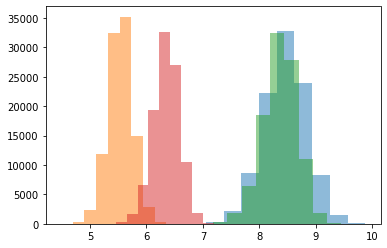

In [36]:
plt.hist(parental_likelihood[0, :1000], alpha=0.5)
#plt.hist(parental_likelihood[1, :]/np.sum(gens[1, :] != 0), alpha=0.5)
#plt.hist(parental_likelihood[2, :]/np.sum(gens[2, :] != 0), alpha=0.5)
#plt.hist(parental_likelihood[3, :]/np.sum(gens[3, :] != 0), alpha=0.5)
plt.show()

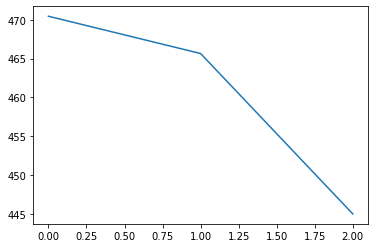

In [37]:
plt.plot([np.min(parental_likelihood[0, :1000]),
          np.min(parental_likelihood[0, :10000]),
          np.min(parental_likelihood[0, :100000]),
         ])